In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('D:\\6OHDA\\')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as Mcolors
import matplotlib.cm as cmx
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings
import pandas as pd
import sqlalchemy as db
import gc
from tqdm import tqdm
import seaborn as sns
import pywt # wavelet package
import matplotlib.cm as cm

In [3]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5','FinalData_6OHDA_H_skip.h5','FinalData_6OHDA_skip.h5']
miceList = getMiceList(Files[0])
betaMice = ['8430','4539','7584','7909','1222']

In [4]:
#path to folder where figures should be saved
figFolder = 'D:\\6OHDA\\submission1\\'

In [5]:
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<13:
        return 'Acute' #day 1-13
    else:
        return 'Chronic' #day 14-35

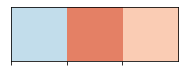

In [6]:
%matplotlib inline
a3 = np.array(sns.color_palette("RdBu_r", n_colors=7))
# a3 = np.concatenate((a3[2,:],a3[4:,:]))
colorPallet3Post =(a3[[2,5,4],:])
sns.palplot(sns.color_palette(colorPallet3Post)) 



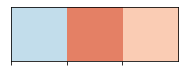

In [7]:
# set color pallet:
%matplotlib inline
a3 = np.array(sns.color_palette("RdBu_r", n_colors=7))
# colorPallet3 =(a3[[2,6,5],:])
colorPallet3 =(a3[[2,5,4],:])
sns.palplot(sns.color_palette(colorPallet3))

<h2> Calculate session stats for results sction 1 </h2>

In [8]:
df = pd.DataFrame()
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: (day >14)&(day<35)}

for per in periods.keys():
    data = getData(Files[1],['trace'],period ='Pre',day =periods[per])
    for sess in data.keys():
        m = sess[:4]
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred'])
        cre = getCreType(Files[1],m)
        numred = int(data[sess]['trace']['numred'])
        
        df= df.append({'mouse':m,'sess':sess,'day':day,
                       'period': periodCalc(day),'cre':cre,
                       'numred':numred,'numMsn':data[sess]['trace']['dff'].shape[0]},ignore_index=True)

d:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value


cleaning up trace data
cleaning up trace data
cleaning up trace data


In [9]:
df[~df.mouse.isin(['1253','1231'])].groupby(['period','cre']).agg([np.mean,sci.stats.sem])

day                numMsn               numred          
                    mean       sem        mean        sem      mean       sem
period    cre                                                                
Day 1-13  CHI   6.645161  0.636773   82.387097  13.205300  1.064516  0.185121
          NA    7.000000  0.828417  136.277778  21.081511  0.000000  0.000000
          PV    6.418182  0.466155  185.563636  19.160386  2.454545  0.352784
Day 14-35 CHI  24.176471  1.879133   95.117647  13.868575  1.117647  0.240746
          NA   21.333333  2.242271  207.555556  29.403850  0.000000  0.000000
          PV   23.066667  1.930869  183.466667  46.816243  1.000000  0.258199
Healthy   CHI   0.000000  0.000000  187.666667  53.700108  1.466667  0.412503
          NA    0.000000  0.000000  155.444444  14.013001  0.000000  0.000000
          PV    0.000000  0.000000  184.166667  29.495015  1.833333  0.345371

In [11]:
df[~df.mouse.isin(['1253','1231'])].groupby(['period']).agg([np.mean,sci.stats.sem])
df[~df.mouse.isin(['1253','1231'])].to_csv(figFolder+'numberNeurons.csv')

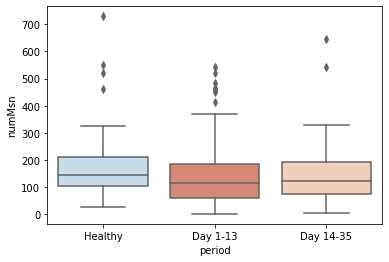

In [12]:
%matplotlib inline
with sns.color_palette(colorPallet3):  
    sns.boxplot(x = "period",y = "numMsn",data = df[~df.mouse.isin(['1253','1231'])])

<h2> Figures </h2>

<h3> Figure 1 </h3>

d:\6OHDA\IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value
d:\6OHDA\IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value
d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value


cleaning up trace data
cleaning up lfp data
cleaning up speed data


<IPython.core.display.Javascript object>


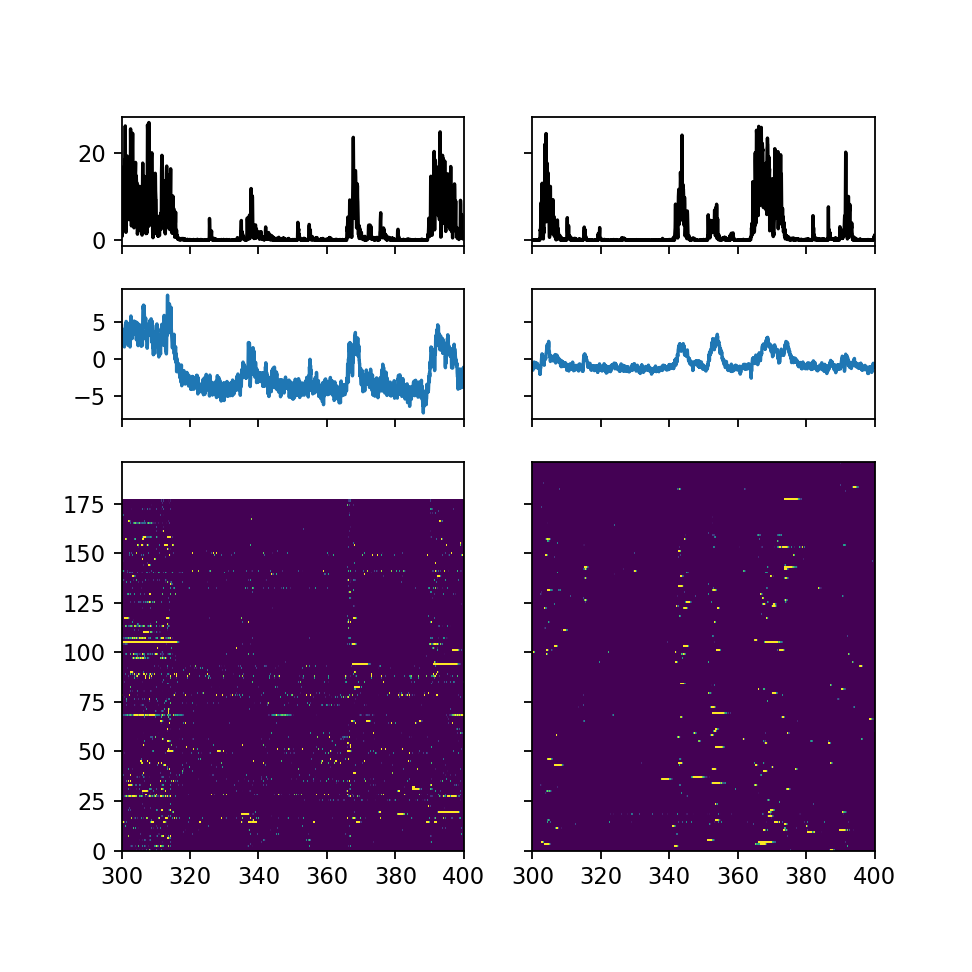

<IPython.core.display.Javascript object>


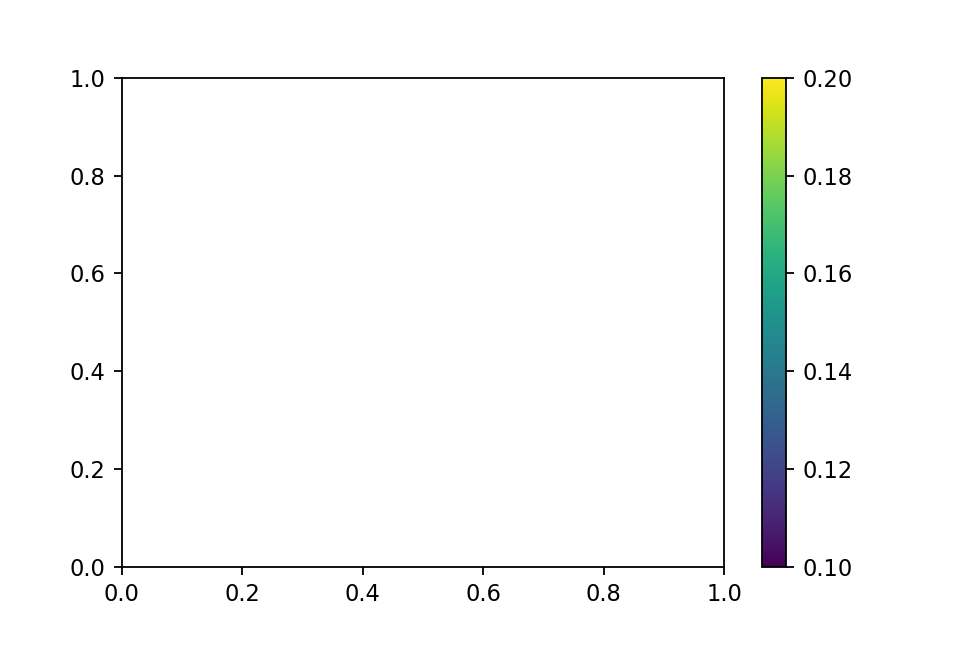

In [38]:
f = h5py.File('Spectograms.hdf5','r')

egSess = ['1236_BaselineS','1236_day30A']
egMouse = '1236'
data = getData(Files[1],['lfp','speed','trace'],period ='Pre',day =lambda day: (day==30) or (day==0), mice = [egMouse])

# plot lfp example:
fig, ax = plt.subplots(3,2,figsize=(6,6),sharex='col',sharey='row',gridspec_kw={'height_ratios': [1,1,3]})
# fig2, ax2 = plt.subplots(2,2,figsize=(6,3),sharex='col',gridspec_kw={'height_ratios': [1,3]})
for tPoint in range(0,2):
    sess = egSess[tPoint]
    dtS = 1/data[sess]['speed']['Fs']
    dtL = 1/data[sess]['lfp']['FS']
    ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
    tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

    ax[0,tPoint].plot(ts[6000:8001],data[sess]['speed']['speed'][0,6000:8001],color='black')
    
    ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape[1])) * dtS 
    dff = data[sess]['trace']['dff']
    dff = dff.T-np.nanmean(dff,axis=1)
    dff = dff.T
    dsum = np.sum((dff[:,6000:8001]),axis=0)
    ax[1,tPoint].plot(ts[6000:8001],dsum)
    
#     lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
#     lfp = data[sess]['lfp']['lfp']
#     lfp[(lfpOutliers[:,0]==1)] = np.nan
#     ax2[0,tPoint].plot(tl[0:5000],lfp[0:5000])

#     freq = f[egMouse]['freq'].value
#     coeff = np.abs(f[egMouse][sess]['Pre']['coeff'].value)
    
#     coeff[:,(lfpOutliers[:,0]==1)] = np.nan

#     ax2[1,tPoint].pcolormesh(tl[0:5000],freq,coeff[:,0:5000], rasterized=True)
    CS = ax[2,tPoint].pcolormesh(ts[6000:8001],np.arange(0,dff.shape[0]),dff[:,6000:8001],vmax=.2,vmin=0.1, rasterized=True)
    
    
fig.savefig(figFolder+'figure1a_Ca.png')
fig.savefig(figFolder+'figure1a_Ca.svg',transparent=True)
fig2, ax = plt.subplots(1,1)
fig2.colorbar(CS)
# fig2.savefig(figFolder+'figure1a_lfp_'+str(egSess[0])+"_"+str(egSess[1][5:])+'.png')
fig2.savefig(figFolder+'figure1a_colorbar.svg',transparent=True)

<h3> Figure 2 </h3>

In [12]:
f.close()

d:\6OHDA\IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
d:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
d:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


cleaning up speed data
cleaning up rot data


(260, 360)

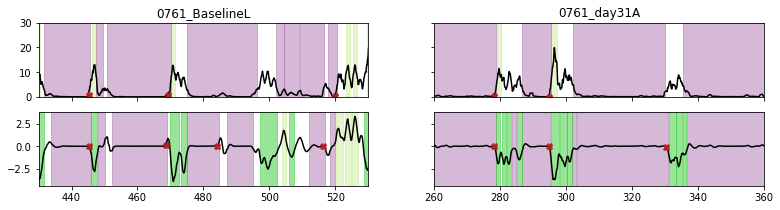

In [8]:
m = "0761"
sessList = [m+"_BaselineL",m+"_day31A"]
data = getData(Files[1],['speed','rot'],period ='Pre', mice=m, day = lambda x: (x==0) or (x==31))
conds = ['high','low','stright','ipsi','contra']
Color = CP('highLowSpeed')
Color['stright'] =Color['low'] #'tomato'
Color['ipsi']='limegreen'
Color['contra']=Color['high']
indX = 0
fig, ax  = plt.subplots(2,2,figsize=(13,3),sharey='row',sharex='col')
for sess in sessList:
    segments = {'high':{'ax':0,'start':getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_EndSegments')},
                'low':{'ax':0,'start':getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_EndSegments')},
                'stright':{'ax':1,'start':getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','loPeriods_EndSegments')},
                'ipsi':{'ax':1,'start':getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','hiACPeriods_EndSegments')},
                'contra':{'ax':1,'start':getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_StartSegments'),
                      'end':getOnsetOrPeriod(m,sess,'Pre','hiCPeriods_EndSegments')}}
    sOnset =  getOnsetOrPeriod(m,sess,'Pre','mvmtOnset')
    speed = data[sess]['speed']['speed'].T
    
    rOnset =  getOnsetOrPeriod(m,sess,'Pre','rotOnset')
    rot = data[sess]['rot']['rot'].T
    
    t = np.arange(0,len(speed))*0.05
    ax[0,indX].plot(t,smooth(speed,20),color='black')
    ax[1,indX].plot(t,smooth(rot,20),color='black')
    for cond in conds:
        for l in range(0, len(segments[cond]['start'])):
            ax[segments[cond]['ax'],indX].axvspan(t[segments[cond]['start'][l]], t[segments[cond]['end'][l]], color= Color[cond], alpha=0.5)
    ax[0,indX].plot(t[sOnset],speed[sOnset],'X',color='firebrick')
    ax[0,indX].set_ylim(0,30) 
    ax[1,indX].plot(t[rOnset],rot[rOnset],'X',color='firebrick')
    ax[0,indX].set_title(sess)
    indX = indX+1
ax[1,0].set_xlim(430,530)
ax[1,1].set_xlim(260,360)
#ax[1,1].set_ylim(-2.2,2)

#fig.savefig(figFolder+'figure2_mvmtOnset.png')
# fig.savefig(figFolder+'figure2_mvmtOnset.svg',transparent=True)

In [10]:
speedData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['speed'],period ='Pre', mice=m)
    
    # calculte % high speed + % low speed
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        Hp = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
        comb = Hp*1+((Lp*1)-1)*-1
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high'] = np.sum(Hp*1)/len(Hp)
        row['percent_medium'] = np.sum(comb==1)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['tran_all'] = np.sum(np.abs(trans!=0))
        row['tran_low2any'] = np.sum(np.abs(Lp[1:]*1-Lp[:-1]*1))
        row['tran_high2any'] = np.sum(np.abs(Hp[1:]*1-Hp[:-1]*1))
        
        row['MvmtOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','mvmtOnset'))        
        speedData.append(row)
          
df = pd.DataFrame(speedData)        
df['Period'] =  df.apply (lambda row: periodCalc(row.Day) , axis=1)

d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
d:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data


In [301]:
df.to_csv(figFolder+'speedData.csv')

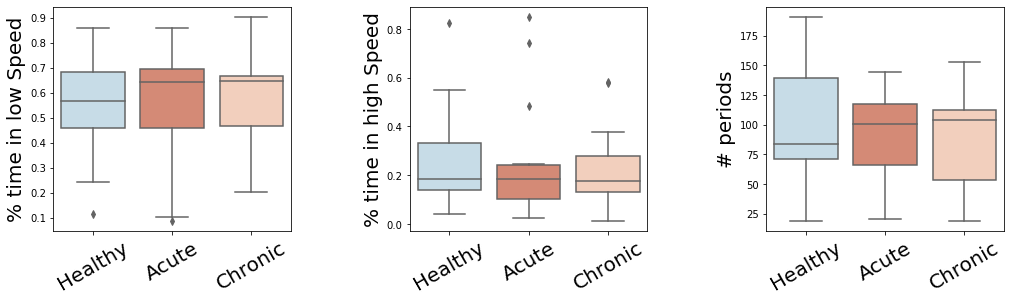

In [12]:
df2 = df.groupby(['Mouse','Period']).mean()
df2.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Acute','Chronic']
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['percent_low','percent_high','tran_low2any'] 
    labels = ['% time in low Speed','% time in high Speed','# periods']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2,ax =ax[ind],order = pOrder)
#         sns.swarmplot(x="Period", y=columns[ind], data=df2,ax =ax[ind],order = pOrder,color = 'Black')
        #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
        ax[ind].set_ylabel(labels[ind],fontsize=20)
        ax[ind].set_xlabel("")
        
        
#fig.savefig(figFolder+'figure2_abc.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2_b1.svg',transparent=True,format='svg')


d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
<ipython-input-13-e31e092cee75>:15: RuntimeWarning: invalid value encountered in true_divide
  hist  = hist/np.nansum(hist) # normalize per mouse


cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up speed data
cleaning up

d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
<ipython-input-13-e31e092cee75>:15: RuntimeWarning: invalid value encountered in true_divide
  hist  = hist/np.nansum(hist) # normalize per mouse


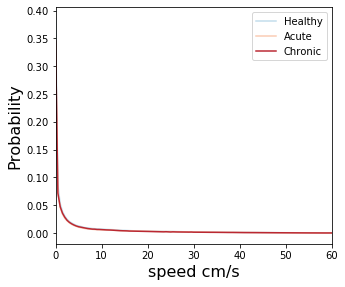

In [13]:
periods = {'Healthy': lambda day: day== 0,
           'Acute': lambda day: (day >0)&(day<13),
           'Chronic':lambda day: (day >14)&(day<35)}

fig, ax = plt.subplots(1,1,figsize=(5.99,5.67),gridspec_kw = {'hspace':.1,'bottom':0.3,'left':.26})
for indP,p in enumerate(periods.keys()):
    #to make sure mice are equally represented in each period
    weightsH = np.zeros((199,))
    for m in miceList:
        dataH = getData(Files[1],['speed'],period ='Pre', day = periods[p],mice = m)
        speedM = np.empty((1,0))
        for sess in dataH:
            speedM = np.concatenate((speedM, dataH[sess]['speed']['speed']), axis=1)
        hist, bin_edges = np.histogram(speedM, bins=np.arange(0,200)*0.5)
        hist  = hist/np.nansum(hist) # normalize per mouse
        weightsH = np.nansum((weightsH, hist),axis=0)

    ax.plot(np.arange(0,199)*0.5,weightsH/16,label=p,color=a3[2*indP+2,:])    
ax.set_xlim(0,60)
ax.set_xlabel('speed cm/s',fontsize=16)
ax.set_ylabel('Probability',fontsize=16)
ax.legend(fontsize=10)
#fig.savefig(figFolder+'figure2_b2.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2_b2.svg',transparent=True,format='svg')

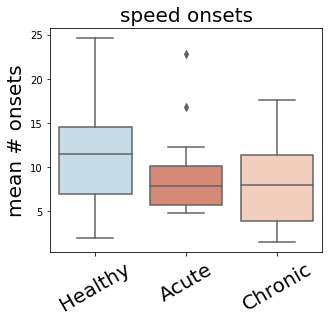

In [14]:
df2 = df.groupby(['Mouse','Period']).mean()
df2.reset_index(inplace=True)

fig, ax = plt.subplots(1,1,figsize=(4.88,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Acute','Chronic']
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['MvmtOnset'] 
    labels = ['speed onsets']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2,ax =ax,order = pOrder)
        #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30,fontsize=20)
        ax.set_ylabel("mean # onsets",fontsize=20)
        ax.set_xlabel("")
        ax.set_title(labels[ind],fontsize=20)
        
#fig.savefig(figFolder+'figure2_b3.png',transparent=False,format='png')
fig.savefig(figFolder+'figure2_b3.svg',transparent=True,format='svg')


In [26]:
rotData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['rot'],period ='Pre', mice=m)
    
    # calculte % high rot + % low rot
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        hACp = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
        hCp = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
        comb = hACp*8+Lp*5+hCp*7
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high_AC'] = np.sum(hACp*1)/len(hACp)
        row['percent_high_C'] = np.sum(hCp*1)/len(hCp)
        row['percent_non'] = np.sum(comb==0)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['trans'] = np.sum(trans!=0)
        row['tran_low2high'] = np.sum(trans>0)
        row['tran_high2low'] = np.sum(trans<0)
        row['rotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','rotOnset')) 
        row['cRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','clockWiseOnset'))
        row['acRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Pre','antiClockWiseOnset'))
        
        rotData.append(row)
          
dfRot = pd.DataFrame(rotData)        
dfRot['Period'] =  dfRot.apply (lambda row: periodCalc(row.Day) , axis=1)
dfRot.to_csv(figFolder+'rotation_forR.csv')

/home/dana_z/ssd_2TB/6OHDA/IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data


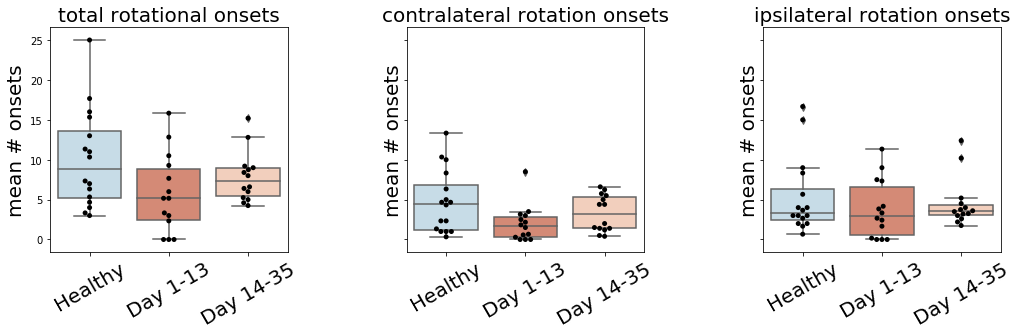

In [305]:
dfRot = pd.read_csv(figFolder+'rotation_forR.csv')
df2Rot = dfRot.groupby(['Mouse','Period']).mean()
df2Rot.reset_index(inplace=True)
df2Rot

fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey = True,gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Day 1-13','Day 14-35']
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['rotOnset','cRotOnset','acRotOnset'] 
    labels = ['total rotational onsets','contralateral rotation onsets','ipsilateral rotation onsets']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind],order = pOrder)
        sns.swarmplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind],order = pOrder,color='black')
        #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
        ax[ind].set_ylabel("mean # onsets",fontsize=20)
        ax[ind].set_xlabel("")
        ax[ind].set_title(labels[ind],fontsize=20)

#fig.savefig(figFolder+'figure2c_1.png',transparent=False,format='png')
# fig.savefig(figFolder+'figure2c_1.svg',transparent=True,format='svg')


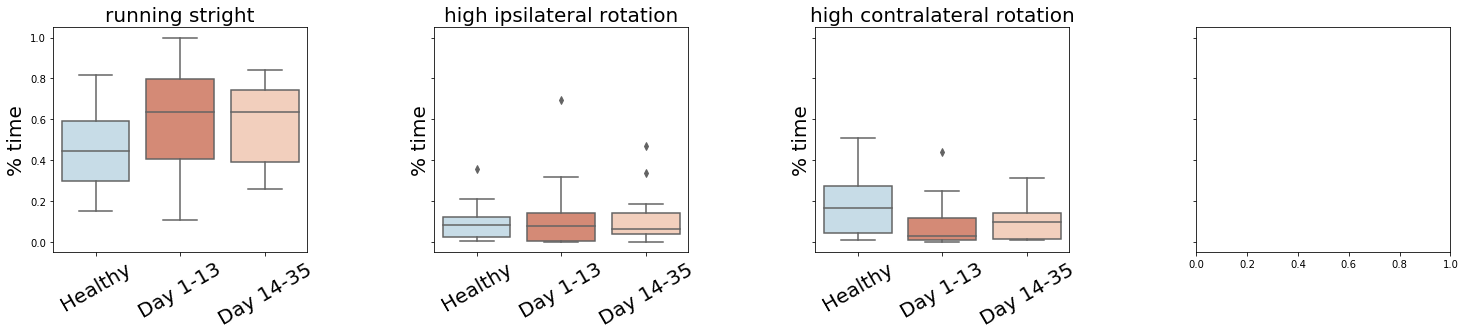

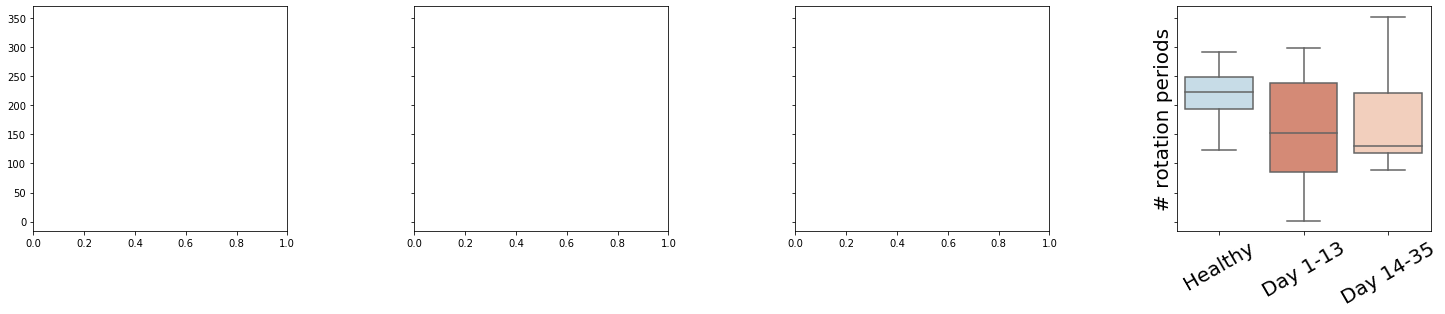

In [28]:
# repeat with paired t-test
# sns.set_style("white")
df2Rot = dfRot.groupby(['Mouse','Period']).mean()
df2Rot.reset_index(inplace=True)
df2Rot

fig, ax = plt.subplots(1,4,figsize=(25.04,4.88),sharey=True,gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
fig2, ax2 = plt.subplots(1,4,figsize=(25.04,4.88),sharey=True,gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = 
with sns.color_palette(colorPallet3):#sns.color_palette("PuBuGn_d"):
    columns = ['percent_low','percent_high_AC','percent_high_C','trans'] 
    labels = ['running stright','high ipsilateral rotation',
              'high contralateral rotation','']
    Ylabels = ['% time','% time','% time','# rotation periods']
    for ind in range(len(columns)):
        if ind <3:
            sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind],order = pOrder)
            #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
            ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
            ax[ind].set_ylabel(Ylabels[ind],fontsize=20)
            ax[ind].set_xlabel("")  
            ax[ind].set_title(labels[ind],fontsize=20)     
        else:
            sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax2[ind],order = pOrder)
            #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
            ax2[ind].set_xticklabels(ax2[ind].get_xticklabels(),rotation=30,fontsize=20)
            ax2[ind].set_ylabel(Ylabels[ind],fontsize=20)
            ax2[ind].set_xlabel("")  
            ax2[ind].set_title(labels[ind],fontsize=20)      

#fig.savefig(figFolder+'figure2c_2.png',transparent=False,format='png')
fig.savefig(figFolder+'figure2c_2.svg',transparent=True,format='svg')
fig2.savefig(figFolder+'figure2c_2b.svg',transparent=True,format='svg')


In [36]:
rotData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['rot'],period ='Post', mice=m, drug = b'Amphetamin')
    
    # calculte % high rot + % low rot
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        hACp = getOnsetOrPeriod(m,sess,'Post','hiACRotPeriods_vector')
        hCp = getOnsetOrPeriod(m,sess,'Post','hiCRotPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Post','loRotPeriods_vector')
        comb = hACp*8+Lp*5+hCp*7
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high_AC'] = np.sum(hACp*1)/len(hACp)
        row['percent_high_C'] = np.sum(hCp*1)/len(hCp)
        row['percent_non'] = np.sum(comb==0)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['trans'] = np.sum(trans!=0)
        row['tran_low2high'] = np.sum(trans>0)
        row['tran_high2low'] = np.sum(trans<0)
        row['rotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','rotOnset')) 
        row['cRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','clockWiseOnset'))
        row['acRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','antiClockWiseOnset'))
        
        rotData.append(row)
          
dfRot = pd.DataFrame(rotData)        
dfRot['Period'] =  dfRot.apply (lambda row:  'Healthy' if row.Day ==0 else ('Day 15' if row.Day< 30 else 'Day 30') , axis=1)

/home/dana_z/ssd_2TB/6OHDA/IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data
cleaning up rot data


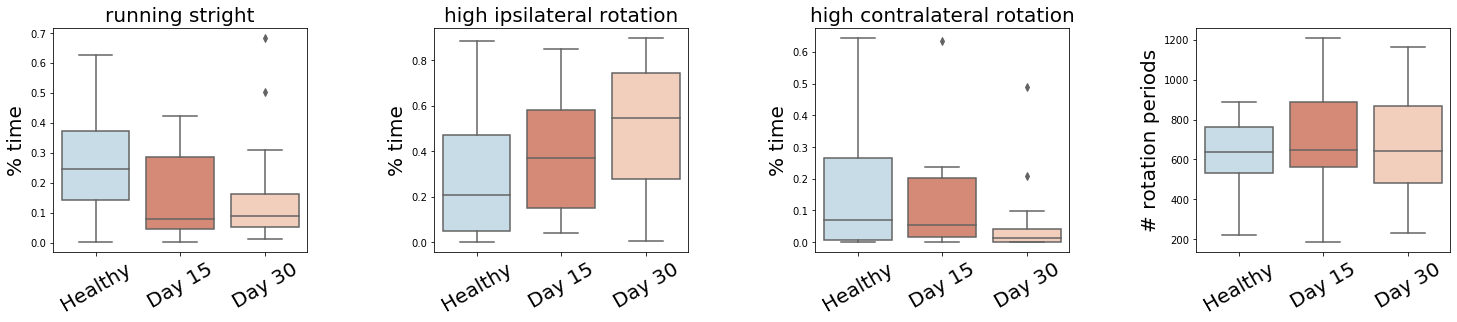

In [37]:
# repeat with paired t-test
# sns.set_style("white")
df2Rot = dfRot.groupby(['Mouse','Period']).mean()
df2Rot.reset_index(inplace=True)
#dfRot.to_csv(figFolder+'postAmphRot2R.csv')

fig, ax = plt.subplots(1,4,figsize=(25.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Day 15','Day 30']
with sns.color_palette(colorPallet3Post):#sns.color_palette("PuBuGn_d"):
    columns = ['percent_low','percent_high_AC','percent_high_C','trans'] 
    labels = ['running stright','high ipsilateral rotation',
              'high contralateral rotation','']
    Ylabels = ['% time','% time','% time','# rotation periods']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind],order = pOrder)
        #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
        ax[ind].set_ylabel(Ylabels[ind],fontsize=20)
        ax[ind].set_xlabel("")  
        ax[ind].set_title(labels[ind],fontsize=20)      
        
#fig.savefig(figFolder+'figure2d_post.png',transparent=False,format='png')
fig.savefig(figFolder+'figure2d_post.svg',transparent=True,format='svg')


In [38]:
dfRot.Period.unique()

array(['Healthy', 'Day 15', 'Day 30'], dtype=object)

<h3> Figure 3 </h3>

cleaning up trace data


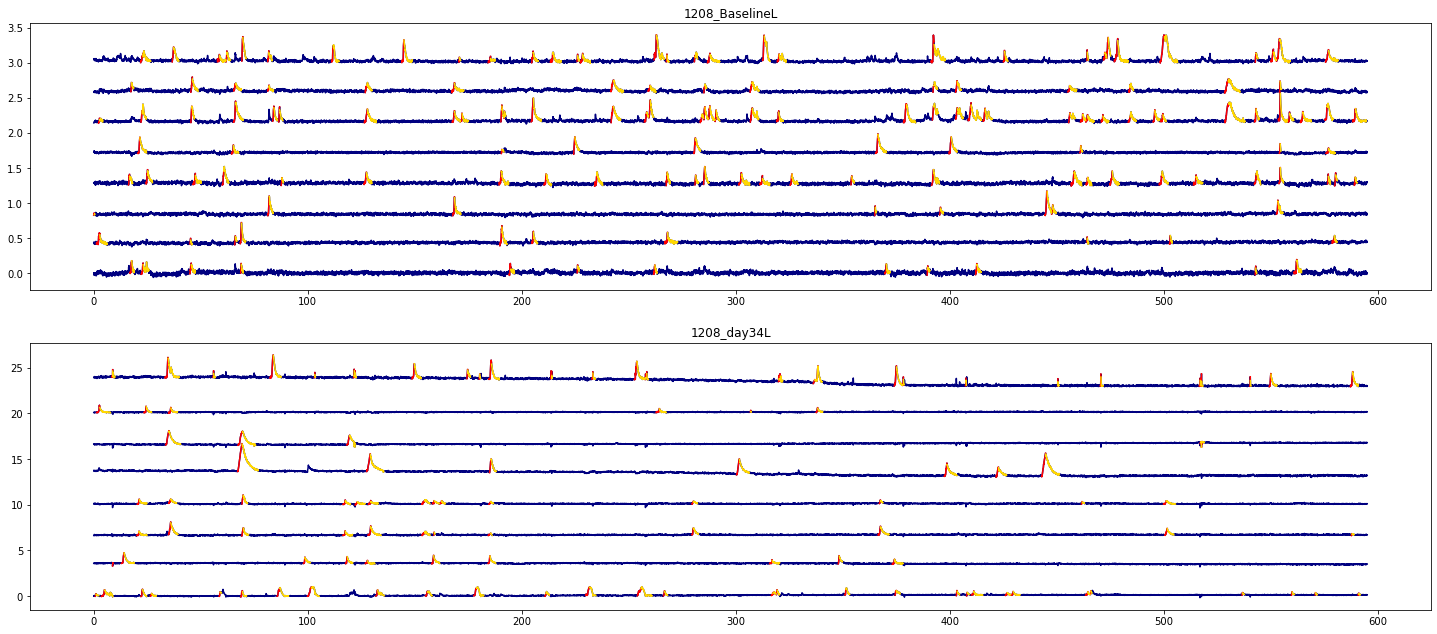

In [15]:
warnings.filterwarnings("ignore")

f = h5py.File('OnsetsAndPeriods.hdf5','r')
# align spectogram to spike onset -> for each mouse and in total,seperate by CRE:
sessList = {'1208_BaselineL':27,'1208_day34L':5}
m = '1208'
data = getData(Files[1],['trace'],period ='Pre',day =lambda day: (day==34) or (day==0), mice = [m])

# constents for analysis:
tracePerSlide = 8
colors = {'TD':'black','TD_skip':'indianred','MSN':'navy','MSN_skip':'royalblue'}
lf = {'left':0.30, 'top':1.30, 'height':10.80, 'width':25.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}

fig, ax = plt.subplots(2,1,figsize=(lf['width'],lf['height']))
fig.set_size_inches(lf['width'],lf['height'],forward=True)

indX = 0
for sess in sessList.keys():
    # get traces:
    dff = data[sess]['trace']['dff']
    dt = 1/data[sess]['trace']['FS'][0]
    t = np.linspace(0,dt*dff.shape[1],dff.shape[1])
    Fs = data[sess]['trace']['FS'][0]
    # Vectors are saved as column vectors so.. transposed to raw vector
    if dff.shape[1] == 1:
        dff = dff.T
    # get CaOnset:
    caOnset = f[m][sess]['Pre']['caOnset_Hf'].value
    caFall =  f[m][sess]['Pre']['caFall_Hf'].value
    caOnset[caOnset==0] =np.nan
    caFall[caFall==0] =np.nan
    numred = int(data[sess]['trace']['numred'][0])

    tLim = int(600*Fs)
    N = sessList[sess]
    endN = np.min(((N+1)*tracePerSlide,dff.shape[0]))
    T=0;
    endT = np.min(((T+1)*tLim,dff.shape[1]))
    df = dff[N*tracePerSlide:endN,T*tLim:endT]
    ca = caOnset[N*tracePerSlide:endN,T*tLim:endT]
    ca = ca*df
    cf = caFall[N*tracePerSlide:endN,T*tLim:endT]
    cf = cf*df
    spacing = np.max(np.abs(df))
    Color = ['navy' for x in range(0,df.shape[0])]
    if tracePerSlide*N <numred:
        Nl = min(tracePerSlide,numred-N*tracePerSlide)
        Color[0:Nl] = [colors['TD'] for x in range(0,Nl)]
        Color[Nl:] = [colors['MSN'] for x in range(Nl,len(Color))]
    else:
        Color = [colors['MSN'] for x in range(0,len(Color))]
    for d in range(0,df.shape[0]):
        ax[indX].plot(t[T*tLim:endT],df[d,:]+d*spacing,color=Color[d],rasterized=True) 
        ax[indX].plot(t[T*tLim:endT],ca[d,:]+d*spacing,color='red',rasterized=True)
        ax[indX].plot(t[T*tLim:endT],cf[d,:]+d*spacing,color='gold',rasterized=True)
    ax[indX].set_title(sess)
    indX = indX+1
#fig.savefig(figFolder+'figure3_eventDetection'+'.png')
# fig.savefig(figFolder+'figure3_eventDetection_rasterized'+'.svg',transparent=True)




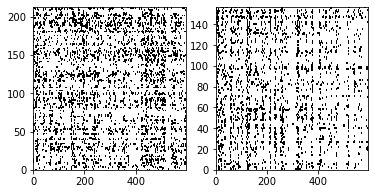

In [87]:
warnings.filterwarnings("ignore")

f = h5py.File('OnsetsAndPeriods.hdf5','r')
# align spectogram to spike onset -> for each mouse and in total,seperate by CRE:
sessList = {'1208_BaselineS':10,'1208_day34L':10}
m = '1208'

fig, ax = plt.subplots(1,2,figsize=(6,3),sharex='col')
indX = 0
for sess in sessList.keys():
    # get traces:
    
    # get CaOnset:
    caOnset = f[m][sess]['Pre']['caOnset_Hf'].value
    caOnset[caOnset==0] = np.nan
    ts = np.arange(0, np.max(caOnset.shape[1])) * .05 
    ax[indX].pcolormesh(ts[:],np.arange(0,caOnset.shape[0]),caOnset[:,:],cmap=cm.gray,rasterized=True)
    indX =indX+1
    

# fig.savefig(figFolder+'figure3_binaryRastor'+'.png')
fig.savefig(figFolder+'figure3_binaryRastor_rasterized2'+'.svg',transparent=True)




In [39]:
# data for all mice - homomorphic filter 
PVdata = getData(Files[1],['speed','trace'],period ='Pre', cre='PV',red = True)
MSNdata = getData(Files[1],['speed','trace'],period ='Pre',red = False)
CHIdata = getData(Files[1],['speed','trace'],period ='Pre', cre='CHI',red = True)


/home/dana_z/ssd_2TB/6OHDA/IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value


cleaning up trace data
I deleted session: 1236_day19L
I deleted session: 4539_day11
I deleted session: 4539_day5
I deleted session: 7584_day0
I deleted session: 7909_day30A
I deleted session: 8430_BaselineA
I deleted session: 8430_day1
I deleted session: 8430_day15A
I deleted session: 8430_day9
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day30A
I deleted session: 8803_day5
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 0761_day1
I deleted session: 0761_day12
I deleted session: 0761_day14A
I deleted session: 0761_day2
I deleted session: 0761_day31A
I deleted session: 1208_BaselineA
I deleted session: 1222_BaselineA
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day20L
I deleted session: 1222_day3
I deleted session: 1222_day32A
I deleted session: 1222_day36L
I deleted session: 1222_day5
I deleted s

In [40]:
#f = h5py.File('OnsetsAndPeriods.hdf5','r')
col_names = ['Mouse','Sess','Day','highSpeed','medSpeed','lowSpeed','All_',
             'acc','dcc','rotAcc','rotDcc','highACrot','highCrot','lowRot']
dfC = pd.DataFrame(columns = col_names)
cond = ['PVdata','MSNdata','CHIdata']
transWindow = np.ones((10,1))
for c in cond:
    data = eval(c)
    for sess in data.keys():
#         try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            m = sess[0:4]

            Hp = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            Lp = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            Mp = ((Hp+Lp)==0)
            hACp = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            hCp = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            Lrp = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            comb = hACp*8+Lp*5+hCp*7
            rotTrans = comb[1:]-comb[:-1]           
            
            Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
            numRed = int(data[sess]['trace']['numred'])
            if c in ['PVdata','CHIdata']:
                Ca = Ca[:numRed,:]
            else:
                Ca = Ca[numRed+1:,:]
            CaO = Ca[:,1:]-Ca[:,:-1]
            if CaO.shape[1]<Hp.shape[0]:
                 CaO = np.append(CaO,np.zeros((CaO.shape[0],1)),axis=1)
            C_start = (CaO==1)*1
            C_end = (CaO==-1)*1
            Acc = np.append(np.convolve(np.diff(Lp*1+Hp*2)>0, transWindow[:,0], mode='same')>0,False)
            Dcc = np.append(np.convolve(np.diff(Lp*1+Hp*2)<0, transWindow[:,0], mode='same')>0,False)
            rotAcc = np.append(np.convolve(rotTrans>0, transWindow[:,0], mode='same')>0,False)
            rotDcc = np.append(np.convolve(rotTrans<0, transWindow[:,0], mode='same')>0,False)
            if rotAcc.shape[0] >Acc.shape[0]:
                rotAcc = rotAcc[:Acc.shape[0]]
                rotDcc = rotDcc[:Acc.shape[0]]
                    

            
            a = np.asarray([np.sum(C_start[:,Hp],axis=1),np.sum(C_start[:,Mp],axis=1),
                            np.sum(C_start[:,Lp],axis=1),np.sum(C_start,axis=1),
                            np.sum(C_start[:,Acc],axis=1),np.sum(C_start[:,Dcc],axis=1),
                            np.sum(C_start[:,rotAcc],axis=1),np.sum(C_start[:,rotDcc],axis=1),
                            np.sum(C_start[:,hACp],axis=1),np.sum(C_start[:,hCp],axis=1),
                            np.sum(C_start[:,Lrp],axis=1)]).T
            
            df2C = pd.DataFrame(a, columns = col_names[3:])
            df2C['totalTime'] = (Hp.shape[0]/1200)
            df2C['lowTime'] = np.sum(Lp/1200)
            df2C['medTime'] = np.sum(Mp/1200)
            df2C['highTime'] = np.sum(Hp/1200)
            df2C['lowRotTime'] = np.sum(Lp/1200)
            df2C['highACRotTime'] = np.sum(hACp/1200)
            df2C['highCRotTime'] = np.sum(hCp/1200)
            df2C['totTrans'] = np.sum(rotTrans!=0)
            df2C['rotAccTrans'] = np.sum(rotTrans>0)
            df2C['rotDccTrans'] = np.sum(rotTrans<0)
            df2C['accTrans'] = np.sum(np.diff(Lp*1+Hp*2)>0)
            df2C['dccTrans'] = np.sum(np.diff(Lp*1+Hp*2)<0)
            df2C['Day'] = day
            df2C['Mouse'] = m
            df2C['Sess'] = sess
            df2C['CellType'] = c[:-4]
            df2C['Period'] = periodCalc(day)
            df2C['Beta']  = m in betaMice
            dfC = pd.concat([dfC,df2C],sort=True)
#         except:
#             print(sess)


dfC['high_speed'] =  dfC.apply (lambda row: row.highSpeed/row.highTime if row.highTime != 0 else None, axis=1)
dfC['medium_speed'] = dfC.apply (lambda row: row.medSpeed/row.medTime, axis=1)
dfC['low_speed'] = dfC.apply (lambda row: row.lowSpeed/row.lowTime , axis=1)
dfC['high_ACrot'] =  dfC.apply (lambda row: row.highACrot/row.highACRotTime if row.highACRotTime != 0 else None, axis=1)
dfC['high_Crot'] = dfC.apply (lambda row: row.highCrot/row.highCRotTime if row.highCRotTime != 0 else None, axis=1)
dfC['low_rot'] = dfC.apply (lambda row: row.lowRot/row.lowRotTime if row.lowRotTime != 0 else None, axis=1)
dfC['All'] = dfC.apply (lambda row: row.All_/row.totalTime , axis=1)
dfC['Acc'] = dfC.apply (lambda row: row.acc/row.accTrans , axis=1)
dfC['Dcc'] = dfC.apply (lambda row: row.dcc/row.dccTrans , axis=1)
dfC['Acc_'] = dfC.apply (lambda row: row.acc/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['Dcc_'] = dfC.apply (lambda row: row.dcc/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['rotAcc'] = dfC.apply (lambda row: row.rotAcc/row.rotAccTrans , axis=1)
dfC['rotDcc'] = dfC.apply (lambda row: row.rotDcc/row.rotDccTrans , axis=1)
dfC['rotAcc_'] = dfC.apply (lambda row: row.rotAcc/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['rotDcc_'] = dfC.apply (lambda row: row.rotDcc/row.All_ if row.All_ >0 else 0 , axis=1)


dfC['totAcc_'] = dfC.apply (lambda row: (row.dcc+row.acc)/row.All_ if row.All_ >0 else 0 , axis=1)
dfC['totRotAcc_'] = dfC.apply (lambda row: (row.rotDcc+row.rotAcc)/row.All_ if row.All_ >0 else 0 , axis=1)


dfC.head()


dfC.to_csv(figFolder+'firingRateDf.csv')

/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


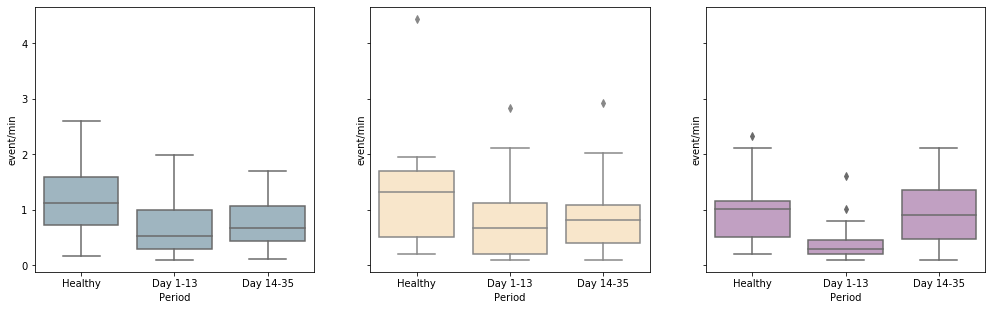

In [23]:
dfC = pd.read_csv(figFolder+ 'firingRateDf.csv')
# same plot, but by session... (Sense check)
dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','All']]
#dfM = dfM.merge(dfM.Dcc_.apply(lambda s: pd.Series({'All':s<0.05, 'Dcc_1':(s>=0.05)&(s<0.4),'Dcc_3':s>=0.9, 'Dcc_2':(s>=0.4)&(s<0.9)})), 
#    left_index=True, right_index=True)
dfM2 = dfM.groupby(['Sess','Period','CellType'],as_index=False).mean()
df_long = pd.melt(dfM2,id_vars=['CellType','Period'], value_vars=['All'],value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)
ind = 0
colors = ['#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for cell in cells:
#     g = sns.swarmplot(x="Period", y="event/min",data=df_long[(df_long.CellType == cell)],color = [.2,.2,.2],dodge = True,
#                       order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'],
#                       ax=ax[ind],**{'label':'_nolegend_'})
    g = sns.boxplot(x="Period", y="event/min",data=df_long[(df_long.CellType == cell)], dodge = True,
                    order = ['Healthy', 'Day 1-13', 'Day 14-35'],
                    color=colors[ind],ax=ax[ind])
    ind = ind +1
fig.savefig(figFolder+'figure3_b.svg',transparent=True,format='svg')


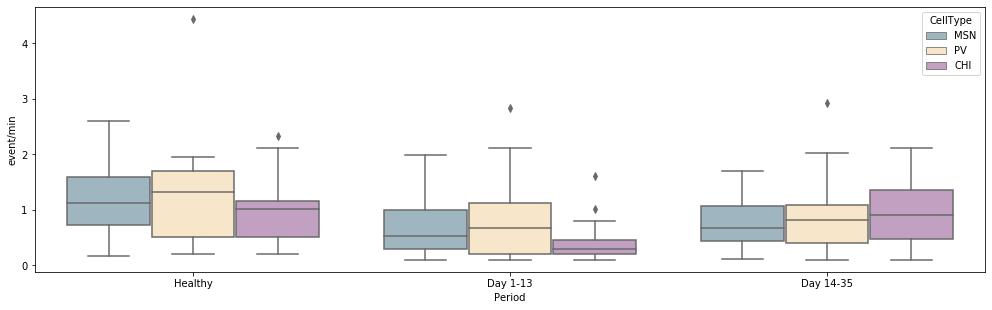

In [52]:
dfC = pd.read_csv(figFolder+ 'firingRateDf.csv')
# same plot, but by session... (Sense check)
dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','All']]
#dfM = dfM.merge(dfM.Dcc_.apply(lambda s: pd.Series({'All':s<0.05, 'Dcc_1':(s>=0.05)&(s<0.4),'Dcc_3':s>=0.9, 'Dcc_2':(s>=0.4)&(s<0.9)})), 
#    left_index=True, right_index=True)
dfM2 = dfM.groupby(['Sess','Period','CellType'],as_index=False).mean()
df_long = pd.melt(dfM2,id_vars=['CellType','Period'], value_vars=['All'],value_name='event/min')
fig, ax = plt.subplots(1,1,figsize=(17.04,4.88),sharey=True)
ind = 0
colors = ['#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
# for cell in cells:
#     g = sns.swarmplot(x="Period", y="event/min",data=df_long[(df_long.CellType == cell)],color = [.2,.2,.2],dodge = True,
#                       order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'],
#                       ax=ax[ind],**{'label':'_nolegend_'})
g = sns.boxplot(x="Period", y="event/min",hue = 'CellType',data=df_long, dodge = True, hue_order = cells,
                order = ['Healthy', 'Day 1-13', 'Day 14-35'],palette=colors,ax=ax)
#     ind = ind +1
fig.savefig(figFolder+'figure3_b_allin1.svg',transparent=True,format='svg')


In [84]:
# read numbers for paper details
dfC = pd.read_csv(figFolder+ 'firingRateDf.csv')

print(dfC[(dfC.All>0)][['Sess','Period','CellType','All']].groupby(['Sess','Period','CellType']).mean().groupby(['Period','CellType']).mean())
print(dfC[(dfC.All>0)][['Sess','Period','CellType','high_speed']].groupby(['Sess','Period','CellType']).mean().groupby(['Period','CellType']).mean())
print(dfC[(dfC.All>0)][['Sess','Period','CellType','low_speed']].groupby(['Sess','Period','CellType']).mean().groupby(['Period','CellType']).mean())

# print(dfC[(dfC.All>0)][['Sess','Period','CellType','All']].groupby(['Sess','Period','CellType']).mean().groupby(['Period','CellType']).count())
# print(dfC[(dfC.All>0)][['Sess','Period','CellType','All']].groupby(['Period','CellType']).count())
# print(dfC[['Sess','Period','CellType','All']].groupby(['Period','CellType']).count())

                         All
Period    CellType          
Day 1-13  CHI       0.452906
          MSN       0.663636
          PV        0.814384
Day 14-35 CHI       0.939727
          MSN       0.756602
          PV        0.940084
Healthy   CHI       0.979327
          MSN       1.181372
          PV        1.387572
                    high_speed
Period    CellType            
Day 1-13  CHI         0.592419
          MSN         1.140034
          PV          1.182842
Day 14-35 CHI         2.052284
          MSN         1.338309
          PV          1.367692
Healthy   CHI         1.319857
          MSN         1.762098
          PV          3.000486
                    low_speed
Period    CellType           
Day 1-13  CHI        0.400494
          MSN        0.502772
          PV         0.660527
Day 14-35 CHI        0.507901
          MSN        0.506332
          PV         0.757015
Healthy   CHI        0.823641
          MSN        0.825712
          PV         0.809003


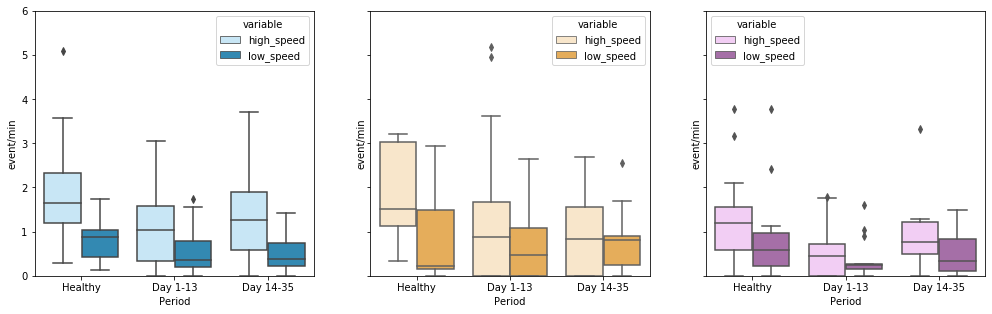

In [56]:
#print(dfC.columns)
# for each cell, high and low speed on same plot - Average per session

dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','high_speed',
                        'low_speed', 'high_ACrot', 'high_Crot','low_rot']]
dfM2 = dfM.groupby(['Sess','Period','CellType'],as_index=False).mean()

columns = ['high_speed', 'low_speed']#, 'high_ACrot', 'high_Crot','low_rot'] 
df_long = pd.melt(dfM2,id_vars=['CellType','Period','Sess'], value_vars=columns,value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)
indC = 0
colors = {'MSN':['#c0e9fc','#1e91c7'], 'PV':['#FFE7C4','#fcb144'],'CHI':['#f8c8fa','#ad66b0']} #'#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for cell in cells:
#     g = sns.swarmplot(x="Period", y="event/min",hue ='variable' ,data=df_long[(df_long.CellType == cell)],color = [.2,.2,.2],dodge = True,
#                       order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'], 
#                       ax=ax[indC],**{'label':'_nolegend_','alpha':0.5,'s':3})
    g = sns.boxplot(x="Period",hue ='variable', y="event/min",data=df_long[(df_long.CellType == cell)], dodge = True,
                   order = ['Healthy', 'Day 1-13', 'Day 14-35'],
                   palette=colors[cell],ax=ax[indC])

    ax[indC].set_ylim(0,6)
    indC = indC +1
#fig.savefig(figFolder+'figure3_c.png',transparent=False,format='png')
fig.savefig(figFolder+'figure3_c.svg',transparent=True,format='svg')
#HIGHSPEED

/home/dana_z/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 30.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dana_z/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 27.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dana_z/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 48.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dana_z/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 43.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


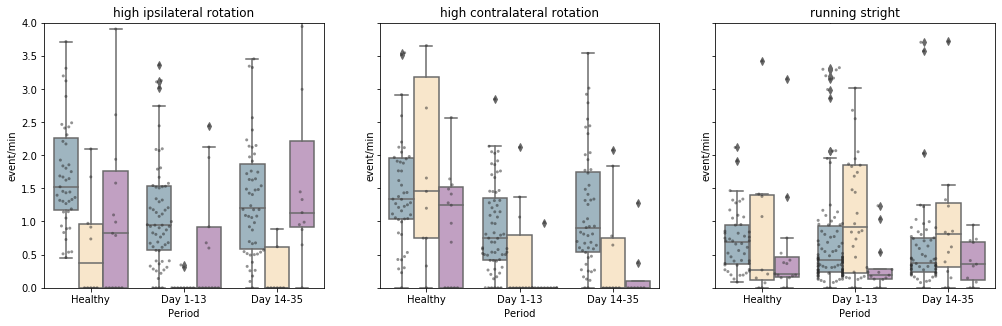

In [57]:
#contralateral '
# for each cell, high and low Rot on same plot - Average per sess

dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','high_ACrot', 'high_Crot','low_rot']]
dfM2 = dfM.groupby(['Sess','Period','CellType'],as_index=False).mean()

columns = ['high_ACrot', 'high_Crot','low_rot']#, 'high_ACrot', 'high_Crot','low_rot'] 
labels = ['high ipsilateral rotation', 'high contralateral rotation','running stright']
df_long = pd.melt(dfM2,id_vars=['CellType','Period','Sess'], value_vars=columns,value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)

colors = ['#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for col in range(0,len(columns)):
    colors = ['#99B7C5','#FFE7C4','#C69AC8']
    df_long = pd.melt(dfM2,id_vars=['CellType','Period','Sess'], value_vars=columns[col],value_name='event/min')
    g = sns.swarmplot(x="Period",hue = 'CellType', y="event/min",data=df_long,color = [.2,.2,.2],dodge = True,
                      order = ['Healthy',  'Day 1-13',  'Day 14-35'], hue_order = cells,
                      ax=ax[col],**{'label':'_nolegend_','alpha':0.5,'s':3})
    g = sns.boxplot(x="Period", hue = 'CellType',y="event/min",data=df_long, dodge = True,
                    order = ['Healthy',  'Day 1-13',  'Day 14-35'],hue_order = cells,
                    palette=colors,ax=ax[col])
    if col==2:
        ax[col].set_ylim([0,4])
    ax[col].set_title(labels[col])
    g.legend_.remove()

#fig.savefig(figFolder+'figure3_d.png',transparent=False,format='png')
fig.savefig(figFolder+'figure3_d.svg',transparent=True,format='svg')
    
    

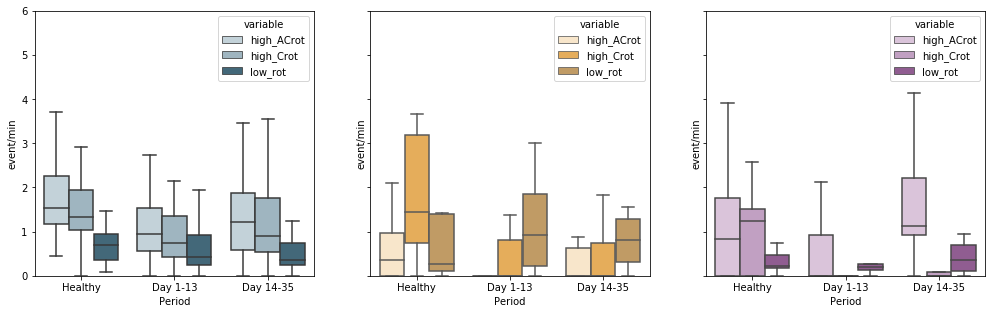

In [60]:
dfC = pd.read_csv(figFolder+ 'firingRateDf.csv')
dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','high_ACrot', 'high_Crot','low_rot']]
dfM2 = dfM.groupby(['Sess','Period','CellType'],as_index=False).mean()

columns = ['high_ACrot', 'high_Crot','low_rot']#, 'high_ACrot', 'high_Crot','low_rot'] 
df_long = pd.melt(dfM2,id_vars=['CellType','Period','Sess'], value_vars=columns,value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)
indC = 0
colors = {'MSN':['#C0D3DC','#99B7C5','#3A6C82'], 'PV':['#FFE7C4','#fcb144','#CF9E56'],'CHI':['#DDC0DE','#C69AC8','#98549A']} #'#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for cell in cells:
#     g = sns.swarmplot(x="Period", y="event/min",hue ='variable' ,data=df_long[(df_long.CellType == cell)],color = [.2,.2,.2],dodge = True,
#                       order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'], 
#                       ax=ax[indC],**{'label':'_nolegend_','alpha':0.5,'s':3})
    g = sns.boxplot(x="Period",hue ='variable', y="event/min",data=df_long[(df_long.CellType == cell)], dodge = True,
                   order = ['Healthy', 'Day 1-13', 'Day 14-35'],
                   palette=colors[cell],ax=ax[indC], showfliers = False)

    ax[indC].set_ylim(0,6)
    indC = indC +1
#fig.savefig(figFolder+'figure3_c.png',transparent=False,format='png')
fig.savefig(figFolder+'figure3_c_v2.svg',transparent=True,format='svg')


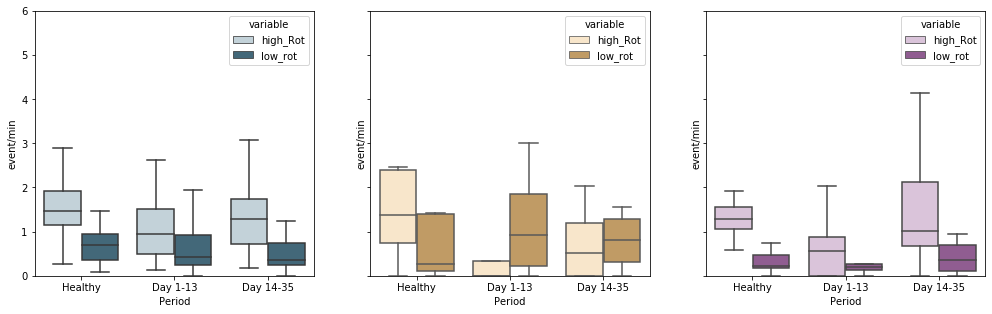

In [60]:
dfC = pd.read_csv(figFolder+ 'firingRateDf.csv')

dfC['high_Rot'] =  dfC.apply (lambda row: (row.highACrot+row.highCrot)/(row.highACRotTime+row.highCRotTime) if (row.highACRotTime+row.highCRotTime) != 0 else None, axis=1)
dfC.to_csv(figFolder+ 'firingRateDf.csv')

dfM = dfC[(dfC.All>0)][['Mouse','Sess','Period','CellType','high_Rot','low_rot']]
dfM2 = dfM.groupby(['Sess','Period','CellType'],as_index=False).mean()

columns = ['high_Rot','low_rot']#, 'high_ACrot', 'high_Crot','low_rot'] 
df_long = pd.melt(dfM2,id_vars=['CellType','Period','Sess'], value_vars=columns,value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)
indC = 0
colors = {'MSN':['#C0D3DC','#3A6C82'], 'PV':['#FFE7C4','#CF9E56'],'CHI':['#DDC0DE','#98549A']} #'#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for cell in cells:
#     g = sns.swarmplot(x="Period", y="event/min",hue ='variable' ,data=df_long[(df_long.CellType == cell)],color = [.2,.2,.2],dodge = True,
#                       order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'], 
#                       ax=ax[indC],**{'label':'_nolegend_','alpha':0.5,'s':3})
    g = sns.boxplot(x="Period",hue ='variable', y="event/min",data=df_long[(df_long.CellType == cell)], dodge = True,
                   order = ['Healthy', 'Day 1-13', 'Day 14-35'],
                   palette=colors[cell],ax=ax[indC], showfliers = False)

    ax[indC].set_ylim(0,6)
    indC = indC +1
#fig.savefig(figFolder+'figure3_c.png',transparent=False,format='png')
fig.savefig(figFolder+'figure3_c_v2_groupedRotaionM.svg',transparent=True,format='svg')


In [27]:
dfM = dfC#[(dfC.All>0)]
dfM2 = dfM.groupby(['Sess','Period','Mouse','CellType'],as_index=False).mean()
dfM2.to_csv(figFolder+ 'firingRateDf_R2.csv')

In [ ]:
# Same exact plot as a bove with legend -> so can keep one copy for menuscript


dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','high_ACrot', 'high_Crot','low_rot']]
dfM2 = dfM.groupby(['Sess','Period','CellType'],as_index=False).mean()

columns = ['high_ACrot', 'high_Crot','low_rot']#, 'high_ACrot', 'high_Crot','low_rot'] 
labels = ['high ipsilateral rotation', 'high contralateral rotation','running stright']
df_long = pd.melt(dfM2,id_vars=['CellType','Period','Sess'], value_vars=columns,value_name='event/min')
fig, ax = plt.subplots(1,2,figsize=(17.04,4.88),sharey=True)

colors = ['#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for col in range(0,1):
    colors = ['#99B7C5','#FFE7C4','#C69AC8']
    df_long = pd.melt(dfM2,id_vars=['CellType','Period','Sess'], value_vars=columns[col],value_name='event/min')
    g = sns.swarmplot(x="Period",hue = 'CellType', y="event/min",data=df_long,color = [.2,.2,.2],dodge = True,
                      order = ['Healthy',  'Day 5-12',  'One Month'], hue_order = cells,
                      ax=ax[col],**{'label':'_nolegend_','alpha':0.5,'s':3})
    g = sns.boxplot(x="Period", hue = 'CellType',y="event/min",data=df_long, dodge = True,
                    order = ['Healthy',  'Day 5-12',  'One Month'],hue_order = cells,
                    palette=colors,ax=ax[col])
    if col==2:
        ax[col].set_ylim([0,4])
    ax[col].set_title(labels[col])
#fig.savefig(figFolder+'figure4_cLegend.png',transparent=False,format='png')
fig.savefig(figFolder+'figure3_Legend.svg',transparent=True,format='svg')
    
    

<h3> Figure 4 </h3>

In [8]:
#  for all mice - by period
PV0 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x==0)
PV1 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: (x>0)& (x<13) )
PV2 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x>=13 )

CHI0 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x==0)
CHI1 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: (x>0)& (x<13) )
CHI2 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x>=13 )

MSN0 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: x==0)
MSN1 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: (x>0)& (x<13) )
MSN2 = getData(Files[1],['speed','rot','trace'],period ='Pre', red = False,day = lambda x: x>=13 )

/home/dana_z/ssd_2TB/6OHDA/IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  rot = hf[m][s]['mvmt']['rotation'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value


cleaning up trace data
I deleted session: 7584_day0
I deleted session: 8430_BaselineA
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 4539_day11
I deleted session: 4539_day5
I deleted session: 8430_day1
I deleted session: 8430_day9
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day5
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 1236_day19L
I deleted session: 7909_day30A
I deleted session: 8430_day15A
I deleted session: 8803_day30A
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 1208_BaselineA
I deleted session: 1222_BaselineA
I deleted session: 1253_BaselineA
I deleted session: 1253_BaselineS
I deleted session: 1793_BaselineA
I deleted session: 8815_BaselineL
cleaning up trace data
cleaning up speed data
cleaning up rot data
cleaning up trace data
I deleted session: 0

In [ ]:
# only needs to run once... 
from numpy import matlib
niter = 1000
PostS=40
preS = 40
f = h5py.File('membership.hdf5','a')
miceList = getMiceList(Files[0])
faild = []
for m in miceList:
    data = getData(Files[1],['trace'],period ='Pre', mice=m)
    try:
        grp = f.create_group(m)
    except: 
        grp = f[m]
    
    for sess in tqdm(data.keys()):
        try: 
            sgrp = grp[sess]
        except: 
            sgrp = grp.create_group(sess)
        try: 
            subgroup = sgrp.create_group('mvmtOnset')
            subgroup2 = sgrp.create_group('ipsiOnset')
            subgroup3 = sgrp.create_group('contraOnset')
        except:
            subgroup = sgrp['mvmtOnset']
            subgroup2 = sgrp['ipsiOnset']
            subgroup3 = sgrp['contraOnset']

        dff = data[sess]['trace']['dff']
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset2')
    #    print(mvmtOnset.shape)
        aDff = alignToOnset(dff.T, mvmtOnset, winPost=PostS,winPre=preS)
        onset = np.reshape(mvmtOnset,(1,np.max(mvmtOnset.shape)))
    #    print(aDff.shape,onset.shape,mvmtOnset.shape)

        result,rawResults,Th = perNeuronPerEvent(aDff,dff,onset,niter)
        if np.sum(onset) != 0:
            subgroup['result'] = result
            subgroup['rawResults'] = rawResults
            subgroup['Th'] = Th
        
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','clockWiseOnset')
    #    print(mvmtOnset.shape)
        aDff = alignToOnset(dff.T, mvmtOnset, winPost=PostS,winPre=preS)
        onset = np.reshape(mvmtOnset,(1,np.max(mvmtOnset.shape)))
    #    print(aDff.shape,onset.shape,mvmtOnset.shape)

        result,rawResults,Th = perNeuronPerEvent(aDff,dff,onset,niter)
        if np.sum(onset) != 0:
            subgroup3['result'] = result
            subgroup3['rawResults'] = rawResults
            subgroup3['Th'] = Th
        
        mvmtOnset = getOnsetOrPeriod(m,sess,'Pre','antiClockWiseOnset')
    #    print(mvmtOnset.shape)
        aDff = alignToOnset(dff.T, mvmtOnset, winPost=PostS,winPre=preS)
        onset = np.reshape(mvmtOnset,(1,np.max(mvmtOnset.shape)))
    #    print(aDff.shape,onset.shape,mvmtOnset.shape)

        result,rawResults,Th = perNeuronPerEvent(aDff,dff,onset,niter)
        if np.sum(onset) != 0:
            subgroup2['result'] = result
            subgroup2['rawResults'] = rawResults
            subgroup2['Th'] = Th
#       except: 
        faild.append(sess)
#    print(result.shape)
f.close()

In [12]:
# only needs to run once... Add total rot to file
from numpy import matlib
niter = 1000
PostS=40
preS = 40
f = h5py.File('membership.hdf5','a')
miceList = getMiceList(Files[0])
faild = []
for m in miceList:
    data = getData(Files[1],['trace'],period ='Pre', mice=m)
    try:
        grp = f.create_group(m)
    except: 
        grp = f[m]
    
    for sess in tqdm(data.keys()):
        try: 
            sgrp = grp[sess]
        except: 
            sgrp = grp.create_group(sess)
        try: 
            subgroup = sgrp.create_group('rotOnset')
        except:
            del sgrp['rotOnset']
            subgroup = sgrp.create_group('rotOnset')

        dff = data[sess]['trace']['dff']
        mvmtOnseti = getOnsetOrPeriod(m,sess,'Pre','clockWiseOnset')
        mvmtOnsetc = getOnsetOrPeriod(m,sess,'Pre','antiClockWiseOnset')
        mvmtOnset = mvmtOnseti + mvmtOnsetc
    #    print(mvmtOnset.shape)
        aDff = alignToOnset(dff.T, mvmtOnset, winPost=PostS,winPre=preS)
        onset = np.reshape(mvmtOnset,(1,np.max(mvmtOnset.shape)))
    #    print(aDff.shape,onset.shape,mvmtOnset.shape)

        result,rawResults,Th = perNeuronPerEvent(aDff,dff,onset,niter)
        if np.sum(onset) != 0:
            subgroup['result'] = result
            subgroup['rawResults'] = rawResults
            subgroup['Th'] = Th
        
#       except: 
        faild.append(sess)
#    print(result.shape)
f.close()

  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/17 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data


100%|██████████| 14/14 [00:14<00:00,  1.05s/it]


In [11]:
f.close()

In [13]:
# repeat only total rot: 
f = h5py.File('membership.hdf5','r')
miceList = getMiceList(Files[1])
col_names = ['Sess','Mouse','Period','Day','CellType']
df = pd.DataFrame(columns=col_names)
for m in miceList:
    grp = f[m]
    sessions = list(grp.keys())
    for sess in sessions:
        try:
            data = grp[sess]['rotOnset']['result'].value
            meanR_mvmtOnset = np.mean(data,axis=1)
        except:
            print(sess,'rot')
            meanR_mvmtOnset = np.nan
        
        if sess[5] == 'B':
                day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        cre = getCreType(Files[1],m)
        nRed = getNumRed(Files[1],m,sess[5:])
        try:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_rotOnset':meanR_mvmtOnset})
        except:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_rotOnset':meanR_mvmtOnset},index = [0])
        df2.loc[:nRed-1,'CellType'] = cre
        df = pd.concat([df,df2],sort=True)

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()


2976_day8 rot
4539_day1 rot
4539_day10 rot
4539_day11 rot
4539_day12 rot
4539_day13 rot
4539_day14 rot
4539_day2 rot
4539_day3 rot
4539_day4 rot
4539_day5 rot
4539_day6 rot
4539_day7 rot
4539_day8 rot
4539_day9 rot
7584_day1 rot
7584_day10 rot
7584_day11 rot
7584_day12 rot
7584_day15 rot
7584_day2 rot
7584_day3 rot
7584_day4 rot
7584_day5 rot
7584_day6 rot
7584_day7 rot
7584_day8 rot
7584_day9 rot
7909_day1 rot
7909_day10 rot
7909_day11 rot
7909_day12 rot
7909_day13 rot
7909_day14 rot
7909_day2 rot
7909_day3 rot
7909_day4 rot
7909_day5 rot
7909_day6 rot
7909_day7 rot
7909_day8 rot
7909_day9 rot
8430_day11 rot
8430_day30A rot
8430_day7 rot


<IPython.core.display.Javascript object>


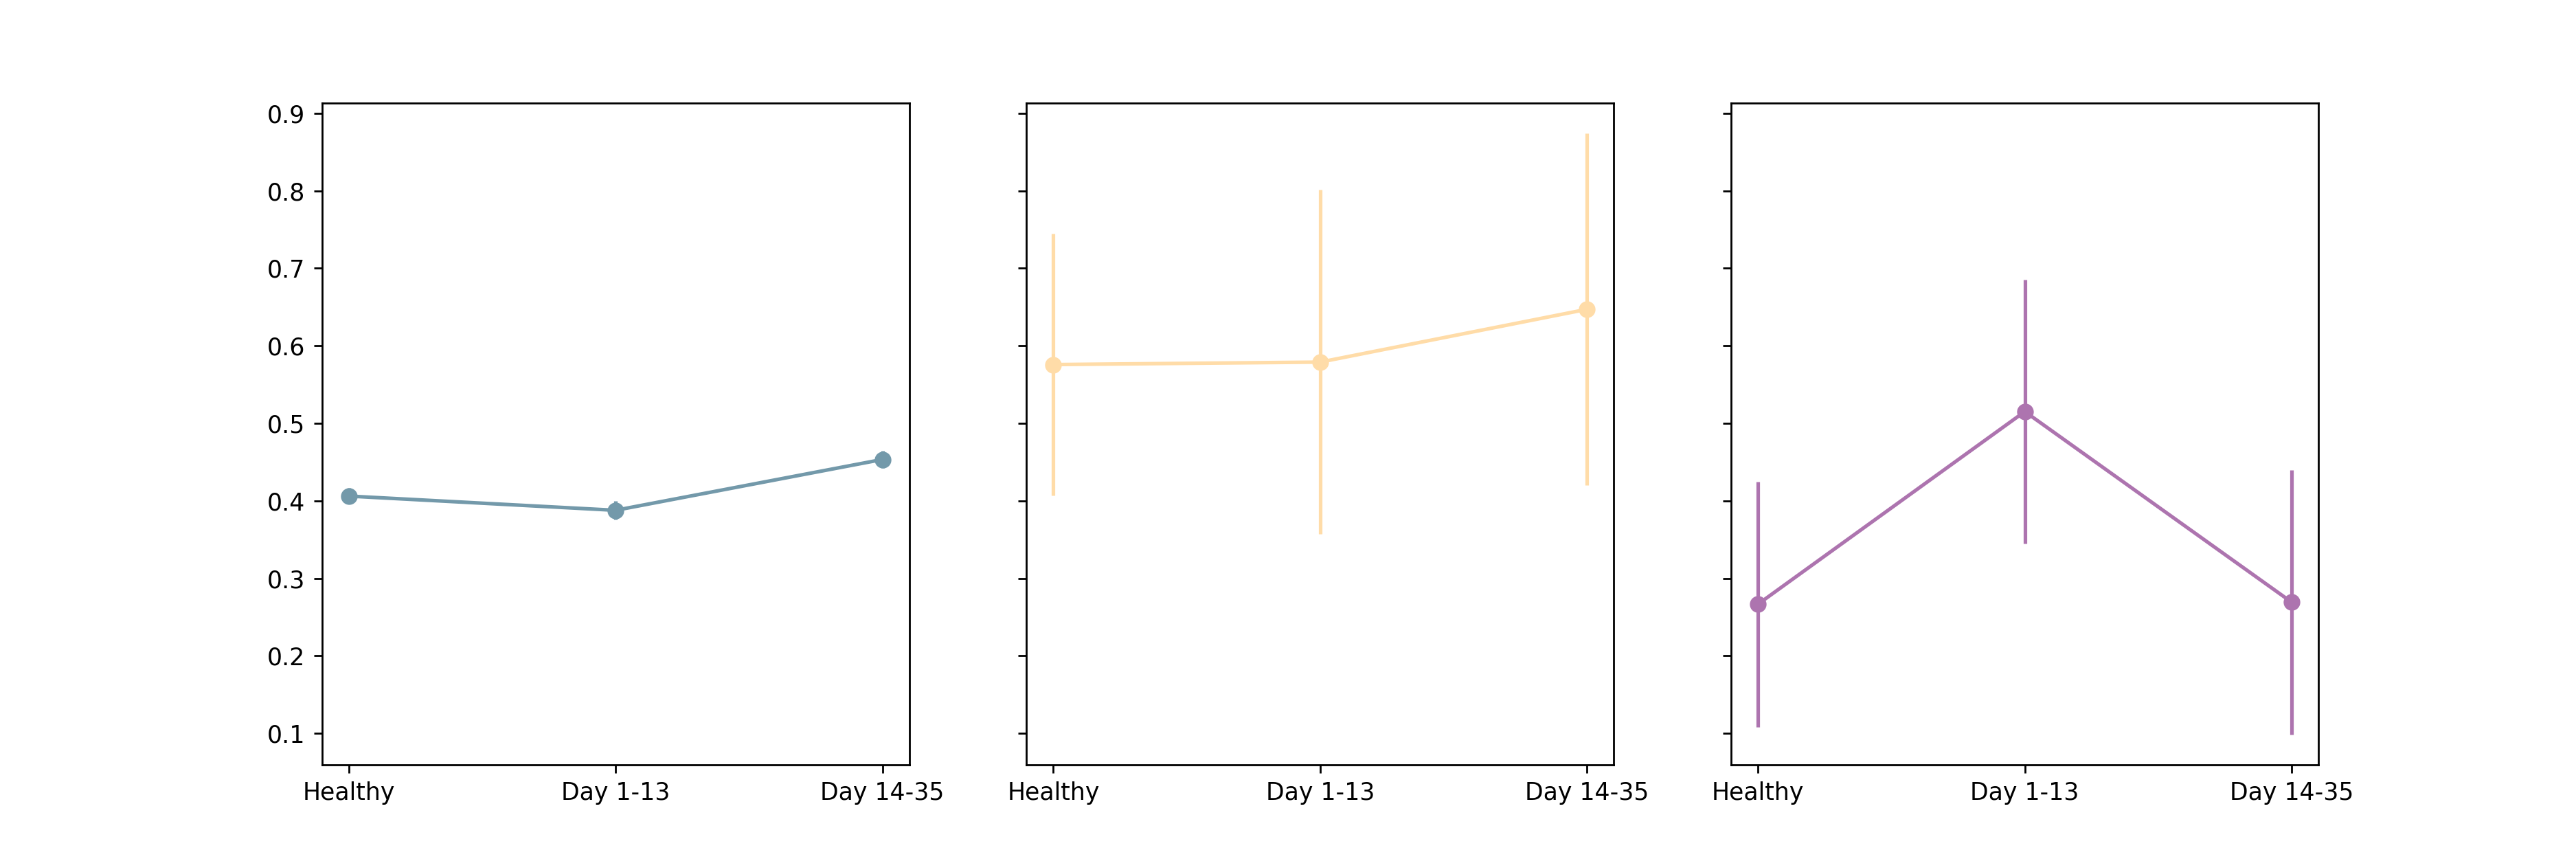

      Period  meanR_rotOnset      care      mean       std  count       SEM
0    Healthy        0.094484  0.406159  0.406159  0.491142   8898  0.010205
1   Day 1-13        0.102551  0.387813  0.387813  0.487290   6400  0.011938
2  Day 14-35        0.109302  0.453373  0.453373  0.497852   7989  0.010916
      Period  meanR_rotOnset      care      mean       std  count       SEM
0    Healthy        0.150434  0.575758  0.575758  0.501890     33  0.168627
1   Day 1-13        0.268151  0.578947  0.578947  0.507257     19  0.222007
2  Day 14-35        0.135358  0.647059  0.647059  0.492592     17  0.227172
      Period  meanR_rotOnset      care      mean       std  count       SEM
0    Healthy        0.058088  0.266667  0.266667  0.449776     30  0.158245
1   Day 1-13        0.124098  0.515152  0.515152  0.507519     33  0.170518
2  Day 14-35        0.057757  0.269231  0.269231  0.452344     26  0.170499


In [15]:
df.Period = df.Period.astype("category")
df.Period = df.Period.cat.reorder_categories(['Healthy', 'Day 1-13', 'Day 14-35'])
df['care'] = df.meanR_rotOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')

fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
Colors = CP('creType')
cond = ['MSN','PV','CHI']
for idx in range(0,3):
    df2 = df[df.CellType == cond[idx]].groupby('Period').mean()
    df2['mean'] = df[df.CellType == cond[idx]].groupby('Period').care.mean()
    df2['std']  = df[df.CellType == cond[idx]].groupby('Period').care.std()
    df2['count']  = df[df.CellType == cond[idx]].groupby('Period').meanR_rotOnset.count()
    df2['SEM'] = df2.apply(lambda x: 1.96*np.sqrt(x['mean']*(1-x['mean'])/x['count']),axis=1)
    df2 = df2.reset_index()
    ax[idx].errorbar(df2.Period, df2['mean'], yerr=df2.SEM, fmt='-o', color = Colors[cond[idx]])
    print(df2)
    del df2
fig.savefig(figFolder+'figure4c_Tot.svg',transparent=True)


In [62]:
# repeat only movement: 
f = h5py.File('membership.hdf5','r')
miceList = getMiceList(Files[1])
col_names = ['Sess','Mouse','Period','Day','CellType']
df = pd.DataFrame(columns=col_names)
for m in miceList:
    grp = f[m]
    sessions = list(grp.keys())
    for sess in sessions:
        try:
            data = grp[sess]['mvmtOnset']['result'].value
            meanR_mvmtOnset = np.mean(data,axis=1)
        except:
            print(sess,'mvmt')
            meanR_mvmtOnset = np.nan
        
        if sess[5] == 'B':
                day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        cre = getCreType(Files[1],m)
        nRed = getNumRed(Files[1],m,sess[5:])
        try:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset})
        except:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset},index = [0])
        df2.loc[:nRed-1,'CellType'] = cre
        df = pd.concat([df,df2],sort=True)

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()


0761_day35L mvmt
1222_day5 mvmt
7909_day11 mvmt
7909_day7 mvmt
8430_BaselineA mvmt
8430_day30A mvmt
8803_day12 mvmt


      Period  meanR_mvmtOnset      care      mean       std  count       SEM
0    Healthy         0.102284  0.493291  0.493291  0.499984   8719  0.010494
1   Day 1-13         0.104404  0.429722  0.429722  0.495053  14777  0.007982
2  Day 14-35         0.113413  0.488923  0.488923  0.499904   9208  0.010210
      Period  meanR_mvmtOnset      care      mean       std  count       SEM
0    Healthy         0.167385  0.606061  0.606061  0.496198     33  0.166714
1   Day 1-13         0.128401  0.441860  0.441860  0.498544    129  0.085699
2  Day 14-35         0.055121  0.227273  0.227273  0.423915     44  0.123827
      Period  meanR_mvmtOnset      care      mean       std  count       SEM
0    Healthy         0.096090  0.500000  0.500000  0.508548     30  0.178923
1   Day 1-13         0.144826  0.484848  0.484848  0.507519     33  0.170518
2  Day 14-35         0.056762  0.250000  0.250000  0.442326     24  0.173241


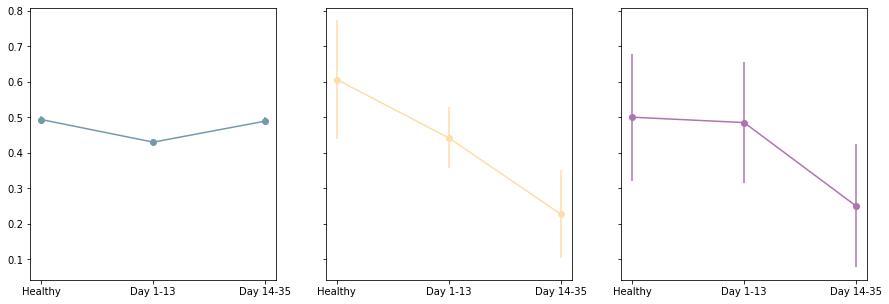

In [67]:
df.Period = df.Period.astype("category")
df.Period = df.Period.cat.reorder_categories(['Healthy', 'Day 1-13', 'Day 14-35'])
df['care'] = df.meanR_mvmtOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')

fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
Colors = CP('creType')
cond = ['MSN','PV','CHI']
for idx in range(0,3):
    df2 = df[df.CellType == cond[idx]].groupby('Period').mean()
    df2['mean'] = df[df.CellType == cond[idx]].groupby('Period').care.mean()
    df2['std']  = df[df.CellType == cond[idx]].groupby('Period').care.std()
    df2['count']  = df[df.CellType == cond[idx]].groupby('Period').meanR_mvmtOnset.count()
    df2['SEM'] = df2.apply(lambda x: 1.96*np.sqrt(x['mean']*(1-x['mean'])/x['count']),axis=1)
    df2 = df2.reset_index()
    ax[idx].errorbar(df2.Period, df2['mean'], yerr=df2.SEM, fmt='-o', color = Colors[cond[idx]])
    print(df2)
    del df2
fig.savefig(figFolder+'figure4c.svg',transparent=True)


/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/I

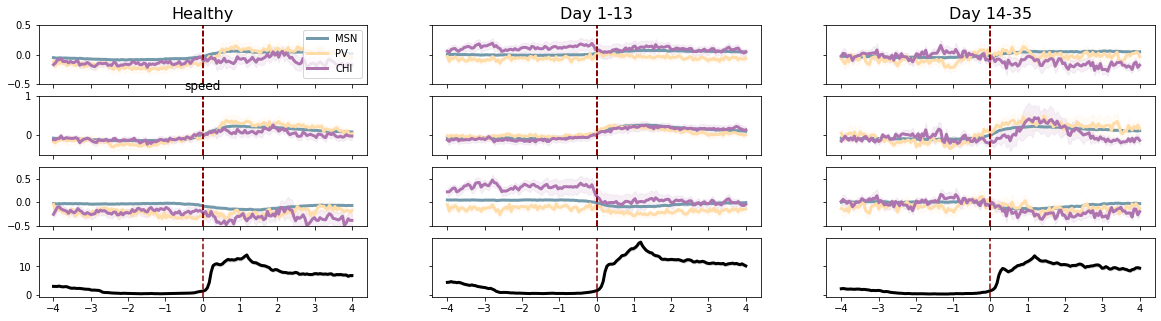

In [79]:
fig, ax = plt.subplots(4,3,figsize=(20, 5),sharex='col',sharey='row')
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Day 1-13':1,'Day 14-35':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in Period.keys():
    axInd = 0;
    for c in cond:
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['speed']['speed'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            sOnset = getOnsetOrPeriod(m,s,'Pre','mvmtOnset2')    
            if np.sum(sOnset) == 0:
                continue
            
            care = df[(df.Sess == s)&(df.CellType == c)].care
            care = care.astype(bool)
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            try:
                Zdff_care = Zdff[care,:]
                Zdff_ncare = Zdff[~care,:]
            except Exception as e:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                print(s,exc_tb.tb_lineno,care.shape,Zdff.shape)
                continue
            
            sA_care = alignToOnset(Zdff_care.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_care.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,sA_care.shape[1]))
                except:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,1))

            if len(sA_care.shape) > 2:
                sA_care = np.mean(sA_care,2)
                if 'sAligned_care' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_care = sA_care
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_care = np.concatenate((sAligned_care,sA_care),axis=1)
            
            sA_ncare = alignToOnset(Zdff_ncare.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_ncare.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,sA_ncare.shape[1]))
                except:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,1))

            if len(sA_ncare.shape) > 2:
                sA_ncare = np.mean(sA_ncare,2)
                if 'sAligned_ncare' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_ncare = sA_ncare
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_ncare = np.concatenate((sAligned_ncare,sA_ncare),axis=1)
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[1,Period[p]],sAligned_care,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[2,Period[p]],sAligned_ncare,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        if c== 'MSN':
            PlotRelativeToOnset(ax[3,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            del sAlignedS
        del sAligned
        del sAligned_care
        del sAligned_ncare
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
ax[0,0].set_ylim(-0.5,0.5)
ax[1,0].set_ylim(-0.5,1)
ax[2,0].set_ylim(-0.5,0.75)
ax[1,0].set_title('speed')

fig.savefig(figFolder+'figure 4a.svg',transparent=True)

In [80]:
f = h5py.File('membership.hdf5','r')
miceList = getMiceList(Files[1])
col_names = ['Sess','Mouse','Period','Day','CellType']
df = pd.DataFrame(columns=col_names)
for m in miceList:
    grp = f[m]
    sessions = list(grp.keys())
    for sess in sessions:
        try:
            data = grp[sess]['mvmtOnset']['result'].value
            meanR_mvmtOnset = np.mean(data,axis=1)
        except:
            print(sess,'mvmt')
            meanR_mvmtOnset = np.nan
            
        try:
            data = grp[sess]['rotOnset']['result'].value
            meanR_rotOnset = np.mean(data,axis=1)
        except:
            print(sess,'rot')
            meanR_rotOnset = np.nan
            
        try:
            data = grp[sess]['ipsiOnset']['result'].value
            meanR_ipsiOnset = np.mean(data,axis=1)
        except:
            print(sess,'ipsi')
            meanR_ipsiOnset = np.nan
            
        try:
            data = grp[sess]['contraOnset']['result'].value
            meanR_contraOnset = np.mean(data,axis=1)
        except:
            print(sess,'contra')
            meanR_contraOnset =np.nan
        
        if sess[5] == 'B':
                day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        cre = getCreType(Files[1],m)
        nRed = getNumRed(Files[1],m,sess[5:])
        try:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset,
                                'meanR_rotOnset':meanR_rotOnset,
                                'meanR_ipsiOnset':meanR_ipsiOnset,
                                'meanR_contraOnset':meanR_contraOnset})
        except:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset,
                                'meanR_rotOnset':meanR_rotOnset,
                                'meanR_ipsiOnset':meanR_ipsiOnset,
                                'meanR_contraOnset':meanR_contraOnset},index = [0])
        df2.loc[:nRed-1,'CellType'] = cre
        df = pd.concat([df,df2],sort=True)

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # Remove the CWD from sys.path while we load stuff.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


0761_day10 contra
0761_day12 contra
0761_day19L contra
0761_day2 contra
0761_day31A contra
0761_day35L mvmt
0761_day35L contra
0761_day6 contra
0761_day8 contra
1208_day15A contra
1208_day19L contra
1208_day2 contra
1208_day34L contra
1222_day11 ipsi
1222_day20L ipsi
1222_day36L contra
1222_day5 mvmt
1222_day5 ipsi
1231_BaselineL ipsi
1231_BaselineS ipsi
1236_day13 contra
1793_BaselineA contra
1793_day12 contra
1793_day14 contra
2976_BaselineA ipsi
2976_day14 contra
2976_day35L contra
2976_day8 rot
2976_day8 ipsi
2976_day8 contra
2980_day14 contra
2980_day15A ipsi
2980_day19L contra
2980_day8 contra
2981_day10 ipsi
2981_day12 ipsi
2981_day15A contra
2981_day2 ipsi
2981_day6 ipsi
2981_day8 ipsi
4539_BaselineA ipsi
4539_day1 rot
4539_day1 ipsi
4539_day1 contra
4539_day10 rot
4539_day10 ipsi
4539_day10 contra
4539_day11 rot
4539_day11 ipsi
4539_day11 contra
4539_day12 rot
4539_day12 ipsi
4539_day12 contra
4539_day13 rot
4539_day13 ipsi
4539_day13 contra
4539_day14 rot
4539_day14 ipsi
4539

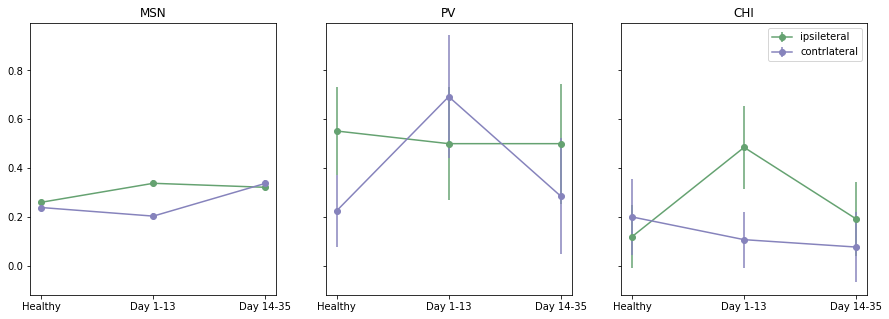

In [81]:
#period_rat
df['care'] = df.meanR_mvmtOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')
df['care_ipsi'] = df.meanR_ipsiOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')
df['care_contra'] = df.meanR_contraOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')
df['care_rot'] = df.meanR_rotOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')

# df_secound = df.copy()

df.Period = df.Period.astype("category")
df.Period = df.Period.cat.reorder_categories(['Healthy', 'Day 1-13', 'Day 14-35'])

colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)


fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
Colors = CP('creType')
cond = ['MSN','PV','CHI']
for idx in range(0,3):
    df2 = df[df.CellType == cond[idx]].groupby('Period').mean()
    #df2['Period'] = df[df.CellType == cond[idx]].Period.unique()
    df2['mean'] = df[df.CellType == cond[idx]].groupby('Period').care_ipsi.mean()
    df2['std']  = df[df.CellType == cond[idx]].groupby('Period').care_ipsi.std()
    df2['count']  = df[df.CellType == cond[idx]].groupby('Period').meanR_ipsiOnset.count()
    df2['SEM'] = df2.apply(lambda x: 1.96*np.sqrt(x['mean']*(1-x['mean'])/x['count']),axis=1)
    df2 = df2.reset_index()

    ax[idx].errorbar(df2.Period, df2['mean'], yerr=df2.SEM, fmt='-o',label="ipsileteral", color = colorsH[3])
    
    del df2
    df2 = df[df.CellType == cond[idx]].groupby('Period').mean()
    #df2['Period'] = df[df.CellType == cond[idx]].groupby('Period').Period.unique()
    df2['mean'] = df[df.CellType == cond[idx]].groupby('Period').care_contra.mean()
    df2['std']  = df[df.CellType == cond[idx]].groupby('Period').care_contra.std()
    df2['count']  = df[df.CellType == cond[idx]].groupby('Period').meanR_contraOnset.count()
    df2['SEM'] = df2.apply(lambda x: 1.96*np.sqrt(x['mean']*(1-x['mean'])/x['count']),axis=1)
    df2 = df2.reset_index()
    
    ax[idx].errorbar(df2.Period, df2['mean'], yerr=df2.SEM, fmt='-o',label="contrlateral",color = colorsH2[3])    
    ax[idx].set_title(cond[idx])
#     print(df2)
    del df2
ax[2].legend()
# fig.savefig(figFolder+'figure4d.svg',transparent=True)


In [82]:
# %matplotlib notebook
N = 2
df4 = pd.DataFrame(columns = ['mvmt','CellType','Period','oddsRatio','pValue_corrected'])
for sig in ['care','care_ipsi','care_contra','care_rot']:
    for cell in df.CellType.unique():
        df3 = df[(df.CellType ==cell)]
        dfHealthy = df3[df3.Period == 'Healthy']
        yesVals = []
        noValse = []
        for period in df3.Period.unique():
            dfComp = df3[df3.Period == period]
            print(sig,cell,period)
            oddsratio, pvalue = sci.stats.fisher_exact([[dfHealthy[dfHealthy[sig] == True][sig].count(), dfHealthy[dfHealthy[sig] == False][sig].count()], [dfComp[dfComp[sig] == True][sig].count(), dfComp[dfComp[sig] == False][sig].count()]])
            print(pvalue, pvalue<0.05/(N))
            df4 = df4.append({'mvmt':sig,'CellType':cell,
                              'Period':period,'oddsRatio':oddsratio,
                              'pValue_corrected':pvalue*(N-1),
                              'healthy_all':dfHealthy[sig].count(),
                              'healthy_care':dfHealthy[dfHealthy[sig] == True][sig].count(),
                              'healthy_ratio':dfHealthy[dfHealthy[sig] == True][sig].count()/dfHealthy[sig].count(),
                              'period_all':dfComp[sig].count(),'period_care':dfComp[dfComp[sig] == True][sig].count(),
                              'period_ratio':dfComp[dfComp[sig] == True][sig].count()/dfComp[sig].count()},ignore_index = True)

df4.to_csv(figFolder+'supplemntalTable1.csv')


care CHI Healthy
1.0 False
care CHI Day 1-13
1.0 False
care CHI Day 14-35
0.09227859342247277 False
care MSN Healthy
1.0 False
care MSN Day 1-13
3.592773833430999e-21 True
care MSN Day 14-35
0.5600154580051093 False
care PV Healthy
1.0 False
care PV Day 1-13
0.11824943349601218 False
care PV Day 14-35
0.0009886421054767197 True
care_ipsi CHI Healthy
1.0 False
care_ipsi CHI Day 1-13
0.004500987918350652 True
care_ipsi CHI Day 14-35
0.703001768083122 False
care_ipsi MSN Healthy
1.0 False
care_ipsi MSN Day 1-13
1.5767541308179358e-22 True
care_ipsi MSN Day 14-35
3.3772521793828074e-17 True
care_ipsi PV Healthy
1.0 False
care_ipsi PV Day 1-13
0.7712121055411523 False
care_ipsi PV Day 14-35
0.7648772773285651 False
care_contra CHI Healthy
1.0 False
care_contra CHI Day 1-13
0.4527357309844863 False
care_contra CHI Day 14-35
0.6425881874798267 False
care_contra MSN Healthy
1.0 False
care_contra MSN Day 1-13
1.6123846294825179e-06 True
care_contra MSN Day 14-35
6.800189656416103e-38 True
care_

/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/I

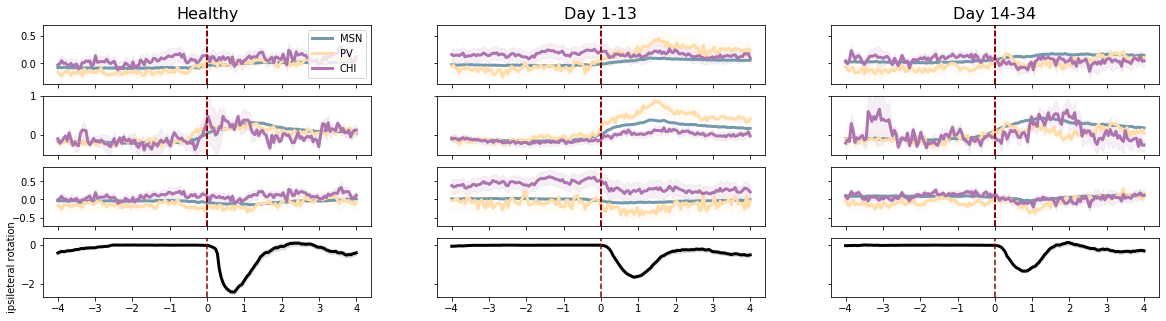

In [91]:
# Put stats abouve this cell
fig, ax = plt.subplots(4,3,figsize=(20, 5),sharex='col',sharey='row')
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Day 1-13':1,'Day 14-34':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in Period.keys():
    axInd = 0;
    for c in cond:
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['rot']['rot'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            sOnset = getOnsetOrPeriod(m,s,'Pre','antiClockWiseOnset2')   
            if np.sum(sOnset) == 0:
                continue
            
            care = df[(df.Sess == s)&(df.CellType == c)].care_ipsi
            care = care.astype(bool)
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            try:
                Zdff_care = Zdff[care,:]
                Zdff_ncare = Zdff[~care,:]
            except:
                print(s)
                continue
            
            sA_care = alignToOnset(Zdff_care.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_care.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,sA_care.shape[1]))
                except:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,1))

            if len(sA_care.shape) > 2:
                sA_care = np.mean(sA_care,2)
                if 'sAligned_care' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_care = sA_care
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_care = np.concatenate((sAligned_care,sA_care),axis=1)
            
            sA_ncare = alignToOnset(Zdff_ncare.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_ncare.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,sA_ncare.shape[1]))
                except:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,1))

            if len(sA_ncare.shape) > 2:
                sA_ncare = np.mean(sA_ncare,2)
                if 'sAligned_ncare' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_ncare = sA_ncare
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_ncare = np.concatenate((sAligned_ncare,sA_ncare),axis=1)
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[1,Period[p]],sAligned_care,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[2,Period[p]],sAligned_ncare,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        if c== 'MSN':
            PlotRelativeToOnset(ax[3,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            del sAlignedS
        del sAligned
        del sAligned_care
        del sAligned_ncare
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
#ax[0,0].set_ylim(-0.5,0.5)
ax[1,0].set_ylim(-0.5,1)
#ax[2,0].set_ylim(-0.5,0.75)
ax[3,0].set_ylabel('ipsileteral rotation')



#  sOnset2 = getOnsetOrPeriod(m,s,'Pre','clockWiseOnset')        


#fig2.savefig(figFolder+'figure4_cells_aligned_to_ipsiRotation_hist.svg',transparent=True)
fig.savefig(figFolder+'figure4b_ipsi.svg',transparent=True)

# #fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')


/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/I

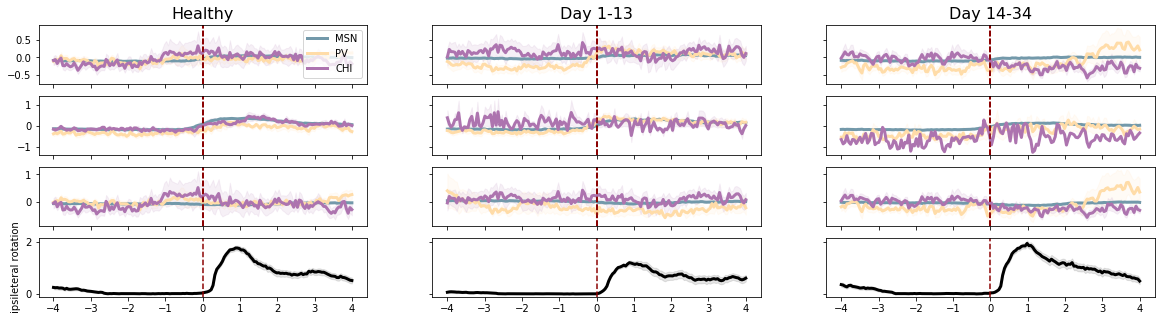

In [93]:
fig, ax = plt.subplots(4,3,figsize=(20, 5),sharex='col',sharey='row')
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Day 1-13':1,'Day 14-34':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #4s
PostS = 80 # 4s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in Period.keys():
    axInd = 0;
    for c in cond:
        if p=='One Month' and c == 'CHI':
            continue #there are not enough mice
        
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['rot']['rot'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            sOnset =  getOnsetOrPeriod(m,s,'Pre','clockWiseOnset2') 
            if np.sum(sOnset) == 0:
                continue
            
            care = df[(df.Sess == s)&(df.CellType == c)].care_contra
            care = care.astype(bool)
            
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            try:
                Zdff_care = Zdff[care,:]
                Zdff_ncare = Zdff[~care,:]
            except:
                print(s)
                continue
            
            sA_care = alignToOnset(Zdff_care.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_care.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,sA_care.shape[1]))
                except:
                    sA_care = np.reshape(sA_care,(sA_care.shape[0],1,1))

            if len(sA_care.shape) > 2:
                sA_care = np.mean(sA_care,2)
                if 'sAligned_care' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_care = sA_care
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_care = np.concatenate((sAligned_care,sA_care),axis=1)
            
            sA_ncare = alignToOnset(Zdff_ncare.T, sOnset, winPost=PostS,winPre=preS)  
            if Zdff_ncare.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,sA_ncare.shape[1]))
                except:
                    sA_ncare = np.reshape(sA_ncare,(sA_ncare.shape[0],1,1))

            if len(sA_ncare.shape) > 2:
                sA_ncare = np.mean(sA_ncare,2)
                if 'sAligned_ncare' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned_ncare = sA_ncare
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned_ncare = np.concatenate((sAligned_ncare,sA_ncare),axis=1)
      
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[1,Period[p]],sAligned_care,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        PlotRelativeToOnset(ax[2,Period[p]],sAligned_ncare,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        if c== 'MSN':
            PlotRelativeToOnset(ax[3,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            del sAlignedS
        del sAligned
        del sAligned_care
        del sAligned_ncare
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
# ax[0,0].set_ylim(-0.75,0.5)
# ax[1,0].set_ylim(-1,1.2)
# ax[2,0].set_ylim(-0.75,1)
ax[3,0].set_ylabel('ipsileteral rotation')
       


#fig2.savefig(figFolder+'figure4_cells_aligned_to_ipsiRotation_hist.svg',transparent=True)
fig.savefig(figFolder+'figure4b_contra.svg',transparent=True)

# #fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')


/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/ssd_2TB/6OHDA/I

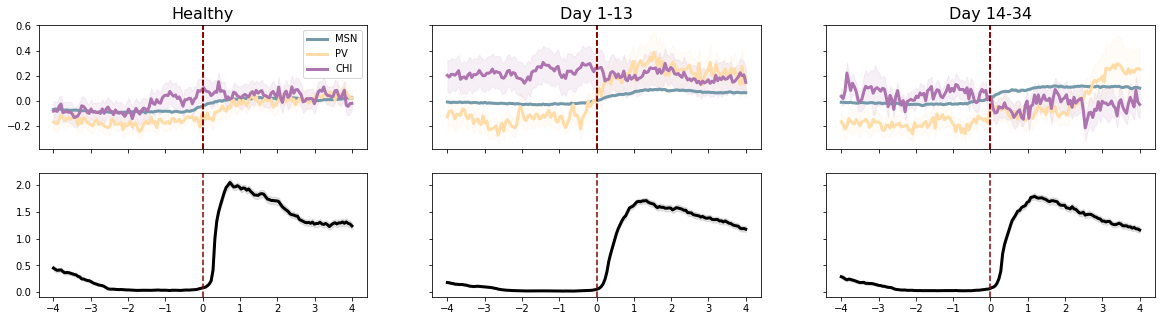

In [11]:
fig, ax = plt.subplots(2,3,figsize=(20, 5),sharex='col',sharey='row')
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['MSN','PV','CHI']
Period = {'Healthy':0,'Day 1-13':1,'Day 14-34':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #4s
PostS = 80 # 4s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in Period.keys():
    axInd = 0;
    for c in cond:
        if p=='One Month' and c == 'CHI':
            continue #there are not enough mice
        
        data = eval(c+str(Period[p]))
        for s in data.keys():
            m = s[:4]
            speed = data[s]['rot']['rot'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
            mu = np.mean(dff,axis=1)
            std = np.std(dff,axis=1)
            Zdff = (dff.T-mu.T)/std.T
            Zdff = Zdff.T  

            cOnset =  getOnsetOrPeriod(m,s,'Pre','clockWiseOnset2') 
            acOnset = getOnsetOrPeriod(m,s,'Pre','antiClockWiseOnset2')  
            sOnset = cOnset+acOnset
            if np.sum(sOnset) == 0:
                continue
                       
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dff.shape[0] ==1 and np.sum(sOnset)>0:

                try:
                    sA = np.reshape(sA,(sA.shape[0],1,sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1,1))

            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)

            if c == 'MSN':
                    sS = alignToOnset(np.abs(speed), sOnset, winPost=PostS,winPre=preS)
                    if sS.ndim > 1:
                        if 'sAlignedS' not in locals():
            #           print(s+' :',sA.shape)
                            sAlignedS = sS
                        else:
        #                print(s+' :',cAs.shape,caAlignedS.shape)
                            sAlignedS = np.concatenate((sAlignedS,sS),axis=1) 
            
     
        PlotRelativeToOnset(ax[0,Period[p]],sAligned,tPlot,Color=Colors[c],Label=c,mesErr=True) 
        if c== 'MSN':
            PlotRelativeToOnset(ax[1,Period[p]],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
            del sAlignedS
        del sAligned
    ax[0,Period[p]].set_title(p,fontsize=16)
#    ax[0,Period[p]].legend(fontsize=10)
ax[0,0].legend(fontsize=10)
# ax[0,0].set_ylim(-0.75,0.5)
# ax[1,0].set_ylim(-1,1.2)
# ax[2,0].set_ylim(-0.75,1)
# ax[3,0].set_ylabel('ipsileteral rotation')
       


#fig2.savefig(figFolder+'figure4_cells_aligned_to_ipsiRotation_hist.svg',transparent=True)
fig.savefig(figFolder+'figure4b_totRot.svg',transparent=True)

# #fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')


<h3> Figure 5 </h3>

In [ ]:
# look at individual CHI/PV
f = h5py.File('/home/dana_z/HD1/connactivityAnalysis/connMaps2.hdf5','a')
numshifts = 1000
for m in tqdm(miceList):
    grp = f.create_group(m)
    data =  getData(Files[1],['trace'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess in grp.keys():
            continue
        subgrp = grp.create_group(sess)
        
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred']) 
        
        subgrp.attrs['numRed'] = numRed
        subgrp.attrs['day'] = day
        subgrp.attrs['period'] = periodCalc(day)

        try:  
            Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')            
            cor = np.dot(Ca ,Ca.T)/np.sum(Ca,axis=1) # Do the actual co-occorence matrix not np.corrcoef(Ca)
            cor2 = np.corrcoef(Ca)
            dff = data[sess]['trace']['dff']        
            cor3 = np.corrcoef(dff)

            ssubgrp = subgrp.create_group('Pre')
            ssubgrp['aSymCorr'] = cor
            ssubgrp['pearson'] = cor2
            ssubgrp['pearsonF'] = cor3

            sCor = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor2 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor3 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            for s in range(0,numshifts):
                shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                Ca2 = circShiftRoll(shifts,Ca)
                dff2 = circShiftRoll(shifts,dff)
                sCor2[:,:,s] = np.corrcoef(Ca2)
                sCor[:,:,s] = np.dot(Ca2 ,Ca2.T)/np.sum(Ca2,axis=1)
                sCor3[:,:,s] = np.corrcoef(dff2)
            ssubgrp['aSymCorr_shuffle'] = sCor
            ssubgrp['pearson_shuffle'] = sCor2
            ssubgrp['pearsonF_shuffle'] = sCor3
            del sCor
            del sCor2
            del sCor3
        except:
            print(sess)
f.close()

In [100]:
# only run once... Also, only Asymm 
f = h5py.File('/home/dana_z/HD1/connactivityAnalysis/connMaps2.hdf5','r')
col_names = ['Mouse','Sess','Day','numred','Period','population','personF','sPersonF','aSymCorr','sASymCorr']
df3 = pd.DataFrame(columns = ['Mouse','Sess','Day','numred','Period','population','mvmt','values'])
df = pd.DataFrame(columns = col_names)
for m in f.keys():
    for sess in f[m].keys():
        try:
            numred = f[m][sess].attrs['numRed']
            cre = getCreType(Files[1],m)
            tempDict = {'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
                                'numred':numred,'Period':periodCalc(f[m][sess].attrs['day'])}

            c = f[m][sess]['Pre']['pearson'].value 
            c[np.tril(c,-1)==0] = np.nan

            d = f[m][sess]['Pre'][('pearson_shuffle')].value
            b = np.nanpercentile(d,[97.5,2.5],axis=2)

            d = np.nanmean(d,axis=2)
            d[np.tril(d,-1)==0] = np.nan

            nSig = (c>b[0,:,:])|(c<b[1,:,:])
            cSig = np.copy(c)
            cSig[nSig] = np.nan
            noSig = np.copy(c)
            noSig[~nSig] = np.nan

            if numRed > 1:
                tempDict['population'] = cre+'-'+cre
                tempDict['aSymCorr'] = np.nanmean(c[:numred,:numred])
                tempDict['sASymCorr'] = np.nanmean(d[:numred,:numred])
                tempDict['aSymCorrSig'] = np.nanmean(cSig[:numred,:numred])
                tempDict['aSymCorrNotSig'] = np.nanmean(noSig[:numred,:numred])
                tempDict['sigPercent'] = np.nansum(nSig[:numred,:numred]==1)/np.nansum(np.isnan(c[:numred,:numred])==0)
                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
            if numRed > 0:
                tempDict['population'] = 'MSN-'+cre
                tempDict['aSymCorr'] = np.nanmean(c[numred:,:numred])
                tempDict['sASymCorr'] = np.nanmean(d[numred:,:numred])
                tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,:numred])
                tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,:numred])
                tempDict['sigPercent'] = np.nansum(nSig[numred:,:numred]==1)/np.nansum(np.isnan(c[numred:,:numred])==0)
                
                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
                hi,bi = np.histogram(c[numred:,:numred],np.arange(-1,1,0.01))
                hi2,bi2 = np.histogram(cSig[numred:,:numred],np.arange(-1,1,0.01))
                df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
                                'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
                                  'population':'MSN-'+cre,'mvmt':'all','values':hi,'values_sig':hi2},ignore_index=True)


            tempDict['population'] = 'MSN-MSN'
            tempDict['aSymCorr'] = np.nanmean(c[numred:,numred:])
            tempDict['sASymCorr'] = np.nanmean(d[numred:,numred:])
            tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,numred:])
            tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,numred:])
            tempDict['sigPercent'] = np.nansum(nSig[numred:,numred:]==1)/np.nansum(np.isnan(c[numred:,numred:])==0)
            df2 = pd.DataFrame([tempDict])
            df = pd.concat([df,df2],sort=True)
            hi,bi = np.histogram(c[numred:,numred:],np.arange(-1,1,0.01))
            hi2,bi2 = np.histogram(cSig[numred:,numred:],np.arange(-1,1,0.01))
            df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
                            'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
                              'population':'MSN-MSN','mvmt':'all','values':hi,'values_sig':hi2},ignore_index=True)

        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,  exc_tb.tb_lineno,c.shape)
f.close()
df.to_csv(figFolder+'bySessCompareCorr2Sig.csv')
df3.to_csv(figFolder+'bySessCompareCorr2Sig_hists.csv')

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_lau

1222_day2 15 ()


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


2980_BaselineS (169,)
(146, 146)
2980_day30A (133,)
(116, 116)


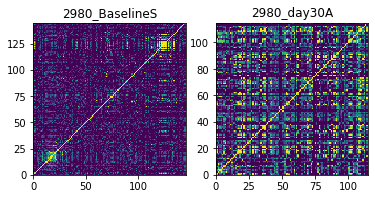

In [56]:
m = '2980'
sessions = ['2980_BaselineS','2980_day30A']
f = h5py.File('/home/dana_z/HD1/connactivityAnalysis/connMaps2.hdf5','r')
ind = 0
fig, ax = plt.subplots(1,2)
for sess in sessions:    
    if f[m][sess].attrs['day'] in [0,30,31,32,34,35,36]:
        c = f[m][sess]['Pre']['pearson'].value 
        a = ~np.isnan(c).all(axis=0)
        print(sess,a.shape)
        c = c[a,:][:,a]
        print(c.shape)
#         print(sess,c.shape)
#         c = c[~np.isnan(c).all(axis=0)]
# #         c = c[~np.isnan(c).any(axis=0)]
#         print(sess,c.shape)
        CS = ax[ind].pcolormesh(np.arange(c.shape[0]),np.arange(c.shape[1]),c.T,
                                vmax=.4, vmin = 0,rasterized = True)
        ax[ind].set_title(sess)
        ax[ind].set_aspect('equal')
        ind = ind+1
f.close()
# fig.colorbar(CS)
fig.savefig(figFolder+'figure4_example_nocolorBar.svg',transparent=True)

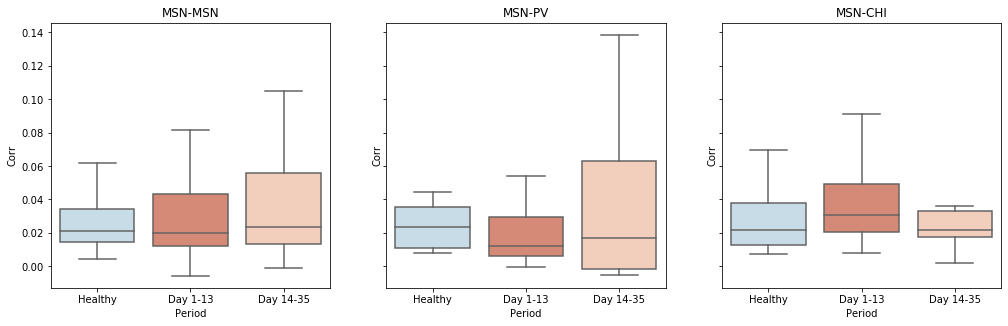

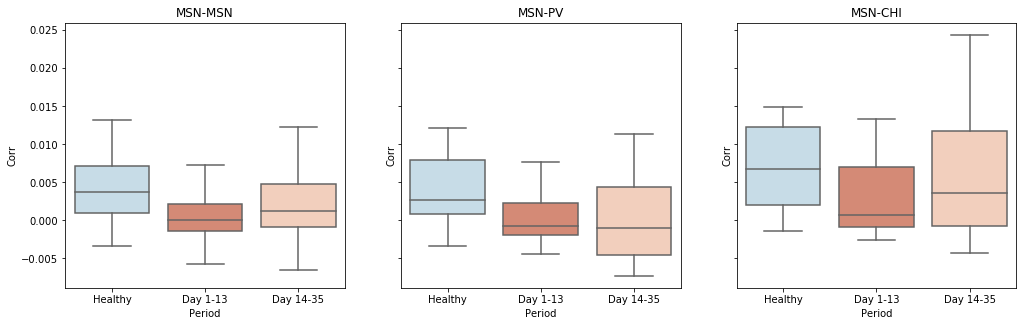

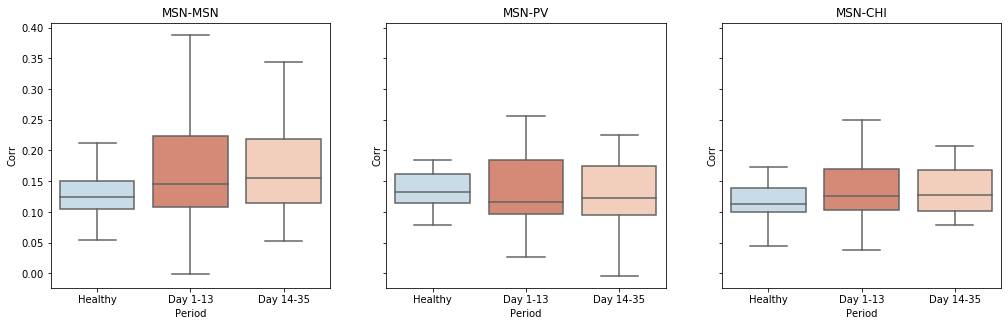

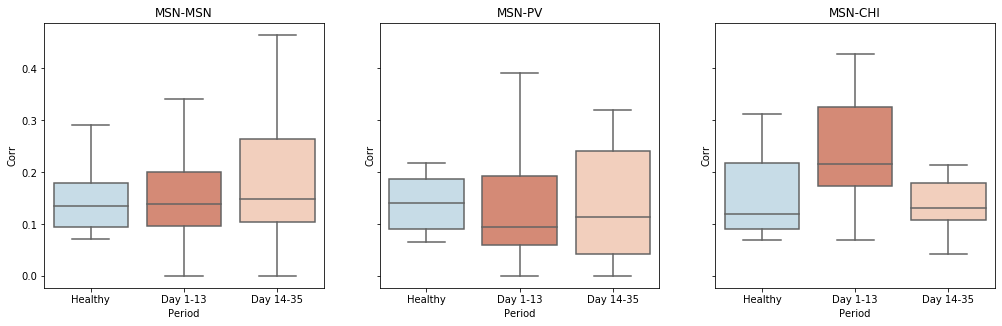

In [102]:


df = pd.read_csv(figFolder+ 'bySessCompareCorr2Sig.csv')

df2 = df.melt(id_vars = ['Mouse','Sess','Period','population'],value_vars=["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"],
                         var_name='varType', value_name='Corr')#.groupby(['Period','Sess','population','varType']).mean()
df2.reset_index(inplace=True)


for col in ["aSymCorr","aSymCorrSig",'aSymCorrNotSig',"sigPercent"]:
    fig, ax = plt.subplots(1,3,figsize=(17.04,4.88), sharey=True)
    with sns.color_palette(colorPallet3):
        g = sns.boxplot(x="Period", y="Corr", ax = ax[0], data=df2[(df2.population=='MSN-MSN')&(df2.varType==col)],
                        order = ['Healthy', 'Day 1-13', 'Day 14-35'],showfliers=False)
        ax[0].set_title('MSN-MSN')
        g = sns.boxplot(x="Period", y="Corr", ax = ax[1], data=df2[(df2.population=='MSN-PV')&(df2.varType==col)],
                        order =  ['Healthy', 'Day 1-13', 'Day 14-35'],showfliers=False)
        ax[1].set_title('MSN-PV')
        g = sns.boxplot(x="Period", y="Corr", ax = ax[2], data=df2[(df2.population=='MSN-CHI')&(df2.varType==col)],
                        order =  ['Healthy', 'Day 1-13', 'Day 14-35'],showfliers=False)
        ax[2].set_title('MSN-CHI')
    #g = sns.boxplot(x="Period", y="Corr", hue="varType", data=df2[(df2.population=='MSN-MSN')&(df2.varType=='personF')], order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'])
#     ax[0].set_ylim(-0.01,0.25)
    fig.savefig(figFolder+'figure5a_'+col+'_nofliers.svg',transparent=True)


In [ ]:
# Recalculate the LFP align to MSN onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = '/home/dana_z/HD1/lfp2ca_notNormalize/'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','trace'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred'])


        if os.path.exists(savePath+'MSN/'+sess):
            df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre,'numred':numRed},ignore_index=True)
            continue

        # get data
        Ca = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')
        dCa = np.append(Ca[:,1:]-Ca[:,:-1],np.zeros((Ca.shape[0],1)),axis=1)
        dCa[dCa==-1] = 0
        
        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre,'numred':numRed,'numMsn':Ca.shape[0]},ignore_index=True)

        dtS = float(1/data[sess]['trace']['FS'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        

        # for every Cre neuron:
        dca = dCa[0:numRed,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for creN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            cN = dca[creN,:]
            for si in ts[cN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. CRE#',creN,' in sess= ',sess)
                    continue
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"CRE/"+sess, "wb" ), protocol=4 )
            del aligned
        
        # for every MSN neuron:
        dca = dCa[numRed:,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for msnN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            mN = dca[msnN,:]
            for si in ts[mN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. MSN#',msnN,' in sess= ',sess)
                    continue
            
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"MSN/"+sess, "wb" ) , protocol=4)
            del aligned

df.to_csv(savePath+'sessions')


In [194]:
# Recalculate the LFP align to MSN onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = '/home/dana_z/HD1/lfp2ca_notNormalize/Post/'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','trace'],period ='Post', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred'])

        if sess[-1] == 'A':
            drug = 'Amph'
        elif sess[-1]=='L':
            drug  = 'L-Dopa'
        else:
            drug = 'Saline'

        if os.path.exists(savePath+'MSN/'+sess):
            df.append({'mouse':m,'sess':sess,'day':day,'drug':drug,
                       'period': periodCalc(day),'cre':cre,'numred':numRed},ignore_index=True)
            continue

        # get data
        Ca = getOnsetOrPeriod(m,sess,'Post','caOnset_Hf')
        dCa = np.append(Ca[:,1:]-Ca[:,:-1],np.zeros((Ca.shape[0],1)),axis=1)
        dCa[dCa==-1] = 0
        
        coeff = np.abs(f[m][sess]['Post']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['trace']['FS'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['trace']['dff'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        

        # for every Cre neuron:
        dca = dCa[0:numRed,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for creN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            cN = dca[creN,:]
            for si in ts[cN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. CRE#',creN,' in sess= ',sess)
                    continue
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"CRE/"+sess, "wb" ), protocol=4 )
            del aligned
        
        # for every MSN neuron:
        dca = dCa[numRed:,:]
        dca = dca[np.sum(dca,axis=1)!=0,:]
        
        for msnN in range(0,np.min(dca.shape)):
            onsetL = np.full_like(tl,False)
            mN = dca[msnN,:]
            for si in ts[mN.astype(bool)]:
                ti = np.argmin(np.abs(tl-si))
                onsetL[ti] = True
            al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

            if al.ndim <3:
                try:
                    al = np.reshape(al,(al.shape[0],al.shape[1],1))
                except:
                    print('no onset, when there should be. MSN#',msnN,' in sess= ',sess)
                    continue
            
            al = np.nanmean(al,axis=2,keepdims=True)
            al = np.nan_to_num(al,nan=-9999)
            if 'aligned' in locals():
                aligned = np.concatenate((aligned,al), axis = 2)
            else:
                aligned = al
        
        if np.min(dca.shape)>0:
            pickle.dump( aligned, open( savePath+"MSN/"+sess, "wb" ) , protocol=4)
            del aligned
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'drug':drug,
                       'period': periodCalc(day),'cre':cre,'numred':numRed,'numMsn':Ca.shape[0]},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 0761_day1
I deleted session: 0761_day10
I deleted session: 0761_day12
I deleted session: 0761_day2
I deleted session: 0761_day4
I deleted session: 0761_day6
I deleted session: 0761_day8
cleaning up lfp data


  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1208_day10
I deleted session: 1208_day12
I deleted session: 1208_day14
I deleted session: 1208_day2
I deleted session: 1208_day4
I deleted session: 1208_day6
I deleted session: 1208_day8
cleaning up lfp data


 57%|█████▋    | 4/7 [14:27<09:12, 184.04s/it]

found  3.0  outlier points


 86%|████████▌ | 6/7 [17:33<02:14, 134.54s/it]

found  2.0  outlier points


  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day3
I deleted session: 1222_day5
I deleted session: 1222_day7
I deleted session: 1222_day9
cleaning up lfp data


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1236_day1
I deleted session: 1236_day11
I deleted session: 1236_day13
I deleted session: 1236_day3
I deleted session: 1236_day5
I deleted session: 1236_day7
I deleted session: 1236_day9
cleaning up lfp data
found  34.0  outlier points


 71%|███████▏  | 5/7 [04:32<01:48, 54.05s/it]

found  927582.0  outlier points


 86%|████████▌ | 6/7 [05:56<01:03, 63.01s/it]

found  447664.0  outlier points


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up trace data
cleaning up lfp data


  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 1793_day10
I deleted session: 1793_day12
I deleted session: 1793_day14
I deleted session: 1793_day2
I deleted session: 1793_day4
I deleted session: 1793_day6
I deleted session: 1793_day8
cleaning up lfp data


  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2976_day10
I deleted session: 2976_day12
I deleted session: 2976_day14
I deleted session: 2976_day2
I deleted session: 2976_day4
I deleted session: 2976_day6
I deleted session: 2976_day8
cleaning up lfp data


  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2980_day10
I deleted session: 2980_day12
I deleted session: 2980_day14
I deleted session: 2980_day2
I deleted session: 2980_day4
I deleted session: 2980_day6
I deleted session: 2980_day8
cleaning up lfp data


 43%|████▎     | 3/7 [03:42<04:29, 67.42s/it]

found  144.0  outlier points


  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 2981_day10
I deleted session: 2981_day12
I deleted session: 2981_day14
I deleted session: 2981_day2
I deleted session: 2981_day4
I deleted session: 2981_day6
I deleted session: 2981_day8
cleaning up lfp data


 43%|████▎     | 3/7 [03:19<04:09, 62.40s/it]

found  105.0  outlier points


  0%|          | 0/4 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 7909_day0
I deleted session: 7909_day1
I deleted session: 7909_day10
I deleted session: 7909_day11
I deleted session: 7909_day12
I deleted session: 7909_day13
I deleted session: 7909_day14
I deleted session: 7909_day2
I deleted session: 7909_day3
I deleted session: 7909_day4
I deleted session: 7909_day5
I deleted session: 7909_day6
I deleted session: 7909_day7
I deleted session: 7909_day8
I deleted session: 7909_day9
cleaning up lfp data
found  10.0  outlier points


  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8430_day1
I deleted session: 8430_day11
I deleted session: 8430_day3
I deleted session: 8430_day5
I deleted session: 8430_day7
I deleted session: 8430_day9
cleaning up lfp data


  0%|          | 0/6 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day14
I deleted session: 8803_day2
I deleted session: 8803_day4
I deleted session: 8803_day5
I deleted session: 8803_day6
I deleted session: 8803_day8
cleaning up lfp data


  0%|          | 0/7 [00:00<?, ?it/s]

cleaning up trace data
I deleted session: 8815_day10
I deleted session: 8815_day12
I deleted session: 8815_day14
I deleted session: 8815_day2
I deleted session: 8815_day4
I deleted session: 8815_day6
I deleted session: 8815_day8
cleaning up lfp data


100%|██████████| 7/7 [04:51<00:00, 41.61s/it]


In [ ]:
# Recalculate the LFP align to mvmt onset  
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = '/home/dana_z/HD1/lfp2speed2/'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','speed'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])


        # get data
        sOnset = getOnsetOrPeriod(m,sess,'Pre','mvmtOnset2')
        
        if np.sum(sOnset)==0:
            continue

        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['speed']['Fs'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        
        # for every speed onset:
        
        onsetL = np.full_like(tl,False)
        for si in ts[sOnset.astype(bool)]:
            ti = np.argmin(np.abs(tl-si))
            onsetL[ti] = True
        al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

        if al.ndim <3:
            try:
                al = np.reshape(al,(al.shape[0],al.shape[1],1))
            except:
                print('no onset, when there should be. in sess= ',sess)
                continue

        #al = np.nanmean(al,axis=2,keepdims=True)
        al = np.nan_to_num(al,nan=-9999)
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al

        if np.sum(sOnset)>0:
            pickle.dump( aligned, open( savePath+sess, "wb" ) , protocol=4)
            del aligned
         
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre},ignore_index=True)

df.to_csv(savePath+'sessions')


In [30]:
# plot LFP aligned to MSN
%matplotlib inline
periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}
df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/sessions')
savePath = '/home/dana_z/HD1/lfp2ca_notNormalize/'
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
f.close()
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    if period != 'Day 14-35':
        continue
    try:
        A = pickle.load(open(savePath+'MSN/'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)

        fig, ax = plt.subplots()
        CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =0.6,vmin=-0.2)
        fig.colorbar(CS)
#         ax.set_title(per,fontsize=20)
    #    fig.savefig(figFolder+'figure5b_MSN_'+per+'.png',format='png')
        fig.savefig(figFolder+'individual_Sess/'+sess+'.png',format='png',transparent=True)
        fig.clf()
        plt.close(fig)
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)



/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # Remove the CWD from sys.path while we load stuff.


In [31]:
df

Unnamed: 0  mouse            sess  day     period  cre  numred  numMsn
0             0    761  0761_BaselineA    0    Healthy  CHI       1      27
1             1    761  0761_BaselineL    0    Healthy  CHI       1      32
2             2    761  0761_BaselineS    0    Healthy  CHI       1      33
3             4    761      0761_day10   10   Day 5-12  CHI       1      22
4             5    761      0761_day12   12   Day 5-12  CHI       0      11
..          ...    ...             ...  ...        ...  ...     ...     ...
204         205   8815       8815_day2    2    Day 1-4  CHI       0      19
205         206   8815     8815_day30A   30  One Month  CHI       2     108
206         207   8815     8815_day34L   34  One Month  CHI       1      82
207         208   8815       8815_day4    4    Day 1-4  CHI       3      88
208         209   8815       8815_day8    8   Day 5-12  CHI       3     181

[209 rows x 8 columns]

In [195]:
# plot Get statistics for Gamma Power
df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/Post/sessions')
savePath = '/home/dana_z/HD1/lfp2ca_notNormalize/Post/'
Pdf = pd.DataFrame(columns = ['Mouse','Period','Sess','CellType'])
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta_10to15':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8),'beta3':(freq >= 15) & (freq<18),
         'beta4':(freq >= 20) & (freq<25)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = df[df.sess==sess].cre.values[0]
    drug = df[df.sess==sess].drug.values[0]
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'CRE/'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - CRE failed at line ",  exc_tb.tb_lineno)
            
    cellType = 'MSN'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType,'drug':drug}
        A = pickle.load(open(savePath+'MSN/'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
        
        #jumpBackhere
    except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

Pdf.to_csv(figFolder+'statsForPowerPost.csv')

0761_BaselineL  - CRE failed at line  21
0761_day14A  - CRE failed at line  21
0761_day14A  - MSN failed at line  59
0761_day31A  - CRE failed at line  21
1208_BaselineA  - CRE failed at line  21
1208_day19L  - CRE failed at line  21
1222_BaselineA  - CRE failed at line  21
1222_BaselineL  - CRE failed at line  21
1222_BaselineS  - CRE failed at line  21
1222_day15A  - CRE failed at line  21
1222_day20L  - CRE failed at line  21
1222_day32A  - CRE failed at line  21
1222_day32A  - MSN failed at line  59
1222_day36L  - CRE failed at line  21
1236_BaselineA  - CRE failed at line  21
1236_BaselineL  - CRE failed at line  21
1236_day19L  - CRE failed at line  21
1253_BaselineA  - CRE failed at line  21
1253_BaselineS  - CRE failed at line  21
1793_BaselineA  - CRE failed at line  21
1793_day19L  - CRE failed at line  21
1793_day30A  - CRE failed at line  21
1793_day34L  - CRE failed at line  21
2976_BaselineA  - CRE failed at line  21
2976_BaselineL  - CRE failed at line  21
2976_BaselineS

In [200]:
Pdf = pd.read_csv(figFolder+'statsForPowerPost.csv')
for cell in Pdf.CellType.unique():
    dfA = Pdf[(Pdf.CellType == cell)&(Pdf.drug == 'Amph')]
    dfL = Pdf[(Pdf.CellType == cell)&(Pdf.drug == 'L-Dopa')]
    Fa,Pa = sci.stats.mannwhitneyu(dfA[dfA.Period == 'Healthy'].high_Gamma,dfA[dfA.Period == 'Day 14-35'].high_Gamma)
    Fl,Pl = sci.stats.mannwhitneyu(dfL[dfL.Period == 'Healthy'].high_Gamma,dfL[dfL.Period == 'Day 14-35'].high_Gamma)
    print(cell,' - Amphatamine: ', Pa)
    print(cell,' - L-Dopa: ', Pl)
# Pdf.dtypes

CHI  - Amphatamine:  0.5
CHI  - L-Dopa:  0.1956336396413197
MSN  - Amphatamine:  0.17026563377142767
MSN  - L-Dopa:  0.2751067774726903
PV  - Amphatamine:  0.39209561470080956
PV  - L-Dopa:  0.36183680491588155


<IPython.core.display.Javascript object>


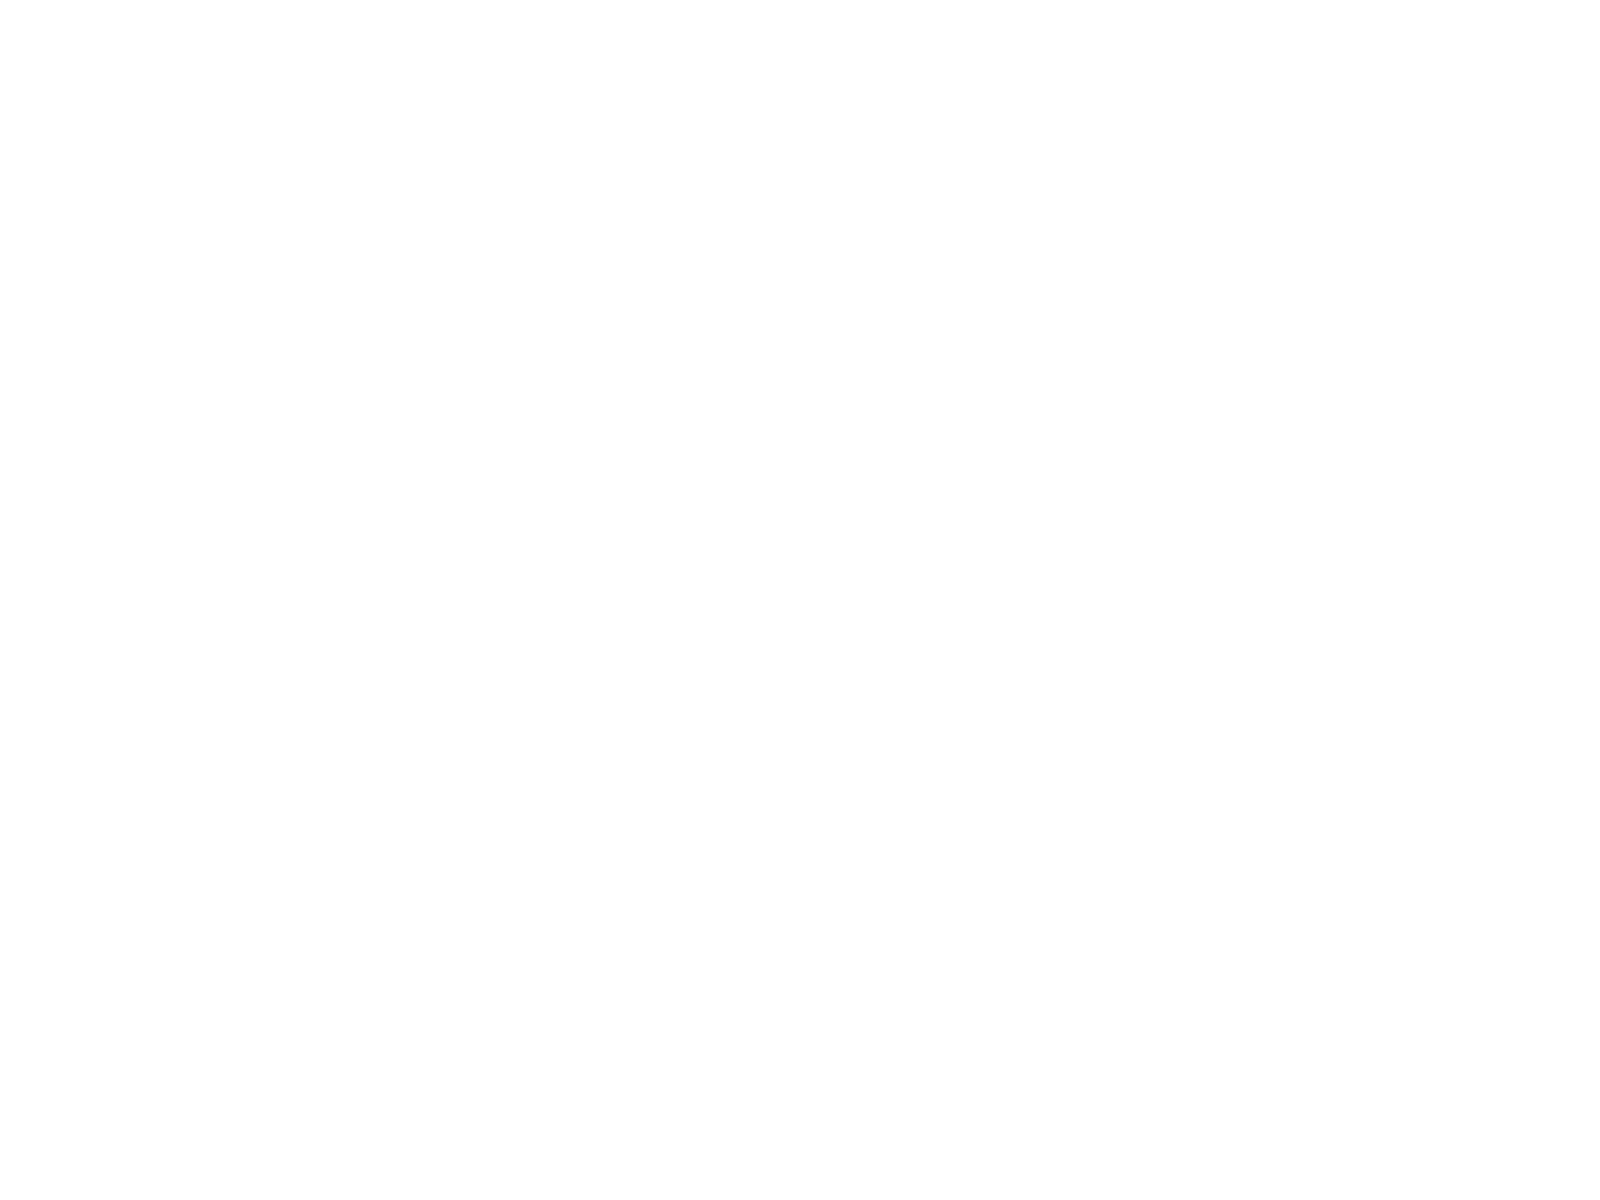

<IPython.core.display.Javascript object>


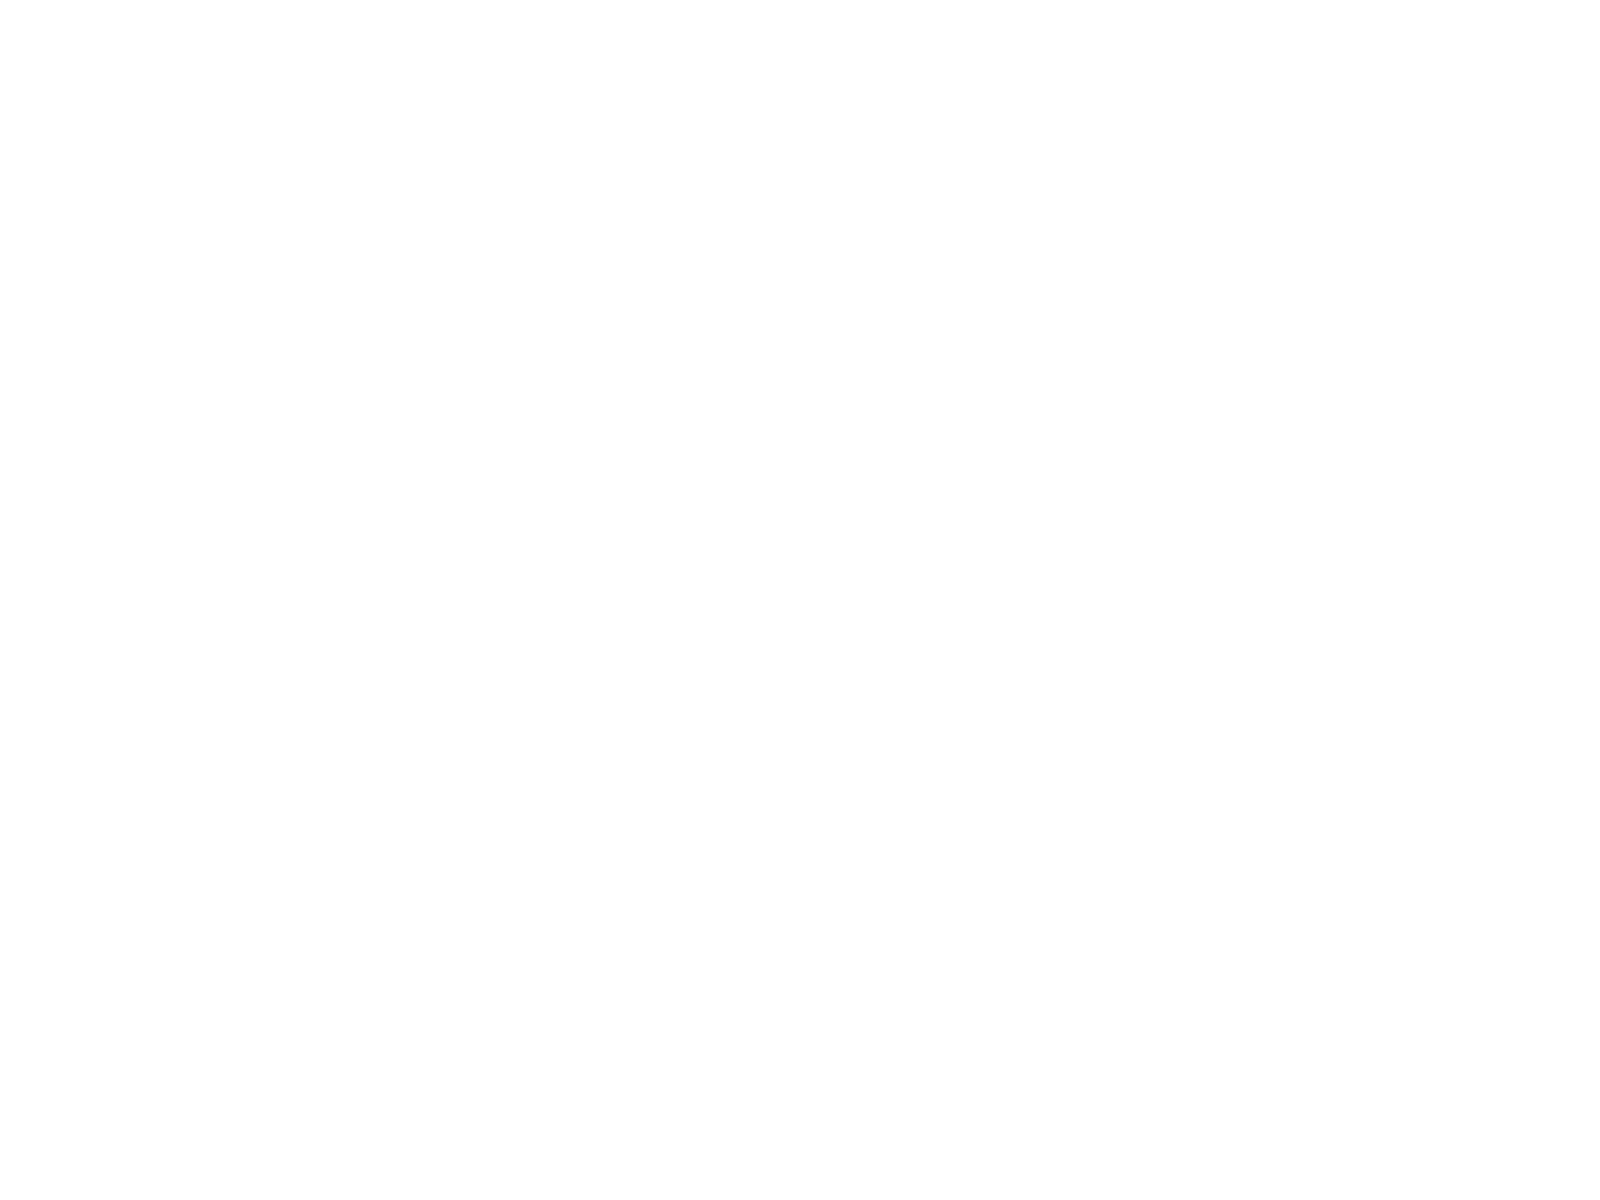

<IPython.core.display.Javascript object>


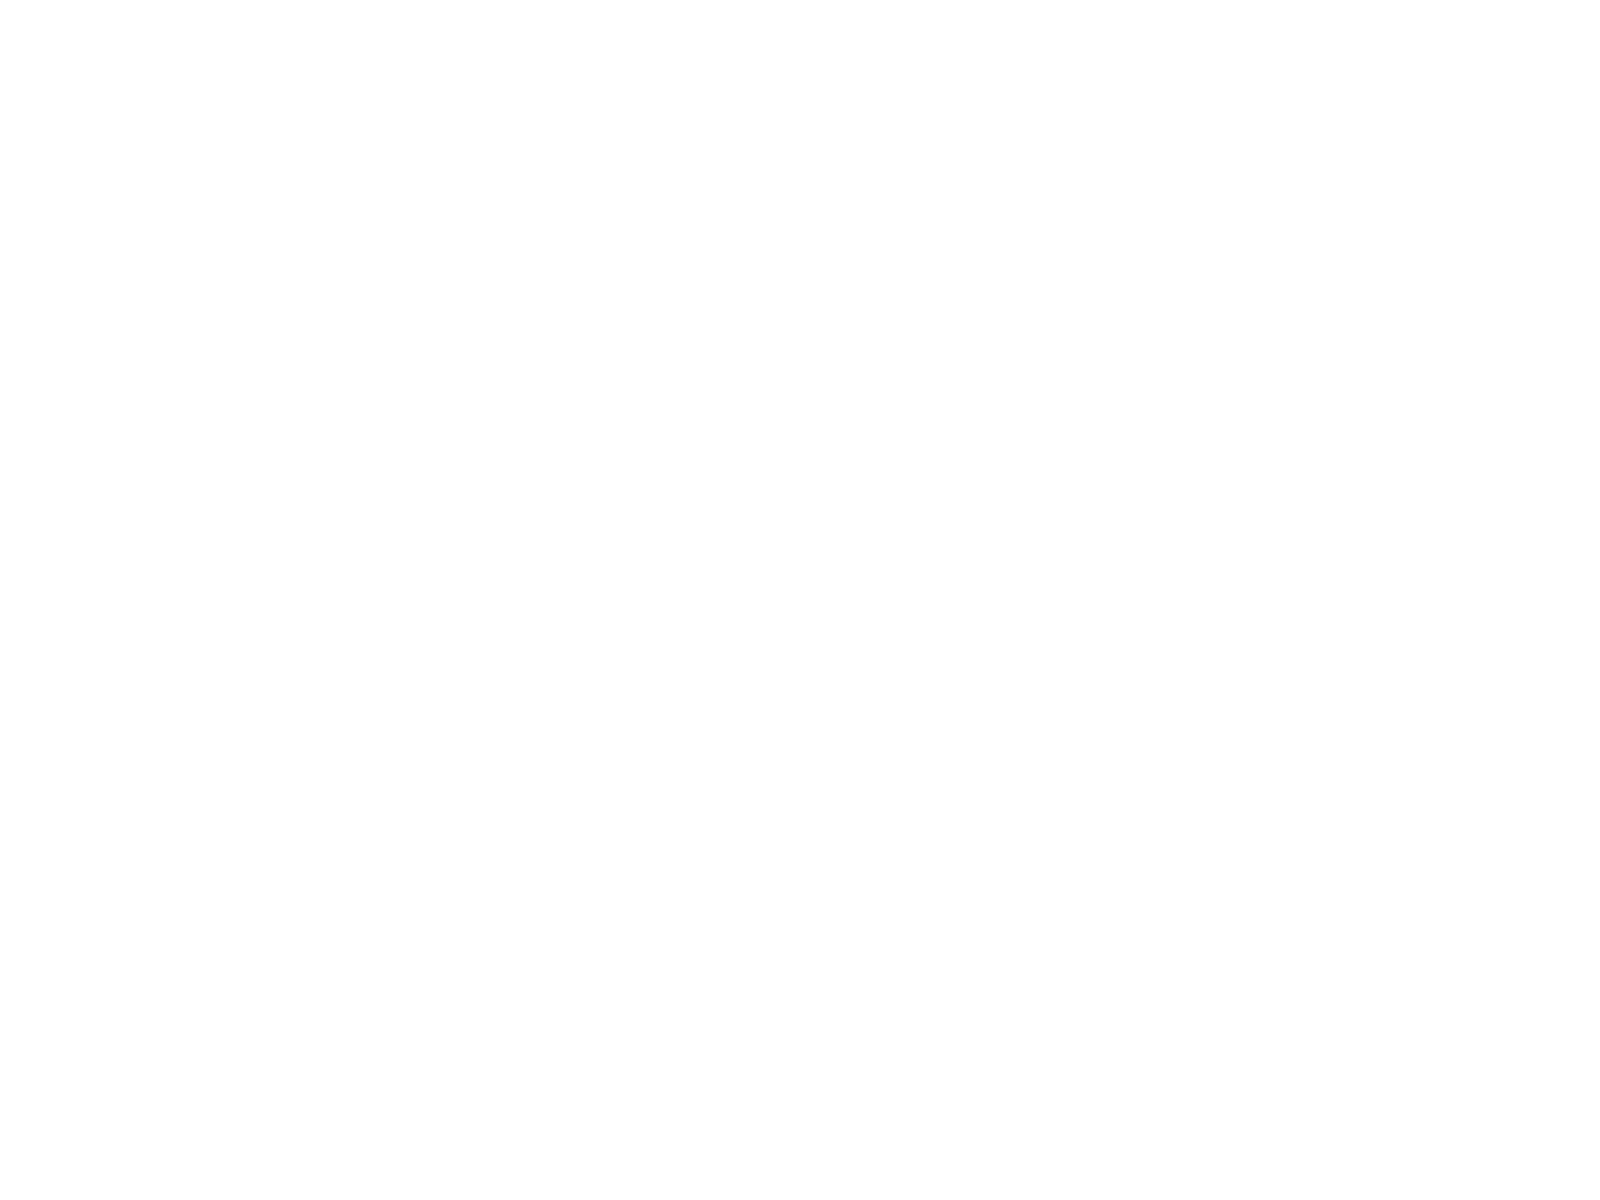

<IPython.core.display.Javascript object>


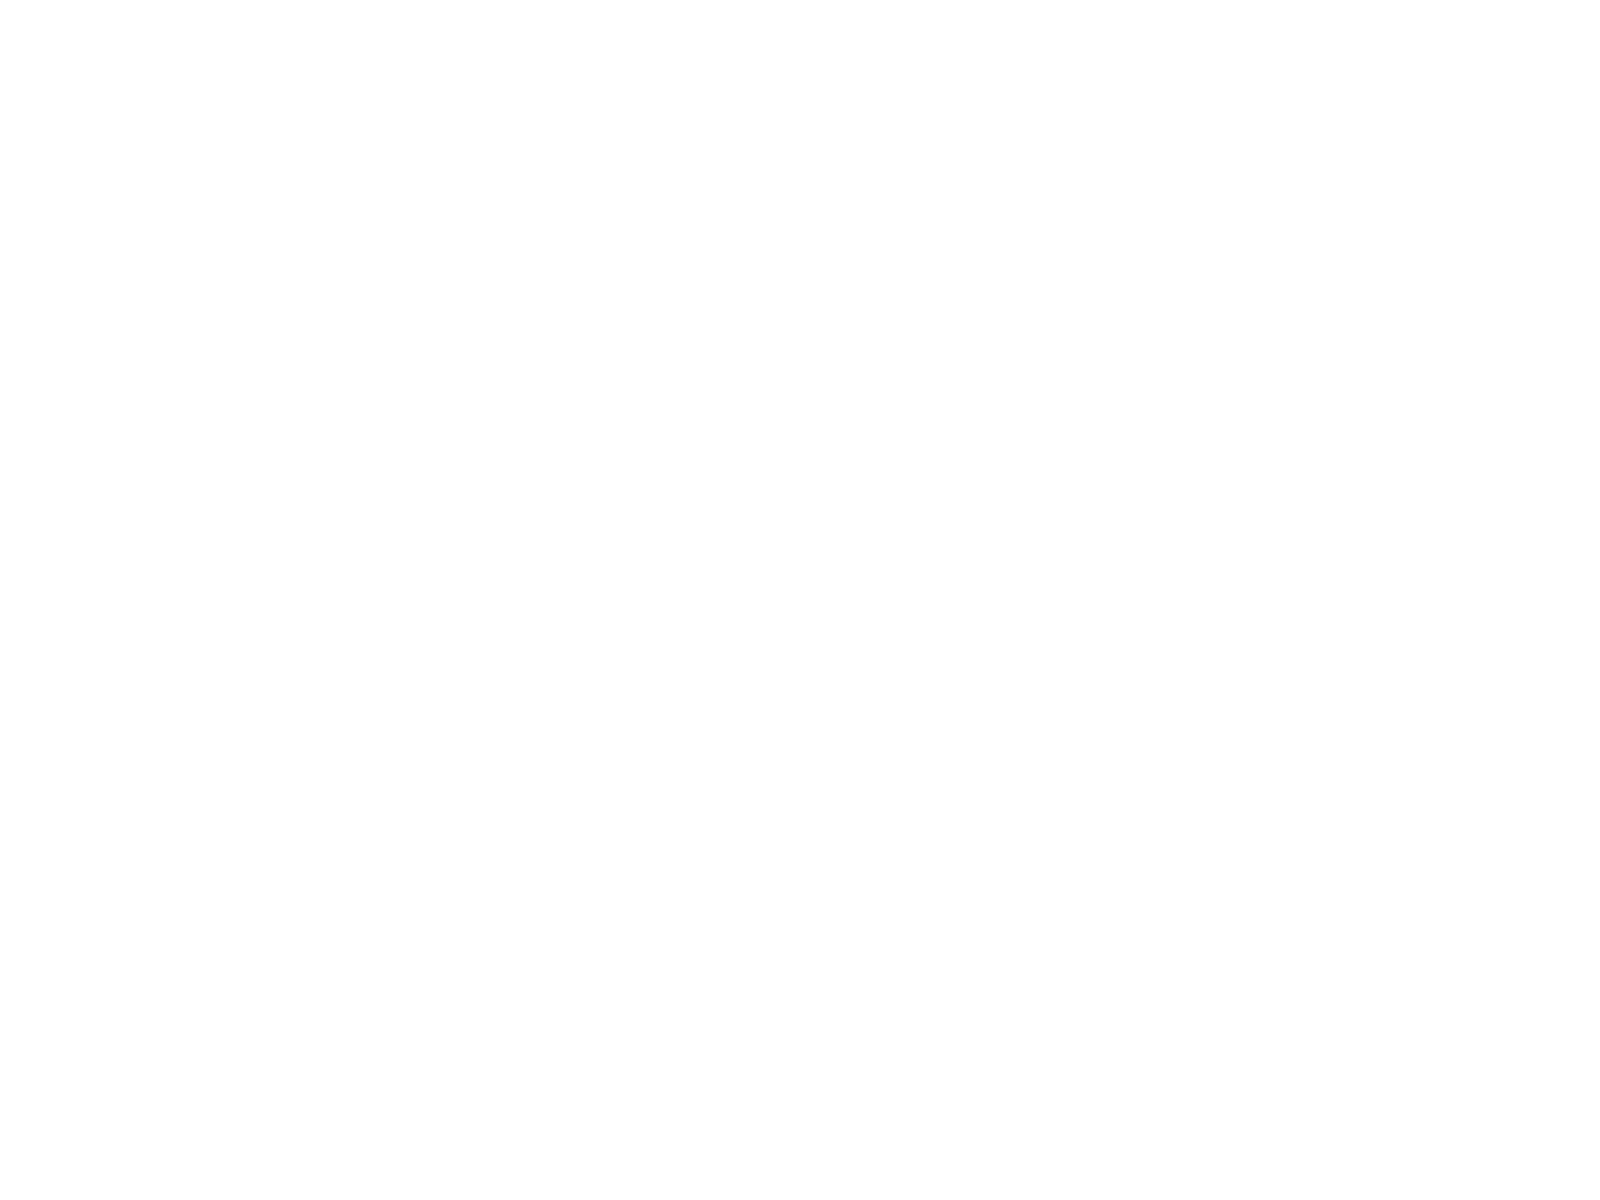

<IPython.core.display.Javascript object>


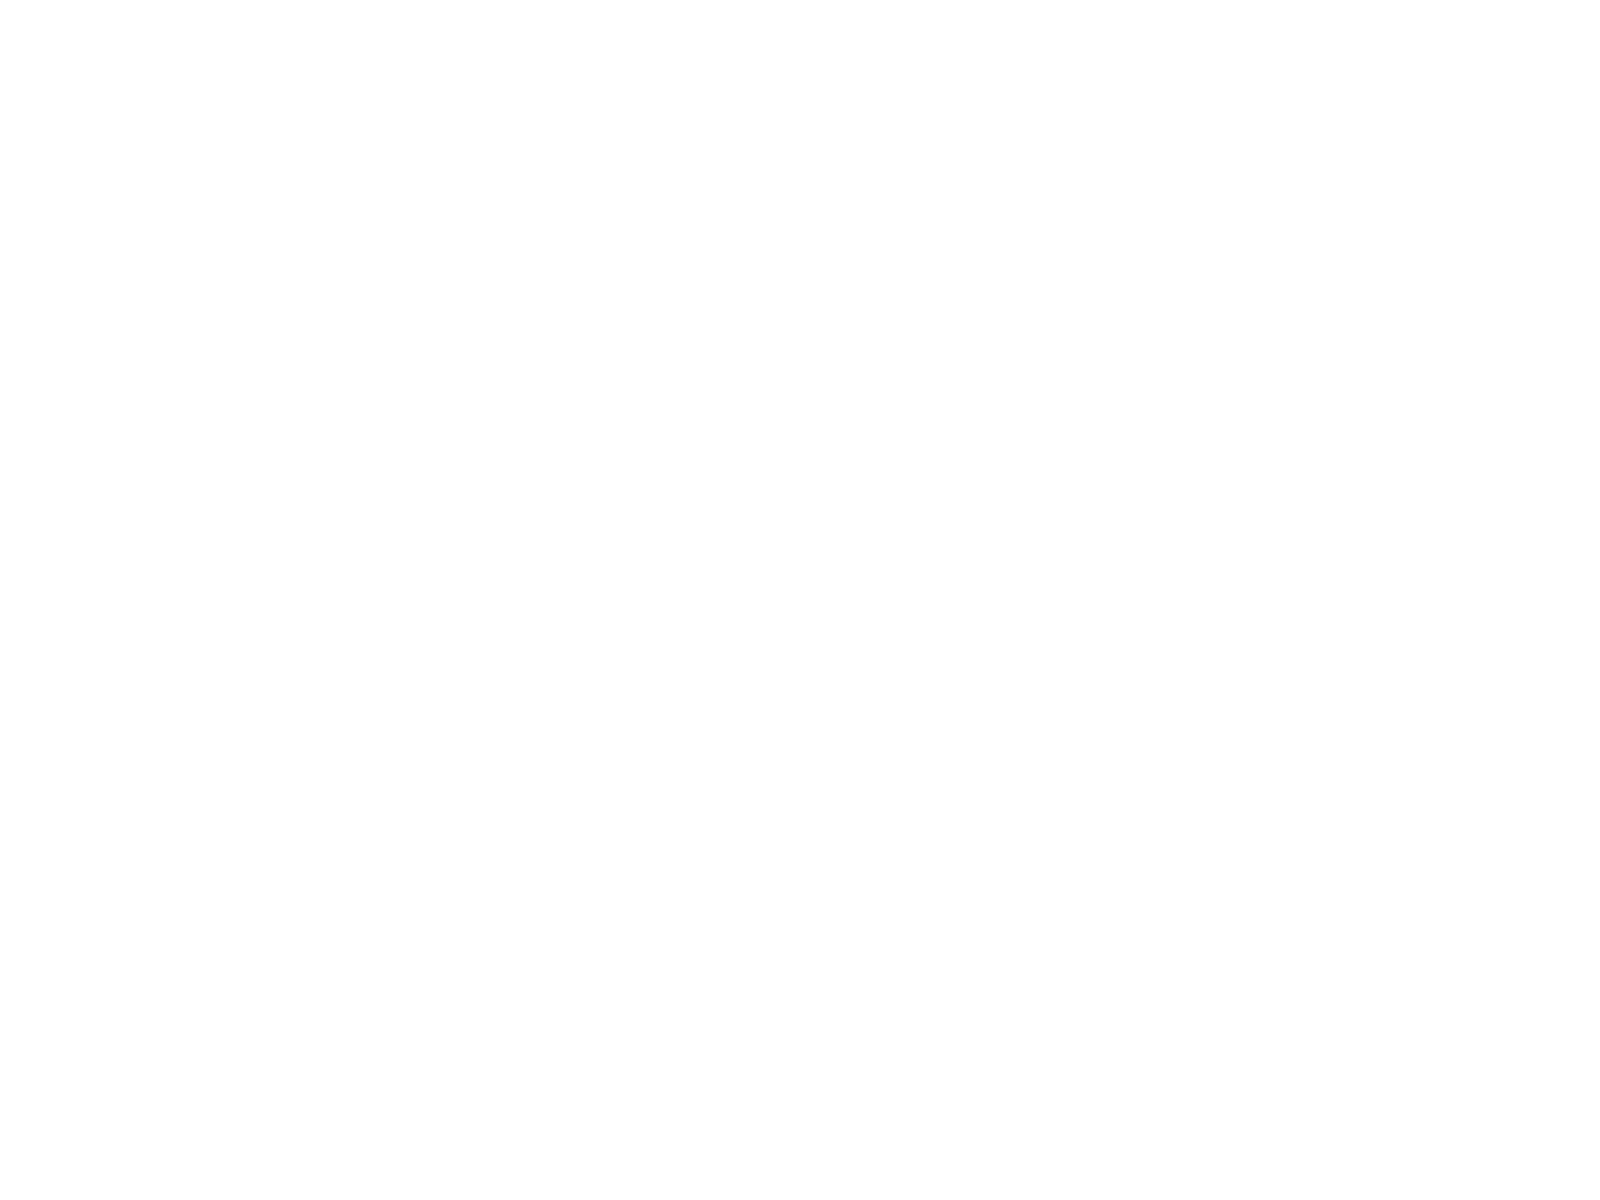

<IPython.core.display.Javascript object>


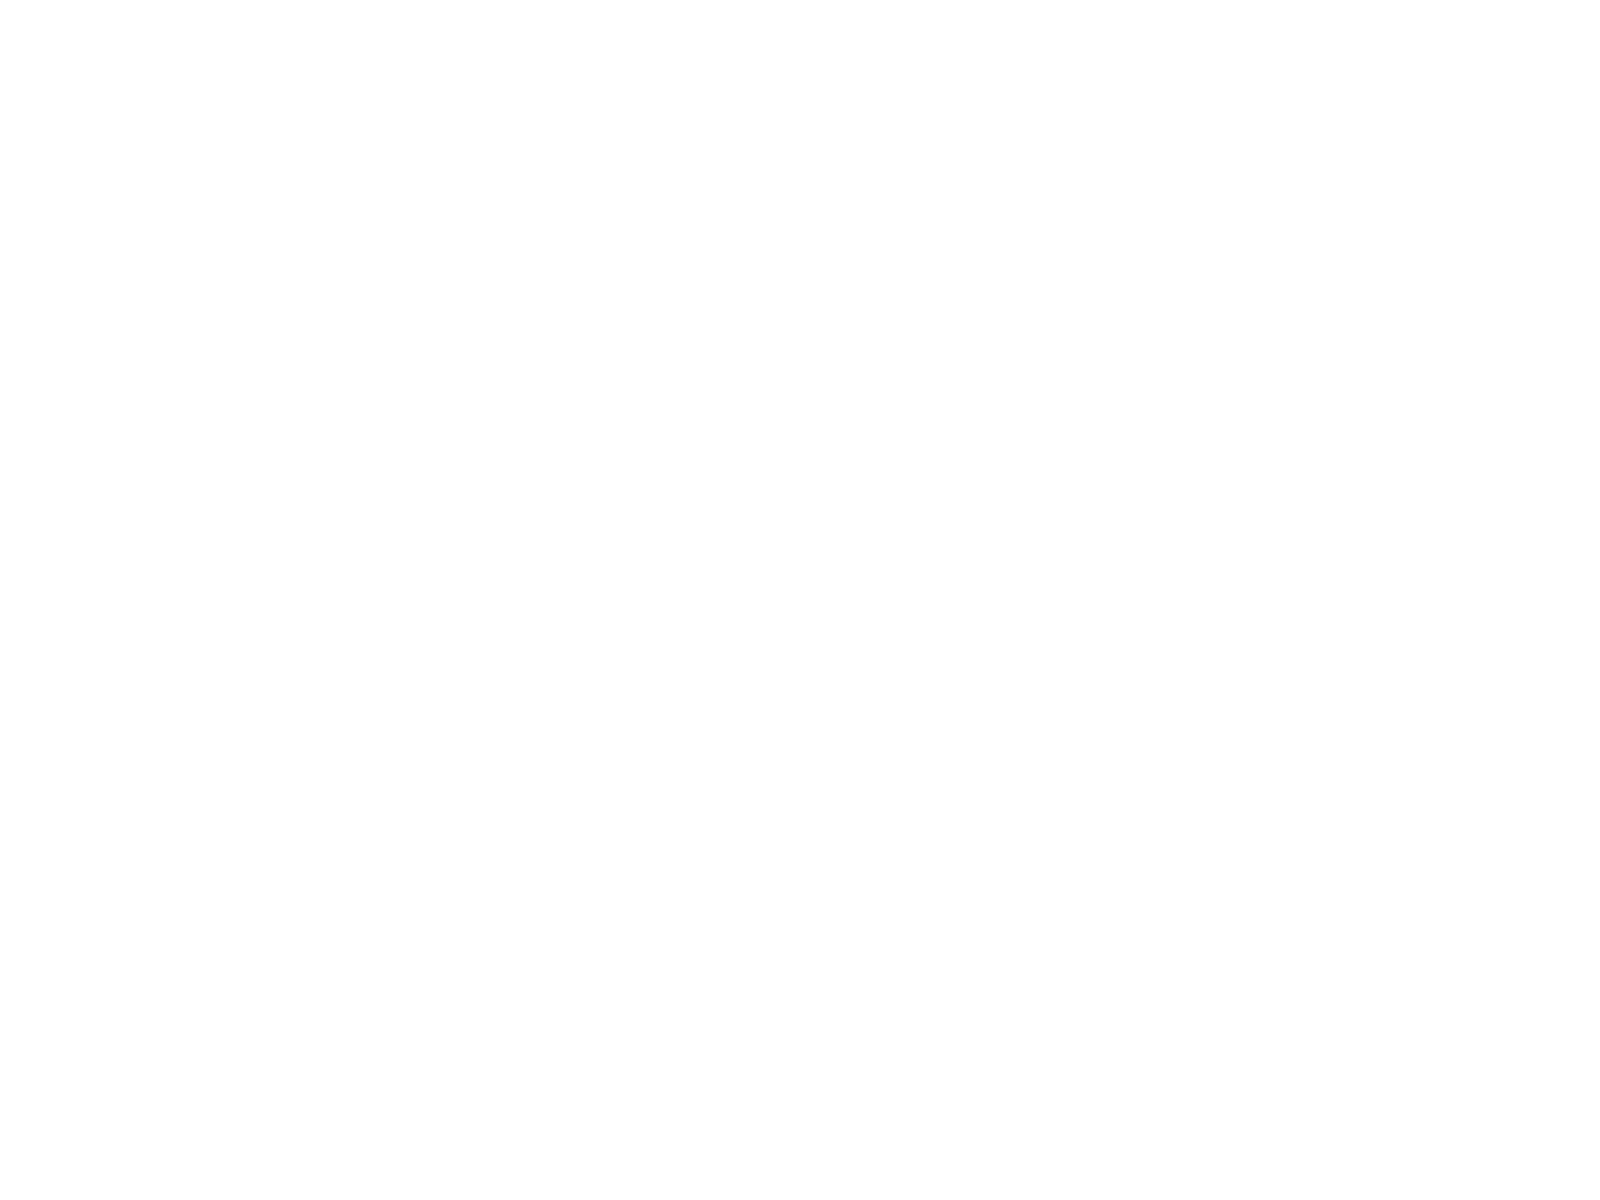

In [207]:
periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}

df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/Post/sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
# for per in periods.keys():
#     cellType = 'MSN'
#     cre = None
#     A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per],drugPeriod = 'Post',drug = 'Amph')
#     b = np.nanmean(A,axis=2)
#     del A
#     fig, ax = plt.subplots()
#     CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
#     fig.colorbar(CS)
#     ax.set_title(per,fontsize=20)
# #     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
#     fig.savefig(figFolder+'figure5b_MSN_Mouse_post_Amph'+per+'.svg',format='svg',transparent=True)
#     fig.clf()
#     plt.close(fig)
    
# for per in periods.keys():
#     cellType = 'MSN'
#     cre = None
#     A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per],drugPeriod = 'Post',drug = 'L-Dopa')
#     b = np.nanmean(A,axis=2)
#     del A
#     fig, ax = plt.subplots()
#     CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
#     fig.colorbar(CS)
#     ax.set_title(per,fontsize=20)
# #     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
#     fig.savefig(figFolder+'figure5b_MSN_Mouse_post_Ldopa'+per+'.svg',format='svg',transparent=True)
#     fig.clf()
#     plt.close(fig)

# for per in periods.keys():
#     cellType = 'CRE'
#     cre = 'CHI'
#     A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per],period = 'Post')
#     b = np.nanmean(A,axis=2)
#     del A
#     fig, ax = plt.subplots()
#     CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
#     fig.colorbar(CS)
#     ax.set_title(per,fontsize=20)
# #     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
#     fig.savefig(figFolder+'figure5b_CHI_Mouse'+per+'.svg',format='svg',transparent=True)
#     fig.clf()
#     plt.close(fig)

for per in periods.keys():
    cellType = 'CRE'
    cre = 'PV'
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per],drugPeriod = 'Post',drug = 'L-Dopa')
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.65,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_PV_Mouse_post_Ldopa'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)
    
for per in periods.keys():
    cellType = 'CRE'
    cre = 'PV'
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per],drugPeriod = 'Post',drug = 'Amph')
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.65,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_PV_Mouse_post_Amph'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)

    
    
# savePath = '/home/dana_z/HD1/lfp2speed2/'
# for per in periods.keys():
#     A,df2 = getAlignedLFP_mvmt2(savePath, day =periods[per])
#     b = np.nanmean(A,axis=2)
#     del A
#     fig, ax = plt.subplots()
#     CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
#     fig.colorbar(CS)
#     ax.set_title(per,fontsize=20)
# #     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
#     fig.savefig(figFolder+'figure5b_speedOnset_Mouse'+per+'.svg',format='svg',transparent=True)
#     fig.clf()
#     plt.close(fig)



In [103]:
Pdf = pd.read_csv(figFolder+'statsForPower.csv')

periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}

df = pd.read_csv('/home/dana_z/HD1/lfp2speed2/sessions')
savePath = '/home/dana_z/HD1/lfp2speed2/'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
fr = {'high_Gamma':freq >= 60, 'low_Gamma':(freq >= 40) & (freq<60), 'high_Beta_15to20':(freq >= 15) & (freq<20),
         'Beta_10to15':(freq >= 10) & (freq<15),'theta':(freq >= 6) & (freq<8)}
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
t200 = (tPlot >0) & (tPlot<0.2)
for sess in df.sess.unique():
    m = sess[:4]
    period = periodCalc(df[df.sess==sess].day.values)
    cellType = 'mvmt'
    try: 
        tDict = {'Mouse':m,'Period':period,'Sess':sess,'CellType':cellType}#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
#     else:
        A = pickle.load(open(savePath+'/'+sess,'rb'))
        A[A==9999] = np.nan
        A[A==-9999] = np.nan
        
        if A.shape[2] > 1000:
            b = A[:,:,0:1000]
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nansum(b,axis=2)
            for ind in range(0,A.shape[2]//1000):
                c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
                mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
                Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
                c =(c-mu)/Std
                c = np.nansum(c,axis=2)
                b = b+c
            b= b/A.shape[2]
        else:
            b = A
            mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
            Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
            b =(b-mu)/Std
            b = np.nanmean(b,axis=2)
        
        for k in fr.keys():
            highGamma = fr[k]
            tDict[k] = np.nanmean(b[t200,:][:,highGamma])
        Pdf = Pdf.append(tDict,ignore_index=True)
    except Exception as e:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        print(sess, " - MSN failed at line ",  exc_tb.tb_lineno)

        
  

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # Remove the CWD from sys.path while we load stuff.


In [105]:
Pdf.to_csv(figFolder+'statsForPower.csv')


Unnamed: 0 Mouse     Period            Sess CellType  high_Gamma  \
0           0.0   761    Healthy  0761_BaselineA      CHI   -0.145017   
1           1.0   761    Healthy  0761_BaselineA      MSN    0.427110   
2           2.0   761    Healthy  0761_BaselineL      CHI    1.502597   
3           3.0   761    Healthy  0761_BaselineL      MSN    0.362527   
4           4.0   761    Healthy  0761_BaselineS      CHI   -0.137959   
..          ...   ...        ...             ...      ...         ...   
503         NaN  8815   Day 1-13       8815_day2     mvmt    0.347916   
504         NaN  8815  Day 14-35     8815_day30A     mvmt    0.567518   
505         NaN  8815  Day 14-35     8815_day34L     mvmt    0.435284   
506         NaN  8815   Day 1-13       8815_day4     mvmt    1.033123   
507         NaN  8815   Day 1-13       8815_day8     mvmt    0.229959   

     high_Beta_15to20  Beta_10to15     theta  low_Gamma  
0           -1.141775    -0.770106  1.576604   0.012445  
1            0.310178     0.440103  0.717144   0.312551  
2            0.809650     2.461267 -1.318791  -0.159948  
3            0.661384     0.932953  0.369853   0.428472  
4           -0.868315     0.666574  1.711603  -0.510795  
..                ...          ...       ...        ...  
503          0.159134     0.025686  0.739065   0.118976  
504          0.305566     0.459780  0.555135   0.130779  
505          0.146389     0.255466  0.344978   0.333256  
506          0.244322    -0.049295  0.051791   0.771826  
507         -0.032198    -0.150061  0.603281   0.125308  

[508 rows x 10 columns]

In [21]:
Pdf = pd.read_csv(figFolder+'statsForPowerPost.csv')
Pdf = Pdf[(Pdf.drug == 'L-Dopa')&(Pdf.CellType == 'MSN')]

df2 = Pdf
df2 = df2.groupby(['Mouse','Period','CellType']).mean()
df2 = df2.reset_index()
df3 = df2
columns = ['Beta_10to15']
# print(df2)
def nor(row,col):
    base = float(df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][col].item())
    val = float(row[col])
    if base==0:
        return None
    else: #base <0 and val >0:
        return (val-base)/np.abs(base)
#     else:
#         return (val-base)/base

for ind in range(len(columns)):
#     df2[columns[ind]+'_normalized'] = df2.apply(lambda row: (row[columns[ind]]-df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item())/df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item() if df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item() != 0 else None,axis=1)
    df3[columns[ind]] = df3.apply(lambda row: nor(row,columns[ind]) ,axis=1)


In [22]:
df3


Mouse     Period CellType  Unnamed: 0  Beta_10to15     beta3     beta4  \
0     761  Day 14-35      MSN         7.5    -0.694511 -0.048218 -0.005309   
1     761    Healthy      MSN         2.0     0.000000  0.373157  0.695161   
2    1208  Day 14-35      MSN        19.0     3.702057  0.228652  0.260701   
3    1208    Healthy      MSN        12.0     0.000000  0.147545  0.112053   
4    1222  Day 14-35      MSN        26.5     0.046422  0.170160  0.913227   
5    1222    Healthy      MSN        23.0     0.000000  0.735131  0.612112   
6    1231    Healthy      MSN        31.0     0.000000  0.043774  0.032481   
7    1236  Day 14-35      MSN        42.0    -9.441071  0.159393  0.524099   
8    1236    Healthy      MSN        35.0     0.000000 -0.427096 -0.021107   
9    1253    Healthy      MSN        47.0     0.000000  0.080339 -0.035264   
10   1793  Day 14-35      MSN        57.0    -0.613905  0.285237  0.285294   
11   1793    Healthy      MSN        51.0     0.000000  0.256576  0.243589   
12   2976  Day 14-35      MSN        64.0     0.880654  0.028255  0.186890   
13   2976    Healthy      MSN        60.0     0.000000  0.111599 -0.018754   
14   2980  Day 14-35      MSN        71.0     0.082145  0.176780  0.224316   
15   2980    Healthy      MSN        67.0     0.000000  0.238508  0.132685   
16   2981  Day 14-35      MSN        78.0    34.403510  0.519908  0.967528   
17   2981    Healthy      MSN        74.0     0.000000  0.069400  0.012433   
18   8430  Day 14-35      MSN       106.0     0.924419  0.076049  0.214668   
19   8430    Healthy      MSN        99.0     0.000000 -0.063463 -0.283387   
20   8803  Day 14-35      MSN       115.0     1.150125  0.075638  0.316948   
21   8803    Healthy      MSN       111.0     0.000000 -0.146459  0.205192   
22   8815  Day 14-35      MSN       125.5     5.056610  0.166138  0.233942   
23   8815    Healthy      MSN       119.0     0.000000 -0.514771  0.058240   

    high_Beta_15to20  high_Gamma  low_Gamma     theta  
0          -0.131638    0.144809   0.150340  0.211341  
1           0.693482    0.368666   0.379825 -0.731456  
2           0.268759    0.286355   0.142320 -0.175629  
3           0.219016    0.258314   0.197852  0.407902  
4           0.303377    0.689849   0.318752  0.219803  
5           0.624244    0.454644   0.523256  0.955753  
6           0.058548   -0.019570   0.036940  0.035662  
7           0.234762    0.415505   0.449999 -0.194072  
8          -0.414713    0.403180   0.289217 -0.251952  
9           0.129434    0.077120   0.101751 -0.024832  
10          0.269259    0.182469   0.205938  0.087446  
11          0.288443    0.154561   0.225726  0.500062  
12          0.169579    0.168586   0.115442  0.250129  
13          0.052449    0.048034   0.020988  0.404379  
14          0.181631    0.082949   0.081552  0.206388  
15          0.213908    0.207633   0.222840  0.252515  
16          0.516831    0.304160   0.234270  0.068819  
17          0.062348    0.196440   0.110483  0.142947  
18          0.054703    0.132460   0.167347 -0.216317  
19         -0.135824    0.089423   0.018297 -0.593796  
20          0.144728    0.076633   0.265591 -0.327730  
21         -0.083736   -0.034038   0.199818 -0.480669  
22          0.254645    0.348587   0.276193 -0.225594  
23         -0.311118    0.496443   0.371774 -0.726406

In [37]:
Pdf = pd.read_csv(figFolder+'statsForPower.csv')
Pdf.head()
df2 = Pdf
df2 = df2.groupby(['Mouse','Period','CellType']).mean()
df2 = df2.reset_index()
df3 = df2
columns = ['high_Gamma','high_Beta_15to20','Beta_10to15','low_Gamma']

def nor(row,col):
    base = float(df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][col].item())
    val = float(row[col])
    if base==0:
        return None
    else: #base <0 and val >0:
        return (val-base)/np.abs(base)
#     else:
#         return (val-base)/base

for ind in range(len(columns)):
#     df2[columns[ind]+'_normalized'] = df2.apply(lambda row: (row[columns[ind]]-df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item())/df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item() if df2[(df2.Mouse == row.Mouse)&(df2.CellType == row.CellType)&(df2.Period == 'Healthy')][columns[ind]].item() != 0 else None,axis=1)
    df3[columns[ind]] = df3.apply(lambda row: nor(row,columns[ind]) ,axis=1)

# df2[df2.CellType=='PV']

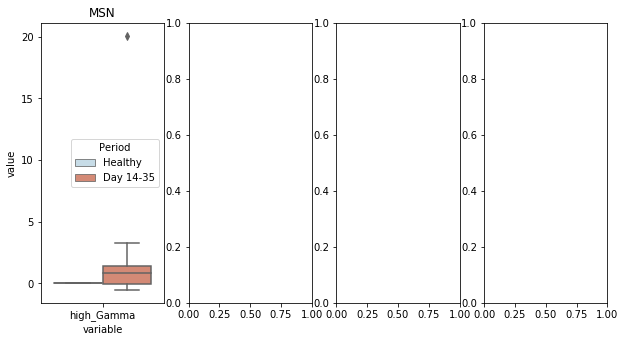

In [27]:
dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['high_Gamma'])
fig, ax = plt.subplots(1,4,figsize=(10.15,5.15))#, sharey=True )
# dfP.CellType
# for indP, p in enumerate(['high_Gamma','high_Beta_15to20','low_Gamma']):
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["MSN"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Day 14-35'])#, showfliers = False)
#         sns.swarmplot(x = 'Period',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
#                     hue_order=['Healthy','Day 14-35'],order=['Healthy','Day 14-35'],color = 'black')
    #         sns.boxplot(x = 'Period',y =p,ax = ax[indC,indP],data= Pdf[Pdf.CellType ==c], showfliers = False)
    #         sns.pointplot(x = 'variable',y = 'value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c], showfliers = False)
        ax[indC].set_title(c)
# fig.savefig(figFolder+'figure6_statsBars_L-dopa_.svg',transparent=True)

In [108]:
df3[df3.CellType=='mvmt'][['high_Beta_15to20','Mouse','Period']]

high_Beta_15to20  Mouse     Period
2            0.143572    761   Day 1-13
5           -1.740385    761  Day 14-35
8            0.000000    761    Healthy
11          -0.681558   1208   Day 1-13
14           0.460059   1208  Day 14-35
17           0.000000   1208    Healthy
19          -0.421391   1222   Day 1-13
22           0.375785   1222  Day 14-35
25           0.000000   1222    Healthy
28           0.000000   1231    Healthy
31          -0.296741   1236   Day 1-13
34          -1.159502   1236  Day 14-35
37           0.000000   1236    Healthy
40           0.000000   1253    Healthy
43          -0.350229   1793   Day 1-13
46          -0.458882   1793  Day 14-35
49           0.000000   1793    Healthy
51          -0.856132   2976   Day 1-13
53          -1.182733   2976  Day 14-35
55           0.000000   2976    Healthy
57           5.227324   2980   Day 1-13
59           8.801378   2980  Day 14-35
61           0.000000   2980    Healthy
63           0.384673   2981   Day 1-13
65           4.499096   2981  Day 14-35
67           0.000000   2981    Healthy
70          -0.473956   4539   Day 1-13
73          -1.480779   4539  Day 14-35
76           0.000000   4539    Healthy
79          -0.394155   7584   Day 1-13
82           1.817041   7584  Day 14-35
85           0.000000   7584    Healthy
88          -0.764663   7909   Day 1-13
91          -0.960094   7909  Day 14-35
94           0.000000   7909    Healthy
97           1.263808   8430   Day 1-13
100          0.054606   8430  Day 14-35
103          0.000000   8430    Healthy
106          0.240703   8803   Day 1-13
109         -0.865580   8803  Day 14-35
112          0.000000   8803    Healthy
115          0.080604   8815   Day 1-13
118         -0.286547   8815  Day 14-35
121          0.000000   8815    Healthy

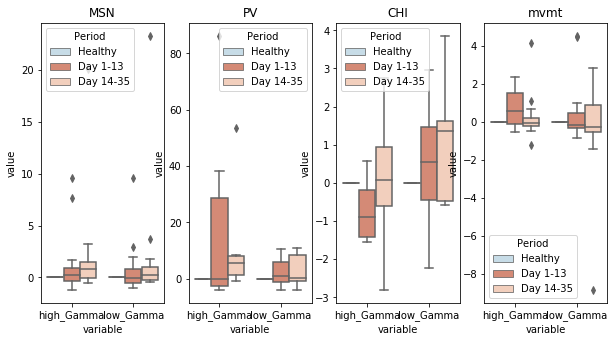

In [28]:
# %matplotlib inline
dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['high_Gamma','low_Gamma'])
fig, ax = plt.subplots(1,4,figsize=(10.15,5.15))#, sharey=True )
# dfP.CellType
# for indP, p in enumerate(['high_Gamma','high_Beta_15to20','low_Gamma']):
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["MSN","PV","CHI","mvmt"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Day 1-13','Day 14-35'])#, showfliers = False)
    #         sns.boxplot(x = 'Period',y =p,ax = ax[indC,indP],data= Pdf[Pdf.CellType ==c], showfliers = False)
    #         sns.pointplot(x = 'variable',y = 'value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c], showfliers = False)
        ax[indC].set_title(c)
# fig.savefig(figFolder+'figure6_statsBars.svg',transparent=True)
#         ax[indC,indP].set_ylim(-.5,2)
# dfP = dfP.groupby(['Period','CellType','Mouse','variable']).mean()
# dfP = dfP.reset_index()
# dfP

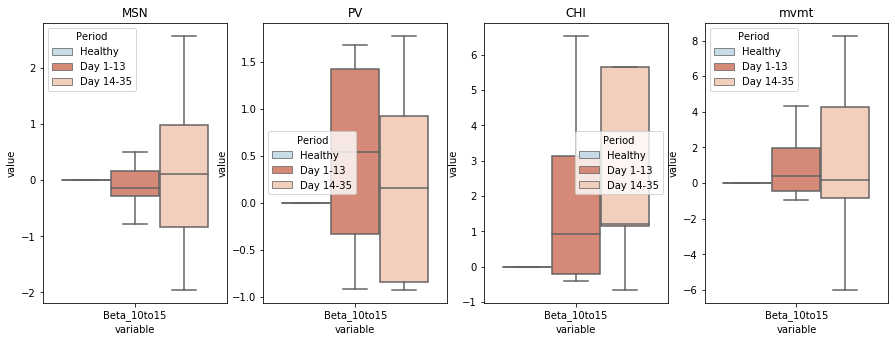

In [43]:
# %matplotlib inline
dfP = pd.melt(df3, id_vars = ['Period','CellType','Mouse'],value_vars = ['Beta_10to15'])
fig, ax = plt.subplots(1,4,figsize=(15.15,5.15))#, sharey=True )
# dfP.CellType
# for indP, p in enumerate(['high_Gamma','high_Beta_15to20','low_Gamma']):
with sns.color_palette(colorPallet3):
    for indC,c in enumerate(["MSN","PV","CHI","mvmt"]):
        sns.boxplot(x = 'variable',y ='value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c],
                    hue_order=['Healthy','Day 1-13','Day 14-35'], showfliers = False)

    #         sns.boxplot(x = 'Period',y =p,ax = ax[indC,indP],data= Pdf[Pdf.CellType ==c], showfliers = False)
    #         sns.pointplot(x = 'variable',y = 'value',hue = 'Period',ax = ax[indC],data= dfP[dfP.CellType ==c], showfliers = False)
        ax[indC].set_title(c)
fig.savefig(figFolder+'figure6_statsBars_Beta.svg',transparent=True)
#         ax[indC,indP].set_ylim(-.5,2)
# dfP = dfP.groupby(['Period','CellType','Mouse','variable']).mean()
# dfP = dfP.reset_index()
# dfP

In [40]:
df3

Mouse     Period CellType  Unnamed: 0  Unnamed: 0.1  high_Gamma  \
0      761   Day 1-13      CHI   14.000000     14.000000   -1.543851   
1      761   Day 1-13      MSN   13.500000     13.500000   -0.207551   
2      761   Day 1-13     mvmt  312.571429           NaN   -0.112114   
3      761  Day 14-35      CHI   12.000000     12.000000   -0.597963   
4      761  Day 14-35      MSN   12.000000     12.000000   -0.297071   
..     ...        ...      ...         ...           ...         ...   
117   8815  Day 14-35      MSN  297.400000    297.400000   -0.264545   
118   8815  Day 14-35     mvmt  502.400000           NaN    1.098881   
119   8815    Healthy      CHI  286.500000    286.500000    0.000000   
120   8815    Healthy      MSN  287.333333    287.333333    0.000000   
121   8815    Healthy     mvmt  496.000000           NaN    0.000000   

     high_Beta_15to20  Beta_10to15     theta  low_Gamma  
0           -1.142320    -0.396100  1.144110   0.131799  
1            0.044222    -0.172006  0.348415  -0.557556  
2            0.143572     2.019025  0.823468  -0.344113  
3            0.324695    -0.665853 -0.208418   3.859847  
4           -0.252804    -0.819494  0.571778  -0.266759  
..                ...          ...       ...        ...  
117          2.511847    68.826942  0.138091  -0.224888  
118         -0.286547     0.692211  0.051033  -0.565082  
119          0.000000     0.000000 -1.131257   0.000000  
120          0.000000     0.000000  0.020324   0.000000  
121          0.000000     0.000000 -0.255544   0.000000  

[122 rows x 10 columns]

In [32]:
# plot LFP aligned to MSN

periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}
df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
    cellType = 'MSN'
    cre = None
#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 = getAlignedLFP(cellType,cre = cre, period = per,mice=l)
#     else:
    A,df2 = getAlignedLFP(cellType,cre = cre, day =periods[per])
    if A.shape[2] > 1000:
        b = A[:,:,0:1000]
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nansum(b,axis=2)
        for ind in range(0,A.shape[2]//1000):
            c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
            mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
            Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
            c =(c-mu)/Std
            c = np.nansum(c,axis=2)
            b = b+c
        b= b/A.shape[2]
    else:
        b = A
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nanmean(b,axis=2)
    pickle.dump(b, open(figFolder+per+'.p',"wb"),protocol=4)
    del A,b
    b = pickle.load(open(figFolder+per+'.p',"rb"))

    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =0.6,vmin=-0.2)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#    fig.savefig(figFolder+'figure5b_MSN_'+per+'.png',format='png')
    fig.savefig(figFolder+'figure5b_MSN'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)



/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':


(12206, 87, 7825)
(12206, 87, 9479)
(12206, 87, 6506)


In [34]:
# A = np.ones((12206,87,9479))
# c = A[:,2,:]
b = np.zeros((A.shape[0],A.shape[1]))
mu = np.mean(c[:int(c.shape[0]/2),:],axis=0)
Std = np.std(c[:int(c.shape[0]/2),:],axis=0)
c =(c-mu)/Std
print(c.shape)
b[:,2] = np.nanmedian(c)

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


(12206, 9479)


/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


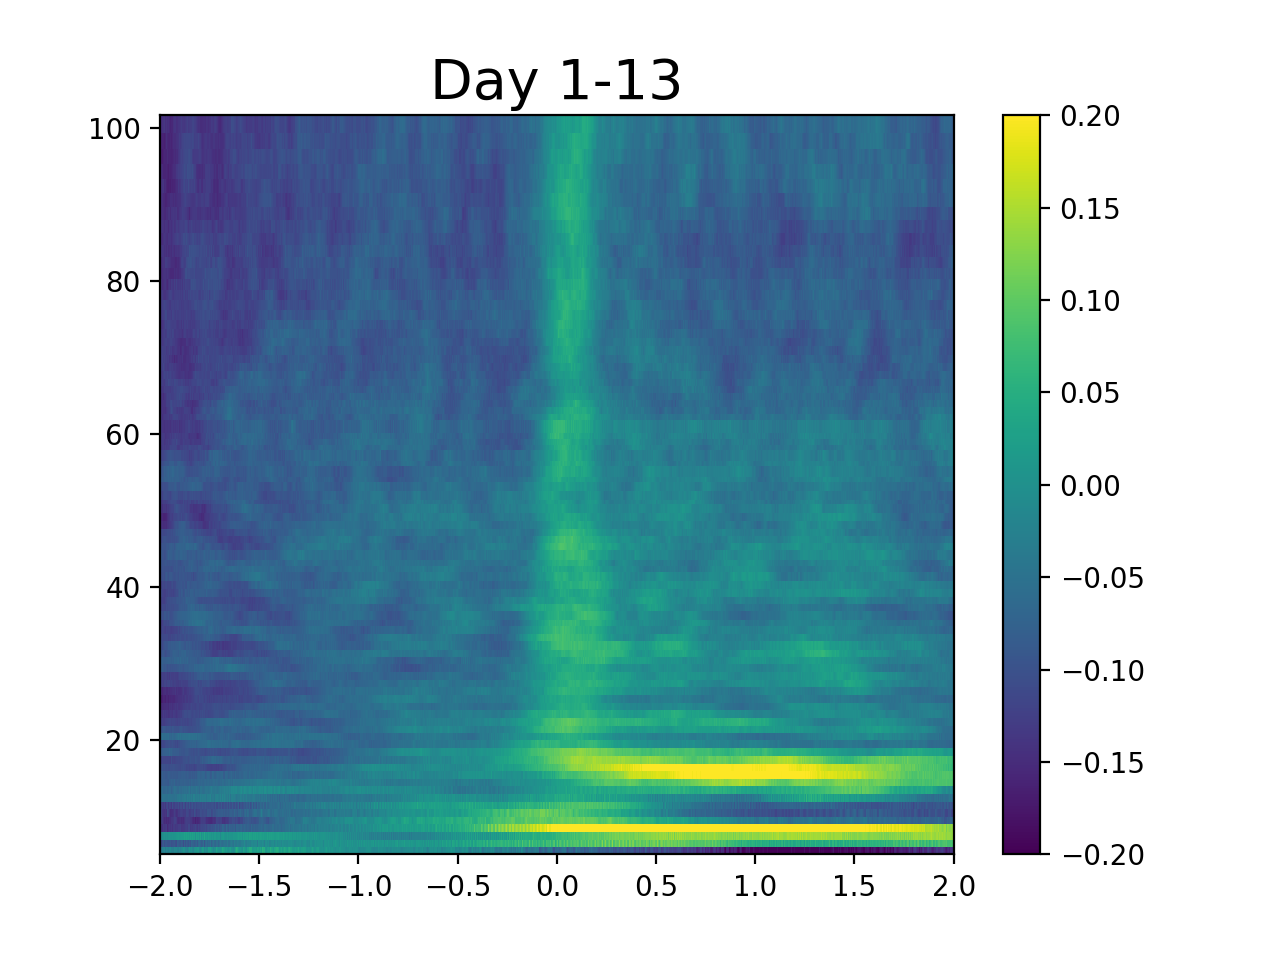

In [57]:
# plot LFP aligned to MSN - median

periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}
df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
f.close()
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in ['Day 1-13']:#periods.keys():
    cellType = 'MSN'
    cre = None
#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 = getAlignedLFP(cellType,cre = cre, period = per,mice=l)
#     else:
    A,df2 = getAlignedLFP(cellType,cre = cre, day =periods[per])
    b = np.zeros((A.shape[0],A.shape[1]))
    for fr in range(A.shape[1]):
        c = A[:,fr,:]
        mu = np.mean(c[:int(c.shape[0]/2),:],axis=0)
        Std = np.std(c[:int(c.shape[0]/2),:],axis=0)
        c =(c-mu)/Std
        b[:,fr] = np.nanmedian(c,axis=1)
        del c
        
    del A

    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =0.2,vmin=-0.2)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#    fig.savefig(figFolder+'figure5b_MSN_'+per+'.png',format='png')


In [36]:
# plot LFP aligned to MSN - median

periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}
df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
f.close()
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
    cellType = 'MSN'
    cre = None
#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 = getAlignedLFP(cellType,cre = cre, period = per,mice=l)
#     else:
    A,df2 = getAlignedLFP(cellType,cre = cre, day =periods[per])
    b = np.zeros((A.shape[0],A.shape[1]))
    for fr in range(A.shape[1]):
        c = A[:,fr,:]
        mu = np.mean(c[:int(c.shape[0]/2),:],axis=0)
        Std = np.std(c[:int(c.shape[0]/2),:],axis=0)
        c =(c-mu)/Std
        b[:,fr] = np.nanmedian(c,axis=1)
        del c
        
    del A

    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =0.2,vmin=-0.2)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#    fig.savefig(figFolder+'figure5b_MSN_'+per+'.png',format='png')
    fig.savefig(figFolder+'figure5b_MSN'+per+'_median.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)



/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':


In [38]:
# plot LFP aligned to MSN - median

periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}
df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
f.close()
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
    cellType = 'CRE'
    cre = 'CHI'
#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 = getAlignedLFP(cellType,cre = cre, period = per,mice=l)
#     else:
    A,df2 = getAlignedLFP(cellType,cre = cre, day =periods[per])
    b = np.zeros((A.shape[0],A.shape[1]))
    for fr in range(A.shape[1]):
        c = A[:,fr,:]
        mu = np.mean(c[:int(c.shape[0]/2),:],axis=0)
        Std = np.std(c[:int(c.shape[0]/2),:],axis=0)
        c =(c-mu)/Std
        b[:,fr] = np.nanmedian(c,axis=1)
        del c
        
    del A

    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =2,vmin=-2)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#    fig.savefig(figFolder+'figure5b_MSN_'+per+'.png',format='png')
    fig.savefig(figFolder+'figure5b_CHI'+per+'_median.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)



/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':


In [42]:
# plot LFP aligned to MSN - median

periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}
df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
f.close()
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
    cellType = 'CRE'
    cre = 'PV'
#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 = getAlignedLFP(cellType,cre = cre, period = per,mice=l)
#     else:
    A,df2 = getAlignedLFP(cellType,cre = cre, day =periods[per])
    b = np.zeros((A.shape[0],A.shape[1]))
    for fr in range(A.shape[1]):
        c = A[:,fr,:]
        mu = np.mean(c[:int(c.shape[0]/2),:],axis=0)
        Std = np.std(c[:int(c.shape[0]/2),:],axis=0)
        c =(c-mu)/Std
        b[:,fr] = np.nanmedian(c,axis=1)
        del c
        
    del A

    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =.75,vmin=-1)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#    fig.savefig(figFolder+'figure5b_MSN_'+per+'.png',format='png')
    fig.savefig(figFolder+'figure5b_PV'+per+'_median.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)



/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':


In [205]:
def getAlignedLFP3(cellType,cre = None, mice = None, period = None, day=None, drug=None,drugPeriod='Pre'):
    # function that take in the classification and return the appropreate data:
    #Inputs:
    #   cellType - return MSN or CRE if both pass ['MNS','CRE']
    #   mice - (Optional) list of mice from to include. Default: None - will load data for all mice
    #   period - (Optional) either 'Pre' or 'Post'. difault: None - return full length of data from picked sessions
    #   day - (Optional) lambda function with logic for picking days. Default: None - ignore day attr when picking data
    #           NOTE: day will be ignored if period is specified
    #   cre - (Optional) which cre mouse is it. options:None (default), "PV", "CHI"
    #                   must have trace included in dataType list to be taken into account
    #   WinPre - (Optional) length of pre window in secounds (default 2)
    #   WinPost - (Optional) length of post window in secounds (default 2)
    #Output:
    #   data - the requested data. format: {mice_session:{dataType:data}}
    
    
    dFile = 'FinalData_6OHDA_H.h5'
    # double check parameters inputs are valid:
    if drugPeriod=='Post':
        savePath = '/home/dana_z/HD1/lfp2ca_notNormalize/Post/'#'/home/dana_z/HD1/lfpAligned2Ca/Post/'
    else:
        savePath = '/home/dana_z/HD1/lfp2ca_notNormalize/'#'/home/dana_z/HD1/lfpAligned2Ca/Pre/'

    df = pd.read_csv(savePath+'sessions')
    
    if period == None and day != None and isinstance(day,type(lambda c:None)):
        df['keep'] = df.apply(lambda row: day(row.day), axis=1)
        df = df[(df.keep==True)]
    
    if period in ['Healthy','Day 1-4','Day 5-12','Day 13-20','One Month']:
        df = df[(df.period==period)]
       
    if cre in ['PV','CHI','NA']:
        df = df[(df.cre==cre)]
    
    if drug in ['Amph','L-Dopa','Saline','None']:
        df = df[(df.drug==drug)]
    

    if not isinstance(cellType,list):
        cellType = [cellType]
        
    cellType = list(set(cellType).intersection(set(['MSN','CRE'])))
    if len(cellType) == 0:
        raise ValueError('Not a valid cellType value. cellType must be in ["MSN","CRE"]')
    
    # traverse the hdf5 file:
    if mice == None:
        mice = getMiceList(dFile) 
    elif not isinstance(mice,list):
        mice = [mice]
    
    if not isinstance(mice[0],str):
        for m in range(0,len(mice)):
            mice[m] = str(mice[m])
    df = df[(df.mouse.isin(mice))]
    # start extracting the data:   
    
    # alllocate memory:
#    nNeurons = 0;
#    if 'MSN' in cellType:
#        nNeurons = nNeurons + int(df.numMsn.sum()) - int(df.numred.sum())
#    if 'CRE' in cellType:
#        nNeurons = nNeurons + int(df.numred.sum())
    nSess = len(df.mouse.unique())
    dResult = np.empty([12206,87,nSess],dtype=float)
    
    ind = 0
    for m in df.mouse.unique():
        dfM = df[df.mouse == m]
        indM = 0
        nSessM = len(df.sess.unique())
        nNeurons = 0
        if 'MSN' in cellType:
            nNeurons = nNeurons + int(dfM.numMsn.sum()) - int(dfM.numred.sum())
        if 'CRE' in cellType:
            nNeurons = nNeurons + int(dfM.numred.sum())
        MResult = np.empty([12206,87,nNeurons],dtype=float)
        for sess in dfM.sess.unique():
            if 'MSN' in cellType:
                try: 
                    tempD = pickle.load(open(savePath+'MSN/'+sess,'rb'))
                except:
                    continue
                tempD[tempD==9999] = np.nan
                tempD[tempD==-9999] = np.nan
                mu = np.mean(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                Std = np.std(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                tempD =(tempD-mu)/Std
#                 print(indM,indM+tempD.shape[2],tempD.shape[2],MResult[:,:,indM:(indM+tempD.shape[2])].shape)
                MResult[:,:,indM:(indM+tempD.shape[2])] = tempD 
                indM = indM+tempD.shape[2]
            # for every Cre neuron:
            if 'CRE' in cellType:
                try:
                    tempD = pickle.load(open(savePath+'CRE/'+sess,'rb'))
                except:
                    continue
                tempD[tempD==9999] = np.nan
                tempD[tempD==-9999] = np.nan
                mu = np.mean(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                Std = np.std(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
                tempD =(tempD-mu)/Std
#                 print(indM,indM+tempD.shape[2],tempD.shape[2],MResult[:,:,indM:(indM+tempD.shape[2])].shape)
                MResult[:,:,indM:(indM+tempD.shape[2])] = tempD 
                indM = indM+tempD.shape[2]
        MResult = MResult[:,:,:indM]
        dResult[:,:,ind] = np.nanmean(MResult,axis=2)  
        ind = ind+1
        
    return dResult[:,:,:ind],df

In [87]:
def getAlignedLFP_mvmt2(savePath,cre = None, mice = None, period = None, day=None, drug=None,drugPeriod='Pre'):
    # function that take in the classification and return the appropreate data:
    #Inputs:
    #   cellType - return MSN or CRE if both pass ['MNS','CRE']
    #   mice - (Optional) list of mice from to include. Default: None - will load data for all mice
    #   period - (Optional) either 'Pre' or 'Post'. difault: None - return full length of data from picked sessions
    #   day - (Optional) lambda function with logic for picking days. Default: None - ignore day attr when picking data
    #           NOTE: day will be ignored if period is specified
    #   cre - (Optional) which cre mouse is it. options:None (default), "PV", "CHI"
    #                   must have trace included in dataType list to be taken into account
    #   WinPre - (Optional) length of pre window in secounds (default 2)
    #   WinPost - (Optional) length of post window in secounds (default 2)
    #Output:
    #   data - the requested data. format: {mice_session:{dataType:data}}
    
    
    dFile = 'FinalData_6OHDA_H.h5'
    # double check parameters inputs are valid:

    df = pd.read_csv(savePath+'sessions')
    
    if period == None and day != None and isinstance(day,type(lambda c:None)):
        df['keep'] = df.apply(lambda row: day(row.day), axis=1)
        df = df[(df.keep==True)]
    
    if period in df.period.unique():
        df = df[(df.period==period)]
       
    if cre in ['PV','CHI','NA']:
        df = df[(df.cre==cre)]
    
    if drug in ['Amph','L-Dopa','Saline','None']:
        df = df[(df.drug==drug)]
     
   
    # traverse the hdf5 file:
    if mice == None:
        mice = getMiceList(dFile) 
    elif not isinstance(mice,list):
        mice = [mice]
    
    if not isinstance(mice[0],str):
        for m in range(0,len(mice)):
            mice[m] = str(mice[m])
    df = df[(df.mouse.isin(mice))]
    # start extracting the data:   
    
    # alllocate memory:
   
    dResult = np.empty([12206,87,len(df)*50],dtype=float)
    
    ind = 0
    for m in df.mouse.unique():
        dfM = df[df.mouse == m]
        indM = 0
        nSessM = len(df.sess.unique())
        nNeurons = 0
        MResult = np.empty([12206,87,len(df)*50],dtype=float)
        for sess in dfM.sess.unique():   
            tempD = pickle.load(open(savePath+sess,'rb'))
            tempD[tempD==9999] = np.nan
            tempD[tempD==-9999] = np.nan
            mu = np.mean(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
            Std = np.std(tempD[:int(tempD.shape[0]/2),:,:],axis=0)
            tempD =(tempD-mu)/Std
#             print(indM,indM+tempD.shape[2],tempD.shape[2],MResult[:,:,indM:(indM+tempD.shape[2])].shape)
            MResult[:,:,indM:(indM+tempD.shape[2])] = tempD 
            indM = indM+tempD.shape[2]

        MResult = MResult[:,:,:indM]
        dResult[:,:,ind] = np.nanmean(MResult,axis=2)  
        ind = ind+1

        
    return dResult[:,:,:ind],df

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


<IPython.core.display.Javascript object>


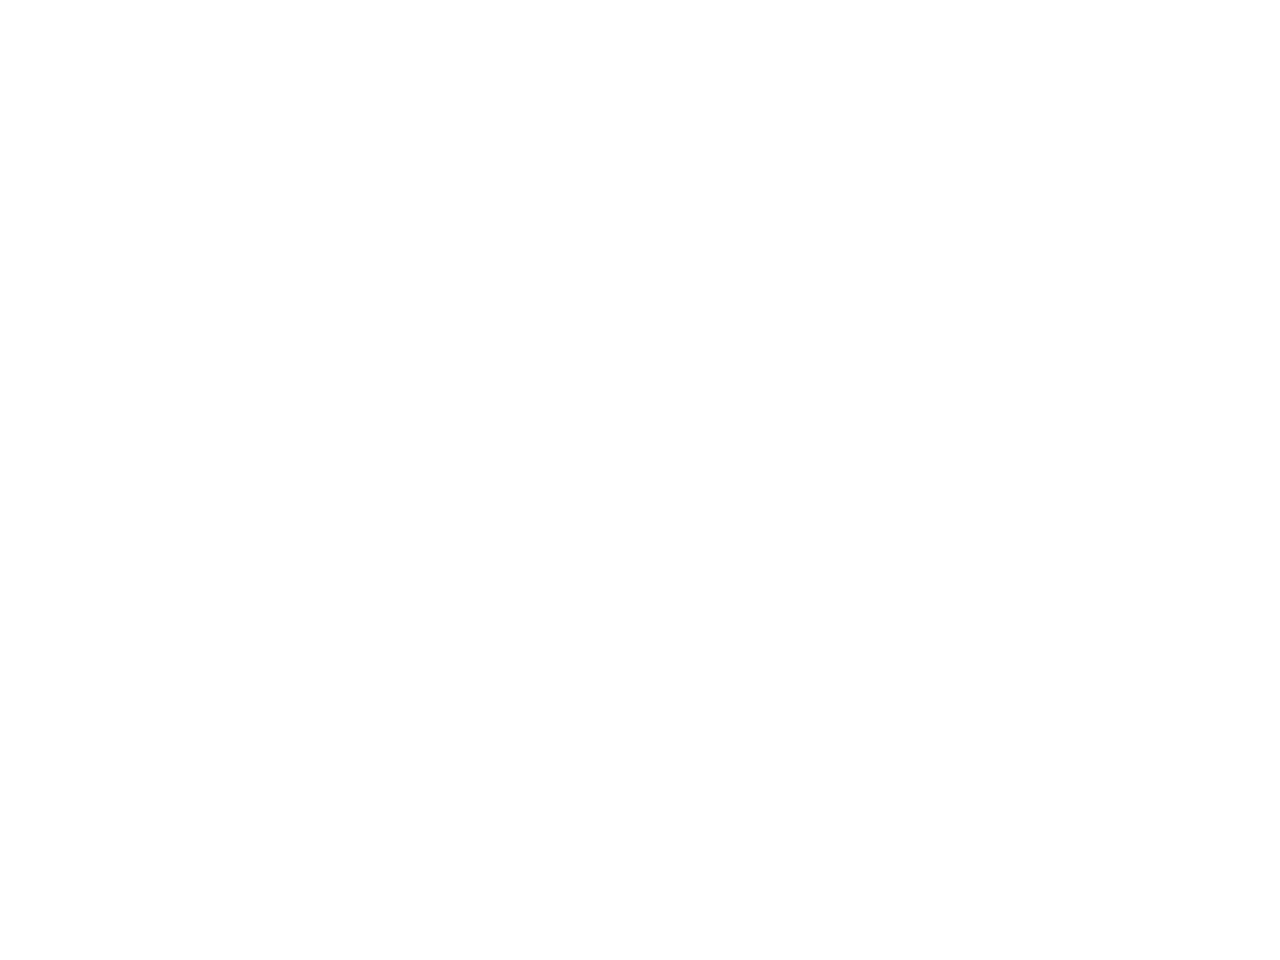

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


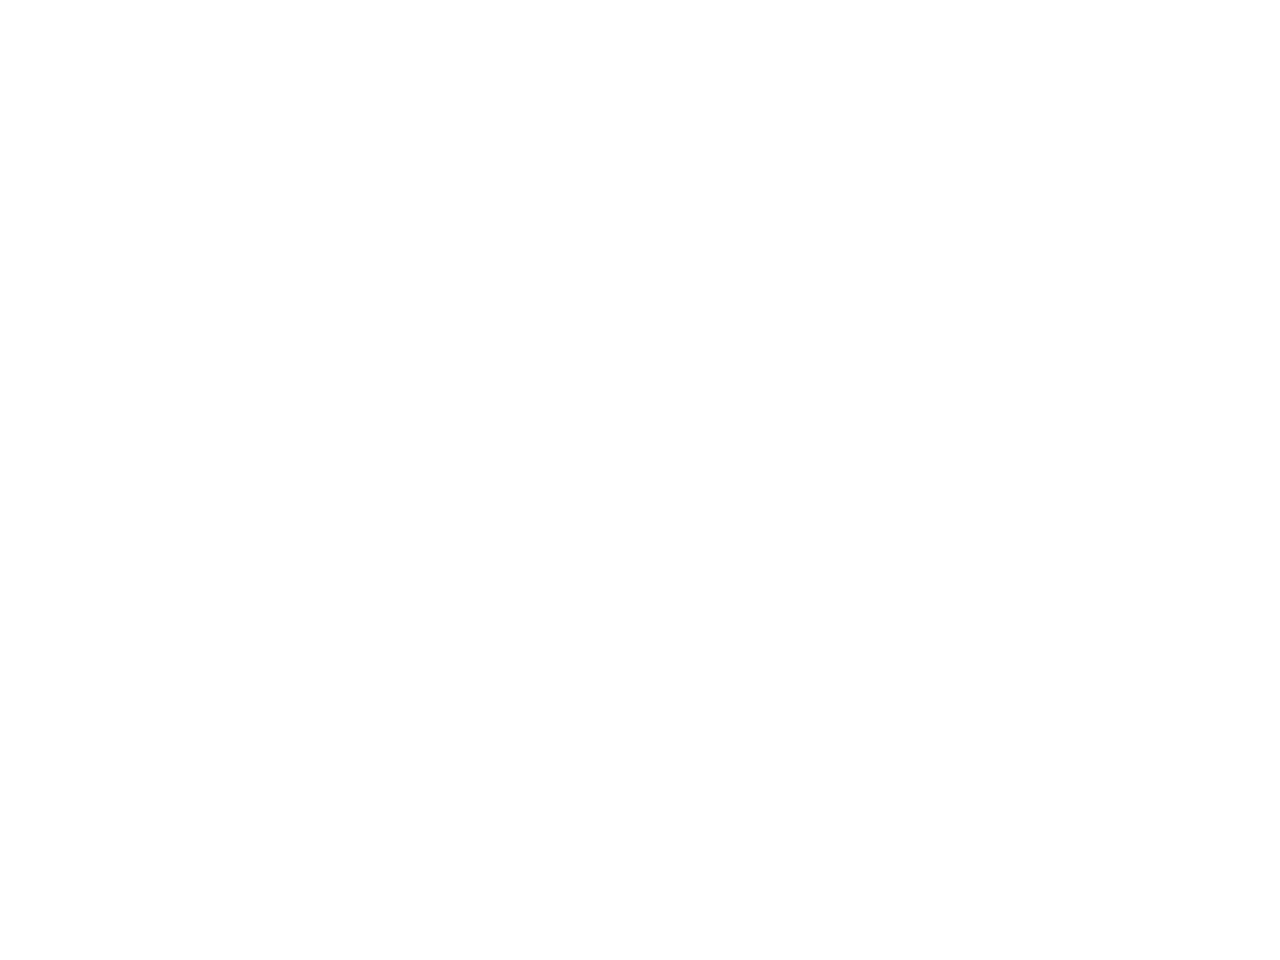

<IPython.core.display.Javascript object>


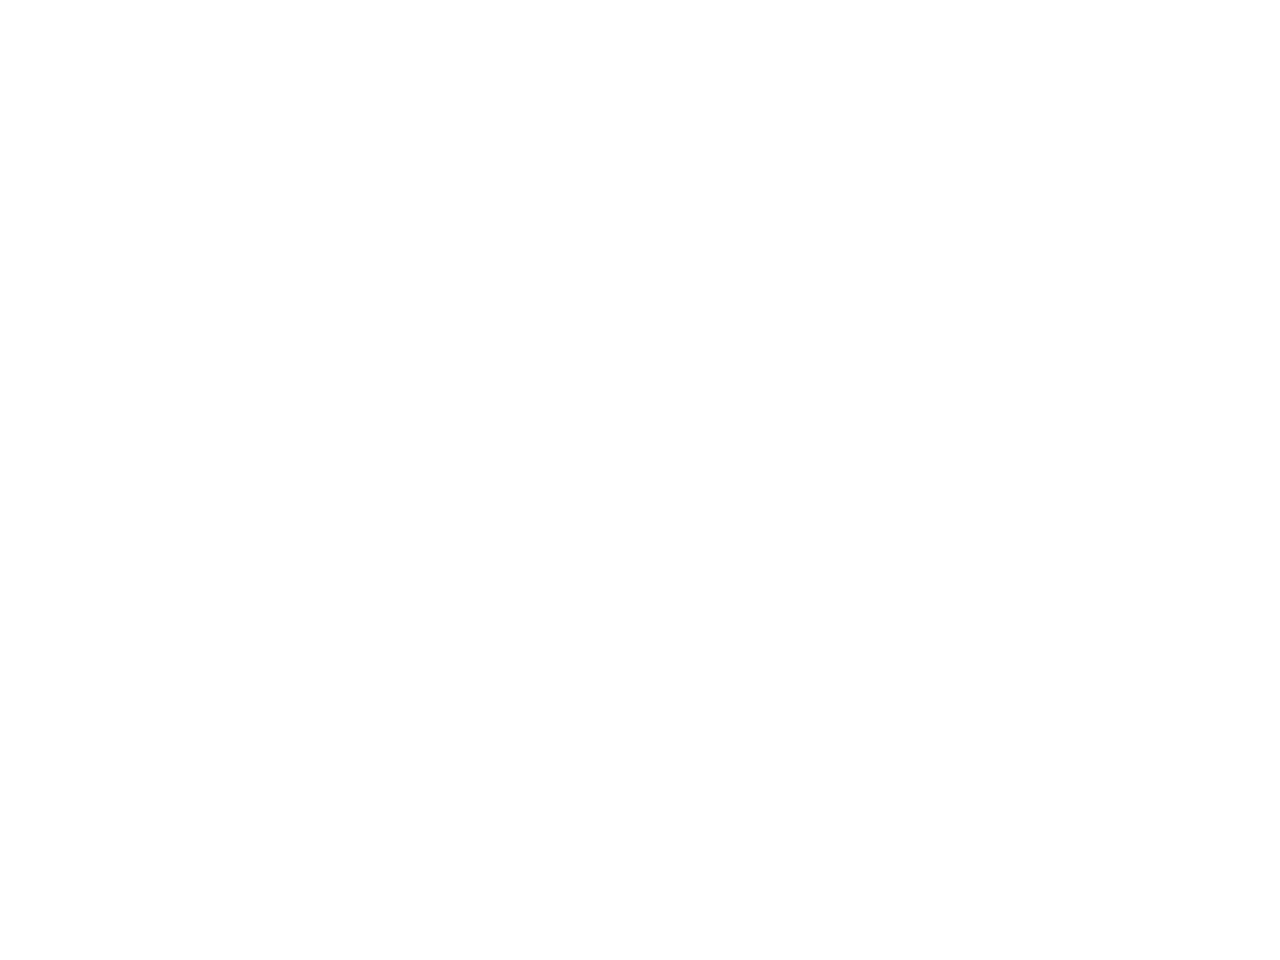

<IPython.core.display.Javascript object>


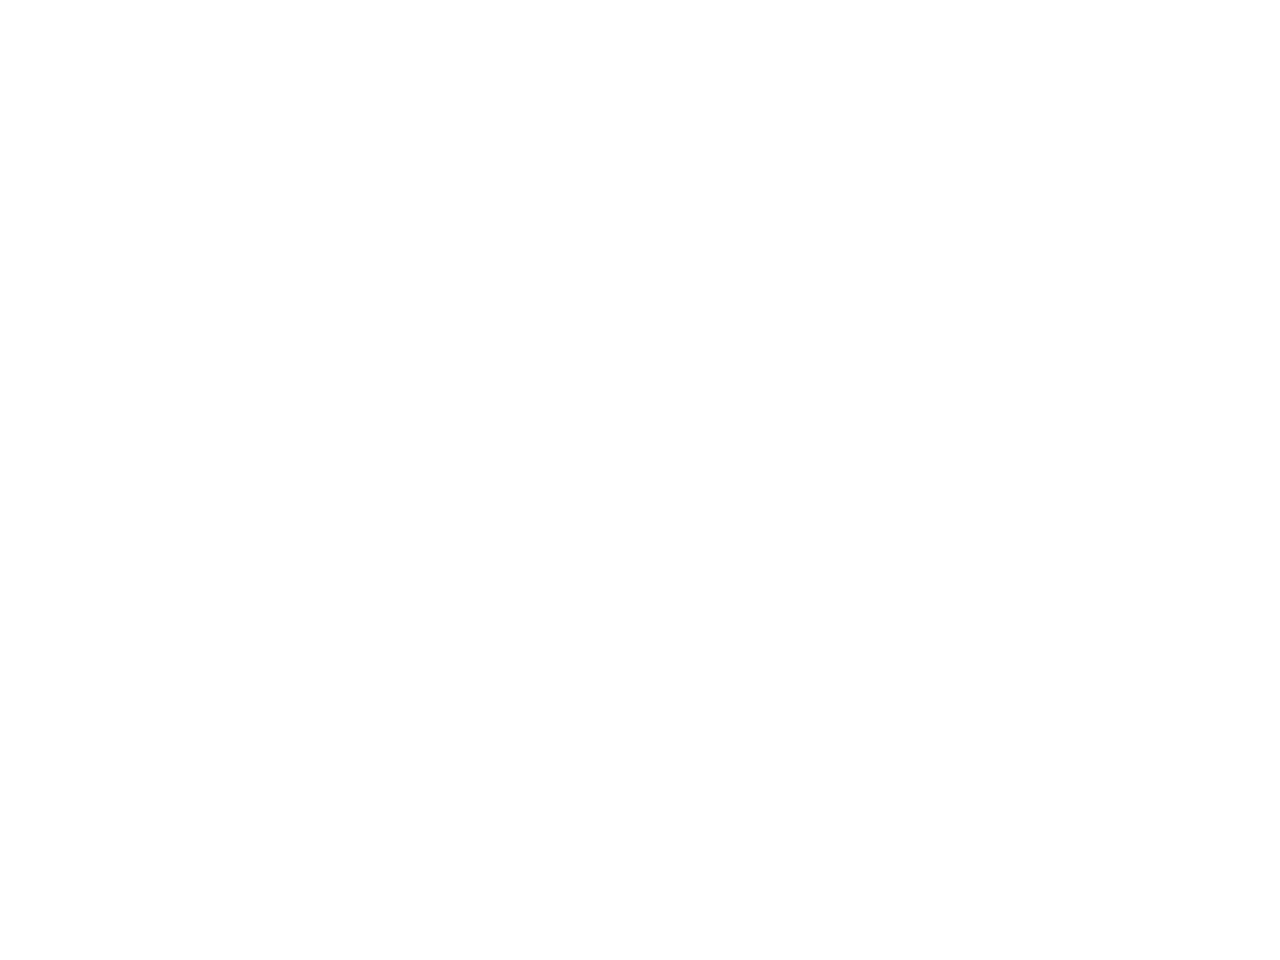

<IPython.core.display.Javascript object>


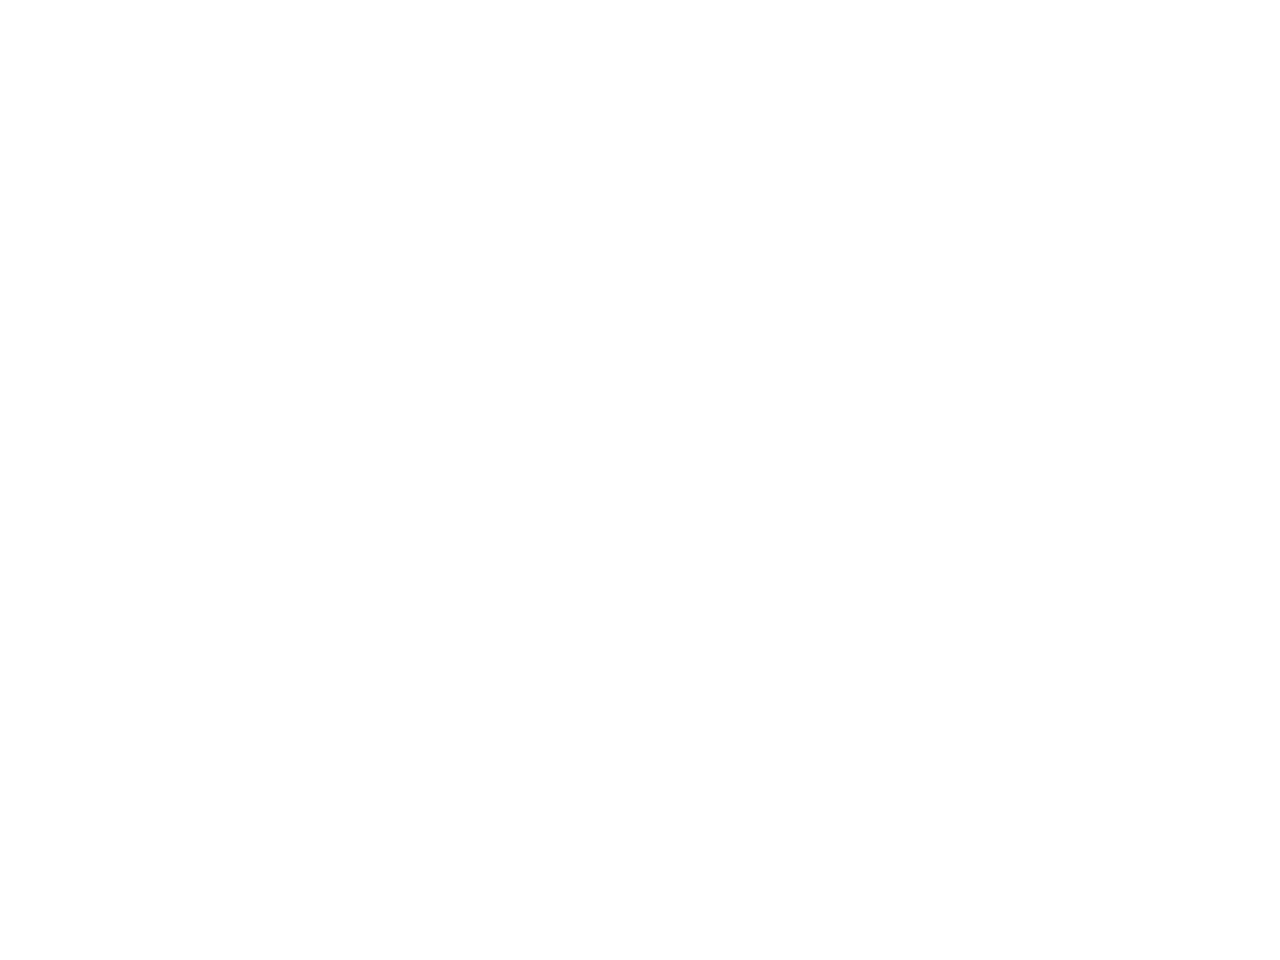

<IPython.core.display.Javascript object>


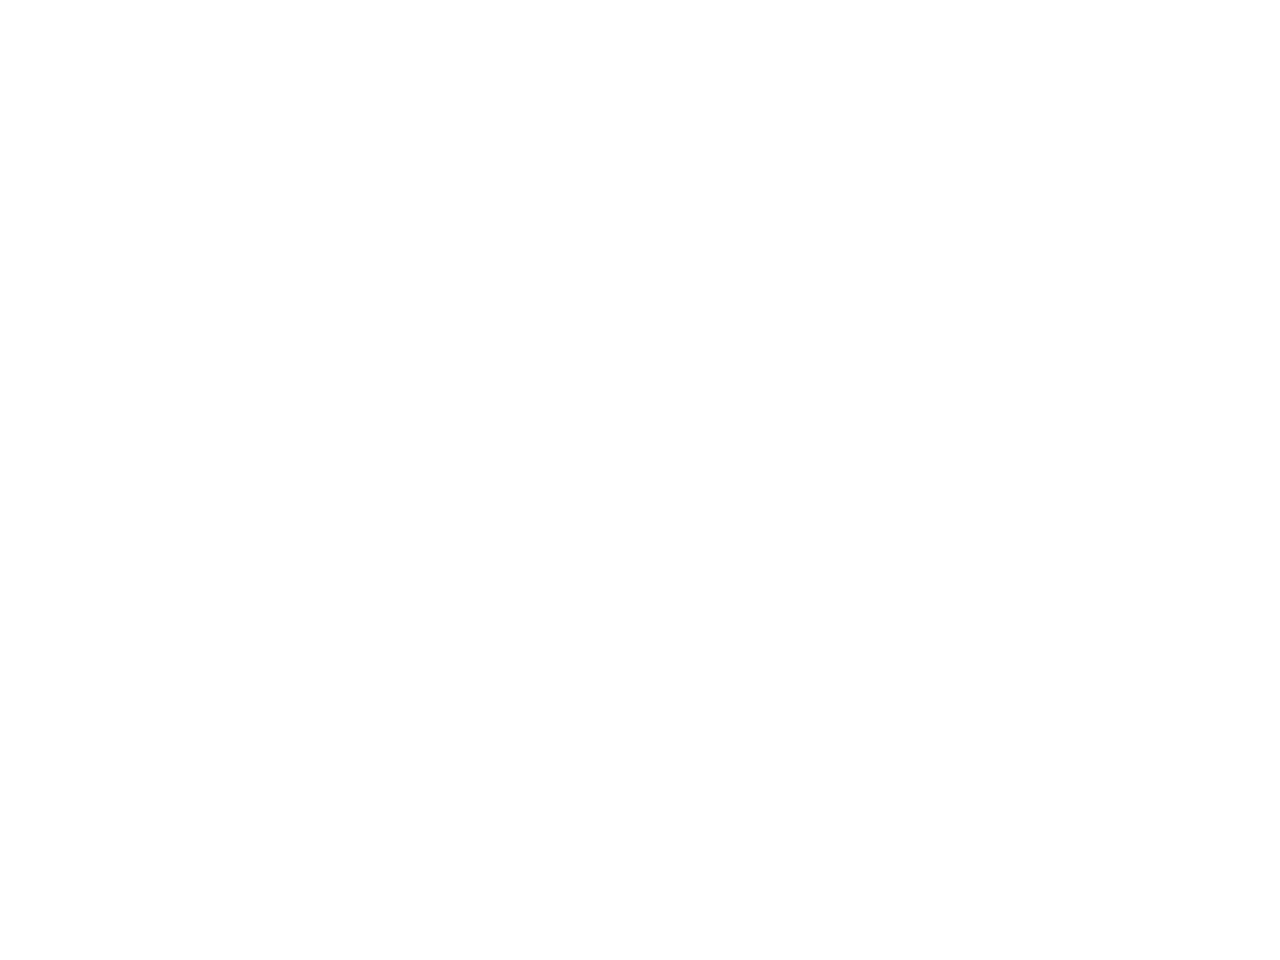

<IPython.core.display.Javascript object>


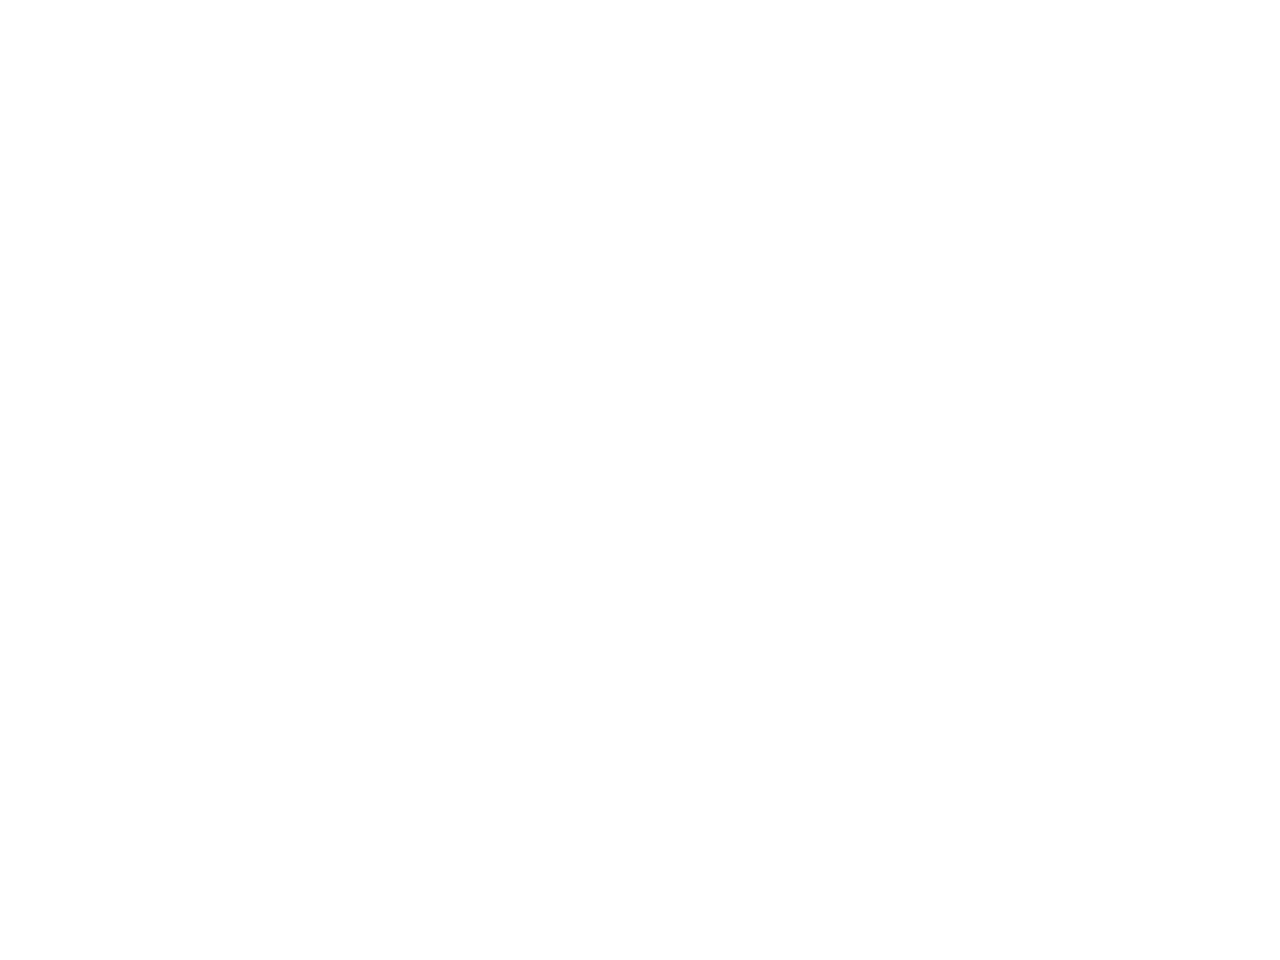

<IPython.core.display.Javascript object>


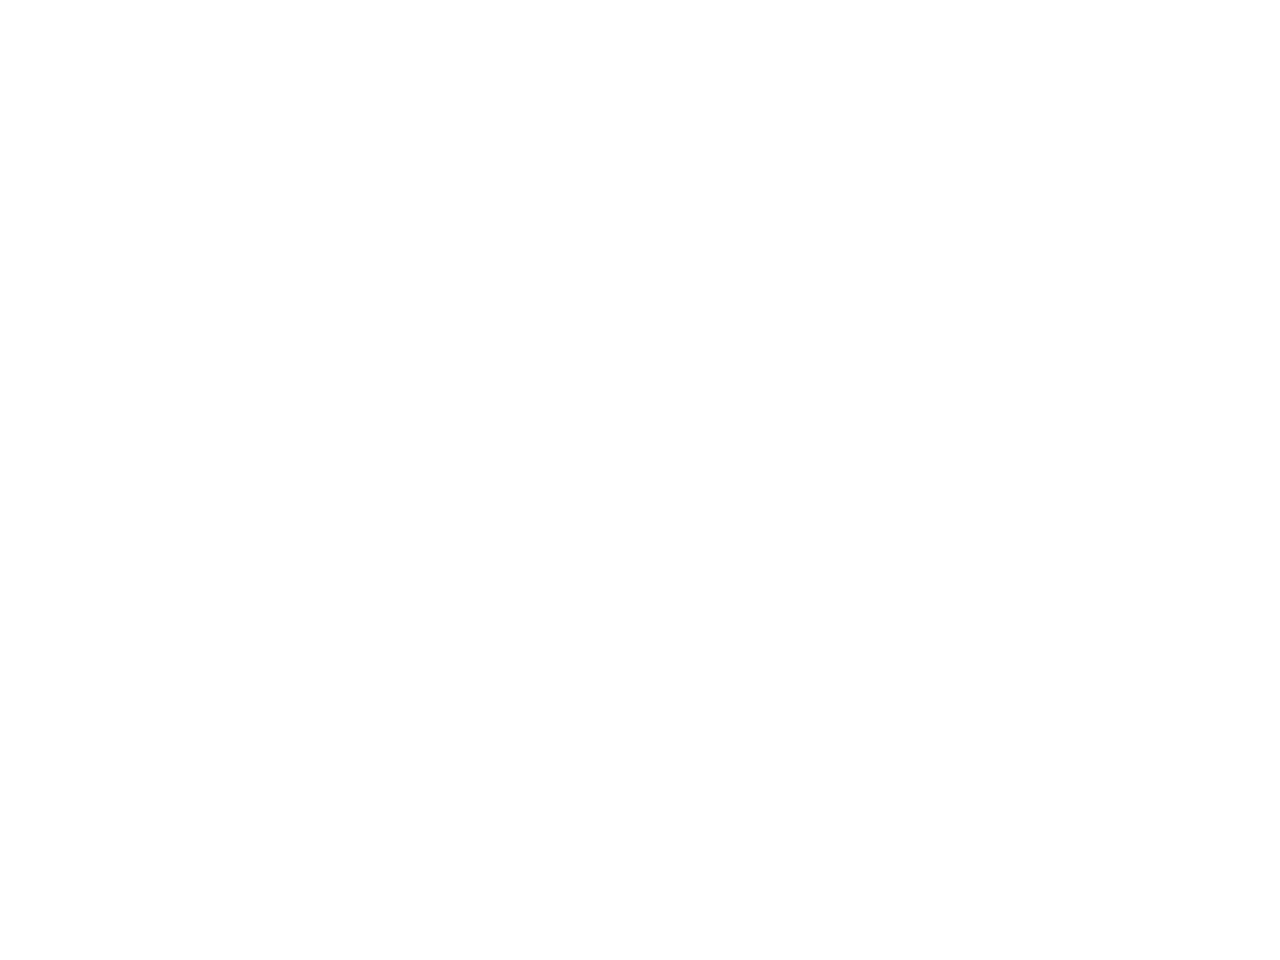

<IPython.core.display.Javascript object>


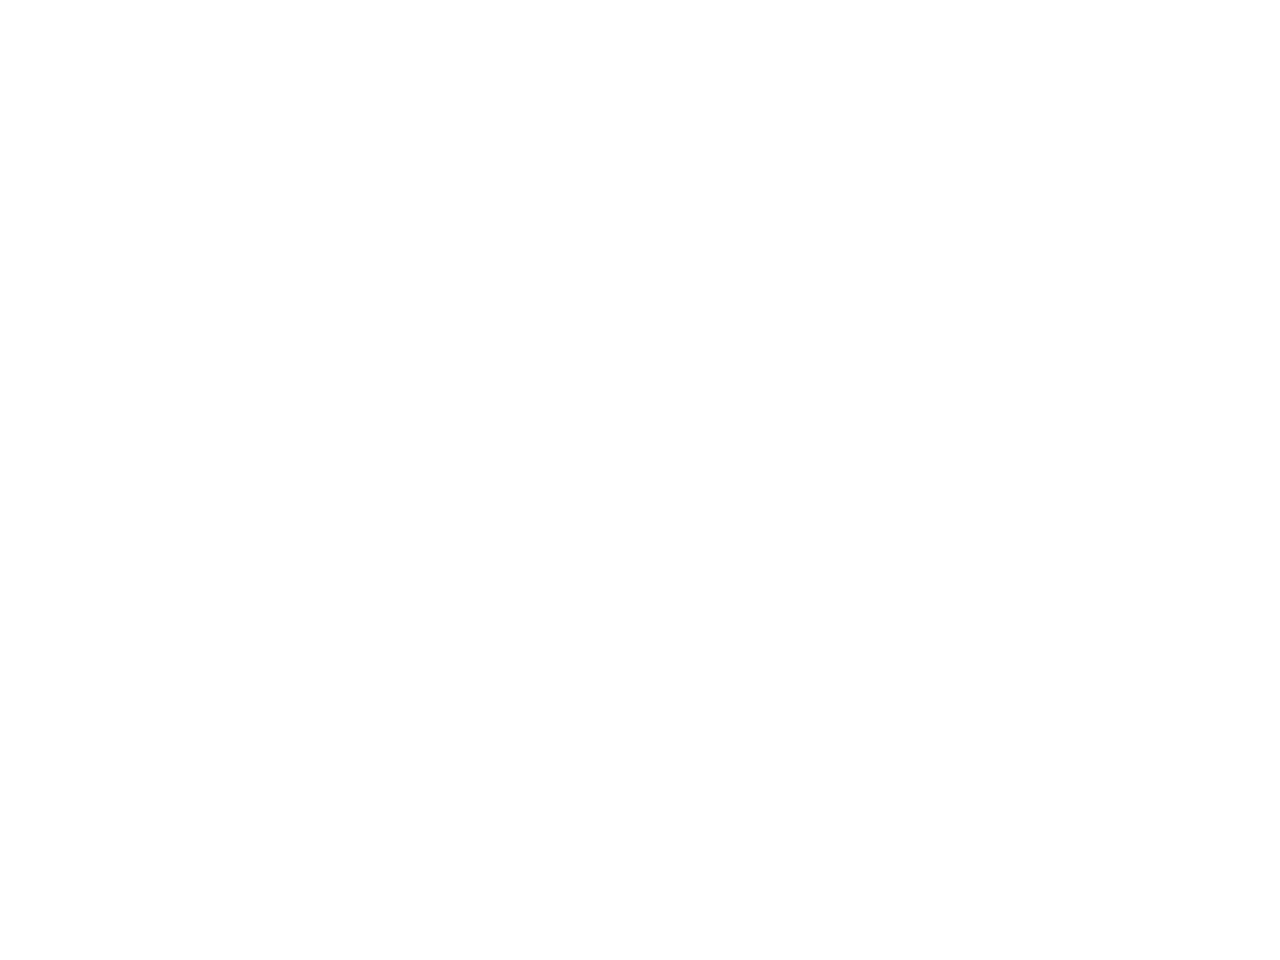

In [92]:
periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}

df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
# for per in periods.keys():
#     cellType = 'MSN'
#     cre = None
#     A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per])
#     b = np.nanmean(A,axis=2)
#     del A
#     fig, ax = plt.subplots()
#     CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
#     fig.colorbar(CS)
#     ax.set_title(per,fontsize=20)
# #     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
#     fig.savefig(figFolder+'figure5b_MSN_Mouse'+per+'.svg',format='svg',transparent=True)
#     fig.clf()
#     plt.close(fig)

for per in periods.keys():
    cellType = 'CRE'
    cre = 'CHI'
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_CHI_Mouse'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)

for per in periods.keys():
    cellType = 'CRE'
    cre = 'PV'
    A,df2 = getAlignedLFP3(cellType,cre = cre, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_PV_Mouse'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)

    
    
savePath = '/home/dana_z/HD1/lfp2speed2/'
for per in periods.keys():
    A,df2 = getAlignedLFP_mvmt2(savePath, day =periods[per])
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.35,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_speedOnset_Mouse'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)



In [ ]:
periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}

df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
    cellType = 'CRE'
    cre = 'PV'
#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 = getAlignedLFP(cellType,cre = cre, period = per,mice=l)
#     else:
    A,df2 = getAlignedLFP2(cellType,cre = cre, day =periods[per])
#     if A.shape[2] > 1000:
#         b = A[:,:,0:1000]
#         mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
#         Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
#         b =(b-mu)/Std
#         b = np.nansum(b,axis=2)
#         for ind in range(0,A.shape[2]//1000):
#             c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
#             mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
#             Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
#             c =(c-mu)/Std
#             c = np.nansum(c,axis=2)
#             b = b+c
#         b= b/A.shape[2]
#     else:
#         b = A
#         mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
#         Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
#         b =(b-mu)/Std
#         b = np.nanmean(b,axis=2)
#     pickle.dump(b, open(figFolder+per+'.p',"wb"),protocol=4)
#     del A,b
#     b = pickle.load(open(figFolder+per+'.p',"rb"))
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.5,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_PV_sess'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)



In [ ]:
periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}

df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
    cellType = 'CRE'
    cre = 'CHI'
#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 = getAlignedLFP(cellType,cre = cre, period = per,mice=l)
#     else:
    A,df2 = getAlignedLFP2(cellType,cre = cre, day =periods[per])
#     if A.shape[2] > 1000:
#         b = A[:,:,0:1000]
#         mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
#         Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
#         b =(b-mu)/Std
#         b = np.nansum(b,axis=2)
#         for ind in range(0,A.shape[2]//1000):
#             c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
#             mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
#             Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
#             c =(c-mu)/Std
#             c = np.nansum(c,axis=2)
#             b = b+c
#         b= b/A.shape[2]
#     else:
#         b = A
#         mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
#         Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
#         b =(b-mu)/Std
#         b = np.nanmean(b,axis=2)
#     pickle.dump(b, open(figFolder+per+'.p',"wb"),protocol=4)
#     del A,b
#     b = pickle.load(open(figFolder+per+'.p',"rb"))
    b = np.nanmean(A,axis=2)
    del A
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.5,vmin=-0.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_CHI'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_CHI_sess'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)



In [108]:
periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}

df = pd.read_csv('/home/dana_z/HD1/lfp2ca_notNormalize/sessions')
cells = ['MSN']
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
    cellType = 'CRE'
    cre = 'PV'
#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 = getAlignedLFP(cellType,cre = cre, period = per,mice=l)
#     else:
    A,df2 = getAlignedLFP(cellType,cre = cre, day =periods[per])
    if A.shape[2] > 1000:
        b = A[:,:,0:1000]
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nansum(b,axis=2)
        for ind in range(0,A.shape[2]//1000):
            c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
            mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
            Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
            c =(c-mu)/Std
            c = np.nansum(c,axis=2)
            b = b+c
        b= b/A.shape[2]
    else:
        b = A
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nanmean(b,axis=2)
    pickle.dump(b, open(figFolder+per+'.p',"wb"),protocol=4)
    del A,b
    b = pickle.load(open(figFolder+per+'.p',"rb"))

    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =3,vmin=-1)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_PV'+per+'normalizedByNeuron.png',format='png')
    fig.savefig(figFolder+'figure5b_PV'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)



/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [109]:
periods = {'Healthy': lambda day: day== 0,
           'Day 1-13': lambda day: (day >0)&(day<13),
           'Day 14-35':lambda day: day >=13}

df = pd.read_csv('/home/dana_z/HD1/lfp2speed2/sessions')
savePath = '/home/dana_z/HD1/lfp2speed2/'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in periods.keys():
#     if per == 'One Month': 
#         # remove from figure only because too many outliers (Nan) makes the figure granular
#         # data was still used for analysis
#         l = getMiceList(Files[1])
#         l.remove('1236')
#         A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
#     else:
    A,df2 = getAlignedLFP_mvmt(savePath, day =periods[per])
    if A.shape[2] > 1000:
        b = A[:,:,0:1000]
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nansum(b,axis=2)
        for ind in range(0,A.shape[2]//1000):
            c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
            mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
            Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
            c =(c-mu)/Std
            c = np.nansum(c,axis=2)
            b = b+c
        b= b/A.shape[2]
    else:
        b = A
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nanmean(b,axis=2)
    pickle.dump(b, open(figFolder+per+'.p',"wb"),protocol=4)
    del A,b
    b = pickle.load(open(figFolder+per+'.p',"rb"))

    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmax =1.2,vmin=-0.2)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5b_'+per+'Speed_normalizedByonset.png',format='png')
    fig.savefig(figFolder+'figure5b_speed'+per+'.svg',format='svg',transparent=True)
    fig.clf()
    plt.close(fig)



/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [8]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            tempDict['all'] = np.nanmean(Hs2.T,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (coeff[(Himvmt ==1),:])
                Hs = np.nansum(sessH, axis=1)
                Hs2 = sessH.T/Hs.T
                tempDict[mv] = np.nanmean(Hs2.T,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

        

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]d:\6OHDA\IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value
d:\6OHDA\IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
d:\6OHDA\IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
  6%|█████▏                                                                             | 1/16 [00:02<00:30,  2.05s/it]

cleaning up lfp data
cleaning up speed data
0761_BaselineA 30
0761_BaselineL 30
0761_BaselineS 30
0761_day1 30
0761_day10 30
0761_day12 30
0761_day14A 30
0761_day19L 30
0761_day2 30
0761_day31A 30
0761_day35L 30
0761_day4 30
0761_day6 30
0761_day8 30


 12%|██████████▍                                                                        | 2/16 [00:04<00:28,  2.03s/it]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
1208_BaselineA 30
1208_BaselineL 30
1208_BaselineS 30
1208_day10 30
1208_day14 30
1208_day15A 30
1208_day19L 30
1208_day2 30
1208_day30A 30
1208_day34L 30
1208_day4 30
1208_day6 30
1208_day8 30


 19%|███████████████▌                                                                   | 3/16 [00:06<00:26,  2.04s/it]

cleaning up lfp data
cleaning up speed data
1222_BaselineA 30
1222_BaselineL 30
1222_BaselineS 30
1222_day11 30
1222_day13 30
1222_day15A 30
1222_day2 30
1222_day20L 30
1222_day3 30
1222_day32A 30
1222_day36L 30
1222_day5 30
1222_day7 30
1222_day9 30


 25%|████████████████████▊                                                              | 4/16 [00:06<00:19,  1.64s/it]

cleaning up lfp data
cleaning up speed data
1231_BaselineA 30
1231_BaselineL 30
1231_BaselineS 30


 31%|█████████████████████████▉                                                         | 5/16 [00:08<00:19,  1.76s/it]

cleaning up lfp data
cleaning up speed data
1236_BaselineA 30
1236_BaselineL 30
1236_BaselineS 30
1236_day1 30
1236_day11 30
1236_day13 30
1236_day15A 30
1236_day19L 30
1236_day3 30
1236_day30A 30
1236_day35L 30
1236_day5 30
1236_day7 30
1236_day9 30


 38%|███████████████████████████████▏                                                   | 6/16 [00:09<00:14,  1.43s/it]

cleaning up lfp data
cleaning up speed data
1253_BaselineA 30
1253_BaselineL 30
1253_BaselineS 30


 44%|████████████████████████████████████▎                                              | 7/16 [00:11<00:14,  1.62s/it]

cleaning up lfp data
cleaning up speed data
1793_BaselineA 30
1793_BaselineL 30
1793_BaselineS 30
1793_day10 30
1793_day12 30
1793_day14 30
1793_day15A 30
1793_day19L 30
1793_day2 30
1793_day30A 30
1793_day34L 30
1793_day4 30
1793_day6 30
1793_day8 30


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:13<00:13,  1.73s/it]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
2976_BaselineA 30
2976_BaselineL 30
2976_BaselineS 30
2976_day10 30
2976_day12 30
2976_day14 30
2976_day15A 30
2976_day19L 30
2976_day2 30
2976_day30A 30
2976_day35L 30
2976_day6 30
2976_day8 30


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:15<00:12,  1.82s/it]

cleaning up lfp data
cleaning up speed data
2980_BaselineA 30
2980_BaselineL 30
2980_BaselineS 30
2980_day10 30
2980_day12 30
2980_day14 30
2980_day15A 30
2980_day19L 30
2980_day2 30
2980_day30A 30
2980_day35L 30
2980_day4 30
2980_day6 30
2980_day8 30


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:17<00:11,  1.90s/it]

cleaning up lfp data
cleaning up speed data
2981_BaselineA 30
2981_BaselineL 30
2981_BaselineS 30
2981_day10 30
2981_day12 30
2981_day14 30
2981_day15A 30
2981_day19L 30
2981_day2 30
2981_day30A 30
2981_day35L 30
2981_day4 30
2981_day6 30
2981_day8 30
cleaning up lfp data
cleaning up speed data
4539_Baseline2A 30
4539_BaselineA 30
4539_day0 30
4539_day1 30
4539_day10 30
4539_day11 30
4539_day12 30
4539_day13 30
4539_day14 30
4539_day15A 30
4539_day2 30
4539_day3 30
4539_day30A 30
4539_day4 30
4539_day5 30


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:19<00:09,  1.93s/it]

4539_day6 30
4539_day7 30
4539_day8 30
4539_day9 30


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:20<00:09,  1.84s/it]


KeyboardInterrupt: 

In [107]:
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

beta2 = (freq>11)&(freq<15)
beta3 = (freq>19)&(freq<22)
beta = (freq>10)&(freq<16)
gamma =(freq>40)&(freq<45)
highGamma = (freq>60)&(freq<100)

# print(periods[p]['hiSpeed'].shape,np.nanmean(periods[p]['hiSpeed'][beta],axis=0).shape)
df = pd.DataFrame(columns = ['Period','Mouse','sess','mvmt','beta','gamma'])
# # fig, ax = plt.subplots(2,3,figsize=(12.15,17.15),sharey='row')
for sess in specs.keys():
    for mv in ['highAC', 'highC', 'lowRot', 'lowSpeed', 'hiSpeed','all']:
        try:
            
            df2 = pd.DataFrame({'Period':specs[sess]['period'],'Mouse':specs[sess]['mouse'],'mvmt':mv,'sess':sess,
                                'beta':np.nanmean(specs[sess][mv][0,beta],axis=0),
                                'beta2':np.nanmean(specs[sess][mv][0,beta2],axis=0),
                                'beta3':np.nanmean(specs[sess][mv][0,beta3],axis=0),
                               'gamma':np.nanmean(specs[sess][mv][0,gamma],axis=0),
                               'highGamma':np.nanmean(specs[sess][mv][0,highGamma],axis=0),
                               'betaSum':np.nansum(specs[sess][mv][0,beta],axis=0),
                               'betaSum2':np.nansum(specs[sess][mv][0,beta2],axis=0),
                                'betaSum3':np.nansum(specs[sess][mv][0,beta3],axis=0),
                               'highGammaSum':np.nansum(specs[sess][mv][0,highGamma],axis=0),
                               'gammaSum':np.nansum(specs[sess][mv][0,gamma],axis=0)},index=[0])
            df = pd.concat([df,df2])
        except: 
            print(sess,mv)

df['ratio'] = df.apply(lambda x: x.betaSum/x.gammaSum, axis = 1)
df['ratio_High'] = df.apply(lambda x: x.betaSum/x.highGammaSum, axis = 1)
df['ratio2'] = df.apply(lambda x: x.betaSum2/x.gammaSum, axis = 1)
df['ratio_High2'] = df.apply(lambda x: x.betaSum2/x.highGammaSum, axis = 1)
df['ratio3'] = df.apply(lambda x: x.betaSum3/x.gammaSum, axis = 1)
df['ratio_High3'] = df.apply(lambda x: x.betaSum3/x.highGammaSum, axis = 1)


# df['diff'] = 
df.to_csv(figFolder+'lfpForR.csv')
df.head()

0761_day31A highC
0761_day35L highC
0761_day35L hiSpeed
1208_day2 highC
1208_day30A highC
1208_day34L highC
1236_day15A highAC
1236_day19L highAC
1236_day30A highAC
2980_day19L highC
2981_day2 highAC
4539_day1 highAC
4539_day1 highC
4539_day10 highAC
4539_day10 highC
4539_day11 highAC
4539_day11 highC
4539_day12 highAC
4539_day12 highC
4539_day13 highAC
4539_day13 highC
4539_day14 highAC
4539_day14 highC
4539_day2 highAC
4539_day2 highC
4539_day3 highAC
4539_day3 highC
4539_day4 highAC
4539_day4 highC
4539_day5 highAC
4539_day5 highC
4539_day6 highAC
4539_day6 highC
4539_day7 highAC
4539_day7 highC
4539_day8 highAC
4539_day8 highC
4539_day9 highAC
4539_day9 highC
7584_day1 highAC
7584_day1 highC
7584_day10 highAC
7584_day10 highC
7584_day11 highAC
7584_day11 highC
7584_day12 highAC
7584_day12 highC
7584_day15 highAC
7584_day15 highC
7584_day2 highAC
7584_day2 highC
7584_day3 highAC
7584_day3 highC
7584_day4 highAC
7584_day4 highC
7584_day5 highAC
7584_day5 highC
7584_day6 highAC
7584_d

Period Mouse            sess      mvmt      beta     gamma     beta2  \
0  Healthy  0761  0761_BaselineA    highAC  0.017404  0.010222  0.017099   
0  Healthy  0761  0761_BaselineA     highC  0.018106  0.010761  0.016606   
0  Healthy  0761  0761_BaselineA    lowRot  0.020411  0.010679  0.020352   
0  Healthy  0761  0761_BaselineA  lowSpeed  0.020209  0.010633  0.020170   
0  Healthy  0761  0761_BaselineA   hiSpeed  0.017196  0.010378  0.016770   

      beta3  highGamma   betaSum  betaSum2  betaSum3  highGammaSum  gammaSum  \
0  0.014918   0.005521  0.104427  0.068397  0.044753      0.165643  0.051111   
0  0.014320   0.005155  0.108634  0.066424  0.042959      0.154657  0.053803   
0  0.015807   0.005009  0.122468  0.081410  0.047422      0.150259  0.053397   
0  0.015628   0.005032  0.121251  0.080682  0.046884      0.150970  0.053165   
0  0.014975   0.005467  0.103175  0.067078  0.044926      0.164006  0.051888   

      ratio  ratio_High    ratio2  ratio_High2    ratio3  ratio_High3  
0  2.043139    0.630432  1.338195     0.412914  0.875608     0.270178  
0  2.019091    0.702416  1.234574     0.429492  0.798441     0.277767  
0  2.293519    0.815045  1.524603     0.541796  0.888090     0.315599  
0  2.280657    0.803148  1.517576     0.534424  0.881856     0.310551  
0  1.988414    0.629096  1.292742     0.408999  0.865819     0.273929

In [103]:
df = pd.read_csv(figFolder+'lfpForR.csv')
# df.head()
def difAplly(row,fr):
    if row.mvmt in ['hiSpeed','lowSpeed']:
        low = float(df[(df.sess == row.sess)&(df.Period == row.Period)&(df.mvmt == 'lowSpeed')][fr].item())
    else:
        low = float(df[(df.sess == row.sess)&(df.Period == row.Period)&(df.mvmt == 'lowRot')][fr].item())
    val = float(row[fr])
    if low==0:
        return None
    else: #base <0 and val >0:
        return (val-low)

    
def ratioAplly(row,fr):
    if row.mvmt in ['hiSpeed','lowSpeed']:
        low = float(df[(df.sess == row.sess)&(df.Period == row.Period)&(df.mvmt == 'lowSpeed')][fr].item())
    else:
        low = float(df[(df.sess == row.sess)&(df.Period == row.Period)&(df.mvmt == 'lowRot')][fr].item())
        
    val = float(row[fr])
    if low==0:
        return None
    else: #base <0 and val >0:
        return (val/low)

# df['diff_beta'] = df.apply(lambda row: difAplly(row,'betaSum2'),axis=1) 
df['diff_high_gamma'] = df.apply(lambda row: difAplly(row,'highGammaSum'),axis=1)    
# df['ratio_beta'] = df.apply(lambda row: difAplly(row,'betaSum2'),axis=1) 
df['ratio_high_gamma'] = df.apply(lambda row: difAplly(row,'highGammaSum'),axis=1)    

# # df['diff'] = 
df.to_csv(figFolder+'lfpForR.csv')
df.head()

Unnamed: 0  Unnamed: 0.1   Period  Mouse            sess      mvmt  \
0           0             0  Healthy    761  0761_BaselineA    highAC   
1           1             0  Healthy    761  0761_BaselineA     highC   
2           2             0  Healthy    761  0761_BaselineA    lowRot   
3           3             0  Healthy    761  0761_BaselineA  lowSpeed   
4           4             0  Healthy    761  0761_BaselineA   hiSpeed   

       beta     gamma     beta2     beta3  ...    ratio2  ratio_High2  \
0  0.017404  0.010238  0.017099  0.014918  ...  0.334048     0.412914   
1  0.018106  0.009972  0.016606  0.014320  ...  0.333059     0.429492   
2  0.020411  0.009524  0.020352  0.015807  ...  0.427396     0.541796   
3  0.020209  0.009582  0.020170  0.015628  ...  0.421028     0.534424   
4  0.017196  0.010151  0.016770  0.014975  ...  0.330410     0.408999   

     ratio3  ratio_High3  diff_beta  diff_gamma  ratio_beta  ratio_gamma  \
0  0.218574     0.270178  -0.013013    0.014272   -0.013013     0.014272   
1  0.215401     0.277767  -0.014986    0.008958   -0.014986     0.008958   
2  0.248961     0.315599   0.000000    0.000000    0.000000     0.000000   
3  0.244657     0.310551   0.000000    0.000000    0.000000     0.000000   
4  0.221293     0.273929  -0.013604    0.011384   -0.013604     0.011384   

   diff_high_gamma  ratio_high_gamma  
0         0.015385          0.015385  
1         0.004398          0.004398  
2         0.000000          0.000000  
3         0.000000          0.000000  
4         0.013036          0.013036  

[5 rows x 28 columns]

In [212]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=0)
            Hs2 = coeff/Hs
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByRow_mean = pd.DataFrame(specs)
df_normlizeByRow_mean = df_normlizeByRow_mean.T
# df.to_csv('specs_normlizeByRow_mean.csv')

  0%|          | 0/16 [00:00<?, ?it/s]/home/dana_z/ssd_2TB/6OHDA/IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value


cleaning up lfp data
cleaning up speed data


/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  6%|▋         | 1/16 [02:24<36:00, 144.02s/it]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
found  17.0  outlier points


 12%|█▎        | 2/16 [04:44<33:21, 142.94s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [07:24<32:03, 147.98s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [07:58<22:47, 113.99s/it]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  888231.0  outlier points
found  481139.0  outlier points


 31%|███▏      | 5/16 [10:32<23:04, 125.86s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [11:06<16:24, 98.47s/it] 

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [13:48<17:35, 117.33s/it]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points
found  3.0  outlier points


 50%|█████     | 8/16 [16:16<16:52, 126.56s/it]

cleaning up lfp data
cleaning up speed data


 56%|█████▋    | 9/16 [18:48<15:40, 134.30s/it]

cleaning up lfp data
cleaning up speed data
found  50.0  outlier points


 62%|██████▎   | 10/16 [21:23<14:03, 140.56s/it]

cleaning up lfp data
cleaning up speed data
found  29.0  outlier points


 69%|██████▉   | 11/16 [24:39<13:05, 157.19s/it]

cleaning up lfp data
cleaning up speed data


 75%|███████▌  | 12/16 [27:38<10:54, 163.72s/it]

cleaning up lfp data
cleaning up speed data


 81%|████████▏ | 13/16 [30:57<08:42, 174.11s/it]

cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [33:10<05:23, 161.93s/it]

cleaning up lfp data
cleaning up speed data
8803_day6 33


 94%|█████████▍| 15/16 [35:32<02:35, 155.98s/it]

cleaning up lfp data
cleaning up speed data
8815_day6 33


100%|██████████| 16/16 [37:54<00:00, 142.18s/it]


In [37]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=0)
            Hs = np.nansum(Hs, axis=0)
            Hs2 = coeff/Hs
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeBytotPower_mean = pd.DataFrame(specs)
df_normlizeBytotPower_mean = df_normlizeBytotPower_mean.T
df.to_csv('specs_normlizeBytotPower_mean.csv')

  0%|          | 0/16 [00:00<?, ?it/s]/home/dana_z/ssd_2TB/6OHDA/IO.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  lfp = hf[m][s]['ePhys']['lfp'].value
/home/dana_z/ssd_2TB/6OHDA/IO.py:152: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  speed = hf[m][s]['mvmt']['speed'].value


cleaning up lfp data
cleaning up speed data


/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  0%|          | 0/16 [00:20<?, ?it/s]


KeyboardInterrupt: 

In [9]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            rot = highAC + highC
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m][sess]['Pre']['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=1)
            Hs2 = coeff.T/Hs.T
            Hs2 = Hs2.T
            tempDict['all'] = np.nanmean(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed','rot']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nanmean(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeByCol_mean = pd.DataFrame(specs)
df_normlizeByCol_mean = df_normlizeByCol_mean.T

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


<ipython-input-9-09f3f2b8047d>:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  freq = f[m][sess]['Pre']['freq'].value
<ipython-input-9-09f3f2b8047d>:32: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
  6%|█████▏                                                                            | 1/16 [03:33<53:25, 213.69s/it]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
found  17.0  outlier points


 12%|██████████▎                                                                       | 2/16 [07:12<50:14, 215.30s/it]

cleaning up lfp data
cleaning up speed data


 19%|███████████████▍                                                                  | 3/16 [11:45<50:23, 232.55s/it]

cleaning up lfp data
cleaning up speed data


 25%|████████████████████▌                                                             | 4/16 [12:43<36:03, 180.31s/it]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  888231.0  outlier points
found  481139.0  outlier points


 31%|█████████████████████████▋                                                        | 5/16 [16:34<35:49, 195.40s/it]

cleaning up lfp data
cleaning up speed data


 38%|██████████████████████████████▊                                                   | 6/16 [17:34<25:49, 154.91s/it]

cleaning up lfp data
cleaning up speed data


 44%|███████████████████████████████████▉                                              | 7/16 [21:59<28:10, 187.80s/it]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points
found  3.0  outlier points


 50%|█████████████████████████████████████████                                         | 8/16 [26:08<27:30, 206.28s/it]

cleaning up lfp data
cleaning up speed data


 56%|██████████████████████████████████████████████▏                                   | 9/16 [30:01<24:59, 214.19s/it]

cleaning up lfp data
cleaning up speed data
found  50.0  outlier points


 62%|██████████████████████████████████████████████████▋                              | 10/16 [34:56<23:51, 238.55s/it]

cleaning up lfp data
cleaning up speed data
found  29.0  outlier points


 69%|███████████████████████████████████████████████████████▋                         | 11/16 [40:29<22:13, 266.78s/it]

cleaning up lfp data
cleaning up speed data


 75%|████████████████████████████████████████████████████████████▊                    | 12/16 [45:37<18:35, 278.98s/it]

cleaning up lfp data
cleaning up speed data


 81%|█████████████████████████████████████████████████████████████████▊               | 13/16 [51:16<14:51, 297.10s/it]

cleaning up lfp data
cleaning up speed data


 88%|██████████████████████████████████████████████████████████████████████▉          | 14/16 [55:35<09:31, 285.69s/it]

cleaning up lfp data
cleaning up speed data


 94%|███████████████████████████████████████████████████████████████████████████▉     | 15/16 [59:39<04:33, 273.31s/it]

cleaning up lfp data
cleaning up speed data


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [1:03:34<00:00, 238.41s/it]


In [20]:
f[m][sess]['Pre'].keys()

<KeysViewHDF5 ['coeff', 'freq']>

In [177]:
# spectrom in high/low mvmt
f = h5py.File('Spectograms.hdf5','r')

miceList = getMiceList(Files[0])
specs = {}
for m in tqdm(miceList):  
    data =  getData(Files[0],['lfp','speed'],period ='Pre', mice=m)
    
    for sess in data:
        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])

            # get data
            dtS = 1/data[sess]['speed']['Fs']
            dtL = 1/data[sess]['lfp']['FS']
            ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
            tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL


            highAC = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')
            highC = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')
            lowRot = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')
            lowSpeed = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')
            hiSpeed = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')
            tempDict = {'mouse':m,'day':day,'period':periodCalc(day)}

            freq = f[m]['freq'].value
            coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
            lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff = coeff.T
            
            Hs = np.nansum(coeff, axis=0)
            Hs = np.nansum(Hs, axis=0)
            Hs2 = coeff/Hs
            tempDict['all'] = np.nansum(Hs2,axis=0, keepdims=True)


            for mv in ['highAC','highC','lowRot','lowSpeed','hiSpeed']:
                Himvmt = np.full_like(tl,False)
                mVector = eval(mv)
                if np.sum(mVector) == 0:
                    continue
                V = np.append(mVector[1:]*1-mVector[:-1]*1,0)
                HpStart = ts[V==1]
                HpEnd = ts[V==-1]
                if mVector[0] == 1:
                    HpStart = np.insert(HpStart,0,0)
                for segI, seg in enumerate(HpStart):
                    si = np.argmin(np.abs(tl-seg))
                    se = np.argmin(np.abs(tl-HpEnd[segI])
                                  )
                    Himvmt[si:se] = True

                #coeff = np.delete(coeff,(56), axis=1)
                sessH = (Hs2[(Himvmt ==1),:])
#                 Hs = np.nansum(sessH, axis=0)
#                 Hs2 = sessH/Hs
                tempDict[mv] = np.nansum(sessH,axis=0, keepdims=True)
            specs[sess] = tempDict
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(sess,exc_tb.tb_lineno)

df_normlizeBytotPower_sum = pd.DataFrame(specs)
df_normlizeBytotPower_sum = df_normlizeBytotPower_sum.T
# df.to_csv('specs_normlizeBytotPower_sum.csv')

  0%|          | 0/16 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  6%|▋         | 1/16 [02:20<35:04, 140.30s/it]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data
found  17.0  outlier points


 12%|█▎        | 2/16 [04:35<32:24, 138.90s/it]

cleaning up lfp data
cleaning up speed data


 19%|█▉        | 3/16 [07:13<31:19, 144.59s/it]

cleaning up lfp data
cleaning up speed data


 25%|██▌       | 4/16 [07:48<22:18, 111.52s/it]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points
found  888231.0  outlier points
found  481139.0  outlier points


 31%|███▏      | 5/16 [10:15<22:25, 122.35s/it]

cleaning up lfp data
cleaning up speed data


 38%|███▊      | 6/16 [10:49<15:58, 95.82s/it] 

cleaning up lfp data
cleaning up speed data


 44%|████▍     | 7/16 [13:27<17:08, 114.28s/it]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points
found  3.0  outlier points


 50%|█████     | 8/16 [15:51<16:27, 123.46s/it]

cleaning up lfp data
cleaning up speed data


 56%|█████▋    | 9/16 [18:21<15:18, 131.27s/it]

cleaning up lfp data
cleaning up speed data
found  50.0  outlier points


 62%|██████▎   | 10/16 [20:54<13:46, 137.69s/it]

cleaning up lfp data
cleaning up speed data
found  29.0  outlier points


 69%|██████▉   | 11/16 [24:06<12:50, 154.01s/it]

cleaning up lfp data
cleaning up speed data


 75%|███████▌  | 12/16 [26:59<10:38, 159.71s/it]

cleaning up lfp data
cleaning up speed data


 81%|████████▏ | 13/16 [30:10<08:27, 169.32s/it]

cleaning up lfp data
cleaning up speed data


 88%|████████▊ | 14/16 [32:19<05:14, 157.09s/it]

cleaning up lfp data
cleaning up speed data
8803_day6 33


 94%|█████████▍| 15/16 [34:36<02:31, 151.16s/it]

cleaning up lfp data
cleaning up speed data
8815_day6 33


100%|██████████| 16/16 [36:53<00:00, 138.35s/it]


In [42]:
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

beta = (freq>10)&(freq<16)
gamma =(freq>40)&(freq<60)
highGamma = (freq>60)&(freq<100)

# print(periods[p]['hiSpeed'].shape,np.nanmean(periods[p]['hiSpeed'][beta],axis=0).shape)
df = pd.DataFrame(columns = ['Period','Mouse','sess','mvmt','beta','gamma'])
# # fig, ax = plt.subplots(2,3,figsize=(12.15,17.15),sharey='row')
for sess in specs.keys():
    for mv in ['highAC', 'highC', 'lowRot', 'lowSpeed', 'hiSpeed','all','rot']:
        try:
            
            df2 = pd.DataFrame({'Period':specs[sess]['period'],'Mouse':specs[sess]['mouse'],'mvmt':mv,'sess':sess,
                                'beta':np.nanmean(specs[sess][mv][0,beta],axis=0),
                               'gamma':np.nanmean(specs[sess][mv][0,gamma],axis=0),
                               'highGamma':np.nanmean(specs[sess][mv][0,highGamma],axis=0),
                               'betaSum':np.nansum(specs[sess][mv][0,beta],axis=0),
                               'highGammaSum':np.nansum(specs[sess][mv][0,highGamma],axis=0),
                               'gammaSum':np.nansum(specs[sess][mv][0,gamma],axis=0)},index=[0])
            df = pd.concat([df,df2])
        except: 
            print(sess,mv)

df['ratio'] = df.apply(lambda x: x.beta/x.gamma, axis = 1)
df['ratio_High'] = df.apply(lambda x: x.beta/x.highGamma, axis = 1)
# df['diff'] = 
df.to_csv(figFolder+'lfpForR.csv')
df.head()

0761_day31A highC
0761_day35L highC
0761_day35L hiSpeed
1208_day2 highC
1208_day30A highC
1208_day34L highC
1236_day15A highAC
1236_day19L highAC
1236_day30A highAC
2980_day19L highC
2981_day2 highAC
4539_day1 highAC
4539_day1 highC
4539_day1 rot
4539_day10 highAC
4539_day10 highC
4539_day10 rot
4539_day11 highAC
4539_day11 highC
4539_day11 rot
4539_day12 highAC
4539_day12 highC
4539_day12 rot
4539_day13 highAC
4539_day13 highC
4539_day13 rot
4539_day14 highAC
4539_day14 highC
4539_day14 rot
4539_day2 highAC
4539_day2 highC
4539_day2 rot
4539_day3 highAC
4539_day3 highC
4539_day3 rot
4539_day4 highAC
4539_day4 highC
4539_day4 rot
4539_day5 highAC
4539_day5 highC
4539_day5 rot
4539_day6 highAC
4539_day6 highC
4539_day6 rot
4539_day7 highAC
4539_day7 highC
4539_day7 rot
4539_day8 highAC
4539_day8 highC
4539_day8 rot
4539_day9 highAC
4539_day9 highC
4539_day9 rot
7584_day1 highAC
7584_day1 highC
7584_day1 rot
7584_day10 highAC
7584_day10 highC
7584_day10 rot
7584_day11 highAC
7584_day11 h

Period Mouse            sess      mvmt      beta     gamma  highGamma  \
0  Healthy  0761  0761_BaselineA    highAC  0.017404  0.010238   0.005521   
0  Healthy  0761  0761_BaselineA     highC  0.018106  0.009972   0.005155   
0  Healthy  0761  0761_BaselineA    lowRot  0.020411  0.009524   0.005009   
0  Healthy  0761  0761_BaselineA  lowSpeed  0.020209  0.009582   0.005032   
0  Healthy  0761  0761_BaselineA   hiSpeed  0.017196  0.010151   0.005467   

    betaSum  highGammaSum  gammaSum     ratio  ratio_High  
0  0.104427      0.165643  0.204751  1.700066    3.152161  
0  0.108634      0.154657  0.199436  1.815678    3.512078  
0  0.122468      0.150259  0.190478  2.143162    4.075223  
0  0.121251      0.150970  0.191631  2.109109    4.015739  
0  0.103175      0.164006  0.203015  1.694052    3.145482

In [69]:
df =  pd.read_csv(figFolder+'lfpForR_tot.csv')
df =df.pivot(index=['sess','Period'], columns='mvmt', values='betaSum')
df = df.reset_index()
x = df[(df.Period == 'Day 1-13')].rot.to_numpy()
y = df[(df.Period == 'Day 1-13')].lowRot.to_numpy()
F,P = sci.stats.wilcoxon(x,y)
P
print(P)

3.63574062749329e-15


In [67]:
df

mvmt            sess     Period       all   hiSpeed    highAC     highC  \
0     0761_BaselineA    Healthy  0.118263  0.103175  0.104427  0.108634   
1     0761_BaselineL    Healthy  0.117022  0.107131  0.105210  0.111276   
2     0761_BaselineS    Healthy  0.112128  0.108081  0.105307  0.107062   
3          0761_day1   Day 1-13  0.111785  0.099593  0.100768  0.096995   
4         0761_day10   Day 1-13  0.119791  0.103043  0.105513  0.103975   
..               ...        ...       ...       ...       ...       ...   
205        8815_day2   Day 1-13  0.135646  0.125369  0.129507  0.137058   
206      8815_day30A  Day 14-35  0.138553  0.127197  0.125260  0.160269   
207      8815_day34L  Day 14-35  0.129329  0.126388  0.139626  0.124498   
208        8815_day4   Day 1-13  0.156136  0.120248  0.122557  0.116321   
209        8815_day8   Day 1-13  0.133876  0.127748  0.132254  0.118745   

mvmt    lowRot  lowSpeed  
0     0.122468  0.121251  
1     0.121179  0.120442  
2     0.116484  0.115854  
3     0.115361  0.115123  
4     0.123148  0.122613  
..         ...       ...  
205   0.139202  0.140273  
206   0.142805  0.142778  
207   0.130396  0.132975  
208   0.164146  0.164652  
209   0.142383  0.141661  

[210 rows x 8 columns]

In [43]:
df =pd.read_csv(figFolder+'lfpForR.csv')
# df.head()
def difAplly(row,fr):
    if row.mvmt in ['hiSpeed','lowSpeed']:
        low = float(df[(df.sess == row.sess)&(df.Period == row.Period)&(df.mvmt == 'lowSpeed')][fr].item())
    else:
        low = float(df[(df.sess == row.sess)&(df.Period == row.Period)&(df.mvmt == 'lowRot')][fr].item())
    val = float(row[fr])
    if low==0:
        return None
    else: #base <0 and val >0:
        return (val-low)

    
def ratioAplly(row,fr):
    if row.mvmt in ['hiSpeed','lowSpeed']:
        low = float(df[(df.sess == row.sess)&(df.Period == row.Period)&(df.mvmt == 'lowSpeed')][fr].item())
    else:
        low = float(df[(df.sess == row.sess)&(df.Period == row.Period)&(df.mvmt == 'lowRot')][fr].item())
        
    val = float(row[fr])
    if low==0:
        return None
    else: #base <0 and val >0:
        return (val/low)

df['diff_beta'] = df.apply(lambda row: difAplly(row,'betaSum'),axis=1) 
df['diff_gamma'] = df.apply(lambda row: difAplly(row,'gammaSum'),axis=1)    
df['ratio_beta'] = df.apply(lambda row: ratioAplly(row,'betaSum'),axis=1) 
df['ratio_gamma'] = df.apply(lambda row: ratioAplly(row,'gammaSum'),axis=1)    

# # df['diff'] = 
df.to_csv(figFolder+'lfpForR.csv')
df.head()

Unnamed: 0   Period  Mouse            sess      mvmt      beta     gamma  \
0           0  Healthy    761  0761_BaselineA    highAC  0.017404  0.010238   
1           0  Healthy    761  0761_BaselineA     highC  0.018106  0.009972   
2           0  Healthy    761  0761_BaselineA    lowRot  0.020411  0.009524   
3           0  Healthy    761  0761_BaselineA  lowSpeed  0.020209  0.009582   
4           0  Healthy    761  0761_BaselineA   hiSpeed  0.017196  0.010151   

   highGamma   betaSum  highGammaSum  gammaSum     ratio  ratio_High  \
0   0.005521  0.104427      0.165643  0.204751  1.700066    3.152161   
1   0.005155  0.108634      0.154657  0.199436  1.815678    3.512078   
2   0.005009  0.122468      0.150259  0.190478  2.143162    4.075223   
3   0.005032  0.121251      0.150970  0.191631  2.109109    4.015739   
4   0.005467  0.103175      0.164006  0.203015  1.694052    3.145482   

   diff_beta  diff_gamma  ratio_beta  ratio_gamma  
0  -0.018041    0.014272    0.852690     1.074930  
1  -0.013834    0.008958    0.887039     1.047029  
2   0.000000    0.000000    1.000000     1.000000  
3   0.000000    0.000000    1.000000     1.000000  
4  -0.018076    0.011384    0.850924     1.059407

<IPython.core.display.Javascript object>


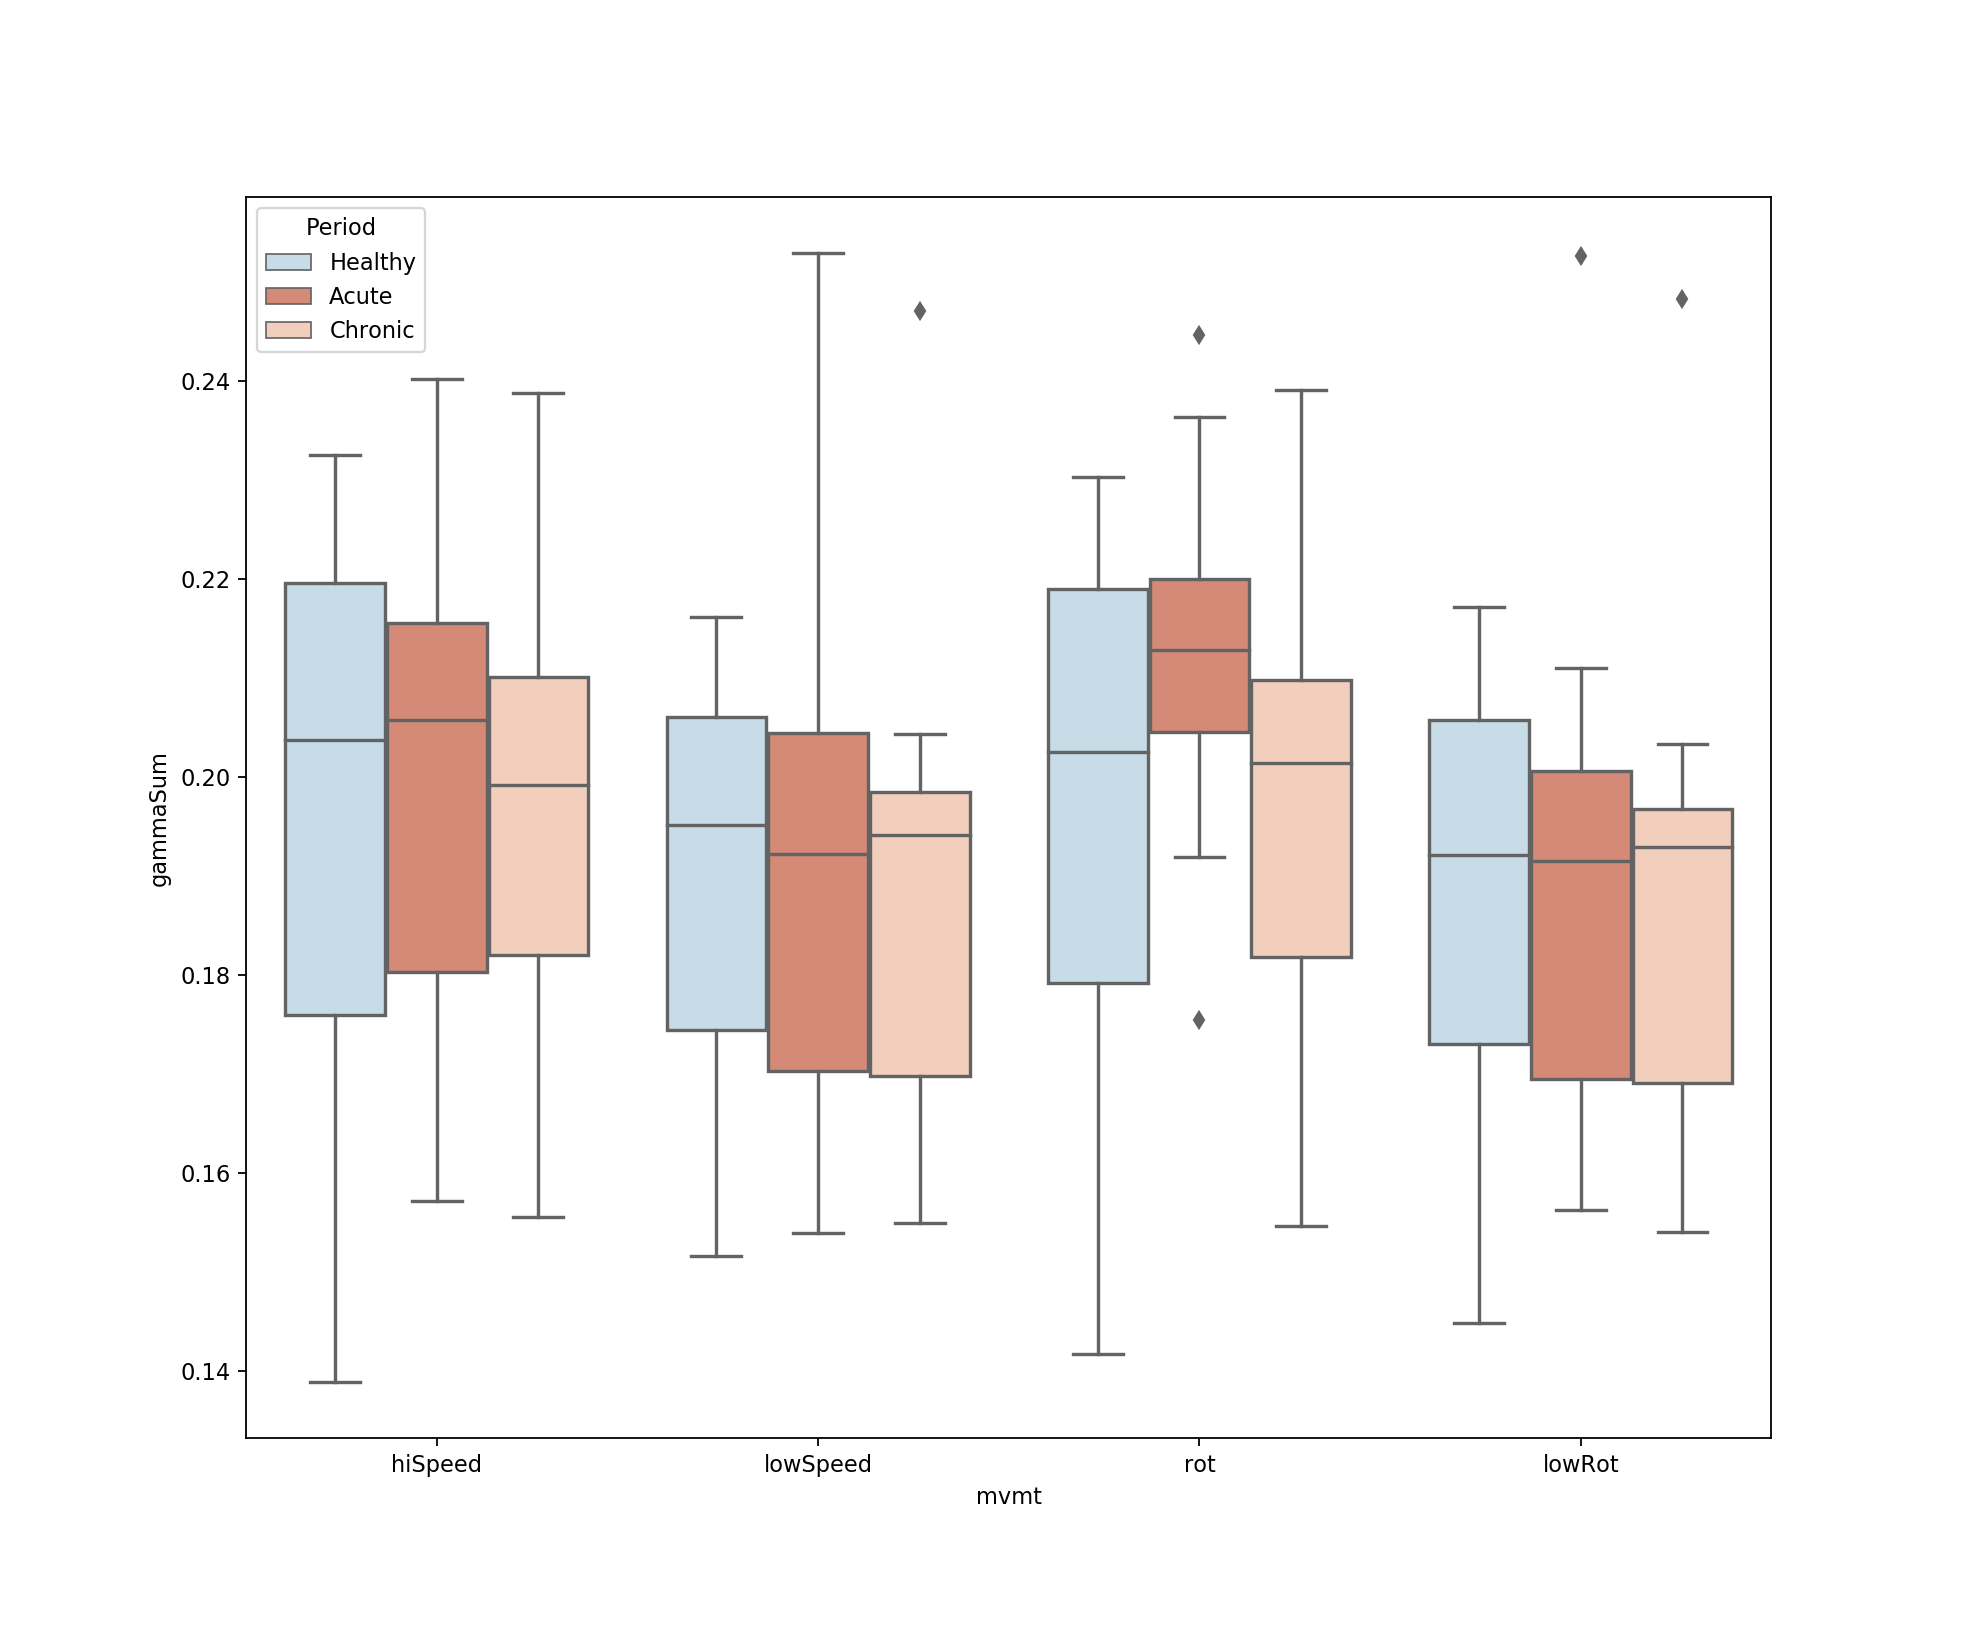

In [46]:
df = pd.read_csv(figFolder+'lfpForR.csv')
df2 = df.groupby(['Period','Mouse','mvmt']).mean()
df2 = df2.reset_index()
# print(df2)
# def difAplly(row,fr):
#     if row.mvmt in ['hiSpeed','lowSpeed']:
#         low = float(df2[(df2.Mouse == row.Mouse)&(df2.Period == row.Period)&(df2.mvmt == 'lowSpeed')][fr].item())
#     else:
#         low = float(df2[(df2.Mouse == row.Mouse)&(df2.Period == row.Period)&(df2.mvmt == 'lowRot')][fr].item())
        
#     val = float(row[fr])
#     if low==0:
#         return None
#     else: #base <0 and val >0:
#         return (val-low)

# df2['diff_beta'] = df2.apply(lambda row: difAplly(row,'betaSum'),axis=1) 
# df2['diff_gamma'] = df2.apply(lambda row: difAplly(row,'gammaSum'),axis=1)    
# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='Period',y='beta',ax = ax[0],data=df2[df2.mvmt=='all'],order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='Period',y='gamma',ax = ax[1],data=df2[df2.mvmt=='all'],order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_lfpfullSess_bar.svg',transparent=True,format='svg')

fig, ax = plt.subplots(1,1,figsize=(12.15,10.15))
with sns.color_palette(colorPallet3):
#     sns.boxplot(x='Period',hue = 'mvmt',y='betaSum',ax = ax[0],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
    sns.boxplot(x='mvmt',hue = 'Period',y='gammaSum',ax = ax,data=df2[df2.mvmt != 'all'],
                hue_order = ['Healthy','Acute','Chronic'],
               order = ['hiSpeed','lowSpeed','rot','lowRot'])
fig.savefig(figFolder+'figure5C_bar_gamma.svg',transparent=True,format='svg')

# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_beta',ax = ax[0],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_gamma',ax = ax[1],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_speed_bar_diff.svg',transparent=True,format='svg')


# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='betaSum',ax = ax[0],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='gammaSum',ax = ax[1],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_rot_bar.svg',transparent=True,format='svg')

# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_beta',ax = ax[0],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_gamma',ax = ax[1],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_rot_bar_diff.svg',transparent=True,format='svg')


In [73]:
df2

Period  Mouse      mvmt  Unnamed: 0      beta     gamma  highGamma  \
0    Day 1-13    761       all           0  0.019636  0.009762   0.005135   
1    Day 1-13    761   hiSpeed           0  0.017156  0.010805   0.005501   
2    Day 1-13    761    highAC           0  0.017352  0.010713   0.005412   
3    Day 1-13    761     highC           0  0.016430  0.010303   0.005585   
4    Day 1-13    761    lowRot           0  0.020161  0.009560   0.005062   
..        ...    ...       ...         ...       ...       ...        ...   
294   Healthy   8815    highAC           0  0.018932  0.009446   0.005666   
295   Healthy   8815     highC           0  0.019564  0.009827   0.005818   
296   Healthy   8815    lowRot           0  0.024179  0.008501   0.005318   
297   Healthy   8815  lowSpeed           0  0.024237  0.008496   0.005293   
298   Healthy   8815       rot           0  0.019440  0.009657   0.005798   

      betaSum  highGammaSum  gammaSum     ratio  ratio_High  
0    0.117819      0.154060  0.195249  2.014157    3.826576  
1    0.102934      0.165044  0.216105  1.593668    3.134049  
2    0.104115      0.162347  0.214267  1.623650    3.216152  
3    0.098582      0.167539  0.206068  1.602552    2.967795  
4    0.120963      0.151875  0.191209  2.110679    3.983397  
..        ...           ...       ...       ...         ...  
294  0.113591      0.169993  0.188917  2.003816    3.342034  
295  0.117381      0.174542  0.196545  2.000983    3.367354  
296  0.145073      0.159526  0.170027  2.845203    4.548960  
297  0.145424      0.158802  0.169927  2.854866    4.581251  
298  0.116637      0.173948  0.193132  2.018833    3.354726  

[299 rows x 12 columns]

In [10]:
# all, and no 4539
periods = {'Healthy':{'axis':0},'Acute':{'axis':1},'Chronic':{'axis':2}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periods.keys():
    for c in conds:
        periods[p][c] = np.zeros((87,1))
for sess in specs.keys():
    for c in conds:
        try:
            periods[specs[sess]['period']][c] = np.concatenate((periods[specs[sess]['period']][c],
                                                                   specs[sess][c].T),axis=1)
        except:
            print(sess,c)
            continue
for p in periods.keys():
    for c in conds:
        periods[p][c] = periods[p][c][:,1:]

0761_day31A highC
0761_day35L highC
0761_day35L hiSpeed
1208_day2 highC
1208_day30A highC
1208_day34L highC
1236_day15A highAC
1236_day19L highAC
1236_day30A highAC
2980_day19L highC
2981_day2 highAC
4539_day1 highAC
4539_day1 highC
4539_day10 highAC
4539_day10 highC
4539_day11 highAC
4539_day11 highC
4539_day12 highAC
4539_day12 highC
4539_day13 highAC
4539_day13 highC
4539_day14 highAC
4539_day14 highC
4539_day2 highAC
4539_day2 highC
4539_day3 highAC
4539_day3 highC
4539_day4 highAC
4539_day4 highC
4539_day5 highAC
4539_day5 highC
4539_day6 highAC
4539_day6 highC
4539_day7 highAC
4539_day7 highC
4539_day8 highAC
4539_day8 highC
4539_day9 highAC
4539_day9 highC
7584_day1 highAC
7584_day1 highC
7584_day10 highAC
7584_day10 highC
7584_day11 highAC
7584_day11 highC
7584_day12 highAC
7584_day12 highC
7584_day15 highAC
7584_day15 highC
7584_day2 highAC
7584_day2 highC
7584_day3 highAC
7584_day3 highC
7584_day4 highAC
7584_day4 highC
7584_day5 highAC
7584_day5 highC
7584_day6 highAC
7584_d

In [17]:
freq[f60]

array([], dtype=float64)

<IPython.core.display.Javascript object>


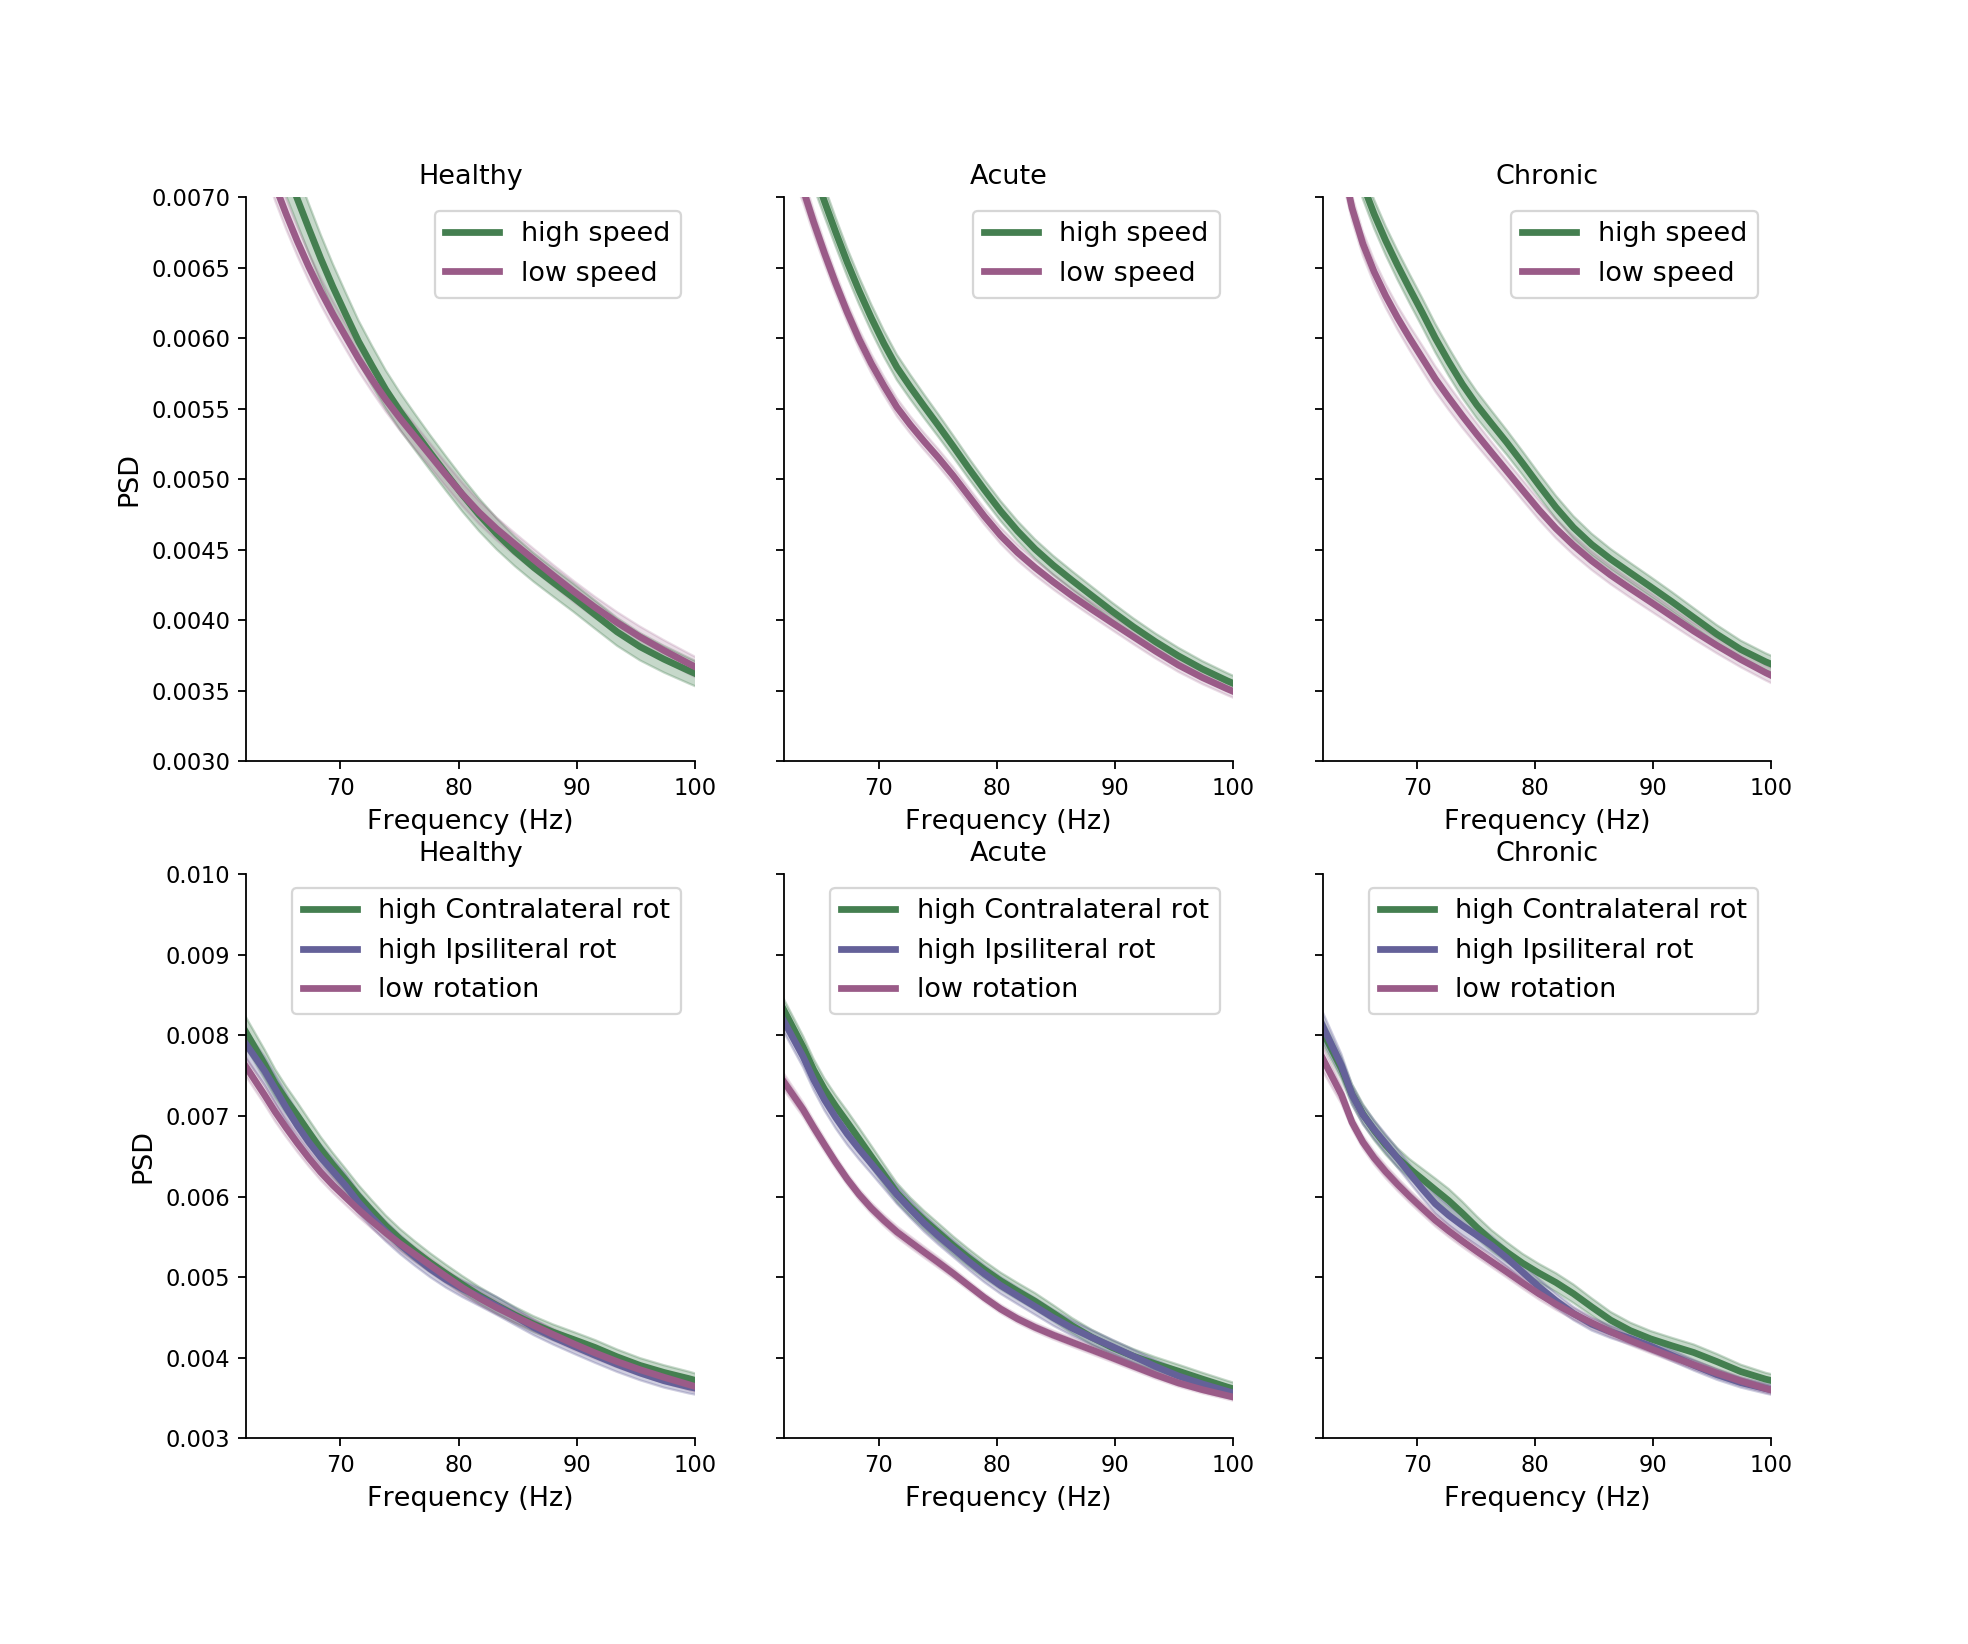

In [31]:
#periods = {'Healthy':{'axis':0},'Day 1-4':{'axis':1},'Day 5-12':{'axis':2},'Day 13-20':{'axis':3},'One Month':{'axis':4}}
%matplotlib notebook
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(2,3,figsize=(12.15,10.15),sharey='row')
f60 = (freq<=58) | (freq>=63)
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['hiSpeed'],axis=1) 
    hS2 = np.nanstd(periods[p]['hiSpeed'],axis=1)/np.sqrt(periods[p]['hiSpeed'].shape[1])   
    lC = np.nanmean(periods[p]['lowSpeed'],axis=1)
    lS2 = np.nanstd(periods[p]['lowSpeed'],axis=1)/np.sqrt(periods[p]['lowSpeed'].shape[1])
    hC = hC[f60]
    hS2=hS2[f60]
    lC = lC[f60]
    lS2 = lS2[f60]
       
    ax[0,ind].plot(freq[f60],hC,color = colorsH[4], label='high speed',linewidth=3.0)
    ax[0,ind].fill_between(freq[f60], hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
    ax[0,ind].plot(freq[f60],lC,color = colorsL[4], label='low speed',linewidth=3.0)
    ax[0,ind].fill_between(freq[f60], lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
    ax[0,ind].set_xlim(6,100)
#     ax[0,ind].set_yscale('log')
    ax[0,ind].set_title(p)
#    ax[0,ind].set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[0,0].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[0,ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[0,ind].spines['right'].set_visible(False)
    ax[0,ind].spines['top'].set_visible(False)
    ax[0,ind].legend(fontsize=12)
    
    hC = np.nanmean(periods[p]['highC'],axis=1)
    hS2 = np.nanstd(periods[p]['highC'],axis=1)/np.sqrt(periods[p]['highC'].shape[1])
    hAC = np.nanmean(periods[p]['highAC'],axis=1)
    hS2A = np.nanstd(periods[p]['highAC'],axis=1)/np.sqrt(periods[p]['highAC'].shape[1])
    lC = np.nanmean(periods[p]['lowRot'],axis=1)
    lS2 = np.nanstd(periods[p]['lowRot'],axis=1)/np.sqrt(periods[p]['lowRot'].shape[1])
    hC = hC[f60]
    hS2=hS2[f60]
    hAC = hAC[f60]
    hS2A=hS2A[f60]
    lC = lC[f60]
    lS2 = lS2[f60]

       
    ax[1,ind].plot(freq[f60],hC,color = colorsH[4], label='high Contralateral rot',linewidth=3.0)
    ax[1,ind].fill_between(freq[f60], hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
    ax[1,ind].plot(freq[f60],hAC,color = colorsH2[4], label='high Ipsiliteral rot',linewidth=3.0)
    ax[1,ind].fill_between(freq[f60], hAC-hS2A, hAC+hS2A,color=colorsH2[4],alpha=0.3)
    ax[1,ind].plot(freq[f60],lC,color = colorsL[4], label='low rotation',linewidth=3.0)
    ax[1,ind].fill_between(freq[f60], lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
    ax[1,ind].set_xlim(6,100)
#     ax[1,ind].set_yscale('log')
    ax[1,ind].set_title(p)
#    ax[0,ind].set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[1,0].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[1,ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[1,ind].spines['right'].set_visible(False)
    ax[1,ind].spines['top'].set_visible(False)
    ax[1,ind].legend(fontsize=12)
fig.savefig(figFolder+'lfpSpectromPeriod.png',transparent=True,format='png')
fig.savefig(figFolder+'figure5_lfpSpectromPeriod.svg',transparent=True,format='svg')

# fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')
for ind, p in enumerate(periods.keys()):
    ax[0,ind].set_xlim(9,17)
    ax[0,ind].set_ylim(0.015,0.03)
    ax[1,ind].set_xlim(9,17)
    ax[1,ind].set_ylim(0.015,0.03)
#     ax[0,ind].set_ylim(0,0.032)
#     ax[1,ind].set_ylim(0,0.032)
#fig.savefig(figFolder+'lfpSpectromPeriodZoomBeta.png',transparent=True,format='png')
fig.savefig(figFolder+'figure5_ZoomBeta.svg',transparent=True,format='svg')
for ind, p in enumerate(periods.keys()):
    ax[0,ind].set_xlim(40,60)
    ax[0,ind].set_ylim(0.008,0.012)
    ax[1,ind].set_xlim(40,60)
    ax[1,ind].set_ylim(0.008,0.012)
#     ax[0,ind].set_ylim(0,0.02)
#     ax[1,ind].set_ylim(0,0.02)
fig.savefig(figFolder+'lfpSpectromPeriodZoomGamma.svg',transparent=True,format='svg')
# fig.savefig(figFolder+'figure5_lfpZoomGamma_log.svg',transparent=True,format='svg')
for ind, p in enumerate(periods.keys()):
#     ax[0,ind].set_yscale('log')
#     ax[1,ind].set_yscale('log')
    ax[0,ind].set_xlim(62,100)
    ax[1,ind].set_xlim(62,100)
    ax[0,ind].set_ylim(0.003,0.007)
    ax[1,ind].set_ylim(0.003,0.01)
fig.savefig(figFolder+'lfpSpectromPeriodZoomHighGamma.svg',transparent=True,format='svg')



In [53]:
f.close()

AttributeError: 'numpy.ndarray' object has no attribute 'close'

In [51]:
intF

array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  55.,  56.,  57.,  59.,
        60.,  61.,  63.,  65.,  67.,  68.,  70.,  72.,  75.,  77.,  79.,
        82.,  85.,  88.,  91.,  95.,  99., 103., 107., 112., 118., 123.,
       130., 137., 145., 154., 165., 177., 190., 206.])

In [52]:
minS = 45
maxS = 950
waveletName = 'cmor14.0-1.5'
f = np.empty((maxS-minS,1))
for j in range(minS,maxS):
    f[j-minS]=pywt.scale2frequency(waveletName , j)*3051.7578125
[intF,inds] = np.unique(np.floor(f),return_index=True)
print(f[inds].T)

[[  4.99742      5.99952388   6.99944452   7.9888948    8.99339237
    9.99484     10.97754609  11.9833422   12.9678094   13.99888905
   14.95959712  15.94995372  16.95421007  17.95151654  18.99434323
   19.98967999  20.99833357  21.90256803  22.88818359  23.96668439
   24.87846043  25.86235434  26.92727482  27.91241902  28.9723843
   29.91919424  30.92997783  31.78914388  32.93263826  33.90842014
   34.94379175  35.76278687  36.91642515  37.83170842  38.79353151
   39.80553668  40.87175642  41.99666714  42.78165158  43.59654018
   44.87879136  45.77636719  46.71057876  47.68371582  48.69826297
   49.75692086  50.86263021  51.43412044  52.61651401  53.85454963
   54.49567522  55.82483803  56.51403356  57.94476859  58.68765024
   59.44982752  60.23206209  61.85995566  62.70735231  63.57828776
   64.4737566   65.39481027  66.34256114  67.31818704  68.3229361
   69.3581321   70.42518029  71.52557373  72.6609003   73.8328503
   75.0432249   76.29394531  77.58706303  78.92477101  80.3094161

<IPython.core.display.Javascript object>


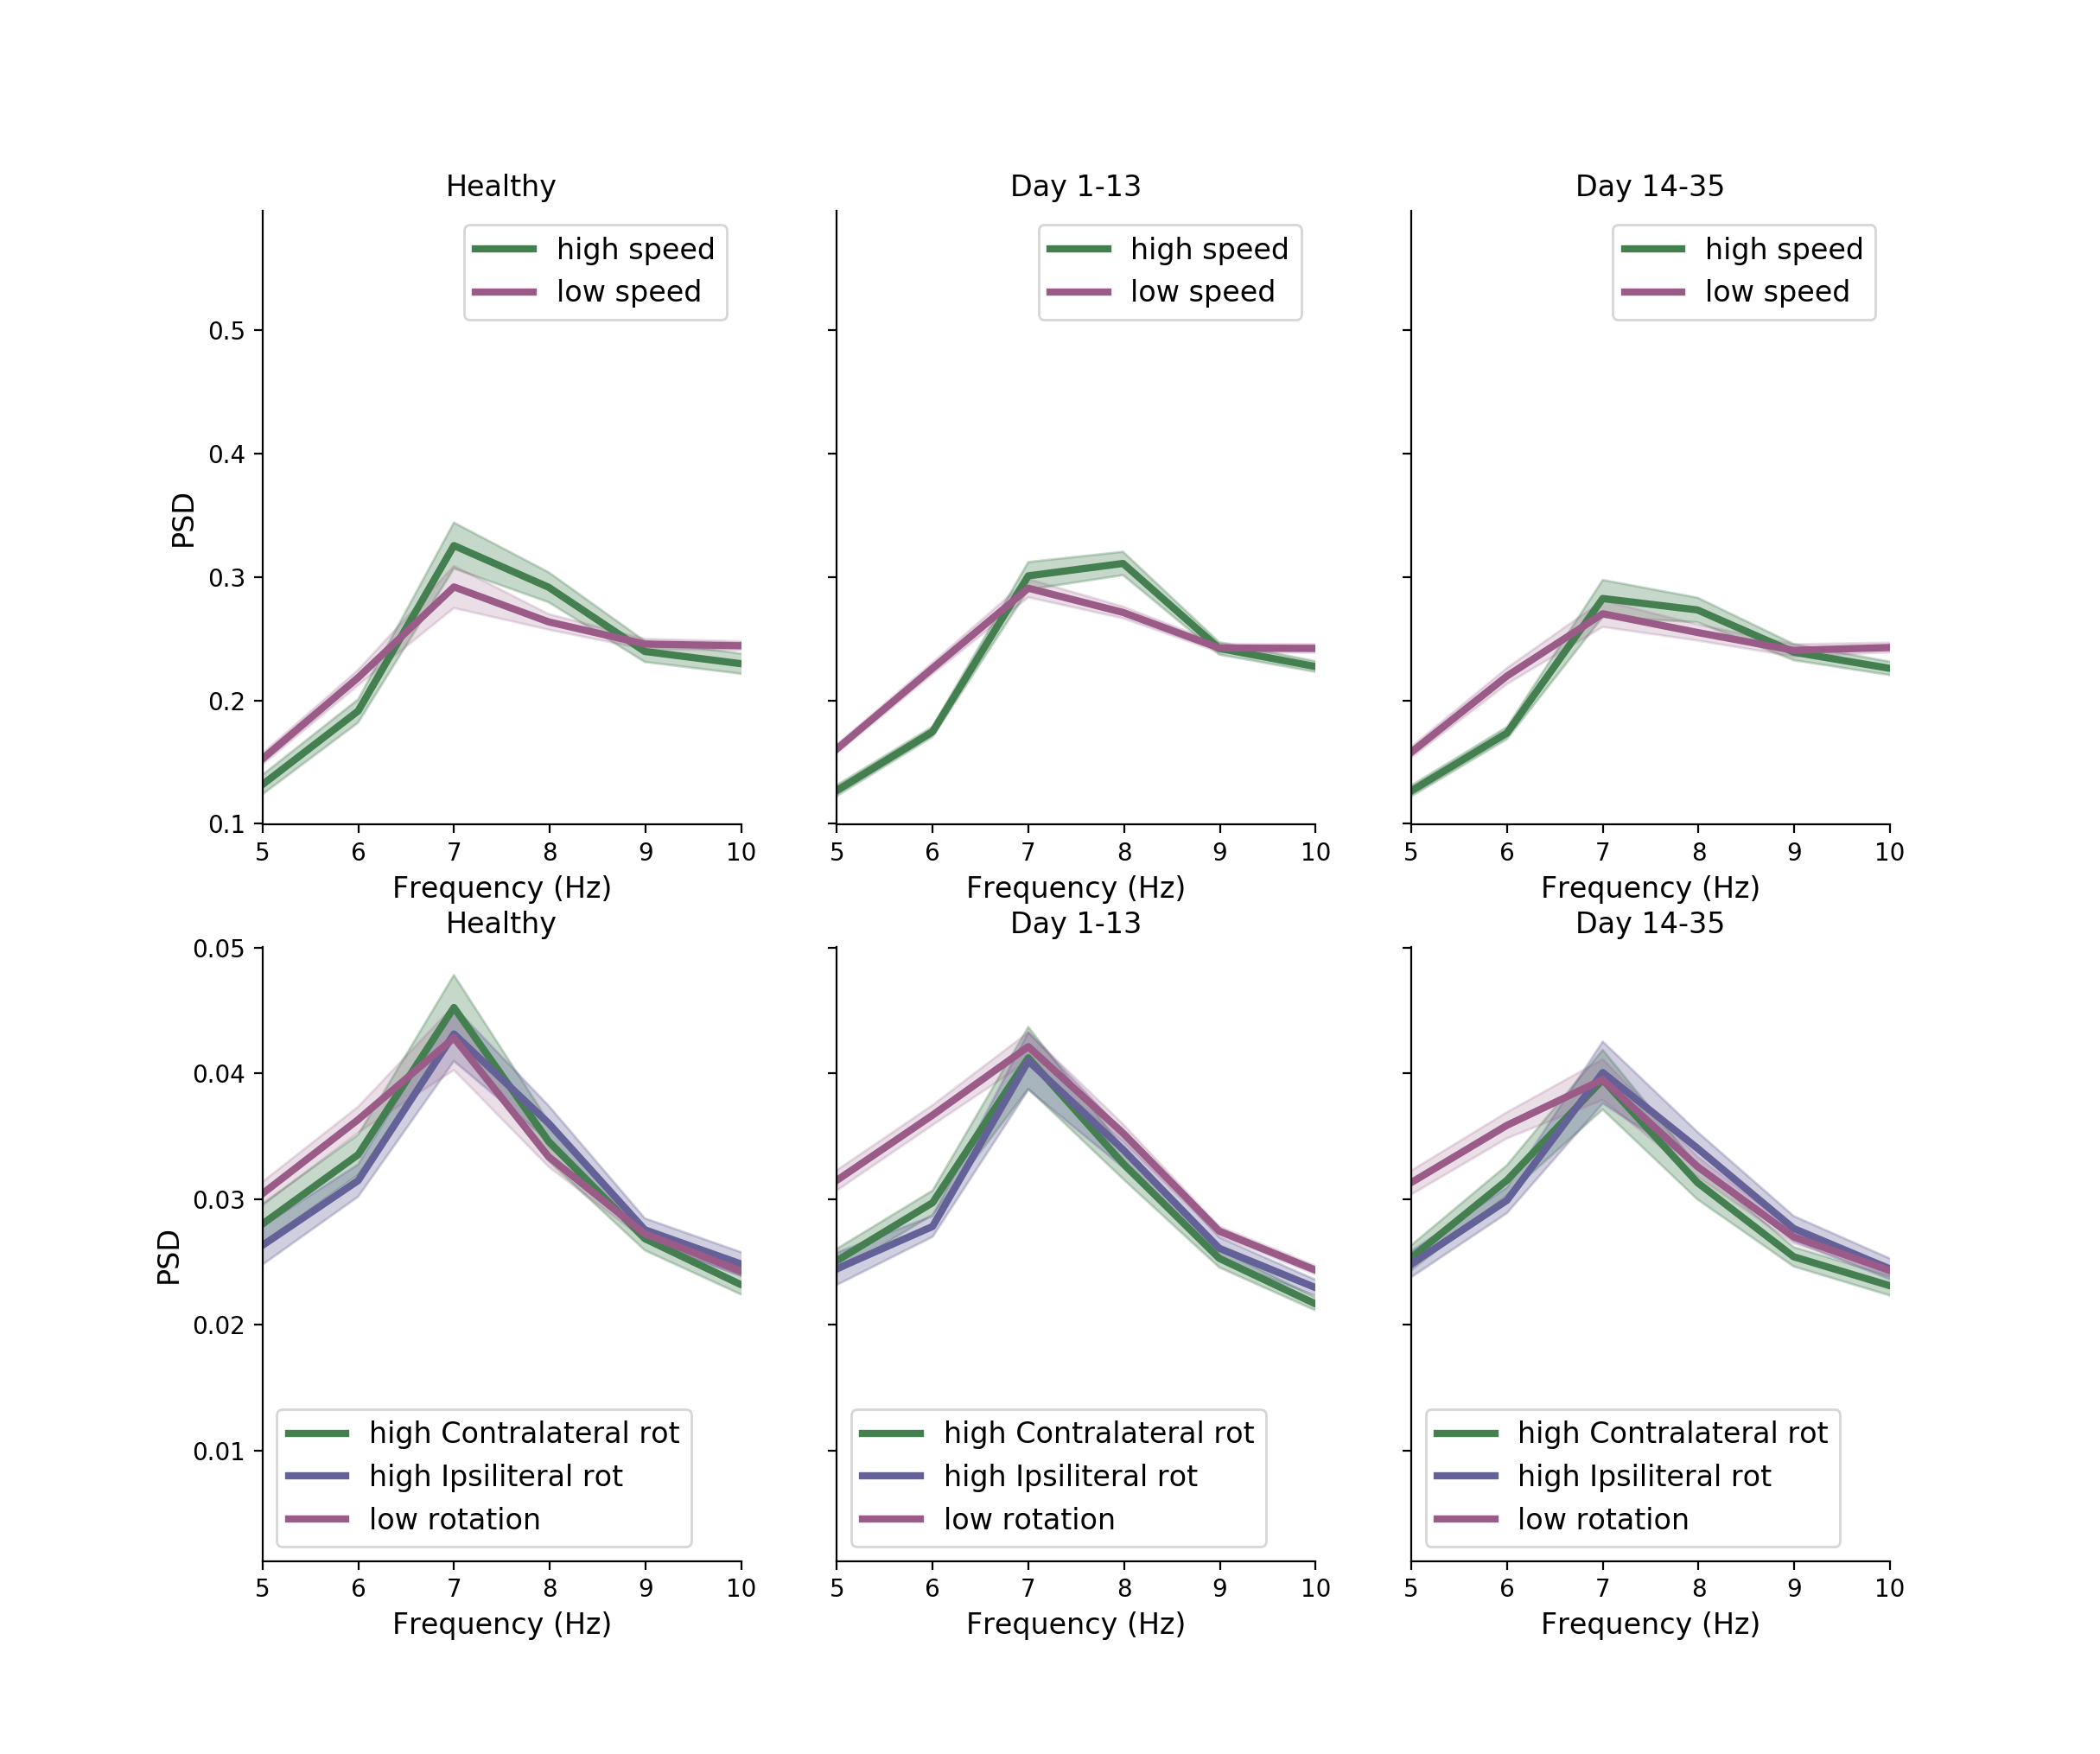

In [103]:
#periods = {'Healthy':{'axis':0},'Day 1-4':{'axis':1},'Day 5-12':{'axis':2},'Day 13-20':{'axis':3},'One Month':{'axis':4}}

colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(2,3,figsize=(12.15,10.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['hiSpeed'],axis=1) *freq
    hS2 = np.nanstd(periods[p]['hiSpeed'],axis=1)/np.sqrt(periods[p]['hiSpeed'].shape[1])
    hS2 = hS2*freq
    lC = np.nanmean(periods[p]['lowSpeed'],axis=1)*freq
    lS2 = np.nanstd(periods[p]['lowSpeed'],axis=1)/np.sqrt(periods[p]['lowSpeed'].shape[1])
    lS2 = lS2*freq   
        
    ax[0,ind].plot(freq,hC,color = colorsH[4], label='high speed',linewidth=3.0)
    ax[0,ind].fill_between(freq, hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
    ax[0,ind].plot(freq,lC,color = colorsL[4], label='low speed',linewidth=3.0)
    ax[0,ind].fill_between(freq, lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
    ax[0,ind].set_xlim(6,100)
#     ax[0,ind].set_yscale('log')
    ax[0,ind].set_title(p)
#    ax[0,ind].set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[0,0].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[0,ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[0,ind].spines['right'].set_visible(False)
    ax[0,ind].spines['top'].set_visible(False)
    ax[0,ind].legend(fontsize=12)
    
    hC = np.nanmean(periods[p]['highC'],axis=1)
    hS2 = np.nanstd(periods[p]['highC'],axis=1)/np.sqrt(periods[p]['highC'].shape[1])
    hAC = np.nanmean(periods[p]['highAC'],axis=1)
    hS2A = np.nanstd(periods[p]['highAC'],axis=1)/np.sqrt(periods[p]['highAC'].shape[1])
    lC = np.nanmean(periods[p]['lowRot'],axis=1)
    lS2 = np.nanstd(periods[p]['lowRot'],axis=1)/np.sqrt(periods[p]['lowRot'].shape[1])
       
    ax[1,ind].plot(freq,hC,color = colorsH[4], label='high Contralateral rot',linewidth=3.0)
    ax[1,ind].fill_between(freq, hC-hS2, hC+hS2,color=colorsH[4],alpha=0.3)
    ax[1,ind].plot(freq,hAC,color = colorsH2[4], label='high Ipsiliteral rot',linewidth=3.0)
    ax[1,ind].fill_between(freq, hAC-hS2A, hAC+hS2A,color=colorsH2[4],alpha=0.3)
    ax[1,ind].plot(freq,lC,color = colorsL[4], label='low rotation',linewidth=3.0)
    ax[1,ind].fill_between(freq, lC-lS2, lC+lS2,color=colorsL[4],alpha=0.2)
    ax[1,ind].set_xlim(6,100)
#     ax[1,ind].set_yscale('log')
    ax[1,ind].set_title(p)
#    ax[0,ind].set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax[1,0].set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax[1,ind].set_xlabel('Frequency (Hz)',fontsize=12)
    ax[1,ind].spines['right'].set_visible(False)
    ax[1,ind].spines['top'].set_visible(False)
    ax[1,ind].legend(fontsize=12)
#fig.savefig(figFolder+'lfpSpectromPeriod.png',transparent=True,format='png')
fig.savefig(figFolder+'figure5_lfpSpectromPeriod_log2.svg',transparent=True,format='svg')

#fig2, ax2 = plt.subplots(1,2,sharex='col',sharey='row')
for ind, p in enumerate(periods.keys()):
    ax[0,ind].set_xlim(9,20)
    ax[1,ind].set_xlim(9,20)
#     ax[0,ind].set_ylim(0,0.032)
#     ax[1,ind].set_ylim(0,0.032)
#fig.savefig(figFolder+'lfpSpectromPeriodZoomBeta.png',transparent=True,format='png')
fig.savefig(figFolder+'figure5_ZoomBeta_log2.svg',transparent=True,format='svg')
for ind, p in enumerate(periods.keys()):
    ax[0,ind].set_xlim(40,60)
    ax[1,ind].set_xlim(40,60)
#     ax[0,ind].set_ylim(0,0.02)
#     ax[1,ind].set_ylim(0,0.02)
fig.savefig(figFolder+'lfpSpectromPeriodZoomGamma_log2.svg',transparent=True,format='svg')
# fig.savefig(figFolder+'figure5_lfpZoomGamma_log.svg',transparent=True,format='svg')
for ind, p in enumerate(periods.keys()):
    ax[0,ind].set_xlim(5,10)
    ax[1,ind].set_xlim(5,10)
#     ax[0,ind].set_ylim(0.03,0.05)
#     ax[1,ind].set_ylim(0.03,0.05)
fig.savefig(figFolder+'lfpSpectromPeriodZoomTheta_log2.svg',transparent=True,format='svg')



In [265]:
df = df_normlizeBytotPower_mean
# df
# df.groupby(['mouse','period'])
periods = {'Healthy':{'axis':0},'Day 1-13':{'axis':1},'Day 14-35':{'axis':2}}
conds = ['highAC','highC','lowRot','lowSpeed','hiSpeed','all']

for p in periods.keys():
    for c in conds:
        periods[p][c] = np.zeros((87,1))
    for m in df[df.period == p].mouse.unique():
        for c in conds:
            try:
                te = np.array(df[(df.period == p)&(df.mouse == m)][c].tolist())
#                 print(te.shape)
                periods[p][c] = np.concatenate((periods[p][c],np.nanmean(te,axis=0).T),axis=1)                         
            except:
                print(m,c,p,te.shape)
                continue
for p in periods.keys():
    for c in conds:
        periods[p][c] = periods[p][c][:,1:]




# for m in df[df.period == p].mouse.unique():


8803 highAC Healthy (3,)
1208 highC Day 1-13 (5,)
2981 highAC Day 1-13 (6,)
4539 highAC Day 1-13 (12,)
4539 highC Day 1-13 (12,)
7584 highAC Day 1-13 (12,)
7584 highC Day 1-13 (12,)
7909 highAC Day 1-13 (12,)
7909 highC Day 1-13 (12,)
7909 hiSpeed Day 1-13 (12,)
0761 highC Day 14-35 (4,)
0761 hiSpeed Day 14-35 (4,)
1208 highC Day 14-35 (5,)
1236 highAC Day 14-35 (5,)
2980 highC Day 14-35 (5,)
4539 highAC Day 14-35 (4,)
4539 highC Day 14-35 (4,)
7584 highAC Day 14-35 (2,)
7584 highC Day 14-35 (2,)
7909 highAC Day 14-35 (4,)
7909 highC Day 14-35 (4,)
8803 highC Day 14-35 (4,)


/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


In [270]:
# df = pd.DataFrame(specs)
# df = df.T
# df.to_csv('specs_test.csv',sep='\t')
# df = pd.read_csv('specs_test.csv',sep='\t')
# df[(df.period == p)&(df.mouse == m)][c].tolist()
# df
# df.reset_index(inplace=True)
# df = df.rename(columns = {'index':'Sess'})
df
# df_normlizeBytotPower_mean

level_0            Sess mouse day     period  \
0          0  0761_BaselineA  0761   0    Healthy   
1          1  0761_BaselineL  0761   0    Healthy   
2          2  0761_BaselineS  0761   0    Healthy   
3          3       0761_day1  0761   1   Day 1-13   
4          4      0761_day10  0761  10   Day 1-13   
..       ...             ...   ...  ..        ...   
205      205       8815_day2  8815   2   Day 1-13   
206      206     8815_day30A  8815  30  Day 14-35   
207      207     8815_day34L  8815  34  Day 14-35   
208      208       8815_day4  8815   4   Day 1-13   
209      209       8815_day8  8815   8   Day 1-13   

                                                   all  \
0    [[1.4426495615136443e-08, 2.1124939100198544e-...   
1    [[1.492286666905756e-08, 2.2416546639760536e-0...   
2    [[1.3656937514671025e-08, 2.168675939335668e-0...   
3    [[1.5892699967524203e-08, 2.3220656472208033e-...   
4    [[1.717900656459076e-08, 2.366963184335589e-08...   
..                                                 ...   
205  [[1.62213169108422e-08, 2.0020350156570357e-08...   
206  [[1.64756844434301e-08, 2.0754785303199163e-08...   
207  [[1.7765964627949133e-08, 1.8958132472566834e-...   
208  [[2.0155516635574203e-08, 2.144914097003242e-0...   
209  [[1.546469321580372e-08, 1.9387105426096106e-0...   

                                                highAC  \
0    [[9.378745448234249e-09, 1.4926743799301525e-0...   
1    [[1.024429502243396e-08, 1.781657328074817e-08...   
2    [[1.0610801884673484e-08, 1.8600864800179967e-...   
3    [[1.038699829380482e-08, 1.9556827913363606e-0...   
4    [[1.2024733768988032e-08, 1.7503349245339103e-...   
..                                                 ...   
205  [[1.8076277395818183e-08, 1.85308240208524e-08...   
206  [[2.5232697950706148e-08, 3.05281151927627e-08...   
207  [[2.163134152530443e-08, 2.3465637090346274e-0...   
208  [[1.2719371845830454e-08, 1.723294929326916e-0...   
209  [[1.5154682859694628e-08, 1.783972887969358e-0...   

                                                 highC  \
0    [[1.2444085024813024e-08, 1.8359855251653456e-...   
1    [[1.1784285250730477e-08, 2.0935638403456755e-...   
2    [[1.2059476832761868e-08, 2.0723985009255912e-...   
3    [[1.562016803166138e-08, 2.2552514841788094e-0...   
4    [[1.689105522230911e-08, 1.9983112251469507e-0...   
..                                                 ...   
205  [[8.655632701059812e-09, 1.5884214671811914e-0...   
206  [[1.0254835240410475e-08, 2.320856505366938e-0...   
207  [[1.5860576579726243e-08, 1.683520963127398e-0...   
208  [[1.1585472829511827e-08, 2.1851142874707142e-...   
209  [[1.2612659144857507e-08, 1.7151380816453795e-...   

                                                lowRot  \
0    [[1.5599935628087007e-08, 2.2860448886016287e-...   
1    [[1.659305241332257e-08, 2.3809579319668124e-0...   
2    [[1.586695727019474e-08, 2.2281296176059475e-0...   
3    [[1.769627692944022e-08, 2.426648500852731e-08...   
4    [[1.8581395335703608e-08, 2.4705797327675617e-...   
..                                                 ...   
205  [[1.7300038214812467e-08, 2.1374047580419714e-...   
206  [[1.4988355620263866e-08, 2.023453205375544e-0...   
207  [[1.5878485543247758e-08, 1.77519484049544e-08...   
208  [[2.195815582079985e-08, 2.1971876274829587e-0...   
209  [[1.671725523282019e-08, 1.9673164401178553e-0...   

                                              lowSpeed  \
0    [[1.545156511090363e-08, 2.278871348399506e-08...   
1    [[1.6636737463096723e-08, 2.454974290466495e-0...   
2    [[1.5455016827973234e-08, 2.2959543591860515e-...   
3    [[1.768384799946774e-08, 2.473873063348961e-08...   
4    [[1.8401096893763214e-08, 2.499380419895904e-0...   
..                                                 ...   
205  [[1.68139791176056e-08, 2.088245889448433e-08,...   
206  [[1.4276598827063881e-08, 1.9756262607047552e-...   
207  [[1.3852152466193277e-08, 1.6931926325542408e-...   


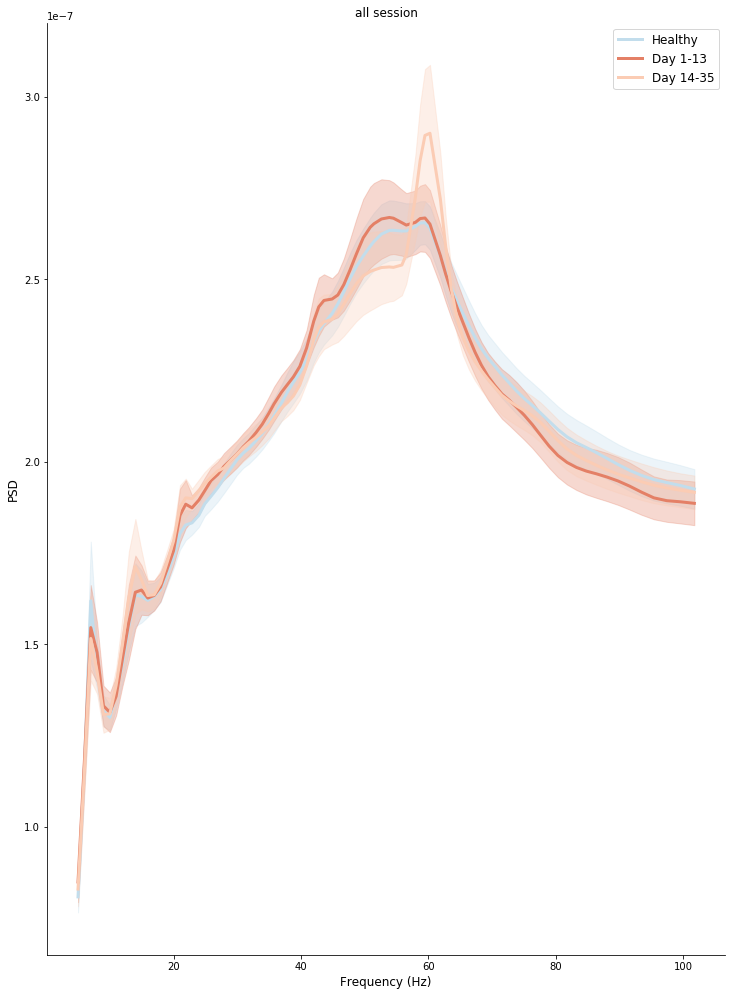

In [322]:
%matplotlib inline
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,1,figsize=(12.15,17.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['lowRot'],axis=1)*freq
    hS2 = np.nanstd(periods[p]['lowRot'],axis=1)*freq/np.sqrt(periods[p]['all'].shape[1])
       
    ax.plot(freq,hC,color = colorsH[ind], label=p,linewidth=3.0)
    ax.fill_between(freq, hC-hS2, hC+hS2,color=colorsH[ind],alpha=0.3)
#     ax.set_xlim(6,100)
    ax.set_title('all session')
#     ax.set_xlim(60,100)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax.set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax.set_xlabel('Frequency (Hz)',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(fontsize=12)
fig.savefig(figFolder+'lfpSpectromPeriodtotPower_all.svg',transparent=True,format='svg')
# ax.set_xlim(10,30)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess_zoomBeta.svg',transparent=True,format='svg')



In [222]:
np.mean(Hs2,axis = 0)

array([5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
       5.50723568e-07, 5.50723568e-07, 5.50723568e-07, 5.50723568e-07,
      

In [279]:
colorsL = sns.cubehelix_palette(8)
colorsH = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

beta = (freq>10)&(freq<16)
gamma =(freq>40)&(freq<60)
highGamma = (freq>60)&(freq<100)
highGamma2 = (freq>80)&(freq<100)

# print(periods[p]['hiSpeed'].shape,np.nanmean(periods[p]['hiSpeed'][beta],axis=0).shape)
df2 = pd.DataFrame(columns = ['Period','Mouse','sess','mvmt','beta','gamma'])
# # fig, ax = plt.subplots(2,3,figsize=(12.15,17.15),sharey='row')
for row in range(len(df)):
    for mv in ['highAC', 'highC', 'lowRot', 'lowSpeed', 'hiSpeed','all']:
        try:
            te = np.array(df.iloc[row][mv])
            df3 = pd.DataFrame({'Period':df.iloc[row]['period'],'Mouse':df.iloc[row]['mouse'],'mvmt':mv,'sess':df.iloc[row]['Sess'],
                                'beta':np.nanmean(te[0,beta],axis=0),
                               'gamma':np.nanmean(te[0,gamma],axis=0),
                               'highGamma':np.nanmean(te[0,highGamma],axis=0),
                                'highGamma2':np.nanmean(te[0,highGamma2],axis=0),
                               'betaSum':np.nansum(te[0,beta],axis=0),
                               'highGammaSum':np.nansum(te[0,highGamma],axis=0),
                                'highGammaSum2':np.nansum(te[0,highGamma2],axis=0),
                               'gammaSum':np.nansum(te[0,gamma],axis=0)},index=[0])
            df2 = pd.concat([df3,df2])
        except: 
            print(df.iloc[row]['Sess'],mv)

df2['ratio'] = df2.apply(lambda x: x.beta/x.gamma, axis = 1)
df2['ratio_High'] = df2.apply(lambda x: x.beta/x.highGamma, axis = 1)
# df['diff'] = 
df2.to_csv(figFolder+'lfpForR_nortot.csv')
df2.head()

0761_day31A highC
0761_day35L highC
0761_day35L hiSpeed
1208_day2 highC
1208_day30A highC
1208_day34L highC
1236_day15A highAC
1236_day19L highAC
1236_day30A highAC
2980_day19L highC
2981_day2 highAC
4539_day1 highAC
4539_day1 highC
4539_day10 highAC
4539_day10 highC
4539_day11 highAC
4539_day11 highC
4539_day12 highAC
4539_day12 highC
4539_day13 highAC
4539_day13 highC
4539_day14 highAC
4539_day14 highC
4539_day2 highAC
4539_day2 highC
4539_day3 highAC
4539_day3 highC
4539_day4 highAC
4539_day4 highC
4539_day5 highAC
4539_day5 highC
4539_day6 highAC
4539_day6 highC
4539_day7 highAC
4539_day7 highC
4539_day8 highAC
4539_day8 highC
4539_day9 highAC
4539_day9 highC
7584_day1 highAC
7584_day1 highC
7584_day10 highAC
7584_day10 highC
7584_day11 highAC
7584_day11 highC
7584_day12 highAC
7584_day12 highC
7584_day15 highAC
7584_day15 highC
7584_day2 highAC
7584_day2 highC
7584_day3 highAC
7584_day3 highC
7584_day4 highAC
7584_day4 highC
7584_day5 highAC
7584_day5 highC
7584_day6 highAC
7584_d

Period Mouse      mvmt       sess          beta         gamma  \
0  Day 1-13  8815       all  8815_day8  1.229846e-08  4.697582e-09   
0  Day 1-13  8815   hiSpeed  8815_day8  1.186614e-08  4.913211e-09   
0  Day 1-13  8815  lowSpeed  8815_day8  1.295522e-08  4.487006e-09   
0  Day 1-13  8815    lowRot  8815_day8  1.301569e-08  4.477057e-09   
0  Day 1-13  8815     highC  8815_day8  1.067517e-08  4.966298e-09   

      highGamma    highGamma2       betaSum  highGammaSum  highGammaSum2  \
0  2.833990e-09  2.310998e-09  7.379075e-08  8.501969e-08   2.773198e-08   
0  3.121673e-09  2.614530e-09  7.119683e-08  9.365020e-08   3.137436e-08   
0  2.582686e-09  2.055813e-09  7.773130e-08  7.748058e-08   2.466975e-08   
0  2.604193e-09  2.071137e-09  7.809412e-08  7.812580e-08   2.485364e-08   
0  3.098046e-09  2.550655e-09  6.405102e-08  9.294138e-08   3.060786e-08   

       gammaSum     ratio  ratio_High  
0  9.395164e-08  2.618040    4.339627  
0  9.826422e-08  2.415149    3.801211  
0  8.974013e-08  2.887274    5.016180  
0  8.954115e-08  2.907197    4.997973  
0  9.932597e-08  2.149523    3.445775

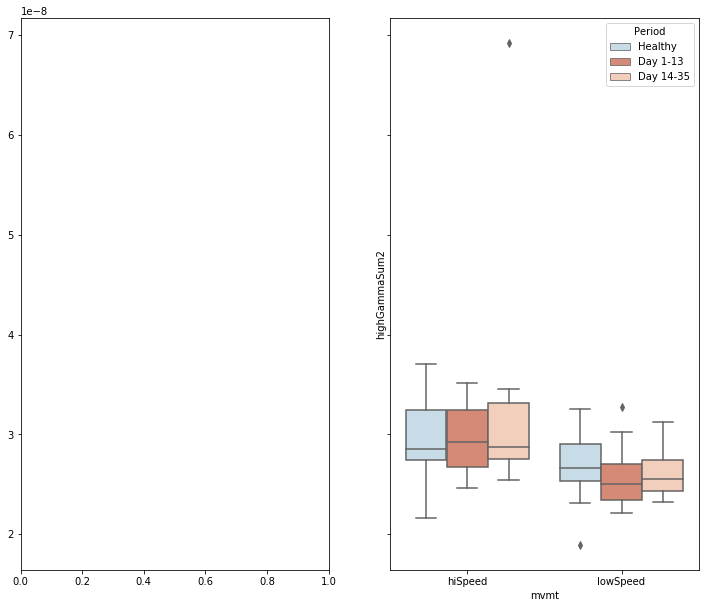

In [281]:
df = pd.read_csv(figFolder+'lfpForR_nortot.csv')
df2 = df.groupby(['Period','Mouse','mvmt']).mean()
df2 = df2.reset_index()
# print(df2)
# def difAplly(row,fr):
#     if row.mvmt in ['hiSpeed','lowSpeed']:
#         low = float(df2[(df2.Mouse == row.Mouse)&(df2.Period == row.Period)&(df2.mvmt == 'lowSpeed')][fr].item())
#     else:
#         low = float(df2[(df2.Mouse == row.Mouse)&(df2.Period == row.Period)&(df2.mvmt == 'lowRot')][fr].item())
        
#     val = float(row[fr])
#     if low==0:
#         return None
#     else: #base <0 and val >0:
#         return (val-low)

# df2['diff_beta'] = df2.apply(lambda row: difAplly(row,'betaSum'),axis=1) 
# df2['diff_gamma'] = df2.apply(lambda row: difAplly(row,'gammaSum'),axis=1)    
# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='Period',y='beta',ax = ax[0],data=df2[df2.mvmt=='all'],order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='Period',y='gamma',ax = ax[1],data=df2[df2.mvmt=='all'],order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_lfpfullSess_bar.svg',transparent=True,format='svg')

fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
with sns.color_palette(colorPallet3):
#     sns.boxplot(x='Period',hue = 'mvmt',y='betaSum',ax = ax[0],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
    sns.boxplot(x='mvmt',hue = 'Period',y='highGammaSum2',ax = ax[1],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_speed_bar.svg',transparent=True,format='svg')

# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_beta',ax = ax[0],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_gamma',ax = ax[1],data=df2[df2.mvmt.isin(['hiSpeed','lowSpeed'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_speed_bar_diff.svg',transparent=True,format='svg')


# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='betaSum',ax = ax[0],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='gammaSum',ax = ax[1],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_rot_bar.svg',transparent=True,format='svg')

# fig, ax = fig, ax = plt.subplots(1,2,figsize=(12.15,10.15),sharey='row')
# with sns.color_palette(colorPallet3):
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_beta',ax = ax[0],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
#     sns.boxplot(x='mvmt',hue = 'Period',y='diff_gamma',ax = ax[1],data=df2[df2.mvmt.isin(['lowRot','highAC','highC'])],hue_order = ['Healthy','Day 1-13','Day 14-35'])
# fig.savefig(figFolder+'figure5_rot_bar_diff.svg',transparent=True,format='svg')


<IPython.core.display.Javascript object>


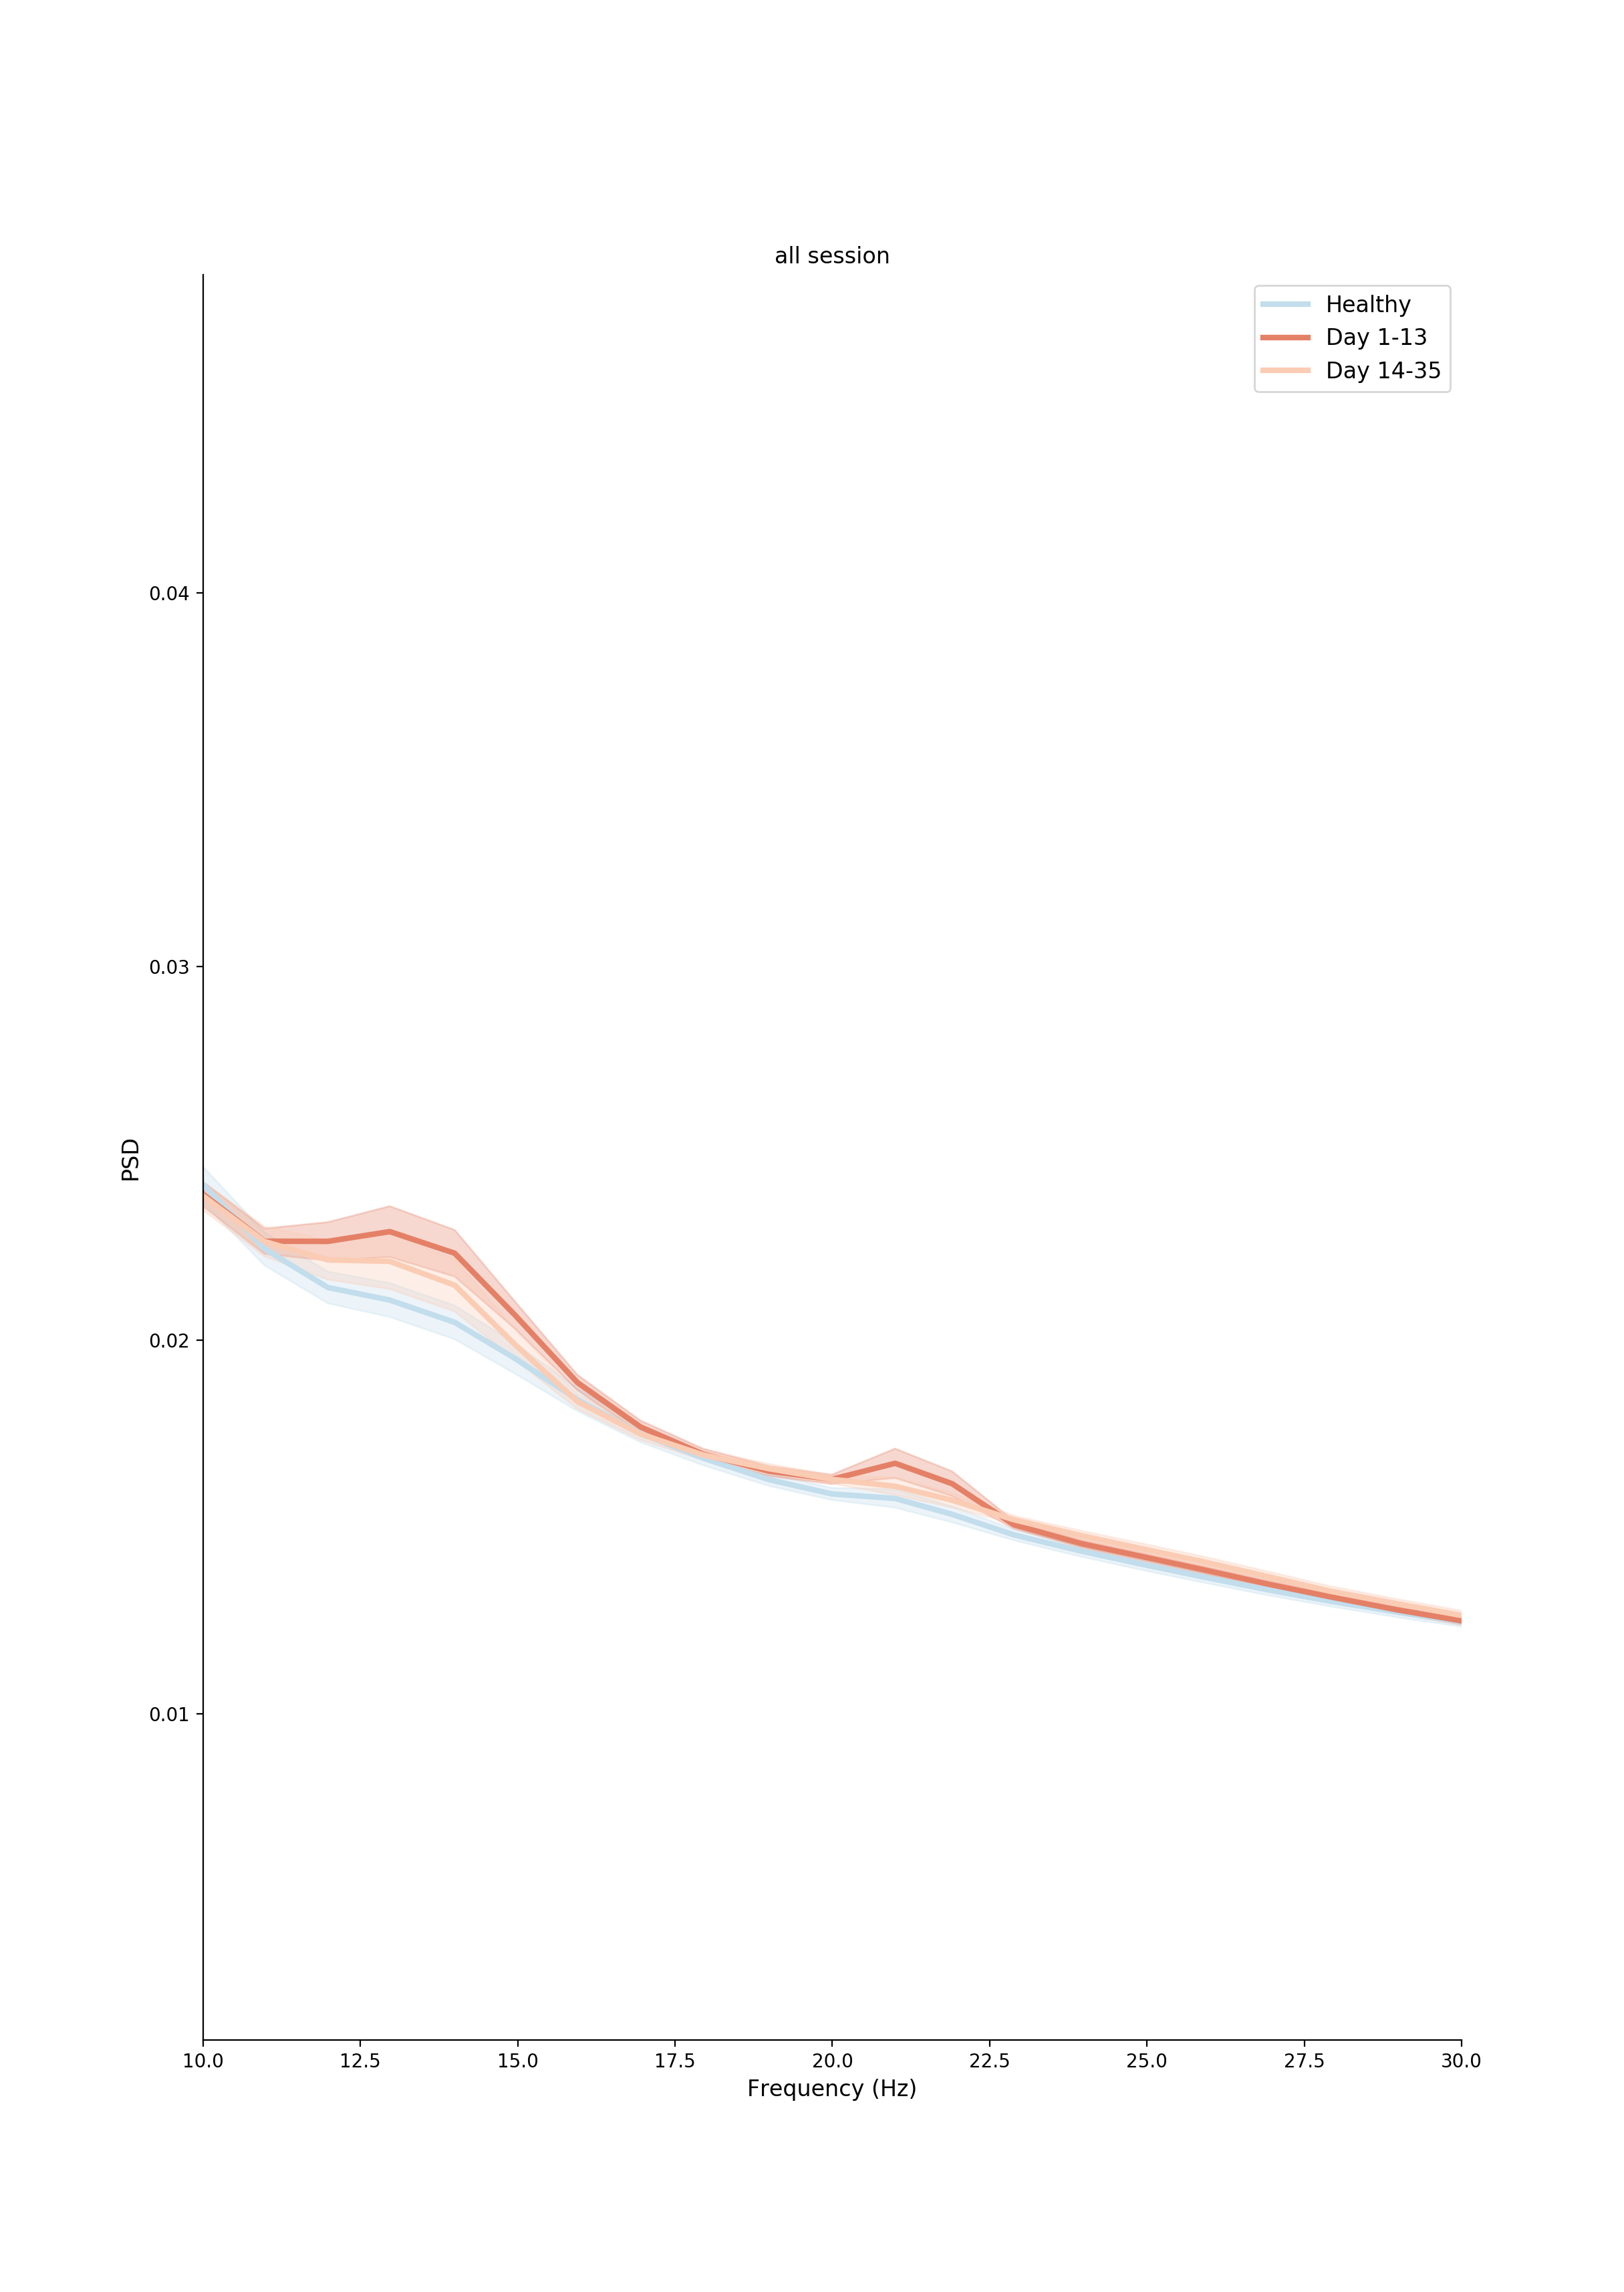

(10, 30)

In [19]:
colorsL = sns.cubehelix_palette(8)
colorsH = a3[[2,5,4]]#sns.cubehelix_palette(4, start=2, rot=5, dark=0, light=.65)
colorsH2 = sns.cubehelix_palette(8, start=3, rot=0, dark=0, light=.95)

fig, ax = plt.subplots(1,1,figsize=(12.15,17.15),sharey='row')
for ind, p in enumerate(periods.keys()):
    hC = np.nanmean(periods[p]['all'],axis=1)
    hS2 = np.nanstd(periods[p]['all'],axis=1)/np.sqrt(periods[p]['all'].shape[1])
       
    ax.plot(freq,hC,color = colorsH[ind], label=p,linewidth=3.0)
    ax.fill_between(freq, hC-hS2, hC+hS2,color=colorsH[ind],alpha=0.3)
#     ax.set_xlim(6,100)
    ax.set_title('all session')
#     ax.set_xlim(9,15)
#    ax[0,ind].set_ylim(0.015,0.03)
    ax.set_ylabel('PSD',fontsize=12)
    #ax[0,ind].axes.get_yaxis().set_ticks([])
    ax.set_xlabel('Frequency (Hz)',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(fontsize=12)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess.svg',transparent=True,format='svg')
ax.set_xlim(10,30)
# fig.savefig(figFolder+'lfpSpectromPeriodAllSess_zoomBeta.svg',transparent=True,format='svg')



Suplemental figures

In [ ]:
figFolder = '/home/dana_z/ssd_2TB/6OHDA/figs/supplementals/'

In [ ]:
# plot cage rotations 
df = pd.read_csv("/home/dana_z/ssd_2TB/6OHDA/rotation_count.csv")
df['day'] = df.apply(lambda row: row.session.split('_')[0],axis=1)
df['Amph'] = df.apply(lambda row: row.session.split('_')[1],axis=1)
df['clockwise'] = pd.to_numeric(df['clockwise'])
df['anti-clockwise'] = pd.to_numeric(df['anti-clockwise'])
df.head()


fig, ax = plt.subplots(1,2,figsize=(12.15,6.7),sharey='row')
sns.boxplot(x="day", y="clockwise", hue="Amph", data=df,
                  palette="muted",ax = ax[0]) #height=6,
#g.despine(left=True)
ax[0].set_ylabel("rotations in 10min")
ax[0].set_title("clockwise rotations")


sns.boxplot(x="day", y="anti-clockwise", hue="Amph", data=df,
                palette="muted",ax = ax[1]) # height=6,
#f.despine(left=True)
ax[1].set_ylabel("rotations in 10min")
ax[1].set_title("anti-clockwise rotations")
fig.savefig(figFolder+'figureS1_cageRotations.svg',transparent=True,format='svg')

In [ ]:
speedData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['speed'],period ='Post', mice=m,drug=b'Amphetamin')
    
    # calculte % high speed + % low speed
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        Hp = getOnsetOrPeriod(m,sess,'Post','HighMvmtPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Post','LowMvmtPeriods_vector')
        comb = Hp*1+((Lp*1)-1)*-1
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high'] = np.sum(Hp*1)/len(Hp)
        row['percent_medium'] = np.sum(comb==1)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['tran_all'] = np.sum(np.abs(trans!=0))
        row['tran_low2any'] = np.sum(np.abs(Lp[1:]*1-Lp[:-1]*1))
        row['tran_high2any'] = np.sum(np.abs(Hp[1:]*1-Hp[:-1]*1))
        
        row['MvmtOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','mvmtOnset'))        
        speedData.append(row)
          
df = pd.DataFrame(speedData)        
df['Period'] =  df.apply (lambda row: periodCalc(row.Day) , axis=1)

In [ ]:
df.to_csv(figFolder+'postAmphSpeed2R.csv')
df2 = df.groupby(['Mouse','Period']).mean()
df2.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Day 13-20','One Month']
with sns.color_palette(colorPallet3Post):#sns.color_palette("PuBuGn_d"):
    columns = ['percent_low','percent_high','tran_low2any'] 
    labels = ['% time in low Speed','% time in high Speed','# periods']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2,ax =ax[ind],order = pOrder)
        #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
        ax[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
        ax[ind].set_ylabel(labels[ind],fontsize=20)
        ax[ind].set_xlabel("")
        
        
#fig.savefig(figFolder+'figureS2_a.png',transparent=False,format='png')
fig.savefig(figFolder+'figureS2_a.svg',transparent=True,format='svg')


In [ ]:
periods = {'Healthy':lambda x: x==0,
           'Day 13-20':lambda x: (x>12) & (x<21),
           'One Month':lambda x: x>21}

fig, ax = plt.subplots(1,1,figsize=(5.99,5.67),gridspec_kw = {'hspace':.1,'bottom':0.3,'left':.26})
for indP,p in enumerate(periods.keys()):
    #to make sure mice are equally represented in each period
    weightsH = np.zeros((199,))
    for m in miceList:
        dataH = getData(Files[1],['speed'],period ='Post', day = periods[p],mice = m)
        speedM = np.empty((1,0))
        for sess in dataH:
            speedM = np.concatenate((speedM, dataH[sess]['speed']['speed']), axis=1)
        hist, bin_edges = np.histogram(speedM, bins=np.arange(0,200)*0.5)
        hist  = hist/np.nansum(hist) # normalize per mouse
        weightsH = np.nansum((weightsH, hist),axis=0)

    ax.plot(np.arange(0,199)*0.5,weightsH/16,label=p,color=colorPallet3Post[indP,:])    
ax.set_xlim(0,60)
ax.set_xlabel('speed cm/s',fontsize=16)
ax.set_ylabel('Probability',fontsize=16)
ax.legend(fontsize=10)
#fig.savefig(figFolder+'figureS2_d.png',transparent=False,format='png')
fig.savefig(figFolder+'figureS2_d.svg',transparent=True,format='svg')

In [ ]:
df2 = df.groupby(['Mouse','Period']).mean()
df2.reset_index(inplace=True)

fig, ax = plt.subplots(1,1,figsize=(4.88,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24})
pOrder = ['Healthy','Day 13-20','One Month']
with sns.color_palette(colorPallet3Post):#sns.color_palette("PuBuGn_d"):
    columns = ['MvmtOnset'] 
    labels = ['speed onsets']
    for ind in range(len(columns)):
        sns.boxplot(x="Period", y=columns[ind], data=df2,ax =ax,order = pOrder)
        #sns.scatterplot(x="Period", y=columns[ind], data=df2,ax =ax[ind])
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30,fontsize=20)
        ax.set_ylabel("mean # onsets",fontsize=20)
        ax.set_xlabel("")
        ax.set_title(labels[ind],fontsize=20)
        
#fig.savefig(figFolder+'figureS2_e.png',transparent=False,format='png')
fig.savefig(figFolder+'figureS2_e.svg',transparent=True,format='svg')


In [ ]:
rotData = []

miceList = getMiceList(Files[1])
for m in miceList:
    data = getData(Files[1],['rot'],period ='Post', mice=m, drug = b'Amphetamin')
    
    # calculte % high rot + % low rot
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        hACp = getOnsetOrPeriod(m,sess,'Post','hiACRotPeriods_vector')
        hCp = getOnsetOrPeriod(m,sess,'Post','hiCRotPeriods_vector')
        Lp = getOnsetOrPeriod(m,sess,'Post','loRotPeriods_vector')
        comb = hACp*8+Lp*5+hCp*7
                
        row['percent_low'] = np.sum(Lp*1)/len(Lp)
        row['percent_high_AC'] = np.sum(hACp*1)/len(hACp)
        row['percent_high_C'] = np.sum(hCp*1)/len(hCp)
        row['percent_non'] = np.sum(comb==0)/len(comb)
        
        trans = comb[1:]-comb[:-1]
        
        row['trans'] = np.sum(trans!=0)
        row['tran_low2high'] = np.sum(trans>0)
        row['tran_high2low'] = np.sum(trans<0)
        row['rotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','rotOnset')) 
        row['cRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','clockWiseOnset'))
        row['acRotOnset'] = np.sum(getOnsetOrPeriod(m,sess,'Post','antiClockWiseOnset'))
        
        rotData.append(row)
          
dfRot = pd.DataFrame(rotData)        
dfRot['Period'] =  dfRot.apply (lambda row: periodCalc(row.Day) , axis=1)

In [ ]:
df2Rot = dfRot.groupby(['Mouse','Period']).mean()
df2Rot.reset_index(inplace=True)
df2Rot

fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24},sharey = True)
fig2, ax2 = plt.subplots(1,3,figsize=(17.04,4.88),gridspec_kw = {'hspace':.1,'wspace':.5,'bottom':0.24},sharey = True)

pOrder = ['Healthy','Day 13-20','One Month']
with sns.color_palette(colorPallet3Post):#sns.color_palette("PuBuGn_d"):
    columns = ['rotOnset','cRotOnset','acRotOnset'] 
    labels = ['total rotational onsets','contralateral rotation onsets','ipsilateral rotation onsets']
    for ind in range(len(columns)):
        if ind >0:
            sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind-1],order = pOrder)
            #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
            ax[ind-1].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
            ax[ind-1].set_ylabel("mean # onsets",fontsize=20)
            ax[ind-1].set_xlabel("")
            ax[ind-1].set_title(labels[ind],fontsize=20)
        else:
            sns.boxplot(x="Period", y=columns[ind], data=df2Rot,ax =ax2[ind],order = pOrder)
            #sns.scatterplot(x="Period", y=columns[ind], data=df2Rot,ax =ax[ind])
            ax2[ind].set_xticklabels(ax[ind].get_xticklabels(),rotation=30,fontsize=20)
            ax2[ind].set_ylabel("mean # onsets",fontsize=20)
            ax2[ind].set_xlabel("")
            ax2[ind].set_title(labels[ind],fontsize=20)

#fig.savefig(figFolder+'figureS2_f.png',transparent=False,format='png')
fig.savefig(figFolder+'figureS2_f1.svg',transparent=True,format='svg')
fig2.savefig(figFolder+'figureS2_f2.svg',transparent=True,format='svg')


In [118]:
# Recalculate the LFP align to contra rotation onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = '/home/dana_z/HD1/lfp2ACrot/'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','speed'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])


        # get data
        sOnset = getOnsetOrPeriod(m,sess,'Pre','antiClockWiseOnset2')
        
        if np.sum(sOnset)==0:
            continue

        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['speed']['Fs'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        
        # for every speed onset:
        
        onsetL = np.full_like(tl,False)
        for si in ts[sOnset.astype(bool)]:
            ti = np.argmin(np.abs(tl-si))
            onsetL[ti] = True
        al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

        if al.ndim <3:
            try:
                al = np.reshape(al,(al.shape[0],al.shape[1],1))
            except:
                print('no onset, when there should be. in sess= ',sess)
                continue

        #al = np.nanmean(al,axis=2,keepdims=True)
        al = np.nan_to_num(al,nan=-9999)
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al

        if np.sum(sOnset)>0:
            pickle.dump( aligned, open( savePath+sess, "wb" ) , protocol=4)
            del aligned
         
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data


 46%|████▌     | 6/13 [00:36<00:42,  6.10s/it]

found  17.0  outlier points


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data
found  1.0  outlier points


 64%|██████▍   | 9/14 [00:50<00:27,  5.46s/it]

found  888231.0  outlier points


 71%|███████▏  | 10/14 [00:56<00:22,  5.60s/it]

found  481139.0  outlier points


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/17 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 93%|█████████▎| 13/14 [01:10<00:05,  5.53s/it]

8803_day6


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 93%|█████████▎| 13/14 [01:13<00:05,  5.52s/it]

8815_day6


100%|██████████| 14/14 [01:18<00:00,  5.64s/it]


In [119]:
# Recalculate the LFP align to ipsi rotation onset - take a few days to run. 
#     Only run if didn't do that before already (+ one extra time before publishing paper)
#     Comment line 27-29 to recalculate sessions that were already done
warnings.filterwarnings("ignore")

# open all necassary files 
f = h5py.File('Spectograms.hdf5','r') #LFP coeffs
savePath = '/home/dana_z/HD1/lfp2Crot/'

df = pd.DataFrame(columns=['mouse','sess','day','period','cre','numred'])
# constents for analysis:
WinPre = 2 #s
WinPost = 2 #s

# for each mouse: 
for m in miceList:
    data =  getData(Files[1],['lfp','speed'],period ='Pre', mice=m)
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])


        # get data
        sOnset = getOnsetOrPeriod(m,sess,'Pre','clockWiseOnset2')
        
        if np.sum(sOnset)==0:
            continue

        coeff = np.abs(f[m][sess]['Pre']['coeff'].value)
        lfpOutliers = removeLFPOutliers(data[sess]['lfp']['lfp'], sess)
        try:
            coeff[:,(lfpOutliers[:,0]==1)] = np.nan
            coeff= coeff.T
            #coeff = coeff.T/np.nansum(coeff,axis=1) # So that axis[0] is the time axis + normalize power in frequency per sesion
        except:
            print(sess)
            continue
        

        dtS = float(1/data[sess]['speed']['Fs'])
        dtL = float(1/data[sess]['lfp']['FS'])
        ts = np.arange(0, np.max(data[sess]['speed']['speed'].shape)) * dtS 
        tl = np.arange(0, np.max(data[sess]['lfp']['lfp'].shape)) * dtL

        tPlot = np.linspace(-WinPre,WinPost,int((WinPre+WinPost)/dtL))     
        
        # for every speed onset:
        
        onsetL = np.full_like(tl,False)
        for si in ts[sOnset.astype(bool)]:
            ti = np.argmin(np.abs(tl-si))
            onsetL[ti] = True
        al = alignToOnset(coeff,(onsetL==1), winPost =WinPre/dtL, winPre = WinPost/dtL)

        if al.ndim <3:
            try:
                al = np.reshape(al,(al.shape[0],al.shape[1],1))
            except:
                print('no onset, when there should be. in sess= ',sess)
                continue

        #al = np.nanmean(al,axis=2,keepdims=True)
        al = np.nan_to_num(al,nan=-9999)
        if 'aligned' in locals():
            aligned = np.concatenate((aligned,al), axis = 2)
        else:
            aligned = al

        if np.sum(sOnset)>0:
            pickle.dump( aligned, open( savePath+sess, "wb" ) , protocol=4)
            del aligned
         
        # add session to df, so can be retrived
        df= df.append({'mouse':m,'sess':sess,'day':day,'period': periodCalc(day),'cre':cre},ignore_index=True)

df.to_csv(savePath+'sessions')


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 1208_day12
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  7%|▋         | 1/14 [00:05<01:17,  5.99s/it]

found  1.0  outlier points


 64%|██████▍   | 9/14 [00:46<00:27,  5.41s/it]

found  888231.0  outlier points


 71%|███████▏  | 10/14 [00:52<00:22,  5.63s/it]

found  481139.0  outlier points


  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
I deleted session: 2976_day4
cleaning up speed data
found  1.0  outlier points


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


 50%|█████     | 7/14 [00:38<00:38,  5.53s/it]

found  50.0  outlier points


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/17 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


100%|██████████| 14/14 [00:56<00:00,  4.04s/it]

8803_day6



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up lfp data
cleaning up speed data


100%|██████████| 14/14 [00:49<00:00,  3.56s/it]

8815_day6


In [124]:
df = pd.read_csv('/home/dana_z/HD1/lfp2Crot/sessions')
df


Unnamed: 0  mouse            sess  day     period  cre  numred
0             0    761  0761_BaselineA    0    Healthy  CHI     NaN
1             1    761  0761_BaselineL    0    Healthy  CHI     NaN
2             2    761  0761_BaselineS    0    Healthy  CHI     NaN
3             3    761       0761_day1    1   Day 1-13  CHI     NaN
4             4    761     0761_day35L   35  Day 14-35  CHI     NaN
..          ...    ...             ...  ...        ...  ...     ...
119         119   8815      8815_day14   14  Day 14-35  CHI     NaN
120         120   8815     8815_day15A   15  Day 14-35  CHI     NaN
121         121   8815     8815_day19L   19  Day 14-35  CHI     NaN
122         122   8815       8815_day2    2   Day 1-13  CHI     NaN
123         123   8815     8815_day34L   34  Day 14-35  CHI     NaN

[124 rows x 7 columns]

In [126]:
#THIS IS WHERE I"m editing 
df = pd.read_csv('/home/dana_z/HD1/lfp2Crot/sessions')
savePath = '/home/dana_z/HD1/lfp2Crot/'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in df.period.unique():
    if per == 'One Month': 
        # remove from figure only because too many outliers (Nan) makes the figure granular
        # data was still used for analysis
        l = getMiceList(Files[1])
        l.remove('1236')
        A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
    else:
        A,df2 = getAlignedLFP_mvmt(savePath, period = per)
    if A.shape[2] > 1000:
        b = A[:,:,0:1000]
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nansum(b,axis=2)
        for ind in range(0,A.shape[2]//1000):
            c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
            mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
            Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
            c =(c-mu)/Std
            c = np.nansum(c,axis=2)
            b = b+c
        b= b/A.shape[2]
    else:
        b = A
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nanmean(b,axis=2)
    pickle.dump(b, open(figFolder+per+'.p',"wb"),protocol=4)
    del A,b
    b = pickle.load(open(figFolder+per+'.p',"rb"))

    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmin =-0.75,vmax = 1.5 )
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_'+per+'Crot_normalizedByonset.png',format='png')
    fig.savefig(figFolder+'figureS3_'+per+'ipsi.svg',format='svg')
    fig.clf()
    plt.close(fig)



In [250]:
df = pd.read_csv('/home/dana_z/HD1/lfp2ACrot/sessions')
savePath = '/home/dana_z/HD1/lfp2ACrot/'
f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in df.period.unique():
    if per == 'One Month': 
        # remove from figure only because too many outliers (Nan) makes the figure granular
        # data was still used for analysis
        l = getMiceList(Files[1])
        l.remove('1236')
        A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
    else:
        A,df2 = getAlignedLFP_mvmt(savePath, period = per)
    print(A.shape)
#     if A.shape[2] > 1000:
#         b = A[:,:,0:1000]
#         mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
#         Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
#         b =(b-mu)/Std
#         b = np.nansum(b,axis=2)
#         for ind in range(0,A.shape[2]//1000):
#             c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
#             mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
#             Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
#             c =(c-mu)/Std
#             c = np.nansum(c,axis=2)
#             b = b+c
#         b= b/A.shape[2]
#     else:
#         b = A
#         mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
#         Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
#         b =(b-mu)/Std
#         b = np.nanmean(b,axis=2)
#     pickle.dump(b, open(figFolder+per+'.p',"wb"),protocol=4)
#     del A,b
#     b = pickle.load(open(figFolder+per+'.p',"rb"))

#     fig, ax = plt.subplots()
#     CS=ax.pcolormesh(tPlot,freq,b.T, rasterized=True,vmin = -0.75,vmax = 1.5)
#     fig.colorbar(CS)
#     ax.set_title(per,fontsize=20)
# #     fig.savefig(figFolder+'figure5_'+per+'ACrot_normalizedByonset.png',format='png')
#     fig.savefig(figFolder+'figureS3_'+per+'contra.svg',format='svg')
#     fig.clf()
#     plt.close(fig)
    


(12206, 87, 245)
(12206, 87, 323)
(12206, 87, 288)


In [129]:
df = pd.read_csv('/home/dana_z/HD1/lfp2ACrot/sessions')
savePath = '/home/dana_z/HD1/lfp2ACrot/'
savePath2 = '/home/dana_z/HD1/lfp2Crot/'

f = h5py.File('Spectograms.hdf5','r')
freq = f['0761']['freq'].value
dtL = 0.00032768
tPlot = np.linspace(-2,2,int(4/dtL-1))
for per in df.period.unique():
    if per == 'One Month': 
        # remove from figure only because too many outliers (Nan) makes the figure granular
        # data was still used for analysis
        l = getMiceList(Files[1])
        l.remove('1236')
        A,df2 =getAlignedLFP_mvmt(savePath, mice = l, period = per)
    else:
        A,df2 = getAlignedLFP_mvmt(savePath, period = per)
    if A.shape[2] > 1000:
        b = A[:,:,0:1000]
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nansum(b,axis=2)
        for ind in range(0,A.shape[2]//1000):
            c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
            mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
            Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
            c =(c-mu)/Std
            c = np.nansum(c,axis=2)
            b = b+c
        b= b/A.shape[2]
    else:
        b = A
        mu = np.mean(b[:int(b.shape[0]/2),:,:],axis=0)
        Std = np.std(b[:int(b.shape[0]/2),:,:],axis=0)
        b =(b-mu)/Std
        b = np.nanmean(b,axis=2)
    del A

    if per == 'One Month': 
        # remove from figure only because too many outliers (Nan) makes the figure granular
        # data was still used for analysis
        l = getMiceList(Files[1])
        l.remove('1236')
        A,df2 =getAlignedLFP_mvmt(savePath2, mice = l, period = per)
    else:
        A,df2 = getAlignedLFP_mvmt(savePath2, period = per)
    if A.shape[2] > 1000:
        b2 = A[:,:,0:1000]
        mu = np.mean(b2[:int(b2.shape[0]/2),:,:],axis=0)
        Std = np.std(b2[:int(b2.shape[0]/2),:,:],axis=0)
        b2 =(b2-mu)/Std
        b2 = np.nansum(b2,axis=2)
        for ind in range(0,A.shape[2]//1000):
            c = A[:,:,1000*(ind+1):np.min([A.shape[2],1000*(ind+2)])]
            mu = np.mean(c[:int(c.shape[0]/2),:,:],axis=0)
            Std = np.std(c[:int(c.shape[0]/2),:,:],axis=0)
            c =(c-mu)/Std
            c = np.nansum(c,axis=2)
            b2 = b2+c
        b2= b2/A.shape[2]
    else:
        b2 = A
        mu = np.mean(b2[:int(b2.shape[0]/2),:,:],axis=0)
        Std = np.std(b2[:int(b2.shape[0]/2),:,:],axis=0)
        b2 =(b2-mu)/Std
        b2 = np.nanmean(b2,axis=2)    
    del A
    
    B = b-b2
    fig, ax = plt.subplots()
    CS=ax.pcolormesh(tPlot,freq,B.T, rasterized=True, vmin = -1, vmax = 1.5)
    fig.colorbar(CS)
    ax.set_title(per,fontsize=20)
#     fig.savefig(figFolder+'figure5_'+per+'ACrot_normalizedByonset.png',format='png')
    fig.savefig(figFolder+'figureS3_'+per+'diff.svg',format='svg')
    fig.clf()
    plt.close(fig)



In [79]:
f = h5py.File('membership.hdf5','r')
print(list(f['1208']['1208_BaselineA'].keys()))
f.close()

['contraOnset', 'ipsiOnset', 'mvmtOnset', 'rotOnset']


In [18]:
f = h5py.File('membership.hdf5','r')
miceList = getMiceList(Files[1])
col_names = ['Sess','Mouse','Period','Day','CellType']
df = pd.DataFrame(columns=col_names)
for m in miceList:
    grp = f[m]
    sessions = list(grp.keys())
    for sess in sessions:
        try:
            data = grp[sess]['mvmtOnset']['result'].value
            meanR_mvmtOnset = np.mean(data,axis=1)
        except:
            print(sess,'mvmt')
            meanR_mvmtOnset = np.nan
            
        try:
            data = grp[sess]['ipsiOnset']['result'].value
            meanR_ipsiOnset = np.mean(data,axis=1)
        except:
            print(sess,'ipsi')
            meanR_ipsiOnset = np.nan
            
        try:
            data = grp[sess]['contraOnset']['result'].value
            meanR_contraOnset = np.mean(data,axis=1)
        except:
            print(sess,'contra')
            meanR_contraOnset =np.nan
        
        if sess[5] == 'B':
                day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        cre = getCreType(Files[1],m)
        nRed = getNumRed(Files[1],m,sess[5:])
        try:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset,
                                'meanR_ipsiOnset':meanR_ipsiOnset,
                                'meanR_contraOnset':meanR_contraOnset})
        except:
            df2 = pd.DataFrame({'Sess':sess,'Mouse':m,'Period':periodCalc(day),
                                'Day':day,'CellType':'MSN',
                                'meanR_mvmtOnset':meanR_mvmtOnset,
                                'meanR_ipsiOnset':meanR_ipsiOnset,
                                'meanR_contraOnset':meanR_contraOnset},index = [0])
        df2.loc[:nRed-1,'CellType'] = cre
        df = pd.concat([df,df2],sort=True)

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


0761_day10 contra
0761_day12 contra
0761_day19L contra
0761_day2 contra
0761_day31A contra
0761_day35L contra
0761_day6 contra
0761_day8 contra
1208_day15A contra
1208_day19L contra
1208_day2 contra
1208_day34L contra
1222_day11 ipsi
1222_day20L ipsi
1222_day36L contra
1222_day5 ipsi
1231_BaselineL ipsi
1231_BaselineS ipsi
1236_day13 contra
1793_BaselineA contra
1793_day12 contra
1793_day14 contra
2976_BaselineA ipsi
2976_day14 contra
2976_day35L contra
2976_day8 ipsi
2976_day8 contra
2980_day14 contra
2980_day15A ipsi
2980_day19L contra
2980_day8 contra
2981_day10 ipsi
2981_day12 ipsi
2981_day15A contra
2981_day2 ipsi
2981_day6 ipsi
2981_day8 ipsi
4539_BaselineA ipsi
4539_day1 ipsi
4539_day1 contra
4539_day10 ipsi
4539_day10 contra
4539_day11 ipsi
4539_day11 contra
4539_day12 ipsi
4539_day12 contra
4539_day13 ipsi
4539_day13 contra
4539_day14 ipsi
4539_day14 contra
4539_day2 ipsi
4539_day2 contra
4539_day3 ipsi
4539_day3 contra
4539_day30A ipsi
4539_day4 ipsi
4539_day4 contra
4539_day

In [185]:
df['care'] = df.meanR_mvmtOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')
df['care_ipsi'] = df.meanR_ipsiOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')
df['care_contra'] = df.meanR_contraOnset.apply(lambda x: x>0.05 if ~np.isnan(x) else None).astype('float')


In [17]:
# %matplotlib notebook
N = 5
df4 = pd.DataFrame(columns = ['mvmt','CellType','Period','oddsRatio','pValue_corrected'])
for sig in ['care']:#,'care_ipsi','care_contra']:
    for cell in df.CellType.unique():
        df3 = df[(df.CellType ==cell)]
        dfHealthy = df3[df3.Period == 'Healthy']
        yesVals = []
        noValse = []
        for period in df3.Period.unique():
            dfComp = df3[df3.Period == period]
            print(sig,cell,period)
            oddsratio, pvalue = sci.stats.fisher_exact([[dfHealthy[dfHealthy[sig] == True][sig].count(), dfHealthy[dfHealthy[sig] == False][sig].count()], [dfComp[dfComp[sig] == True][sig].count(), dfComp[dfComp[sig] == False][sig].count()]])
            print(pvalue, pvalue<0.05/(N-1))
            df4 = df4.append({'mvmt':sig,'CellType':cell,
                              'Period':period,'oddsRatio':oddsratio,
                              'pValue_corrected':pvalue*(N-1),
                              'healthy_all':dfHealthy[sig].count(),
                              'healthy_care':dfHealthy[dfHealthy[sig] == True][sig].count(),
                              'healthy_ratio':dfHealthy[dfHealthy[sig] == True][sig].count()/dfHealthy[sig].count(),
                              'period_all':dfComp[sig].count(),'period_care':dfComp[dfComp[sig] == True][sig].count(),
                              'period_ratio':dfComp[dfComp[sig] == True][sig].count()/dfComp[sig].count()},ignore_index = True)

df4.to_csv('supplemntalTable1_totRot.csv')


care CHI Healthy
1.0 False
care CHI Day 1-13
0.07049646191667168 False
care CHI Day 14-35
1.0 False
care MSN Healthy
1.0 False
care MSN Day 1-13
0.022817013947481188 False
care MSN Day 14-35
6.271685775398108e-10 True
care PV Healthy
1.0 False
care PV Day 1-13
1.0 False
care PV Day 14-35
0.7634812806244459 False


<IPython.core.display.Javascript object>


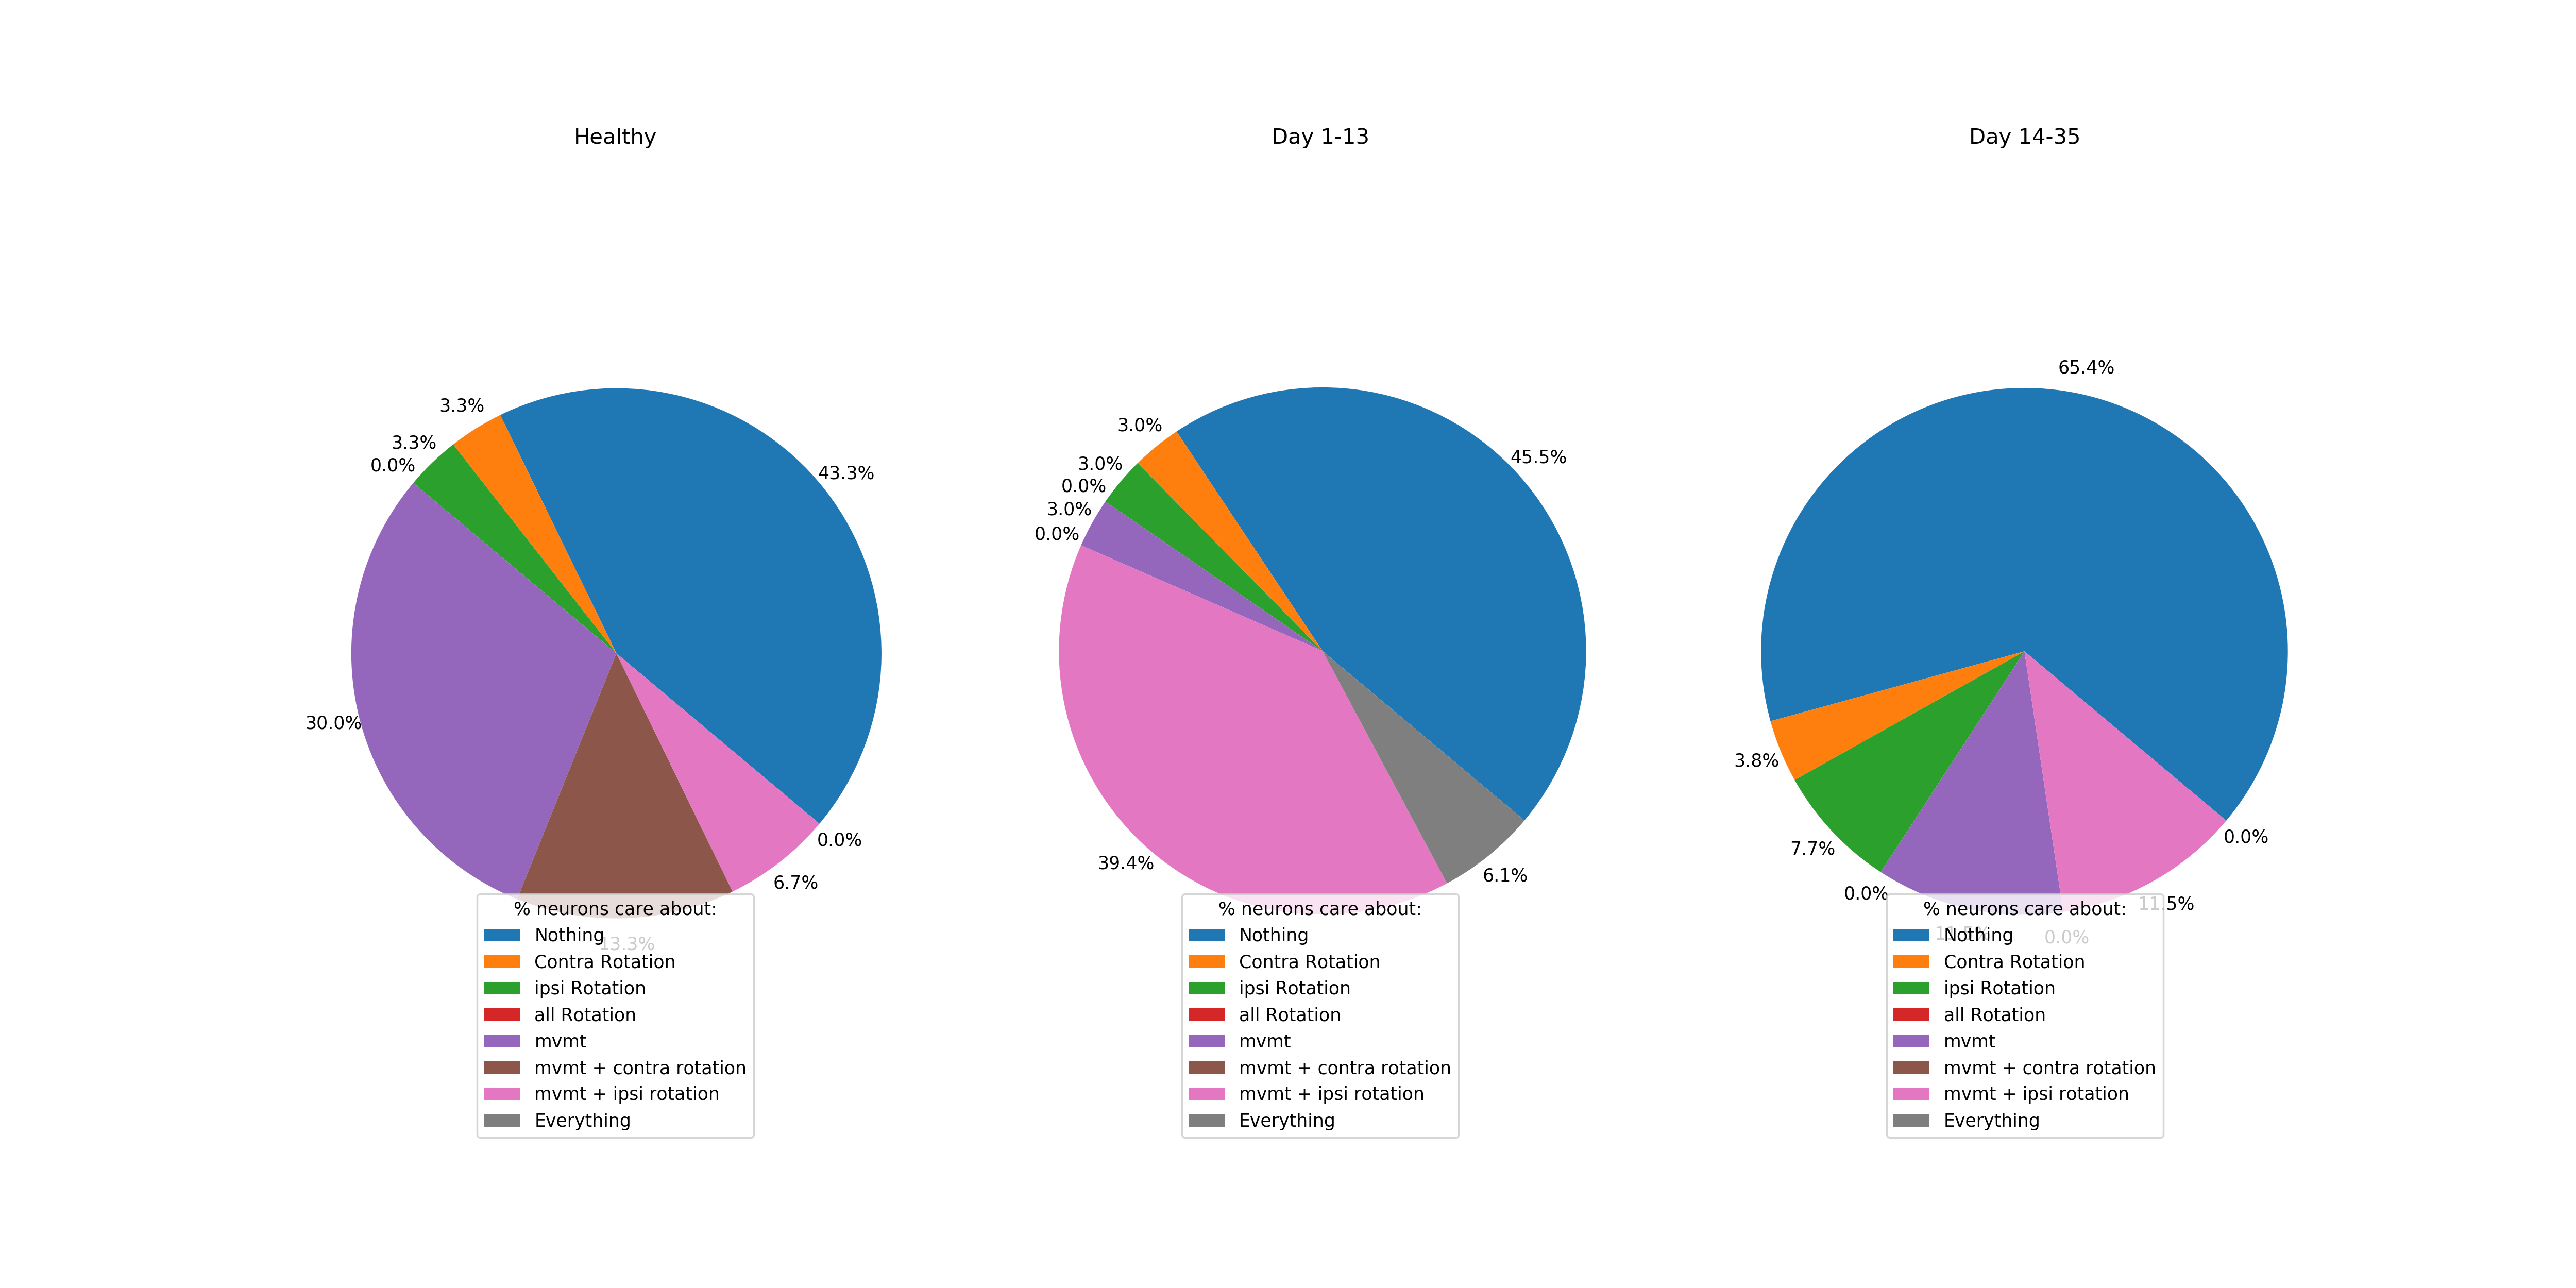

<IPython.core.display.Javascript object>


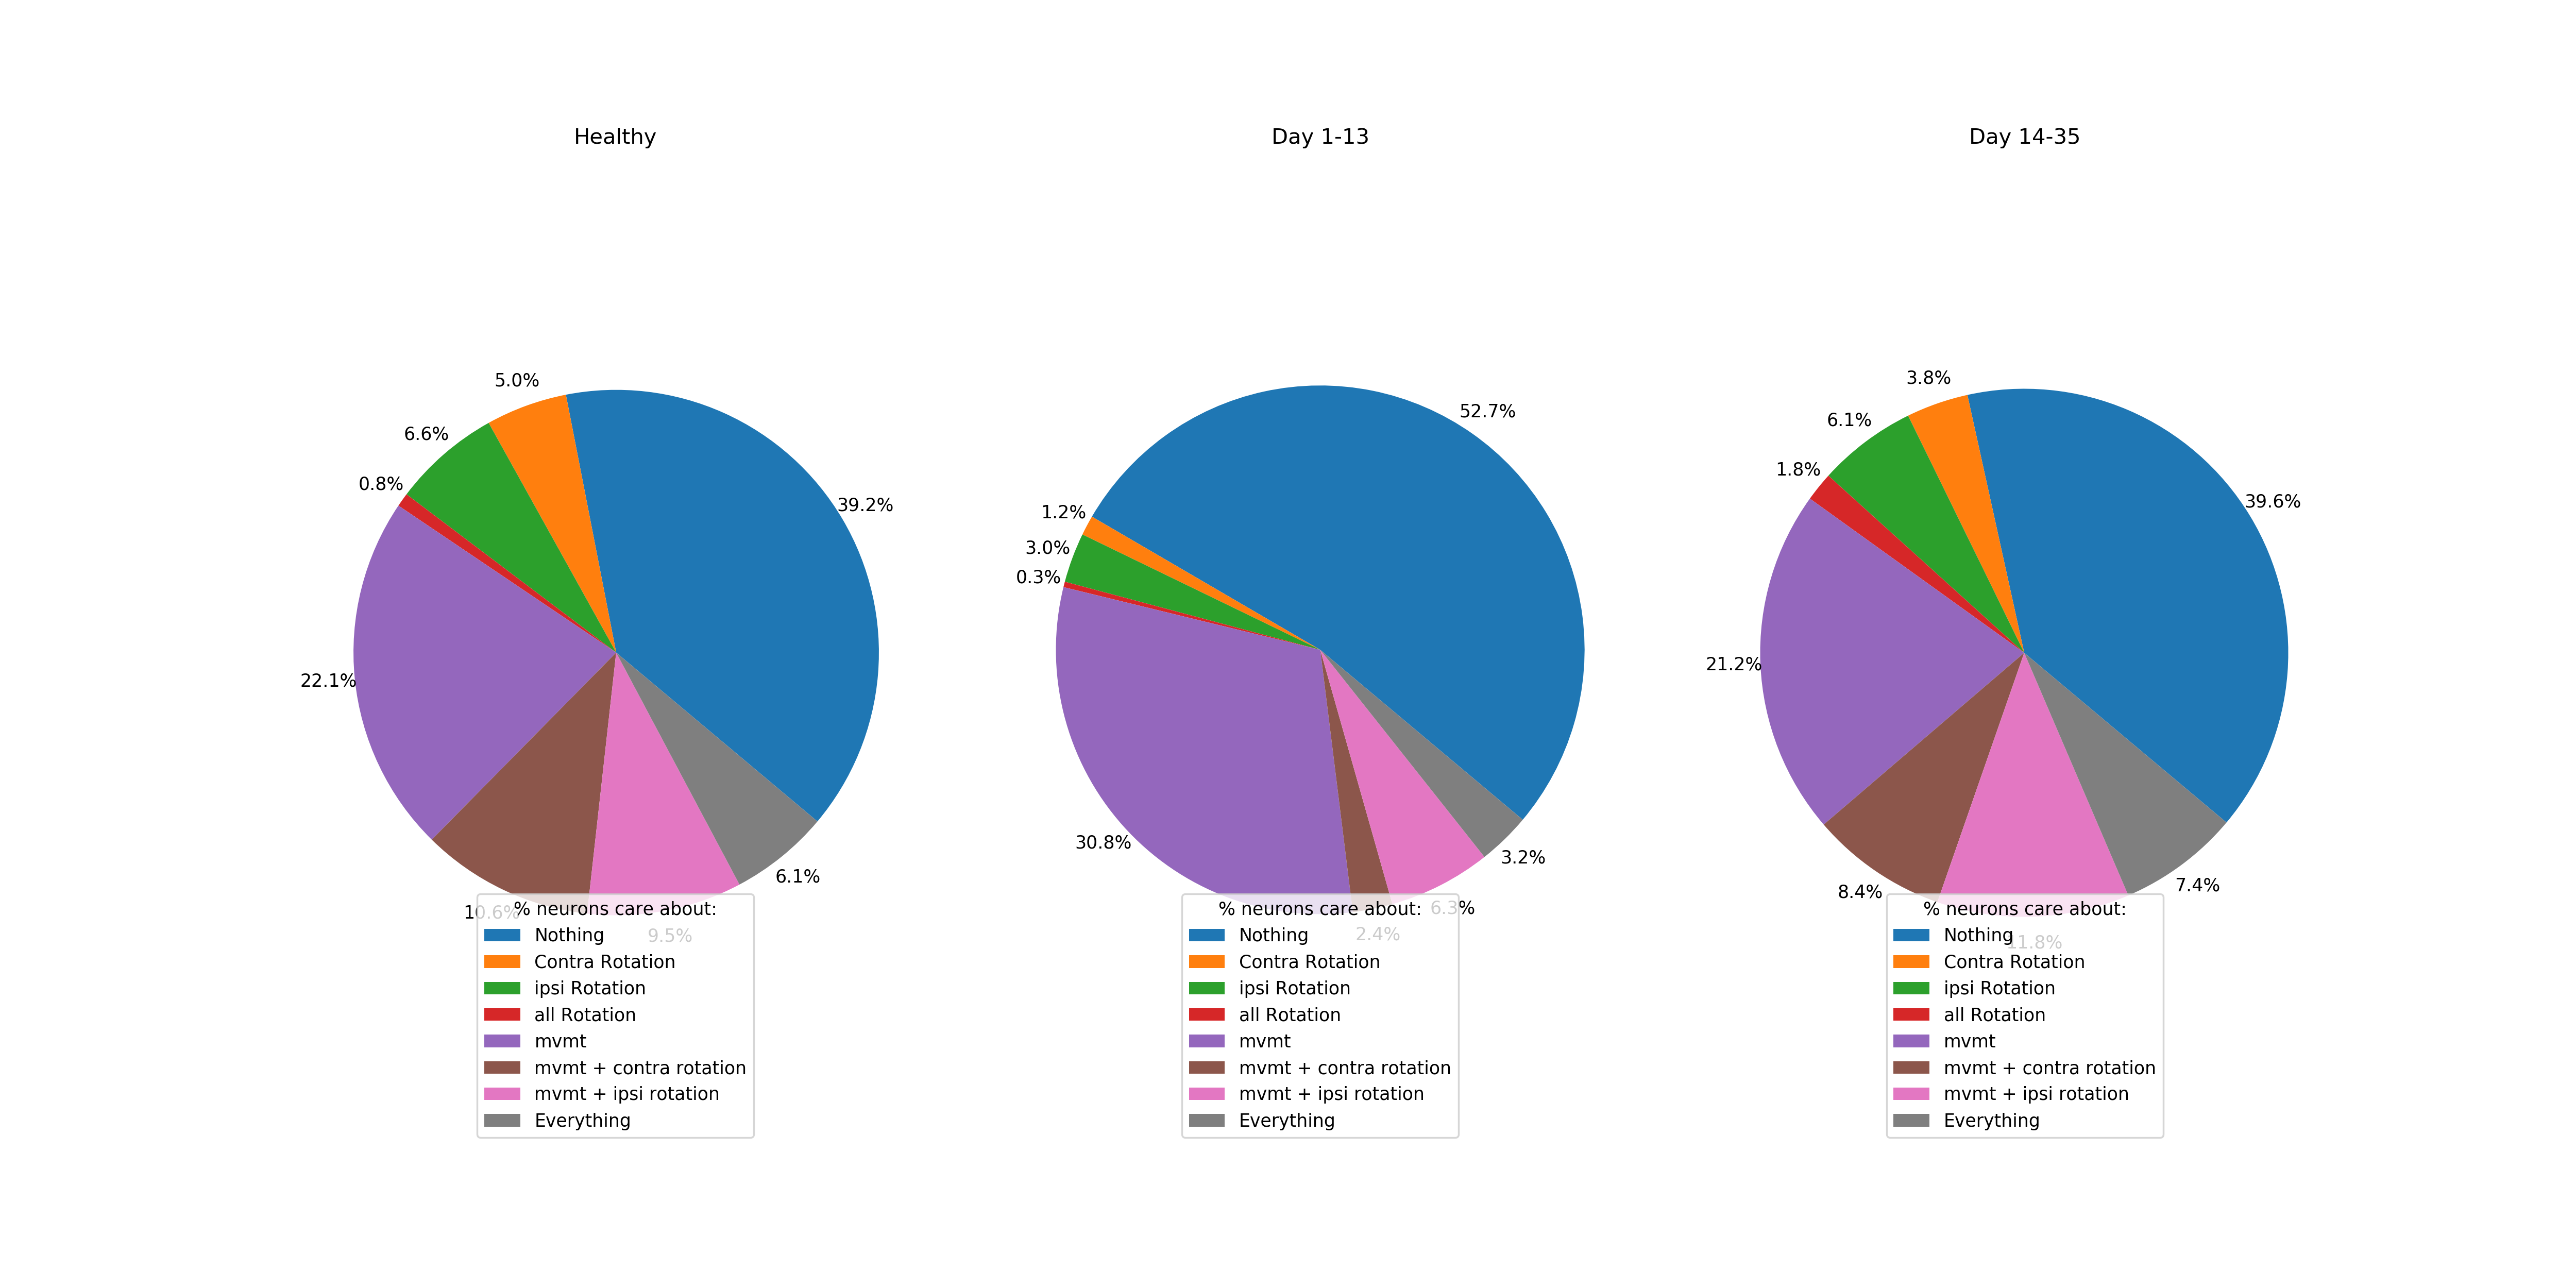

<IPython.core.display.Javascript object>


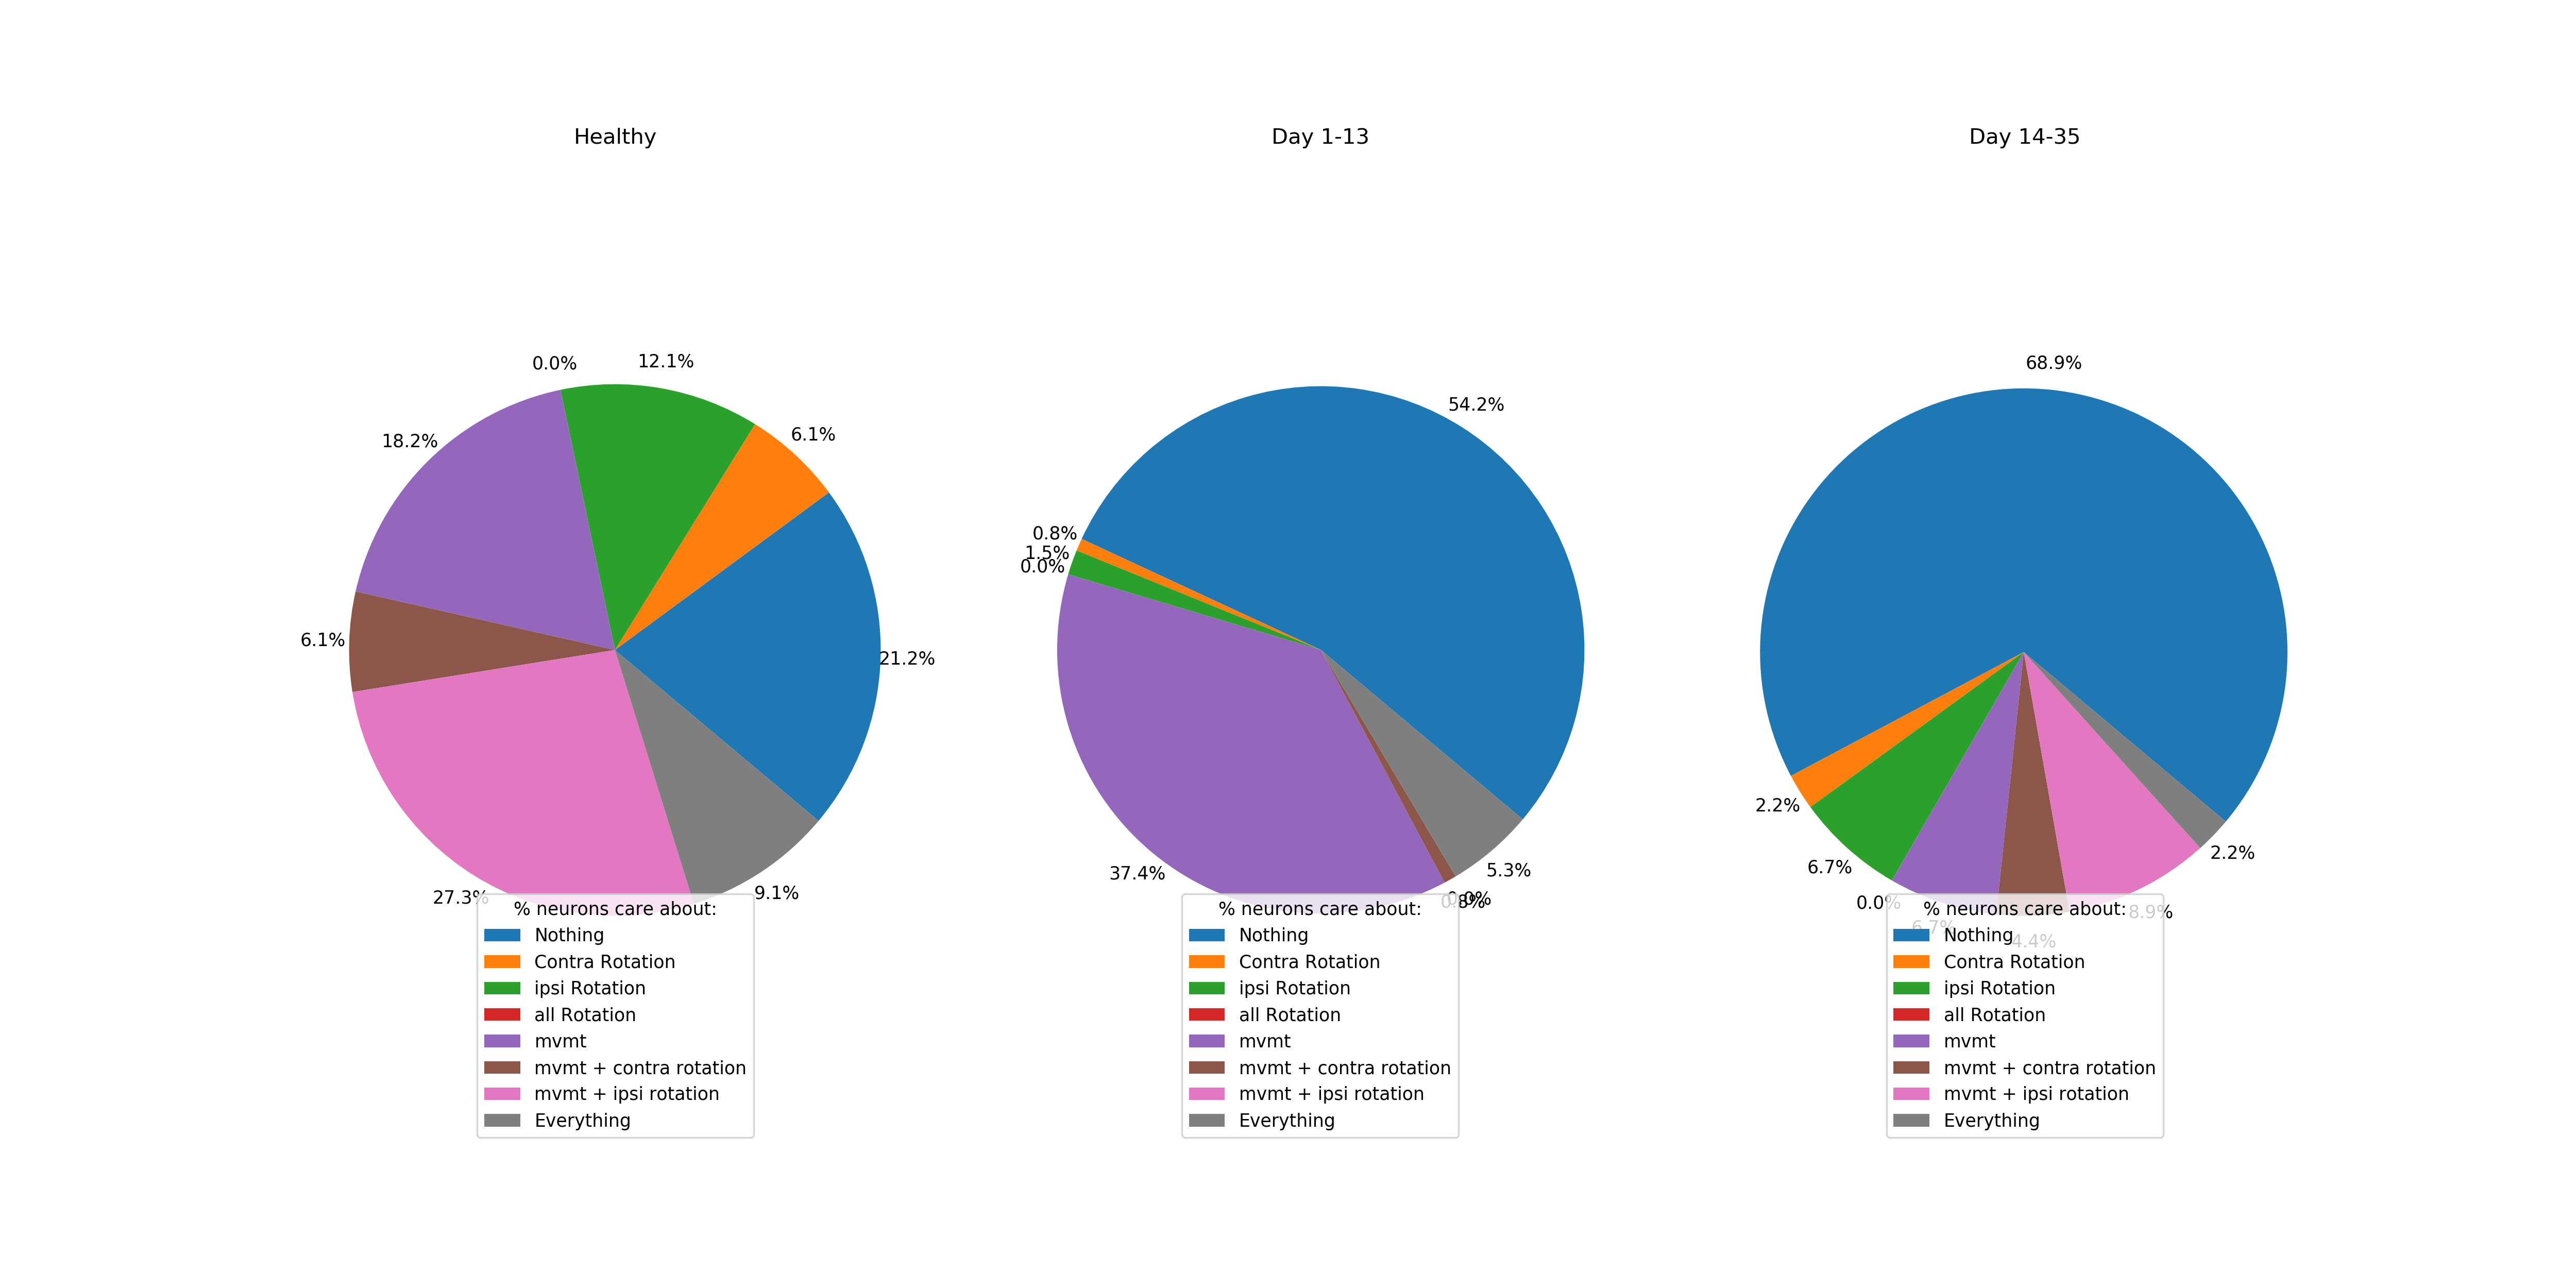

In [193]:
df['care'] = df.meanR_mvmtOnset.apply(lambda x: x>0.05 ).astype('float')
df['care_ipsi'] = df.meanR_ipsiOnset.apply(lambda x: x>0.05 ).astype('float')
df['care_contra'] = df.meanR_contraOnset.apply(lambda x: x>0.05 ).astype('float')

a = df.groupby(['care','care_ipsi','care_contra']).Day.count()
levels = [a.index.levels[0].values, a.index.levels[1].values,a.index.levels[2].values]
new_index = pd.MultiIndex.from_product(levels, names=a.index.names)

my_labels = ['Nothing','Contra Rotation','ipsi Rotation','all Rotation','mvmt','mvmt + contra rotation',
                 'mvmt + ipsi rotation','Everything']
# fig, ax  = plt.subplots(1,5,figsize=(10, 10))
for cell in df.CellType.unique():
    inds = 0;
    fig, ax  = plt.subplots(1,3,figsize=(20, 10))
    for period in df.Period.unique():

        dfPlot = df[(df.CellType == cell)&(df.Period == period)].groupby(['care','care_ipsi','care_contra']).Day.count()
        dfPlot = dfPlot.reindex(new_index, fill_value=0)

        wedges, texts, autotexts =ax[inds].pie(dfPlot,startangle=-40,autopct='%1.1f%%',pctdistance=1.1)


    #           bbox_to_anchor=(1, 0, 0.5, 1))
    #     plt.setp(texts, fontsize=25)
        ax[inds].set_title(period)
        ax[inds].axis('equal')

        
        ax[inds].legend(wedges, my_labels,
                  title="% neurons care about:",
                  loc="lower center")
        inds = inds+1
    fig.savefig(figFolder+'figureS4_'+cell+'_all.svg',transparent=True,format='svg')
#     for sig in ['care','care_ipsi','care_contra']:
#         df3 = df[(df.CellType ==cell)]
#         dfHealthy = df3[df3.Period == 'Healthy']
#         yesVals = []
#         noValse = []
#         for period in df3.Period.unique():
#             dfComp = df3[df3.Period == period]
           
#             oddsratio, pvalue = sci.stats.fisher_exact([[dfHealthy[dfHealthy[sig] == True][sig].count(), dfHealthy[dfHealthy[sig] == False][sig].count()], [dfComp[dfComp[sig] == True][sig].count(), dfComp[dfComp[sig] == False][sig].count()]])
#             if cell == 'MSN':
#                 print(sig,cell,period)
#                 print(pvalue, pvalue<0.05/(N-1))
#                 print('healthy:', dfHealthy[dfHealthy[sig] == True][sig].count(),dfHealthy[sig].count(),dfHealthy[dfHealthy[sig] == True][sig].count()/dfHealthy[sig].count())
#                 print('vs. ', dfComp[dfComp[sig] == True][sig].count(), dfComp[sig].count(),dfComp[dfComp[sig] == True][sig].count()/dfComp[sig].count())
            
#df.groupby(['CellType','Period','sig','sig_ipsi','sig_contra']).count()

care_ipsi  care_contra
0.0        0.0            13893
           1.0             3073
1.0        0.0             4513
           1.0             2011
Name: Day, dtype: int64


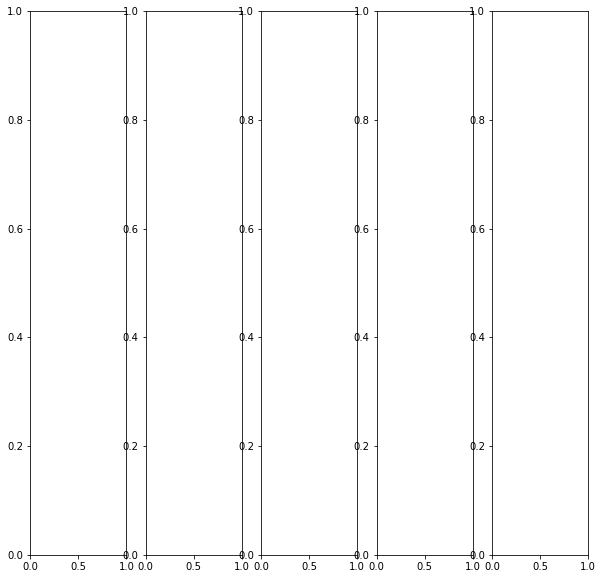

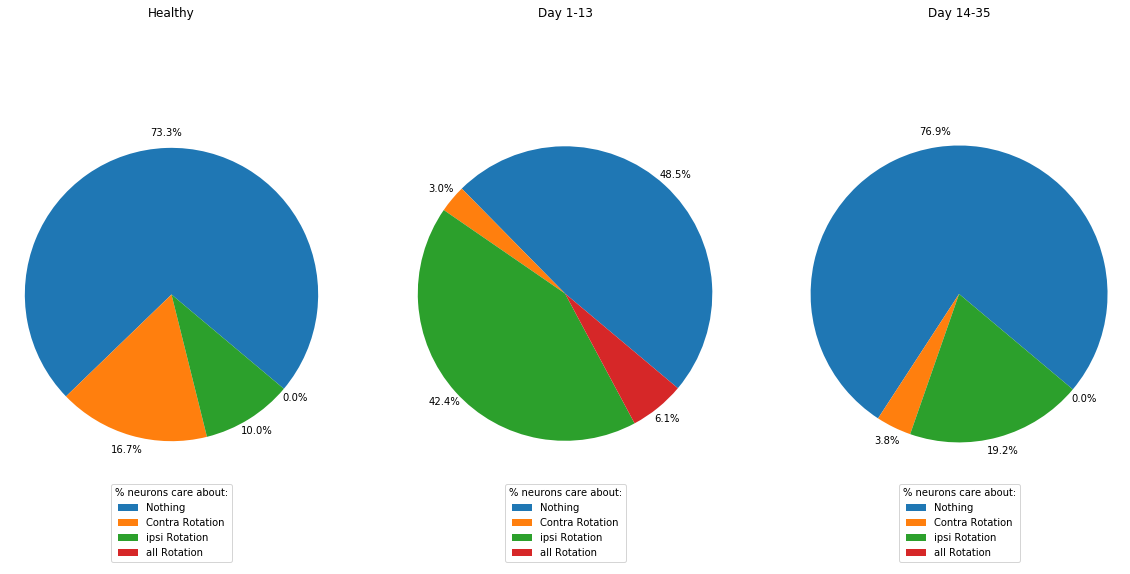

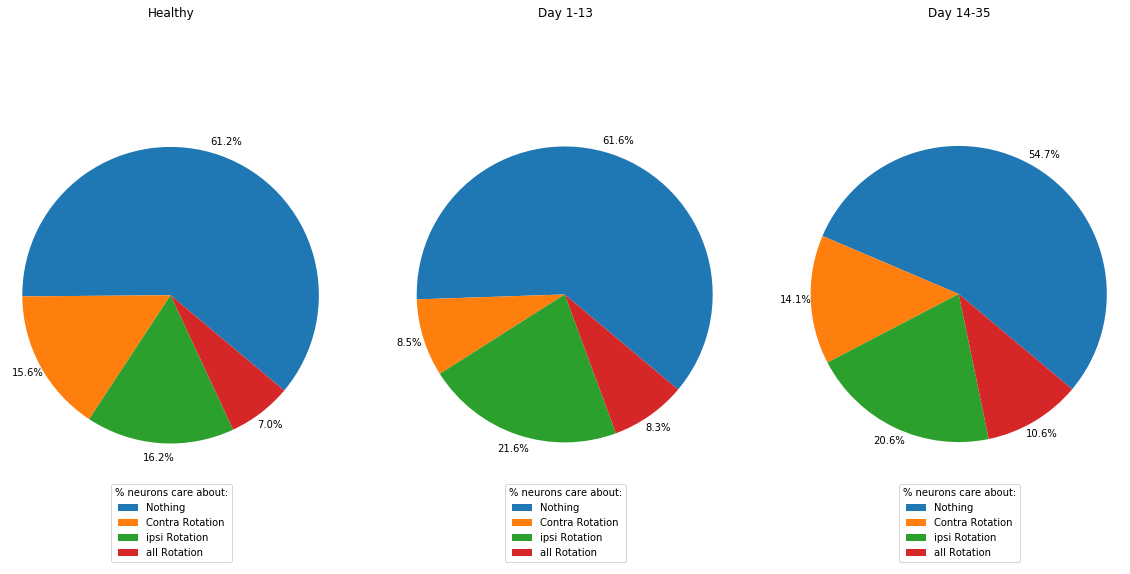

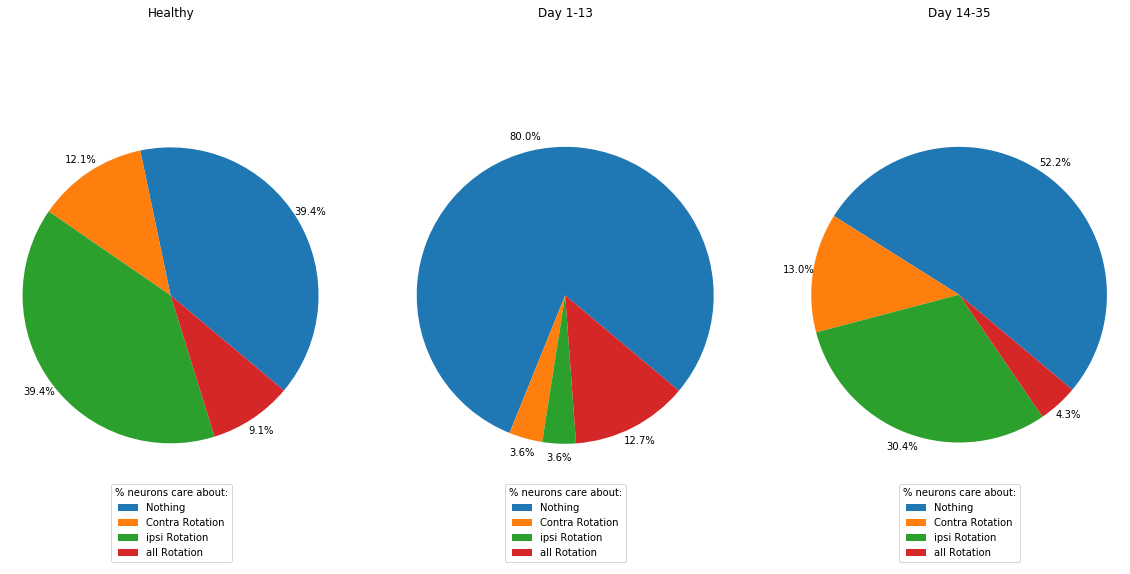

In [22]:
%matplotlib inline
# df['care'] = df.meanR_mvmtOnset.apply(lambda x: x>0.05 ).astype('float')
df['care_ipsi'] = df.meanR_ipsiOnset.apply(lambda x: x>0.05 ).astype('float')
df['care_contra'] = df.meanR_contraOnset.apply(lambda x: x>0.05 ).astype('float')

a = df.groupby(['care_ipsi','care_contra']).Day.count()
levels = [a.index.levels[0].values, a.index.levels[1].values]#,a.index.levels[2].values]
new_index = pd.MultiIndex.from_product(levels, names=a.index.names)
print(a)
my_labels = ['Nothing','Contra Rotation','ipsi Rotation','all Rotation']
fig, ax  = plt.subplots(1,5,figsize=(10, 10))
for cell in df.CellType.unique():
    inds = 0;
    fig, ax  = plt.subplots(1,3,figsize=(20, 10))
    for period in df.Period.unique():

        dfPlot = df[(df.CellType == cell)&(df.Period == period)].groupby(['care_ipsi','care_contra']).Day.count()
        dfPlot = dfPlot.reindex(new_index, fill_value=0)

        wedges, texts, autotexts =ax[inds].pie(dfPlot,startangle=-40,autopct='%1.1f%%',pctdistance=1.1)


    #           bbox_to_anchor=(1, 0, 0.5, 1))
    #     plt.setp(texts, fontsize=25)
        ax[inds].set_title(period)
        ax[inds].axis('equal')

        
        ax[inds].legend(wedges, my_labels,
                  title="% neurons care about:",
                  loc="lower center")
        inds = inds+1
    fig.savefig(figFolder+'figureS4_onlyRot_'+cell+'_all.svg',transparent=True,format='svg')
#     for sig in ['care','care_ipsi','care_contra']:
#         df3 = df[(df.CellType ==cell)]
#         dfHealthy = df3[df3.Period == 'Healthy']
#         yesVals = []
#         noValse = []
#         for period in df3.Period.unique():
#             dfComp = df3[df3.Period == period]
           
#             oddsratio, pvalue = sci.stats.fisher_exact([[dfHealthy[dfHealthy[sig] == True][sig].count(), dfHealthy[dfHealthy[sig] == False][sig].count()], [dfComp[dfComp[sig] == True][sig].count(), dfComp[dfComp[sig] == False][sig].count()]])
#             if cell == 'MSN':
#                 print(sig,cell,period)
#                 print(pvalue, pvalue<0.05/(N-1))
#                 print('healthy:', dfHealthy[dfHealthy[sig] == True][sig].count(),dfHealthy[sig].count(),dfHealthy[dfHealthy[sig] == True][sig].count()/dfHealthy[sig].count())
#                 print('vs. ', dfComp[dfComp[sig] == True][sig].count(), dfComp[sig].count(),dfComp[dfComp[sig] == True][sig].count()/dfComp[sig].count())
            
#df.groupby(['CellType','Period','sig','sig_ipsi','sig_contra']).count()

In [192]:
# for period in df.Period.unique():
#     print(period)
#     dfPlot = df[(df.CellType == 'PV')&(df.Period == period)].groupby(['care','care_ipsi','care_contra']).Day.count()
#     print(dfPlot)
df[df.CellType == 'PV']

CellType Day Mouse     Period            Sess  meanR_contraOnset  \
0        PV   0  1236    Healthy  1236_BaselineA                0.2   
1        PV   0  1236    Healthy  1236_BaselineA                0.0   
0        PV   0  1236    Healthy  1236_BaselineL                0.0   
0        PV   0  1236    Healthy  1236_BaselineS                0.5   
1        PV   0  1236    Healthy  1236_BaselineS                0.0   
..      ...  ..   ...        ...             ...                ...   
0        PV  34  8803  Day 14-35     8803_day34L                0.0   
0        PV   4  8803   Day 1-13       8803_day4                0.0   
0        PV   6  8803   Day 1-13       8803_day6                0.5   
0        PV   8  8803   Day 1-13       8803_day8                NaN   
1        PV   8  8803   Day 1-13       8803_day8                NaN   

    meanR_ipsiOnset  meanR_mvmtOnset  care  care_ipsi  care_contra  
0          0.307692         0.285714   1.0        1.0          1.0  
1          0.076923         0.142857   1.0        1.0          0.0  
0          0.000000         0.133333   1.0        0.0          0.0  
0          0.230769         0.421053   1.0        1.0          1.0  
1          0.076923         0.157895   1.0        1.0          0.0  
..              ...              ...   ...        ...          ...  
0          0.000000         0.200000   1.0        0.0          0.0  
0          0.000000         0.000000   0.0        0.0          0.0  
0               NaN         0.000000   0.0        NaN          1.0  
0          0.500000         0.000000   0.0        1.0          NaN  
1          0.000000         0.000000   0.0        0.0          NaN  

[209 rows x 11 columns]

In [ ]:
[[dfHealthy[dfHealthy[sig] == True]['CellType'].count(), dfHealthy[dfHealthy[sig] == False]['CellType'].count()], [dfComp[dfComp[sig] == True]['CellType'].count(), dfComp[dfComp[sig] == False]['CellType'].count()]]

In [ ]:
# look at individual neurons - only run once
f = h5py.File('/home/dana_z/HD1/connactivityAnalysis/connMapsMvmt.hdf5','a')
mvmtType = {'highIpsi':"getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')",
            'highContra':"getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')",
            'lowRot':"getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_vector')",
            'lowSpeed':"getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_vector')",
            'hiSpeed':"getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_vector')"}

numshifts = 1000
for m in tqdm(miceList):
    grp = f.create_group(m)
    data =  getData(Files[1],['trace'],period ='Pre', mice=m)
    
       
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess in grp.keys():
            continue
        subgrp = grp.create_group(sess)

        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred']) 

        subgrp.attrs['numRed'] = numRed
        subgrp.attrs['day'] = day
        subgrp.attrs['period'] = periodCalc(day)
        
        ssubgrp2 = subgrp.create_group('Pre')    
#         try:  
        Ca_ori = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')            
        dff_ori = data[sess]['trace']['dff']   

        for mv in mvmtType.keys():    
            mVector = eval(mvmtType[mv])
            if np.sum(mVector)==0:
                ssubgrp = ssubgrp2.create_group(mv)
                ssubgrp['aSymCorr'] = 0
                ssubgrp['pearson'] = 0
                ssubgrp['pearsonF'] = 0
                continue
            
            if len(mVector)<Ca_ori.shape[1]:
                mVector = np.append(mVector,0)

            Ca = Ca_ori[:,(mVector>0)]
            dff = dff_ori[:,(mVector>0)]

            cor = np.dot(Ca ,Ca.T)/np.sum(Ca,axis=1) # Do the actual co-occorence matrix not np.corrcoef(Ca)
            cor2 = np.corrcoef(Ca)
            cor3 = np.corrcoef(dff)


            ssubgrp = ssubgrp2.create_group(mv)
            ssubgrp['aSymCorr'] = cor
            ssubgrp['pearson'] = cor2
            ssubgrp['pearsonF'] = cor3

            sCor = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor2 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor3 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            for s in range(0,numshifts):
                shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                Ca2 = circShiftRoll(shifts,Ca)
                dff2 = circShiftRoll(shifts,dff)
                sCor2[:,:,s] = np.corrcoef(Ca2)
                sCor[:,:,s] = np.dot(Ca2 ,Ca2.T)/np.sum(Ca2,axis=1)
                sCor3[:,:,s] = np.corrcoef(dff2)
            ssubgrp['aSymCorr_shuffle'] = sCor
            ssubgrp['pearson_shuffle'] = sCor2
            ssubgrp['pearsonF_shuffle'] = sCor3
            del sCor
            del sCor2
            del sCor3
#         except:
#             print(sess)
f.close()

In [8]:
# look at individual neurons - only run once
f = h5py.File('/home/dana_z/HD1/connactivityAnalysis/connMapsMvmt.hdf5','a')
mvmtType = {'totRot':"getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_vector')+getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_vector')"}

numshifts = 1000
for m in tqdm(miceList):
    grp = f[m]
    data =  getData(Files[1],['trace'],period ='Pre', mice=m)
    
       
    cre = getCreType(Files[1],m)
    for sess in tqdm(data.keys()): 
        if sess not in grp.keys():
            continue
        subgrp = grp[sess]

        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])

        numRed = int(data[sess]['trace']['numred']) 

        
        ssubgrp2 = subgrp['Pre']    
#         try:  
        Ca_ori = getOnsetOrPeriod(m,sess,'Pre','caOnset_Hf')            
        dff_ori = data[sess]['trace']['dff']   

        for mv in mvmtType.keys():    
            mVector = eval(mvmtType[mv])
            if np.sum(mVector)==0:
                ssubgrp = ssubgrp2.create_group(mv)
                ssubgrp['aSymCorr'] = 0
                ssubgrp['pearson'] = 0
                ssubgrp['pearsonF'] = 0
                continue
            
            if len(mVector)<Ca_ori.shape[1]:
                mVector = np.append(mVector,0)

            Ca = Ca_ori[:,(mVector>0)]
            dff = dff_ori[:,(mVector>0)]

            cor = np.dot(Ca ,Ca.T)/np.sum(Ca,axis=1) # Do the actual co-occorence matrix not np.corrcoef(Ca)
            cor2 = np.corrcoef(Ca)
            cor3 = np.corrcoef(dff)


            ssubgrp = ssubgrp2.create_group(mv)
            ssubgrp['aSymCorr'] = cor
            ssubgrp['pearson'] = cor2
            ssubgrp['pearsonF'] = cor3

            sCor = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor2 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            sCor3 = np.empty((cor.shape[0],cor.shape[1],numshifts))
            for s in range(0,numshifts):
                shifts = np.random.randint(size= Ca.shape[0],low=0,high=Ca.shape[1])
                Ca2 = circShiftRoll(shifts,Ca)
                dff2 = circShiftRoll(shifts,dff)
                sCor2[:,:,s] = np.corrcoef(Ca2)
                sCor[:,:,s] = np.dot(Ca2 ,Ca2.T)/np.sum(Ca2,axis=1)
                sCor3[:,:,s] = np.corrcoef(dff2)
            ssubgrp['aSymCorr_shuffle'] = sCor
            ssubgrp['pearson_shuffle'] = sCor2
            ssubgrp['pearsonF_shuffle'] = sCor3
            del sCor
            del sCor2
            del sCor3
#         except:
#             print(sess)
f.close()

  0%|          | 0/16 [00:00<?, ?it/s]/home/dana_z/ssd_2TB/6OHDA/IO.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dff = hf[m][s]['traces']['dff'].value

  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data


/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide

  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data



 43%|████▎     | 6/14 [00:40<00:48,  6.05s/it]/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2557: RuntimeWarning: invalid value encountered in true_divide
  return c / c

  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/3 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/17 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/19 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/13 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data



  0%|          | 0/14 [00:00<?, ?it/s]

cleaning up trace data



100%|██████████| 16/16 [39:54<00:00, 149.64s/it]


In [ ]:
f = h5py.File('/home/dana_z/HD1/connactivityAnalysis/connMapsMvmt.hdf5','a')
col_names = ['Mouse','Sess','Day','numred','Period','population','mvmt','personF','sPersonF']
df = pd.DataFrame(columns = col_names)
for m in f.keys():
    for sess in f[m].keys():
        for mvmt in f[m][sess]['Pre'].keys():
            try:
                numred = f[m][sess].attrs['numRed']
                cre = getCreType(Files[1],m)
                tempDict = {'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
                                    'numred':numred,'Period':f[m][sess].attrs['period']}

                c = f[m][sess]['Pre'][mvmt]['pearson'].value 
                c[np.tril(c,-1)==0] = np.nan

                d = f[m][sess]['Pre'][mvmt][('pearson_shuffle')].value
                d = np.nanmean(d,axis=2)
                d[np.tril(d,-1)==0] = np.nan

                if numRed > 1:
                    tempDict['population'] = cre+'-'+cre
                    tempDict['mvmt'] = mvmt
                    tempDict['aSymCorr'] = np.nanmean(c[:numred,:numred])
                    tempDict['sASymCorr'] = np.nanmean(d[:numred,:numred])
                    df2 = pd.DataFrame([tempDict])
                    df = pd.concat([df,df2],sort=True)
                if numRed > 0:
                    tempDict['mvmt'] = mvmt
                    tempDict['population'] = 'MSN-'+cre
                    tempDict['aSymCorr'] = np.nanmean(c[numred:,:numred])
                    tempDict['sASymCorr'] = np.nanmean(d[numred:,:numred])
                    df2 = pd.DataFrame([tempDict])
                    df = pd.concat([df,df2],sort=True)
                
                tempDict['mvmt'] = mvmt
                tempDict['population'] = 'MSN-MSN'
                tempDict['aSymCorr'] = np.nanmean(c[numred:,numred:])
                tempDict['sASymCorr'] = np.nanmean(d[numred:,numred:])
                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
            except Exception as e:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                print(sess,'-',mvmt,exc_tb.tb_lineno,c.shape)
f.close()
df.to_csv(figFolder+'mvmtCorr.csv')

In [228]:
df

Unnamed: 0  Day  Mouse    Period            Sess  aSymCorr  \
0              0    0    761   Healthy  0761_BaselineA -0.019763   
1              0    0    761   Healthy  0761_BaselineA  0.062096   
2              0    0    761   Healthy  0761_BaselineA       NaN   
3              0    0    761   Healthy  0761_BaselineA -0.036672   
4              0    0    761   Healthy  0761_BaselineA -0.019633   
...          ...  ...    ...       ...             ...       ...   
1929           0    8   8815  Day 1-13       8815_day8  0.013844   
1930           0    8   8815  Day 1-13       8815_day8       NaN   
1931           0    8   8815  Day 1-13       8815_day8  0.012817   
1932           0    8   8815  Day 1-13       8815_day8       NaN   
1933           0    8   8815  Day 1-13       8815_day8  0.015799   

      aSymCorrNotSig  aSymCorrSig        mvmt  numred  personF population  \
0                NaN    -0.019763     hiSpeed       1      NaN    MSN-CHI   
1           0.392132    -0.020412     hiSpeed       1      NaN    MSN-MSN   
2                NaN          NaN  highContra       1      NaN    MSN-CHI   
3                NaN    -0.036672  highContra       1      NaN    MSN-MSN   
4                NaN    -0.019633    highIpsi       1      NaN    MSN-CHI   
...              ...          ...         ...     ...      ...        ...   
1929        0.534045    -0.013275    highIpsi       3      NaN    MSN-MSN   
1930             NaN          NaN      lowRot       3      NaN    MSN-CHI   
1931        0.184801    -0.002948      lowRot       3      NaN    MSN-MSN   
1932             NaN          NaN    lowSpeed       3      NaN    MSN-CHI   
1933        0.223422    -0.002877    lowSpeed       3      NaN    MSN-MSN   

      sASymCorr  sPersonF  sigPercent  
0      0.000802       NaN    0.000000  
1     -0.000855       NaN    0.200000  
2           NaN       NaN         NaN  
3     -0.001521       NaN    0.000000  
4     -0.000812       NaN    0.000000  
...         ...       ...         ...  
1929  -0.000171       NaN    0.049550  
1930        NaN       NaN         NaN  
1931  -0.000033       NaN    0.083973  
1932        NaN       NaN         NaN  
1933  -0.000002       NaN    0.082529  

[1934 rows x 15 columns]

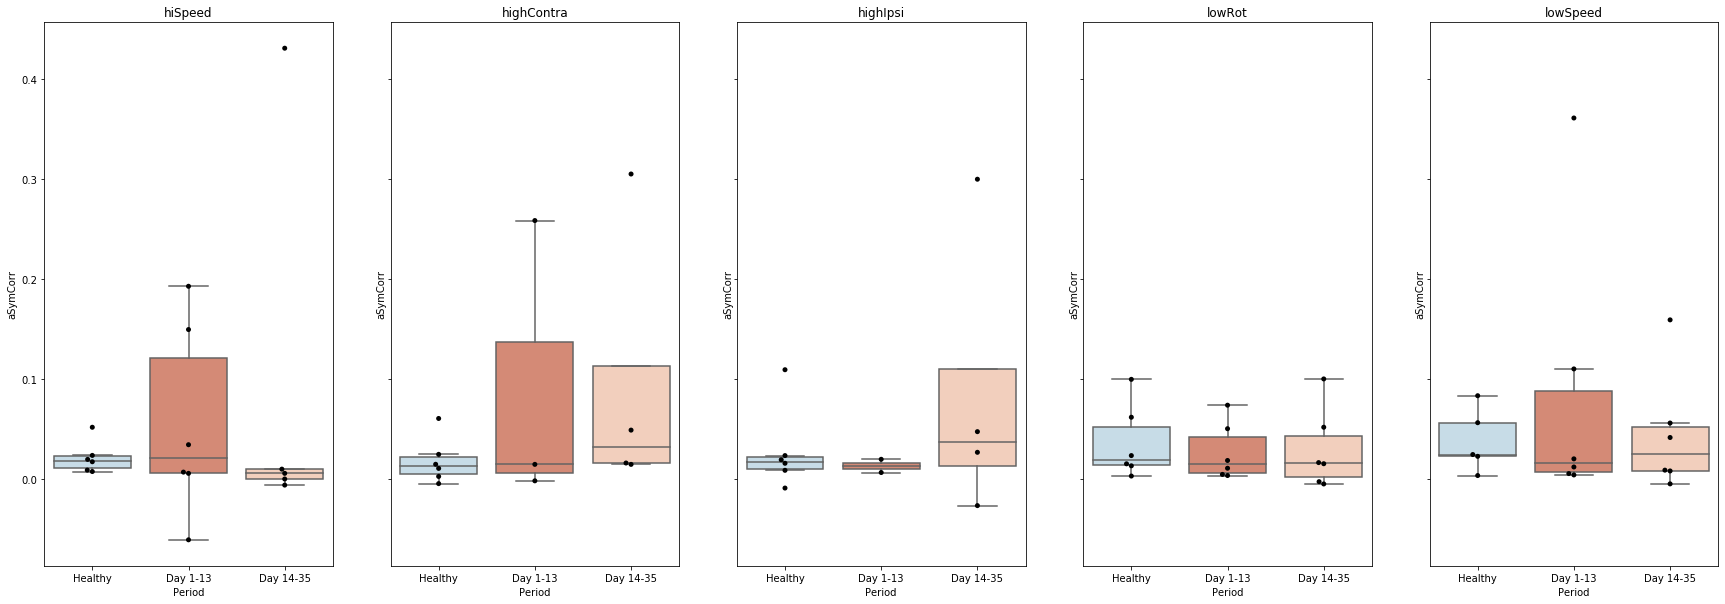

In [260]:
df = pd.read_csv(figFolder+ 'mvmtCorrSig.csv')
fig, ax  = plt.subplots(1,5,figsize=(30, 10),sharey = True)
indF = 0;
df = df.groupby(['population','mvmt','Period','Mouse']).mean()
df = df.reset_index()
for mvmt in df.mvmt.unique():
    with sns.color_palette(colorPallet3):
        sns.boxplot(x="Period", y="aSymCorr",ax = ax[indF],data=df[(df.population == "MSN-PV")&(df.mvmt == mvmt)], order = ['Healthy', 'Day 1-13', 'Day 14-35'], showfliers = False)
        sns.swarmplot(x="Period", y="aSymCorr",ax = ax[indF],color='black',
                      data=df[(df.population == "MSN-PV")&(df.mvmt == mvmt)], order = ['Healthy', 'Day 1-13', 'Day 14-35'])#, showfliers = False)
        ax[indF].set_title(mvmt)
#         ax[indF].set_ylim(-0.06,0.06)
        indF = indF + 1
# fig.savefig(figFolder+'figureS5.svg',format='svg')
# ax[0].set_ylim(-0.2,0.4)
fig.savefig(figFolder+'figureS5_PVMSN_mouse.svg',format='svg')
# fig, ax  = plt.subplots(1,5,figsize=(30, 10),sharey = True)
# indF = 0;
# for p in df.Period.unique():
    
#     sns.boxplot(x="mvmt", y="aSymCorr",ax = ax[indF],data=df[(df.population == "MSN-MSN")&(df.Period == p)], order = ['hiSpeed', 'lowSpeed', 'lowRot', 'highIpsi', 'highContra'], showfliers = False)
#     ax[indF].set_title(p)
#     indF = indF + 1


In [ ]:
#hi,bi = np.histogram(c[~np.isnan(c)],np.arange(-1,1,0.01))
# plt.plot(bi[1:],hi/np.sum(hi))
# col = ['Mouse','Sess','Day','numred','Period','population','mvmt','values']
# df = pd.DataFrame(columns = col)
df = df.append({'Mouse':1,'Sess':2,'Day':3,'numred':2,'Period':2,'population':2,'mvmt':2,'values':hi},ignore_index=True
)
df


In [151]:
periodCalc(6)


'Day 1-13'

In [9]:
"JUMP HERE"
f = h5py.File('/home/dana_z/HD1/connactivityAnalysis/connMapsMvmt.hdf5','a')
col_names = ['Mouse','Sess','Day','numred','Period','population','mvmt','personF','sPersonF']
df = pd.DataFrame(columns = col_names)
# df3 = pd.DataFrame(columns = ['Mouse','Sess','Day','numred','Period','population','mvmt','values'])
dist = {"MSN-MSN":[],"MSN-CHI":[],"MSN-PV":[]}
for m in f.keys():
    for sess in f[m].keys():
        for mvmt in f[m][sess]['Pre'].keys():
            try:
                numred = f[m][sess].attrs['numRed']
                cre = getCreType(Files[1],m)
                tempDict = {'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
                                    'numred':numred,'Period':periodCalc(f[m][sess].attrs['day'])}

                c = f[m][sess]['Pre'][mvmt]['pearson'].value 
                c[np.tril(c,-1)==0] = np.nan

                d = f[m][sess]['Pre'][mvmt][('pearson_shuffle')].value
                b = np.nanpercentile(d,[97.5,2.5],axis=2)
                d = np.nanmean(d,axis=2)
                d[np.tril(d,-1)==0] = np.nan
                
                nSig = (c>b[0,:,:])|(c<b[1,:,:])
                cSig = np.copy(c)
                cSig[nSig] = np.nan
                noSig = np.copy(c)
                noSig[~nSig] = np.nan

                if numRed > 1:
                    tempDict['population'] = cre+'-'+cre
                    tempDict['mvmt'] = mvmt
                    tempDict['aSymCorr'] = np.nanmean(c[:numred,:numred])
                    tempDict['sASymCorr'] = np.nanmean(d[:numred,:numred])
                    tempDict['aSymCorrSig'] = np.nanmean(cSig[:numred,:numred])
                    tempDict['aSymCorrNotSig'] = np.nanmean(noSig[:numred,:numred])
                    tempDict['sigPercent'] = np.nansum(nSig[:numred,:numred]==1)/np.nansum(np.isnan(c[:numred,:numred])==0)
                    df2 = pd.DataFrame([tempDict])
                    df = pd.concat([df,df2],sort=True)
                if numRed > 0:
                    tempDict['mvmt'] = mvmt
                    tempDict['population'] = 'MSN-'+cre
                    tempDict['aSymCorr'] = np.nanmean(c[numred:,:numred])
                    tempDict['sASymCorr'] = np.nanmean(d[numred:,:numred])
                    tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,:numred])
                    tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,:numred])
                    tempDict['sigPercent'] = np.nansum(nSig[numred:,:numred]==1)/np.nansum(np.isnan(c[numred:,:numred])==0)

                    df2 = pd.DataFrame([tempDict])
                    df = pd.concat([df,df2],sort=True)
#                     hi,bi = np.histogram(c[numred:,:numred],np.arange(-1,1,0.01))
#                     hi2,bi2 = np.histogram(cSig[numred:,:numred],np.arange(-1,1,0.01))
#                     df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
#                                     'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
#                                       'population':'MSN-'+cre,'mvmt':mvmt,'values':hi,'values_sig':hi2},ignore_index=True)

                    
                
                tempDict['mvmt'] = mvmt
                tempDict['population'] = 'MSN-MSN'
                tempDict['aSymCorr'] = np.nanmean(c[numred:,numred:])
                tempDict['sASymCorr'] = np.nanmean(d[numred:,numred:])
                tempDict['aSymCorrSig'] = np.nanmean(cSig[numred:,numred:])
                tempDict['aSymCorrNotSig'] = np.nanmean(noSig[numred:,numred:])
                tempDict['sigPercent'] = np.nansum(nSig[numred:,numred:]==1)/np.nansum(np.isnan(c[numred:,numred:])==0)
#                 hi,bi = np.histogram(c[numred:,numred:],np.arange(-1,1,0.01))
#                 hi2,bi2 = np.histogram(cSig[numred:,numred:],np.arange(-1,1,0.01))
#                 df3 = df3.append({'Mouse':m,'Sess':sess,'Day':f[m][sess].attrs['day'],
#                                 'numred':numred,'Period':periodCalc(f[m][sess].attrs['day']),
#                                   'population':'MSN-MSN','mvmt':mvmt,'values':hi,'values_sig':hi2},ignore_index=True)
                df2 = pd.DataFrame([tempDict])
                df = pd.concat([df,df2],sort=True)
            except Exception as e:
                exc_type, exc_obj, exc_tb = sys.exc_info()
                print(sess,'-',mvmt,exc_tb.tb_lineno,c.shape)
f.close()
df.to_csv(figFolder+'mvmtCorrSig.csv')
# df3.to_csv(figFolder+'mvmtCorrSig_hists.csv')

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  app.launch_new_instance()
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/home/dana_z/anaconda3/lib/python3.6/si

0761_day31A - highContra 17 ()
0761_day35L - hiSpeed 17 ()
0761_day35L - highContra 17 ()
1208_day2 - highContra 17 ()
1208_day30A - highContra 17 ()
1208_day34L - highContra 17 ()
1222_day2 - hiSpeed 17 ()
1222_day2 - highContra 17 ()
1222_day2 - highIpsi 17 ()
1222_day2 - lowRot 17 ()
1222_day2 - lowSpeed 17 ()
1222_day2 - totRot 17 ()
1236_day15A - highIpsi 17 ()
1236_day19L - highIpsi 17 ()
1236_day30A - highIpsi 17 ()
2980_day19L - highContra 17 ()
2981_day2 - highIpsi 17 ()
4539_day1 - highContra 17 ()
4539_day1 - highIpsi 17 ()
4539_day1 - totRot 17 ()
4539_day10 - highContra 17 ()
4539_day10 - highIpsi 17 ()
4539_day10 - totRot 17 ()
4539_day11 - highContra 17 ()
4539_day11 - highIpsi 17 ()
4539_day11 - totRot 17 ()
4539_day12 - highContra 17 ()
4539_day12 - highIpsi 17 ()
4539_day12 - totRot 17 ()
4539_day13 - highContra 17 ()
4539_day13 - highIpsi 17 ()
4539_day13 - totRot 17 ()
4539_day14 - highContra 17 ()
4539_day14 - highIpsi 17 ()
4539_day14 - totRot 17 ()
4539_day2 - hi

In [11]:
df = pd.read_csv(figFolder+ 'mvmtCorrSig.csv')
df.head(20)

Unnamed: 0  Day  Mouse   Period            Sess  aSymCorr  aSymCorrNotSig  \
0            0    0    761  Healthy  0761_BaselineA       NaN             NaN   
1            0    0    761  Healthy  0761_BaselineA -0.019763             NaN   
2            0    0    761  Healthy  0761_BaselineA  0.062096        0.392132   
3            0    0    761  Healthy  0761_BaselineA       NaN             NaN   
4            0    0    761  Healthy  0761_BaselineA       NaN             NaN   
5            0    0    761  Healthy  0761_BaselineA -0.036672             NaN   
6            0    0    761  Healthy  0761_BaselineA       NaN             NaN   
7            0    0    761  Healthy  0761_BaselineA -0.019633             NaN   
8            0    0    761  Healthy  0761_BaselineA  0.002173        0.258232   
9            0    0    761  Healthy  0761_BaselineA       NaN             NaN   
10           0    0    761  Healthy  0761_BaselineA  0.028247        0.139514   
11           0    0    761  Healthy  0761_BaselineA  0.028631        0.128896   
12           0    0    761  Healthy  0761_BaselineA       NaN             NaN   
13           0    0    761  Healthy  0761_BaselineA  0.014874        0.158942   
14           0    0    761  Healthy  0761_BaselineA  0.020643        0.143379   
15           0    0    761  Healthy  0761_BaselineA       NaN             NaN   
16           0    0    761  Healthy  0761_BaselineA -0.014928             NaN   
17           0    0    761  Healthy  0761_BaselineA -0.003981        0.424159   
18           0    0    761  Healthy  0761_BaselineL       NaN             NaN   
19           0    0    761  Healthy  0761_BaselineL       NaN             NaN   

    aSymCorrSig        mvmt  numred  personF population  sASymCorr  sPersonF  \
0           NaN     hiSpeed       1      NaN    CHI-CHI        NaN       NaN   
1     -0.019763     hiSpeed       1      NaN    MSN-CHI   0.000802       NaN   
2     -0.020412     hiSpeed       1      NaN    MSN-MSN  -0.000855       NaN   
3           NaN  highContra       1      NaN    CHI-CHI        NaN       NaN   
4           NaN  highContra       1      NaN    MSN-CHI        NaN       NaN   
5     -0.036672  highContra       1      NaN    MSN-MSN  -0.001521       NaN   
6           NaN    highIpsi       1      NaN    CHI-CHI        NaN       NaN   
7     -0.019633    highIpsi       1      NaN    MSN-CHI  -0.000812       NaN   
8     -0.017524    highIpsi       1      NaN    MSN-MSN   0.000076       NaN   
9           NaN      lowRot       1      NaN    CHI-CHI        NaN       NaN   
10     0.003521      lowRot       1      NaN    MSN-CHI  -0.000285       NaN   
11    -0.002404      lowRot       1      NaN    MSN-MSN  -0.000078       NaN   
12          NaN    lowSpeed       1      NaN    CHI-CHI        NaN       NaN   
13     0.000467    lowSpeed       1      NaN    MSN-CHI  -0.000252       NaN   
14    -0.000248    lowSpeed       1      NaN    MSN-MSN   0.000084       NaN   
15          NaN      totRot       1      NaN    CHI-CHI        NaN       NaN   
16    -0.014928      totRot       1      NaN    MSN-CHI  -0.000024       NaN   
17    -0.016214      totRot       1      NaN    MSN-MSN   0.000092       NaN   
18          NaN     hiSpeed       1      NaN    CHI-CHI        NaN       NaN   
19          NaN     hiSpeed       1      NaN    MSN-CHI        NaN       NaN   

    sigPercent  
0          NaN  
1     0.000000  
2     0.200000  
3          NaN  
4          NaN  
5     0.000000  
6          NaN  
7     0.000000  
8     0.071429  
9          NaN  
10    0.181818  
11    0.236364  
12         NaN  
13    0.090909  
14    0.145455  
15         NaN  
16    0.000000  
17    0.027778  
18         NaN  
19         NaN

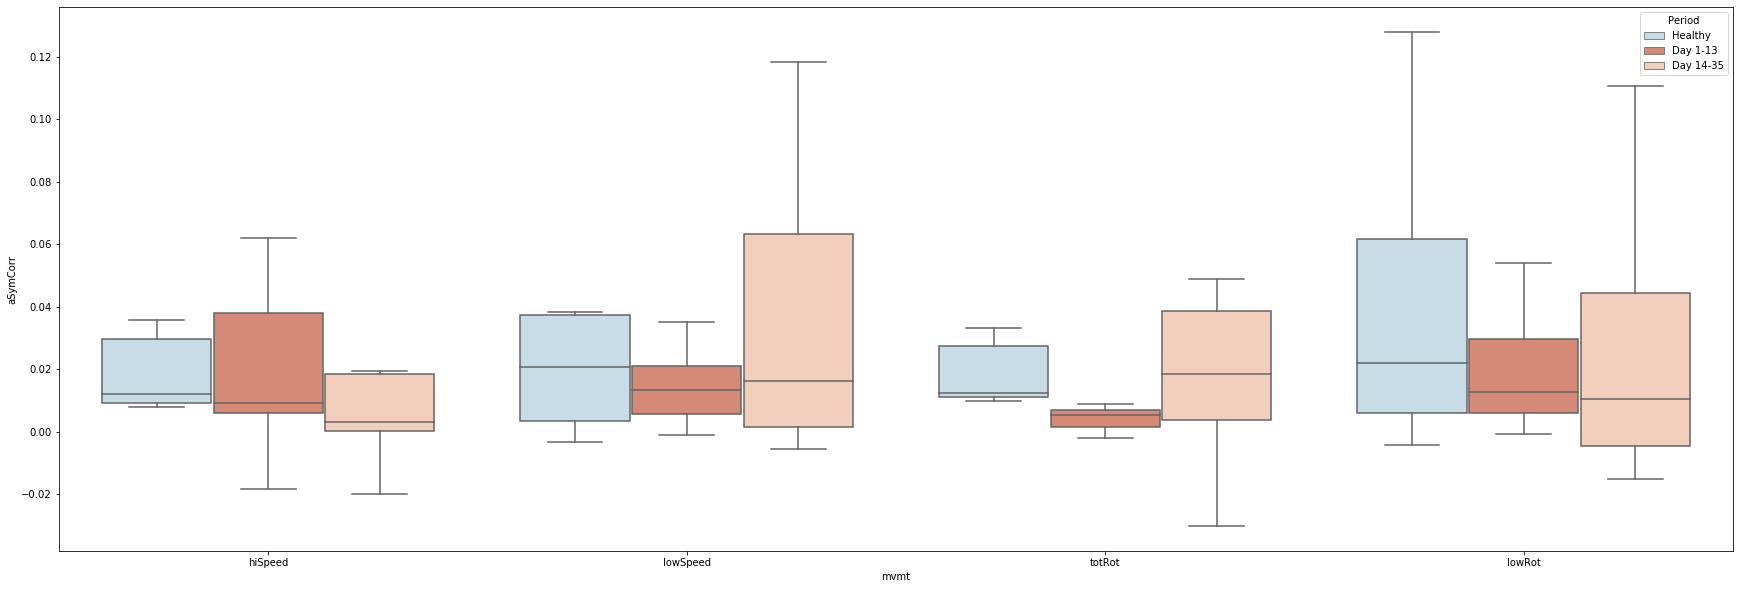

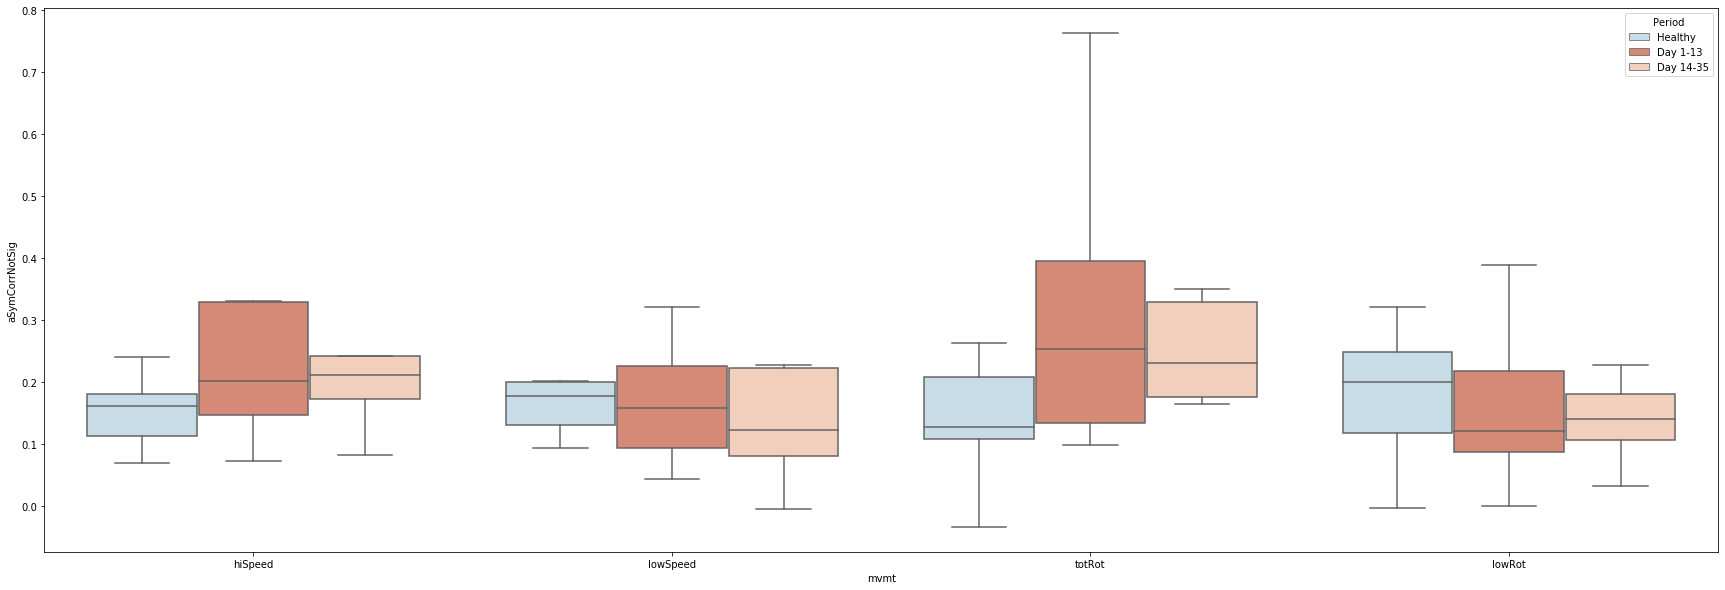

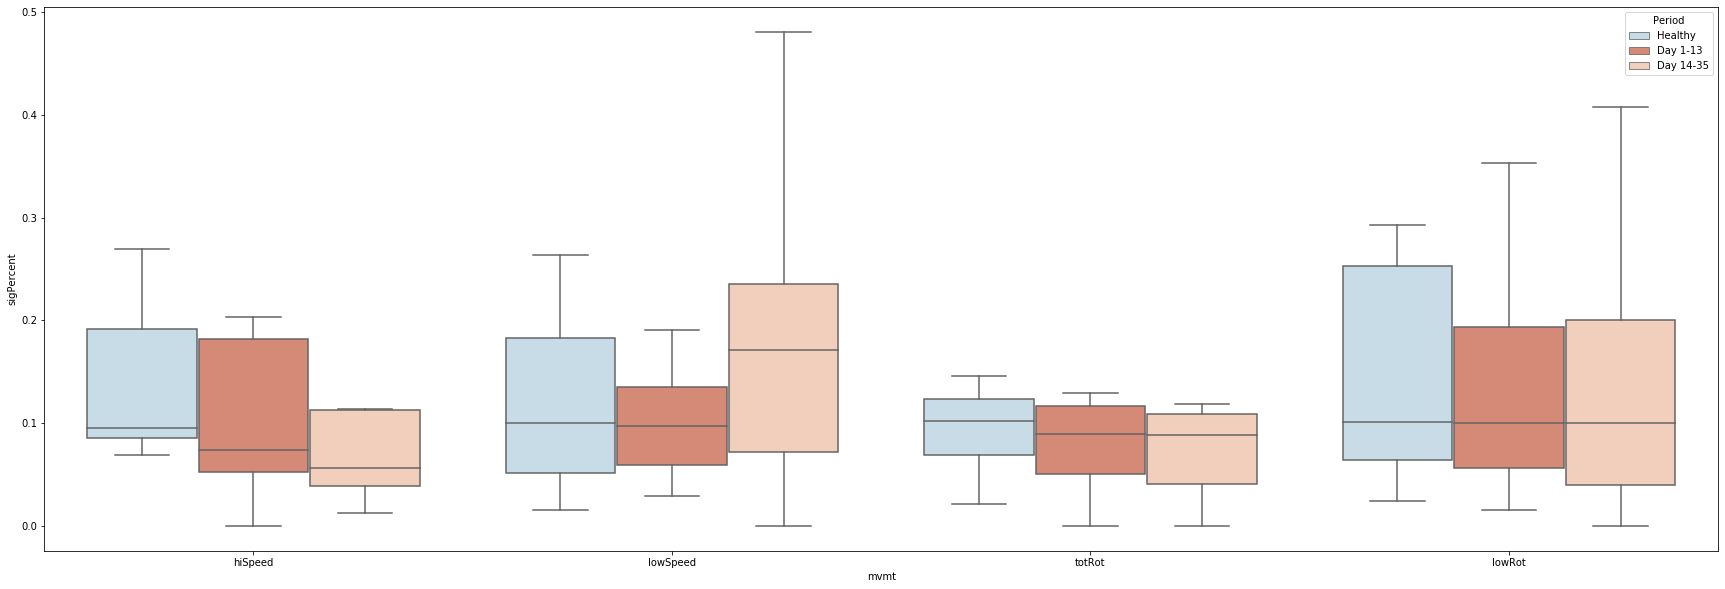

In [16]:
df = pd.read_csv(figFolder+ 'mvmtCorrSig.csv')
for col in ["aSymCorr","aSymCorrNotSig","sigPercent"]:
    fig, ax  = plt.subplots(1,1,figsize=(30, 10),sharey = True)
    indF = 0;
#     for mvmt in df.mvmt.unique():
    with sns.color_palette(colorPallet3):
        sns.boxplot(x = 'mvmt' ,hue="Period", y=col,#ax = ax[indF],
                    data=df[(df.population == "MSN-PV")],
                    hue_order = ['Healthy', 'Day 1-13', 'Day 14-35'], order = ['hiSpeed', 'lowSpeed', 'totRot','lowRot'],
                    showfliers = False)
#         ax[indF].set_title(mvmt)
        indF = indF + 1
    # fig.savefig(figFolder+'figureS5.svg',format='svg')
    # ax[0].set_ylim(-0.2,0.4)
    fig.savefig(figFolder+'figureS5_'+col+'_noFliers_PV.svg',format='svg')
    # fig, ax  = plt.subplots(1,5,figsize=(30, 10),sharey = True)
    # indF = 0;
    # for p in df.Period.unique():

#     sns.boxplot(x="mvmt", y="aSymCorr",ax = ax[indF],data=df[(df.population == "MSN-MSN")&(df.Period == p)], order = ['hiSpeed', 'lowSpeed', 'lowRot', 'highIpsi', 'highContra'], showfliers = False)
#     ax[indF].set_title(p)
#     indF = indF + 1


In [ ]:
df[(df.population == 'MSN-CHI')&(df.numred>0)].groupby(['mvmt','Period']).count() #(df.Period == 'Day 1-4')&

In [ ]:
dfC = pd.read_csv(figFolder+ 'firingRateDf.csv')
dfM = dfC[(dfC.All>0)][['Sess','Period','CellType','high_ACrot', 'high_Crot','low_rot']]
dfM2 = dfM#.groupby(['Sess','Period','CellType'],as_index=False).mean()

columns = ['high_ACrot', 'high_Crot','low_rot']#, 'high_ACrot', 'high_Crot','low_rot'] 
df_long = pd.melt(dfM2,id_vars=['CellType','Period','Sess'], value_vars=columns,value_name='event/min')
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)
indC = 0
colors = {'MSN':['#C0D3DC','#99B7C5','#3A6C82'], 'PV':['#FFE7C4','#fcb144','#CF9E56'],'CHI':['#DDC0DE','#C69AC8','#98549A']} #'#99B7C5','#FFE7C4','#C69AC8']
cells = ['MSN','PV','CHI']
for cell in cells:
#     g = sns.swarmplot(x="Period", y="event/min",hue ='variable' ,data=df_long[(df_long.CellType == cell)],color = [.2,.2,.2],dodge = True,
#                       order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'], 
#                       ax=ax[indC],**{'label':'_nolegend_','alpha':0.5,'s':3})
    g = sns.boxplot(x="Period",hue ='variable', y="event/min",data=df_long[(df_long.CellType == cell)], dodge = True,
                   order = ['Healthy', 'Day 1-4', 'Day 5-12', 'Day 13-20', 'One Month'],
                   palette=colors[cell],ax=ax[indC], showfliers = False)

    ax[indC].set_ylim(0,6)
    indC = indC +1
#fig.savefig(figFolder+'figure3_c.png',transparent=False,format='png')
fig.savefig(figFolder+'figure3_c_v2.svg',transparent=True,format='svg')


In [ ]:
# df2 = dfC[(dfC.CellType=='PV')]
df2 = dfC#[(dfC.All>0)]
# print(dfC.columns) #'high_ACrot','high_Crot','low_rot',
df3 = df2[['All','highSpeed','high_speed','highTime','Sess','Period','CellType']]#.groupby(['Period','CellType'])
print(df3.groupby(['CellType','Period']).count())
# print(df3[(df3.CellType=='PV')&(df3.Period == 'Day 13-20')])
# print(df3[(df3.CellType=='PV')&(df3.Period == 'Day 13-20')])
# print(dfC[(dfC.Sess == '8430_day19L')& (dfC.CellType=='PV')][['highACRotTime','highACrot']])
# dfC.columns

In [ ]:
# This is where I am 
speedData = []
for m in miceList:
    data = getData(Files[1],['speed'],period ='Pre', mice=m)
    
    # calculte % high speed + % low speed
    for sess in data:
        # find the day of the session
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        
        row = {'Mouse':m,'Session':sess,'Day':day}
        hStart = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_StartSegments')
        hEnd = getOnsetOrPeriod(m,sess,'Pre','HighMvmtPeriods_EndSegments')
        row['high_speed'] = np.mean(hEnd-hStart)/20
        
        hStart = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_StartSegments')
        hEnd = getOnsetOrPeriod(m,sess,'Pre','LowMvmtPeriods_EndSegments')
        row['low_speed'] = np.mean((hEnd-hStart)/20)
        
        hStart = getOnsetOrPeriod(m,sess,'Pre','hiACRotPeriods_StartSegments')
        hEnd = getOnsetOrPeriod(m,sess,'Pre','hiACPeriods_EndSegments')
        row['high_AC'] = np.mean((hEnd-hStart)/20)
        
        hStart = getOnsetOrPeriod(m,sess,'Pre','hiCRotPeriods_StartSegments')
        hEnd = getOnsetOrPeriod(m,sess,'Pre','hiCPeriods_EndSegments')
        row['high_C'] = np.mean((hEnd-hStart)/20)
        
        hStart = getOnsetOrPeriod(m,sess,'Pre','loRotPeriods_StartSegments')
        hEnd = getOnsetOrPeriod(m,sess,'Pre','loPeriods_EndSegments')
        row['low_rot'] = np.mean((hEnd-hStart)/20)
    
        speedData.append(row)
          
df = pd.DataFrame(speedData)        
df['Period'] =  df.apply (lambda row: periodCalc(row.Day) , axis=1)
df.head()

In [ ]:
# df_long = df.melt(id_vars=['Session','Period'], value_vars=['high_speed','low_speed','high_AC','high_C','low_rot'])

# sns.boxplot(x='Period',y='value',hue ='variable' ,data= df_long,showfliers = False)
print(df.groupby('Period').mean())

<h1> Extra Analysis - might be added to paper later

In [ ]:
CHI1 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: (x>0)& (x<5) )

In [ ]:
f = h5py.File('OnsetsAndPeriods.hdf5','r')
# align spectogram to spike onset -> for each mouse and in total,seperate by CRE:

tracePerSlide = 8
lf = {'left':0.30, 'top':1.30, 'height':10.80, 'width':25.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}

fig, ax = plt.subplots(len(CHI1.keys()),1,figsize=(lf['width'],lf['height']))
fig.set_size_inches(lf['width'],lf['height'],forward=True)

indX = 0
for sess in CHI1.keys():
    # get traces:
    m = sess[:4]
    dff = CHI1[sess]['trace']['dff']
    dt = 1/CHI1[sess]['trace']['FS'][0]
    t = np.linspace(0,dt*dff.shape[1],dff.shape[1])
    Fs = CHI1[sess]['trace']['FS'][0]
    # Vectors are saved as column vectors so.. transposed to raw vector
    if dff.shape[1] == 1:
        dff = dff.T
    # get CaOnset:
    caOnset = f[m][sess]['Pre']['caOnset_Hf'].value
    caFall =  f[m][sess]['Pre']['caFall_Hf'].value
    caOnset[caOnset==0] =np.nan
    caFall[caFall==0] =np.nan
    numred = int(CHI1[sess]['trace']['numred'])

    tLim = int(600*Fs)
    N = 0
    endN = np.min(((N+1)*tracePerSlide,dff.shape[0]))
    T=0;
    endT = np.min(((T+1)*tLim,dff.shape[1]))
    df = dff[N*tracePerSlide:endN,T*tLim:endT]
    ca = caOnset[N*tracePerSlide:endN,T*tLim:endT]
    ca = ca*df
    cf = caFall[N*tracePerSlide:endN,T*tLim:endT]
    cf = cf*df
    spacing = np.max(np.abs(df))
    Color = ['navy' for x in range(0,df.shape[0])]
    if tracePerSlide*N <numred:
        Nl = min(tracePerSlide,numred-N*tracePerSlide)
        Color[0:Nl] = ['black' for x in range(0,Nl)]
    else:
        Color = ['blue' for x in range(0,len(Color))]
    for d in range(0,df.shape[0]):
        ax[indX].plot(t[T*tLim:endT],df[d,:]+d*spacing,color=Color[d],rasterized=True) 
        ax[indX].plot(t[T*tLim:endT],ca[d,:]+d*spacing,color='red',rasterized=True)
        ax[indX].plot(t[T*tLim:endT],cf[d,:]+d*spacing,color='gold',rasterized=True)
    ax[indX].set_title(sess)
    indX = indX+1
#fig.savefig(figFolder+'figure3_eventDetection'+'.png')
#fig.savefig(figFolder+'figure3_eventDetection_rasterized'+'.svg',transparent=True)


In [ ]:
CHI0 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x==0)
CHI2 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: (x>4)& (x<13) )
CHI3 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: (x>12)& (x<21) )
CHI4 = getData(Files[1],['speed','rot','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x>20 )


In [ ]:
warnings.filterwarnings('ignore')
f = h5py.File('OnsetsAndPeriods.hdf5','r')
# align spectogram to spike onset -> for each mouse and in total,seperate by CRE:

tracePerSlide = 8
lf = {'left':0.30, 'top':1.30, 'height':10.80, 'width':25.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}
for p in range(0,5):
    data = eval('CHI'+str(p))
    fig, ax = plt.subplots(len(data.keys()),1,figsize=(lf['width'],lf['height']+len(data.keys())*4))
    fig.set_size_inches(lf['width'],lf['height'],forward=True)

    indX = 0
    for sess in data.keys():
        # get traces:
        m = sess[:4]
        dff = data[sess]['trace']['dff']
        dt = 1/data[sess]['trace']['FS'][0]
        t = np.linspace(0,dt*dff.shape[1],dff.shape[1])
        Fs = data[sess]['trace']['FS'][0]
        # Vectors are saved as column vectors so.. transposed to raw vector
        if dff.shape[1] == 1:
            dff = dff.T
        # get CaOnset:
        caOnset = f[m][sess]['Pre']['caOnset_Hf'].value
        caFall =  f[m][sess]['Pre']['caFall_Hf'].value
        caOnset[caOnset==0] =np.nan
        caFall[caFall==0] =np.nan
        numred = int(data[sess]['trace']['numred'])

        tLim = int(600*Fs)
        N = 0
        endN = np.min(((N+1)*tracePerSlide,dff.shape[0]))
        T=0;
        endT = np.min(((T+1)*tLim,dff.shape[1]))
        df = dff[N*tracePerSlide:endN,T*tLim:endT]
        ca = caOnset[N*tracePerSlide:endN,T*tLim:endT]
        ca = ca*df
        cf = caFall[N*tracePerSlide:endN,T*tLim:endT]
        cf = cf*df
        spacing = np.max(np.abs(df))
        Color = ['navy' for x in range(0,df.shape[0])]
        if tracePerSlide*N <numred:
            Nl = min(tracePerSlide,numred-N*tracePerSlide)
            Color[0:Nl] = ['black' for x in range(0,Nl)]
        else:
            Color = ['blue' for x in range(0,len(Color))]
        for d in range(0,df.shape[0]):
            ax[indX].plot(t[T*tLim:endT],df[d,:]+d*spacing,color=Color[d],rasterized=True) 
            ax[indX].plot(t[T*tLim:endT],ca[d,:]+d*spacing,color='red',rasterized=True)
            ax[indX].plot(t[T*tLim:endT],cf[d,:]+d*spacing,color='gold',rasterized=True)
        ax[indX].set_title(sess)
        indX = indX+1
    #fig.savefig(figFolder+'figure3_eventDetection'+'.png')
    #fig.savefig(figFolder+'figure3_eventDetection_rasterized'+'.svg',transparent=True)


In [9]:
MSN0 = getData(Files[1],['trace'],period ='Pre', red = False,day = lambda x: x==0)
MSN1 = getData(Files[1],['trace'],period ='Pre', red = False,day = lambda x: (x>0)& (x<13) )
MSN2 = getData(Files[1],['trace'],period ='Pre', red = False,day = lambda x: (x>=13) )

cleaning up trace data
cleaning up trace data
cleaning up trace data


In [283]:
 del quant

<IPython.core.display.Javascript object>


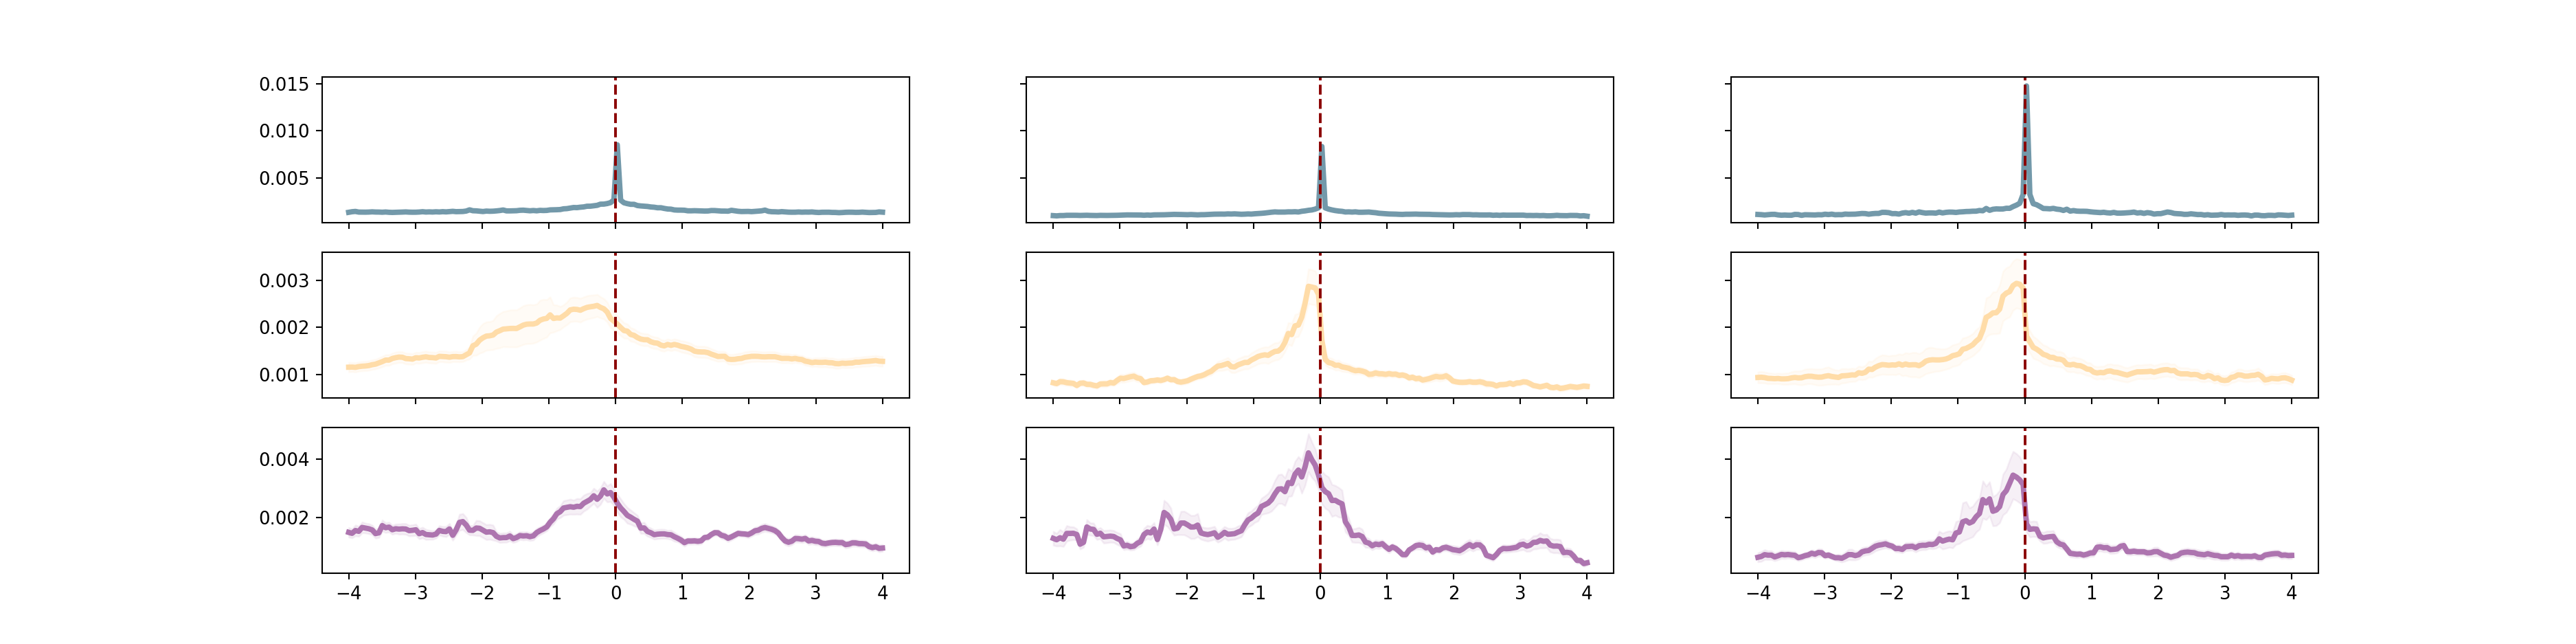

 33%|███▎      | 1/3 [00:10<00:20, 10.27s/it]/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/dana_z/ssd_2TB/6OHDA/utils.py:246: UserWarning: data is shorter than onset. Trancuating onset vector
  warnings.warn("data is shorter than onset. Trancuating onset vector")
 67%|██████▋   | 2/3 [00:33<00:14, 14.27s/it]/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value
/home/dana_z/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.p

In [18]:
# chol/PV/MSN triggered MSNs
fig, ax = plt.subplots(3,3,figsize=(20, 5),sharex='col',sharey='row')
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['PV','CHI','MSN']
Period = {'Healthy':0,'Day 1-13':1,'Day 14-35':2}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)
quant = []

for p in tqdm(Period.keys()):
    data = eval('MSN'+str(Period[p]))
    nSess = {'MSN':0,'PV':0,'CHI':0}
    for s in data.keys():
        m = s[:4]
        numRed = data[s]['trace']['numred']
        cre = getCreType(Files[1],m)
        
        Ca = getOnsetOrPeriod(m,s,'Pre','caOnset_Hf')
        dCa = Ca[:,1:]-Ca[:,:-1]
        dCa[dCa==-1] = 0;
        Zdff = np.mean(dCa[numRed:,:],axis=0)
#         dCa = Ca
#         Zdff = np.mean(dCa[numRed:,:],axis=0)
#         # Vectors are saved as column vectors so.. transposed to raw vector
        
        
        # calc MSNs
        for tr in range(numRed,Ca.shape[0]):
            sOnset = dCa[tr,:]==1       
            sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
            if dCa[numRed:,:].shape[0] ==1 and np.sum(sOnset)>0:
                try:
                    sA = np.reshape(sA,(sA.shape[0],sA.shape[1]))
                except:
                    sA = np.reshape(sA,(sA.shape[0],1))

            if len(sA.shape) > 1:
                sA = np.mean(sA,1,keepdims=True)
                if 'sAlignedMSN' not in locals():
    #               print(s+' :',sA.shape)
                    sAlignedMSN = sA
                    nSess['MSN'] = nSess['MSN']+1
                else:
    #                print(s+' :',sA.shape,sAlignedMSN.shape)
                    sAlignedMSN = np.concatenate((sAlignedMSN,sA),axis=1)
                    nSess['MSN'] = nSess['MSN']+1
        if cre == 'PV':
            for tr in range(0,numRed):
                sOnset = Ca[tr,:]==1       
                sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
                if dCa[numRed:,:].shape[0] ==1 and np.sum(sOnset)>0:
                    try:
                        sA = np.reshape(sA,(sA.shape[0],sA.shape[1]))
                    except:
                        sA = np.reshape(sA,(sA.shape[0],1))

                if len(sA.shape) > 1:
                    sA = np.mean(sA,1,keepdims=True)
                    if 'sAlignedPV' not in locals():
        #               print(s+' :',sA.shape)
                        sAlignedPV = sA
                        nSess['PV'] = nSess['PV']+1
                    else:
        #                print(s+' :',sA.shape,sAlignedMSN.shape)
                        sAlignedPV = np.concatenate((sAlignedPV,sA),axis=1)
                        nSess['PV'] = nSess['PV']+1
        if cre == 'CHI':
            for tr in range(0,numRed):
                sOnset = Ca[tr,:]==1       
                sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)  
                if dCa[numRed:,:].shape[0] ==1 and np.sum(sOnset)>0:
                    try:
                        sA = np.reshape(sA,(sA.shape[0],sA.shape[1]))
                    except:
                        sA = np.reshape(sA,(sA.shape[0],1))

                if len(sA.shape) > 1:
                    sA = np.mean(sA,1,keepdims=True)
                    if 'sAlignedCHI' not in locals():
        #               print(s+' :',sA.shape)
                        sAlignedCHI = sA
                        nSess['CHI'] = nSess['CHI']+1
                    else:
        #                print(s+' :',sA.shape,sAlignedMSN.shape)
                        sAlignedCHI = np.concatenate((sAlignedCHI,sA),axis=1)
                        nSess['CHI'] = nSess['CHI']+1
            
            
    PlotRelativeToOnset(ax[0,Period[p]],sAlignedMSN,tPlot,Color=Colors['MSN'],Label='MSN',mesErr=True) 
    PlotRelativeToOnset(ax[1,Period[p]],sAlignedPV,tPlot,Color=Colors['PV'],Label='PV',mesErr=True)
    PlotRelativeToOnset(ax[2,Period[p]],sAlignedCHI,tPlot,Color=Colors['CHI'],Label='CHI',mesErr=True)
#     PlotRelativeToOnset(ax[3,Period[p]],sAlignedMSN,tPlot,Color=Colors['MSN'],Label='MSN',mesErr=True) 
#     PlotRelativeToOnset(ax[3,Period[p]],sAlignedPV,tPlot,Color=Colors['PV'],Label='PV',mesErr=True)
#     PlotRelativeToOnset(ax[3,Period[p]],sAlignedCHI,tPlot,Color=Colors['CHI'],Label='CHI',mesErr=True)
    
    quant.append({'Period':p,'CellType':'MSN','data':sAlignedMSN})
    quant.append({'Period':p,'CellType':'PV','data':sAlignedPV})
    quant.append({'Period':p,'CellType':'CHI','data':sAlignedCHI})
    del sAlignedMSN, sAlignedPV, sAlignedCHI
fig.savefig(figFolder+'extra_MSNAlign2Cell.png',format='png')
fig.savefig(figFolder+'extra_MSNAlign2Cell.svg',format='svg')




In [17]:
 del sAlignedMSN, quant, sAlignedPV, sAlignedCHI

NameError: name 'sAlignedPV' is not defined

In [19]:
dfQ = pd.DataFrame(columns = ['Period','CellType','pre','post'])
tpre = (tPlot>-0.1)&(tPlot<0)
tpost = (tPlot>=0)&(tPlot<0.1)
for ind in range(len(quant)):
    q = np.array([np.nansum(quant[ind]['data'][tpre,:],axis=0),np.nansum(quant[ind]['data'][tpost,:],axis=0)]).T        
    dfQ2 = pd.DataFrame(q,columns = ['pre','post'])
    dfQ2['CellType'] = quant[ind]['CellType']
    dfQ2['Period'] = quant[ind]['Period']
    dfQ =pd.concat([dfQ,dfQ2])
dfQ['Diff'] = dfQ.apply(lambda x: x.post-x.pre,axis=1)
dfQ

Period CellType       pre      post      Diff
0     Healthy      MSN  0.000000  0.038462  0.038462
1     Healthy      MSN  0.012821  0.038462  0.025641
2     Healthy      MSN  0.000000  0.000000  0.000000
3     Healthy      MSN  0.001832  0.042125  0.040293
4     Healthy      MSN  0.000000  0.000000  0.000000
..        ...      ...       ...       ...       ...
21  Day 14-35      CHI  0.011396  0.011396  0.000000
22  Day 14-35      CHI  0.000765  0.000765  0.000000
23  Day 14-35      CHI  0.014514  0.001451 -0.013062
24  Day 14-35      CHI  0.000000  0.000000  0.000000
25  Day 14-35      CHI  0.000000  0.000000  0.000000

[31244 rows x 5 columns]

<IPython.core.display.Javascript object>


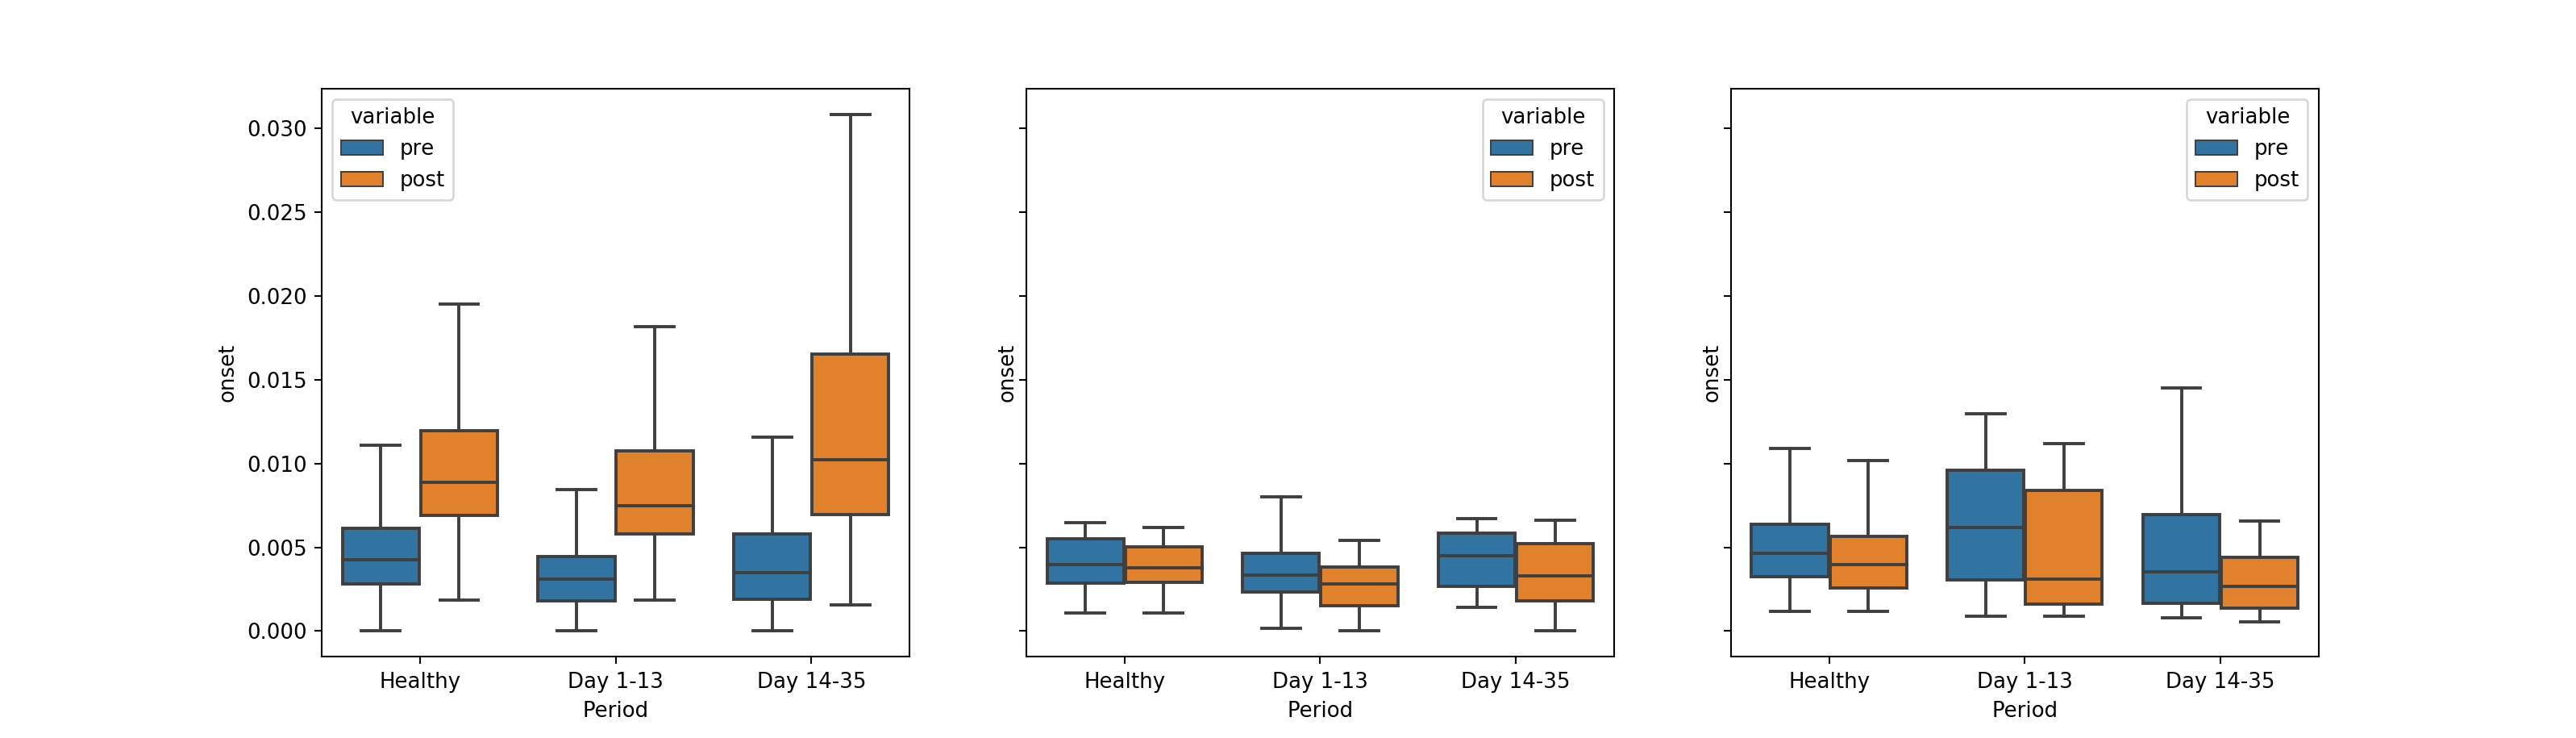

In [32]:
dfQ2 = dfQ[~((dfQ.pre==0)&(dfQ.post==0))].melt(id_vars = ['Period','CellType'],value_vars=['pre','post'],value_name='onset')
# dfQ2
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88),sharey=True)

cells = ['MSN','PV','CHI']
for inC, cell in enumerate(cells):
    sns.boxplot(x='Period',y='onset',ax =ax[inC] ,hue = 'variable',data=dfQ2[(dfQ2.CellType == cell)],showfliers = False)

fig.savefig(figFolder+'extra_MSNAlign2Cell_bar100.svg',format='svg')

<IPython.core.display.Javascript object>


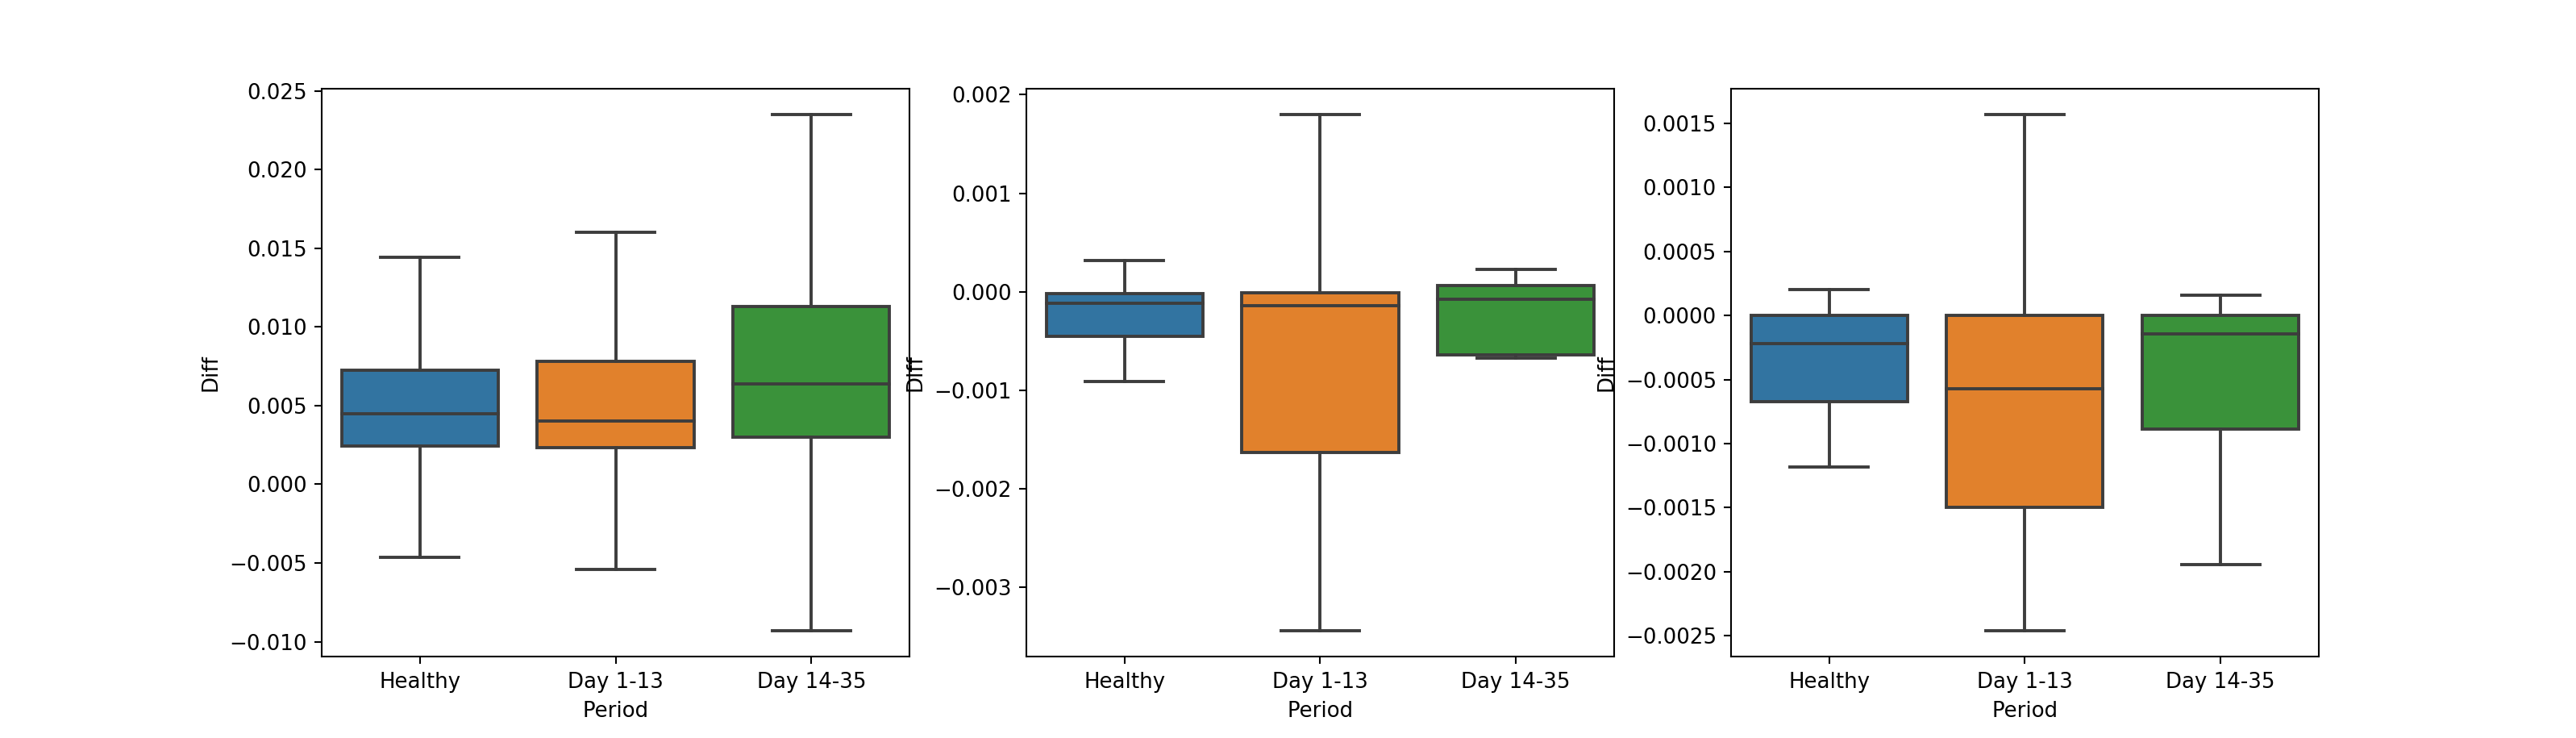

In [34]:
dfQ2 = dfQ[~((dfQ.pre==0)&(dfQ.post==0))]#.melt(id_vars = ['Period','CellType'],value_vars=['pre','post'],value_name='onset')
# dfQ2
fig, ax = plt.subplots(1,3,figsize=(17.04,4.88))#,sharey=True)

cells = ['MSN','PV','CHI']
for inC, cell in enumerate(cells):
    sns.boxplot(x='Period',y='Diff',ax =ax[inC] ,data=dfQ2[(dfQ2.CellType == cell)],showfliers = False)


# sns.boxplot(x='CellType',y='Diff',hue = 'Period',data=dfQ2,showfliers = False)
#     ax[inC].set_title(cell)
# fig.savefig(figFolder+'extra_MSNAlign2Cell_bar100diff.png',format='png')

In [36]:
dfQ2 = dfQ2[(dfQ2.CellType == 'PV')]
fvalue, pvalue = sci.stats.f_oneway(dfQ2[dfQ2.Period == 'Healthy'].Diff,dfQ2[dfQ2.Period == 'Day 14-35'].Diff,dfQ2[dfQ2.Period == 'Day 1-13'].Diff)
print(fvalue, pvalue)

nan nan


/home/dana_z/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3612: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '
